# imports

In [60]:
import classifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import shutil
import os
import time
import copy
from PIL import Image
import cv2
import numpy as np
from tqdm import tqdm
import random
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset
import pandas as pd
from sklearn.metrics import confusion_matrix, average_precision_score, precision_recall_curve, precision_score, recall_score, accuracy_score
import seaborn as sns
import requests
from io import BytesIO
import base64
from IPython.display import display, HTML

# General

In [3]:
PROJECT_PATH = os.getcwd()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# specifics

In [4]:
batch_size = 128
betas = (0.99, 0.999)
num_epochs = 45
step_size =  7
gamma = 0.1
model_name = 'resnet18'
retrain = True
load_model = None #os.path.join(PROJECT_PATH, 'models', 'resnet18', 'resnet18.pth')
add_classes_dir = os.path.join(PROJECT_PATH, 'add_classes')
save_model = False

#after adding classes
learning_rate_first_layers = 0.001
learning_rate_final_layer = 0.01
eveluate = True

# datasets and loaders

## prepare labels

In [5]:
DATA_DIR_PATH = os.path.join(PROJECT_PATH, 'dataset')

## datasets

In [6]:
# Define data transformations including data augmentation
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

In [7]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [8]:
# Create the custom dataset
dataset = classifier.CustomDataset(DATA_DIR_PATH, transform=transform)

# Split the dataset into train, validation, and test subsets
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
ds = {'train': train_data, 'valid': val_data, 'test': test_data}

## data loaders

In [9]:
# Create data loaders for each split
dataloaders = {key: DataLoader(ds[key], batch_size=batch_size, shuffle=True) for key in ds.keys()} 
dataset_sizes = {
    'train': len(train_data),
    'valid': len(val_data)
}

# Model

## chose model

In [10]:
model_name

'resnet18'

In [11]:
num_classes = None
model_state_dict = None
class_labels = None

if load_model:
        checkpoint = torch.load(load_model)
        model_name = checkpoint['model_name']
        num_classes = checkpoint['num_classes']
        model_state_dict = checkpoint['state_dict']
        class_labels = checkpoint['class_labels']
elif DATA_DIR_PATH:
    num_classes = len(dataset.main_classes_set.keys())
else:
    print("Please provide a data directory or a model to load")

model_ft = classifier.create_model_instance(model_name, num_classes) 
if load_model:
    model_ft.load_state_dict(model_state_dict)

# Transfer the model to GPU
model_ft = model_ft.to(device)
    

Creating resnet18


/home/liranc6/miniconda3/envs/War/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/liranc6/miniconda3/envs/War/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## params

In [12]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer 
optimizer_ft = optim.AdamW(model_ft.parameters(), betas=betas)
# Learning rate decay
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=step_size, gamma=gamma)

# Train

## fit/train

Epoch 0/44
----------


100%|██████████| 39/39 [00:22<00:00,  1.74it/s]


train Loss: 0.0042 Acc: 0.8266


100%|██████████| 9/9 [00:03<00:00,  2.66it/s]


valid Loss: 0.0130 Acc: 0.6800

Epoch 1/44
----------


100%|██████████| 39/39 [00:19<00:00,  1.98it/s]


train Loss: 0.0016 Acc: 0.9329


100%|██████████| 9/9 [00:03<00:00,  2.67it/s]


valid Loss: 0.0075 Acc: 0.7990

Epoch 2/44
----------


100%|██████████| 39/39 [00:19<00:00,  1.99it/s]


train Loss: 0.0011 Acc: 0.9551


100%|██████████| 9/9 [00:03<00:00,  2.70it/s]


valid Loss: 0.0023 Acc: 0.9105

Epoch 3/44
----------


100%|██████████| 39/39 [00:19<00:00,  2.00it/s]


train Loss: 0.0009 Acc: 0.9635


100%|██████████| 9/9 [00:03<00:00,  2.69it/s]


valid Loss: 0.0025 Acc: 0.9133

Epoch 4/44
----------


100%|██████████| 39/39 [00:19<00:00,  2.05it/s]


train Loss: 0.0006 Acc: 0.9745


100%|██████████| 9/9 [00:03<00:00,  2.75it/s]


valid Loss: 0.0025 Acc: 0.9124

Epoch 5/44
----------


100%|██████████| 39/39 [00:19<00:00,  2.04it/s]


train Loss: 0.0005 Acc: 0.9788


100%|██████████| 9/9 [00:03<00:00,  2.67it/s]


valid Loss: 0.0013 Acc: 0.9514

Epoch 6/44
----------


100%|██████████| 39/39 [00:19<00:00,  2.01it/s]


train Loss: 0.0004 Acc: 0.9833


100%|██████████| 9/9 [00:03<00:00,  2.70it/s]


valid Loss: 0.0013 Acc: 0.9552

Epoch 7/44
----------


100%|██████████| 39/39 [00:19<00:00,  1.99it/s]


train Loss: 0.0002 Acc: 0.9922


100%|██████████| 9/9 [00:03<00:00,  2.53it/s]


valid Loss: 0.0012 Acc: 0.9610

Epoch 8/44
----------


100%|██████████| 39/39 [00:19<00:00,  1.96it/s]


train Loss: 0.0002 Acc: 0.9969


100%|██████████| 9/9 [00:03<00:00,  2.58it/s]


valid Loss: 0.0009 Acc: 0.9648

Epoch 9/44
----------


100%|██████████| 39/39 [00:19<00:00,  2.04it/s]


train Loss: 0.0001 Acc: 0.9976


100%|██████████| 9/9 [00:03<00:00,  2.71it/s]


valid Loss: 0.0008 Acc: 0.9752

Epoch 10/44
----------


100%|██████████| 39/39 [00:19<00:00,  1.99it/s]


train Loss: 0.0001 Acc: 0.9980


100%|██████████| 9/9 [00:03<00:00,  2.61it/s]


valid Loss: 0.0007 Acc: 0.9771

Epoch 11/44
----------


100%|██████████| 39/39 [00:19<00:00,  2.04it/s]


train Loss: 0.0001 Acc: 0.9982


100%|██████████| 9/9 [00:03<00:00,  2.61it/s]


valid Loss: 0.0007 Acc: 0.9790

Epoch 12/44
----------


100%|██████████| 39/39 [00:19<00:00,  1.99it/s]


train Loss: 0.0001 Acc: 0.9986


100%|██████████| 9/9 [00:03<00:00,  2.64it/s]


valid Loss: 0.0007 Acc: 0.9762

Epoch 13/44
----------


100%|██████████| 39/39 [00:19<00:00,  1.98it/s]


train Loss: 0.0000 Acc: 0.9998


100%|██████████| 9/9 [00:03<00:00,  2.80it/s]


valid Loss: 0.0007 Acc: 0.9762

Epoch 14/44
----------


100%|██████████| 39/39 [00:19<00:00,  2.03it/s]


train Loss: 0.0001 Acc: 0.9990


100%|██████████| 9/9 [00:03<00:00,  2.70it/s]


valid Loss: 0.0007 Acc: 0.9781

Epoch 15/44
----------


100%|██████████| 39/39 [00:19<00:00,  2.01it/s]


train Loss: 0.0000 Acc: 0.9994


100%|██████████| 9/9 [00:03<00:00,  2.66it/s]


valid Loss: 0.0007 Acc: 0.9781

Epoch 16/44
----------


100%|██████████| 39/39 [00:19<00:00,  2.01it/s]


train Loss: 0.0000 Acc: 0.9994


100%|██████████| 9/9 [00:03<00:00,  2.65it/s]


valid Loss: 0.0007 Acc: 0.9771

Epoch 17/44
----------


100%|██████████| 39/39 [00:19<00:00,  2.05it/s]


train Loss: 0.0000 Acc: 0.9996


100%|██████████| 9/9 [00:03<00:00,  2.74it/s]


valid Loss: 0.0006 Acc: 0.9781

Epoch 18/44
----------


100%|██████████| 39/39 [00:19<00:00,  2.01it/s]


train Loss: 0.0000 Acc: 0.9996


100%|██████████| 9/9 [00:03<00:00,  2.69it/s]


valid Loss: 0.0007 Acc: 0.9771

Epoch 19/44
----------


100%|██████████| 39/39 [00:19<00:00,  2.03it/s]


train Loss: 0.0000 Acc: 0.9996


100%|██████████| 9/9 [00:03<00:00,  2.75it/s]


valid Loss: 0.0008 Acc: 0.9781

Epoch 20/44
----------


100%|██████████| 39/39 [00:19<00:00,  2.04it/s]


train Loss: 0.0000 Acc: 0.9994


100%|██████████| 9/9 [00:03<00:00,  2.73it/s]


valid Loss: 0.0006 Acc: 0.9781

Epoch 21/44
----------


100%|██████████| 39/39 [00:19<00:00,  2.03it/s]


train Loss: 0.0000 Acc: 0.9996


100%|██████████| 9/9 [00:03<00:00,  2.68it/s]


valid Loss: 0.0006 Acc: 0.9790

Epoch 22/44
----------


100%|██████████| 39/39 [00:19<00:00,  2.04it/s]


train Loss: 0.0000 Acc: 0.9998


100%|██████████| 9/9 [00:03<00:00,  2.65it/s]


valid Loss: 0.0006 Acc: 0.9800

Epoch 23/44
----------


100%|██████████| 39/39 [00:19<00:00,  2.04it/s]


train Loss: 0.0000 Acc: 0.9996


100%|██████████| 9/9 [00:03<00:00,  2.72it/s]


valid Loss: 0.0008 Acc: 0.9781

Epoch 24/44
----------


100%|██████████| 39/39 [00:18<00:00,  2.08it/s]


train Loss: 0.0000 Acc: 0.9998


100%|██████████| 9/9 [00:03<00:00,  2.77it/s]


valid Loss: 0.0009 Acc: 0.9790

Epoch 25/44
----------


100%|██████████| 39/39 [00:18<00:00,  2.07it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 9/9 [00:03<00:00,  2.73it/s]


valid Loss: 0.0006 Acc: 0.9800

Epoch 26/44
----------


100%|██████████| 39/39 [00:18<00:00,  2.06it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 9/9 [00:03<00:00,  2.66it/s]


valid Loss: 0.0007 Acc: 0.9790

Epoch 27/44
----------


100%|██████████| 39/39 [00:19<00:00,  2.04it/s]


train Loss: 0.0000 Acc: 0.9996


100%|██████████| 9/9 [00:03<00:00,  2.72it/s]


valid Loss: 0.0007 Acc: 0.9790

Epoch 28/44
----------


100%|██████████| 39/39 [00:18<00:00,  2.07it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 9/9 [00:03<00:00,  2.68it/s]


valid Loss: 0.0007 Acc: 0.9781

Epoch 29/44
----------


100%|██████████| 39/39 [00:18<00:00,  2.09it/s]


train Loss: 0.0000 Acc: 0.9998


100%|██████████| 9/9 [00:03<00:00,  2.73it/s]


valid Loss: 0.0009 Acc: 0.9790

Epoch 30/44
----------


100%|██████████| 39/39 [00:19<00:00,  2.04it/s]


train Loss: 0.0000 Acc: 0.9994


100%|██████████| 9/9 [00:03<00:00,  2.67it/s]


valid Loss: 0.0007 Acc: 0.9771

Epoch 31/44
----------


100%|██████████| 39/39 [00:18<00:00,  2.06it/s]


train Loss: 0.0000 Acc: 0.9998


100%|██████████| 9/9 [00:03<00:00,  2.80it/s]


valid Loss: 0.0007 Acc: 0.9781

Epoch 32/44
----------


100%|██████████| 39/39 [00:18<00:00,  2.07it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 9/9 [00:03<00:00,  2.74it/s]


valid Loss: 0.0007 Acc: 0.9781

Epoch 33/44
----------


100%|██████████| 39/39 [00:18<00:00,  2.06it/s]


train Loss: 0.0000 Acc: 0.9996


100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


valid Loss: 0.0007 Acc: 0.9771

Epoch 34/44
----------


100%|██████████| 39/39 [00:19<00:00,  2.05it/s]


train Loss: 0.0000 Acc: 0.9994


100%|██████████| 9/9 [00:03<00:00,  2.79it/s]


valid Loss: 0.0007 Acc: 0.9781

Epoch 35/44
----------


100%|██████████| 39/39 [00:18<00:00,  2.08it/s]


train Loss: 0.0001 Acc: 0.9992


100%|██████████| 9/9 [00:03<00:00,  2.75it/s]


valid Loss: 0.0007 Acc: 0.9790

Epoch 36/44
----------


100%|██████████| 39/39 [00:18<00:00,  2.08it/s]


train Loss: 0.0000 Acc: 0.9994


100%|██████████| 9/9 [00:03<00:00,  2.72it/s]


valid Loss: 0.0007 Acc: 0.9781

Epoch 37/44
----------


100%|██████████| 39/39 [00:18<00:00,  2.08it/s]


train Loss: 0.0000 Acc: 0.9996


100%|██████████| 9/9 [00:03<00:00,  2.82it/s]


valid Loss: 0.0007 Acc: 0.9790

Epoch 38/44
----------


100%|██████████| 39/39 [00:18<00:00,  2.06it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 9/9 [00:03<00:00,  2.72it/s]


valid Loss: 0.0010 Acc: 0.9781

Epoch 39/44
----------


100%|██████████| 39/39 [00:18<00:00,  2.08it/s]


train Loss: 0.0000 Acc: 0.9998


100%|██████████| 9/9 [00:03<00:00,  2.71it/s]


valid Loss: 0.0007 Acc: 0.9781

Epoch 40/44
----------


100%|██████████| 39/39 [00:18<00:00,  2.08it/s]


train Loss: 0.0000 Acc: 0.9998


100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


valid Loss: 0.0007 Acc: 0.9781

Epoch 41/44
----------


100%|██████████| 39/39 [00:18<00:00,  2.07it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 9/9 [00:03<00:00,  2.66it/s]


valid Loss: 0.0006 Acc: 0.9781

Epoch 42/44
----------


100%|██████████| 39/39 [00:18<00:00,  2.06it/s]


train Loss: 0.0000 Acc: 1.0000


100%|██████████| 9/9 [00:03<00:00,  2.76it/s]


valid Loss: 0.0007 Acc: 0.9790

Epoch 43/44
----------


100%|██████████| 39/39 [00:19<00:00,  2.03it/s]


train Loss: 0.0000 Acc: 0.9998


100%|██████████| 9/9 [00:03<00:00,  2.86it/s]


valid Loss: 0.0008 Acc: 0.9771

Epoch 44/44
----------


100%|██████████| 39/39 [00:18<00:00,  2.10it/s]


train Loss: 0.0000 Acc: 0.9996


100%|██████████| 9/9 [00:03<00:00,  2.72it/s]


valid Loss: 0.0007 Acc: 0.9771

Training complete in 16m 54s
Best val Acc: 0.980000


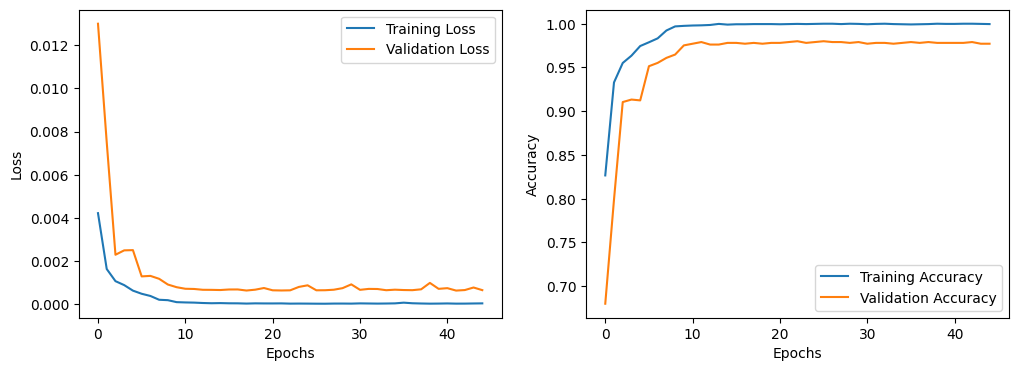

Saving resnet18_training_history.png
saved


In [13]:
# Model training routine 
if retrain:
    # Train the model
    model_ft = classifier.train_model(model_name, model_ft, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, dataset_sizes, device, num_epochs=num_epochs)
elif load_model:
    # Load weights
    checkpoint = torch.load(load_model)
    model_name = checkpoint['model_name']
    num_classes = checkpoint['num_classes']
    model_state_dict = checkpoint['state_dict']
    class_labels = checkpoint['class_labels']
    model_ft.load_state_dict(model_state_dict)
else:
    print("No model found")

## save weights

In [14]:
if save_model:
    classifier.save_model(f'{model_name}', model_name, model_ft.state_dict(), dataset.get_classes_names())

model saved


# Evaluation

**F1 Score for Multiclass Classification:**

The F1 Score is a versatile metric that extends to multiclass classification tasks, providing a single value that balances precision and recall for each class. It is calculated using the following formula:

$$
F1 = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

- **Precision:** Precision for a particular class measures the ability of the model to correctly identify instances of that class among all instances it identified as that class. It highlights the avoidance of false positives.

  $$
  \text{Precision} = \frac{\text{True Positives for the Class}}{\text{True Positives for the Class} + \text{False Positives for the Class}}
  $$

- **Recall:** Recall for a particular class assesses the model's capacity to capture all instances of that class, minimizing false negatives.

  $$
  \text{Recall} = \frac{\text{True Positives for the Class}}{\text{True Positives for the Class} + \text{False Negatives for the Class}}
  $$

- **F1 Score for Each Class:** In multiclass classification, an F1 Score is computed for each class. These individual F1 Scores consider the precision and recall specifically for that class.

- **Micro-Averaging and Macro-Averaging:** To obtain an overall F1 Score for the multiclass classification problem, you can use either micro-averaging (aggregating counts across all classes) or macro-averaging (calculating an unweighted average of F1 Scores for individual classes).

- **Balanced Performance:** The F1 Score serves as a valuable measure for balancing precision and recall across multiple classes, helping to find a trade-off between false positives and false negatives in a multiclass setting.

- **Range:** The F1 Score ranges from 0 to 1, with 1 indicating perfect precision and recall, and 0 indicating the worst performance across all classes.

In summary, the F1 Score is a versatile metric that can be applied to multiclass classification problems. It provides insights into the model's ability to balance precision and recall for each class while offering an overall assessment of performance across all classes.


**Recall (Sensitivity or True Positive Rate):**

- Measures the proportion of relevant items for a specific class that were correctly identified by a model or system.
- Answers: `Of all relevant items of this class, how many were correctly identified?`
- Formula:
$$
\text{Recall} = \frac{\text{True Positives for the Class}}{\text{True Positives for the Class} + \text{False Negatives for the Class}}
$$
- High Recall captures most relevant items for a specific class but may lead to more false positives for that class.

**Precision:**

- Measures the proportion of items correctly identified as relevant for a specific class out of all items marked as relevant for that class by a model or system.
- Answers: `Of items marked as relevant for this class, how many are truly relevant for this class?`
- Formula:
$$
\text{Precision} = \frac{\text{True Positives for the Class}}{\text{True Positives for the Class} + \text{False Positives for the Class}}
$$
- High Precision correctly identifies relevant items for a specific class but may miss some relevant items for that class, which can lead to lower Recall for that class.

**F1 Score:**

- The F1 Score is a comprehensive metric for multiclass classification that balances both Precision and Recall. It provides a single value that represents the harmonic mean of Precision and Recall for each class.
- Formula:
$$
F1 = \frac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$
- The F1 Score for each class considers the Precision and Recall specifically for that class and helps in assessing the balance between false positives and false negatives across multiple classes.

This modified explanation includes information about Recall, Precision, and the F1 Score, along with LaTeX formulas, within the context of multiclass classification.


**Confusion Matrix for Multiclass:**

- The Confusion Matrix assesses multiclass classification model performance.
- It visualizes true positives, true negatives, false positives, and false negatives for each class.
- The matrix helps in understanding where the model makes correct and incorrect predictions for each class.

**Breakdown:**

1. **Rows and Columns:** Rows represent actual classes, columns represent predicted classes.

2. **Diagonal Elements:** Diagonal numbers are true positives (correctly classified).

3. **Off-Diagonal Elements:** Values outside the diagonal show incorrect classifications.

   -  In the `X` row and `Y` column, `N` instances were misclassified as `Y`.

4. **Interpreting Errors:** The Confusion Matrix reveals classes that tend to be confused with one another. For example, if in cell `[i,j]`, the model is prone to confusing `Class i` with `Class j`.




Evaluation Progress: 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]


Evaluation Loss: 0.0952
Evaluation Accuracy: 96.67


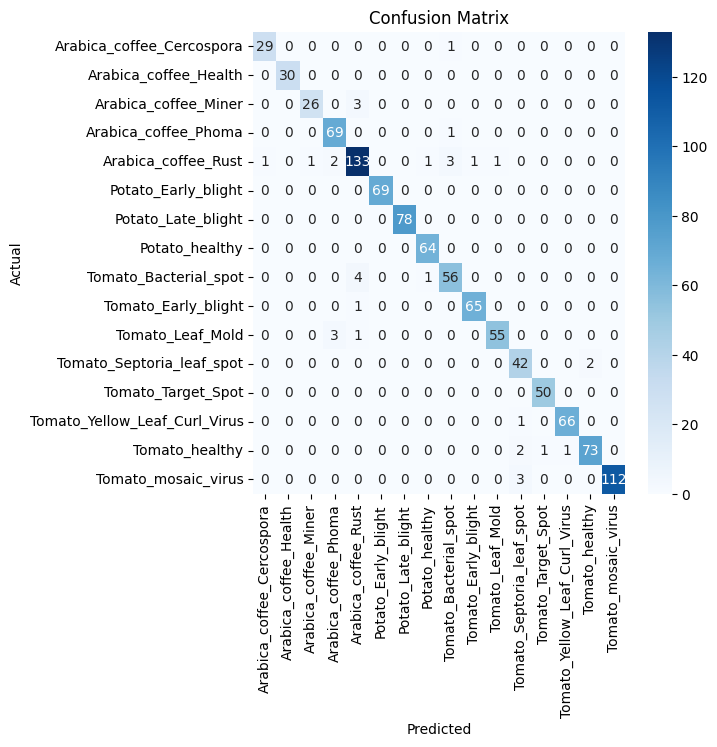

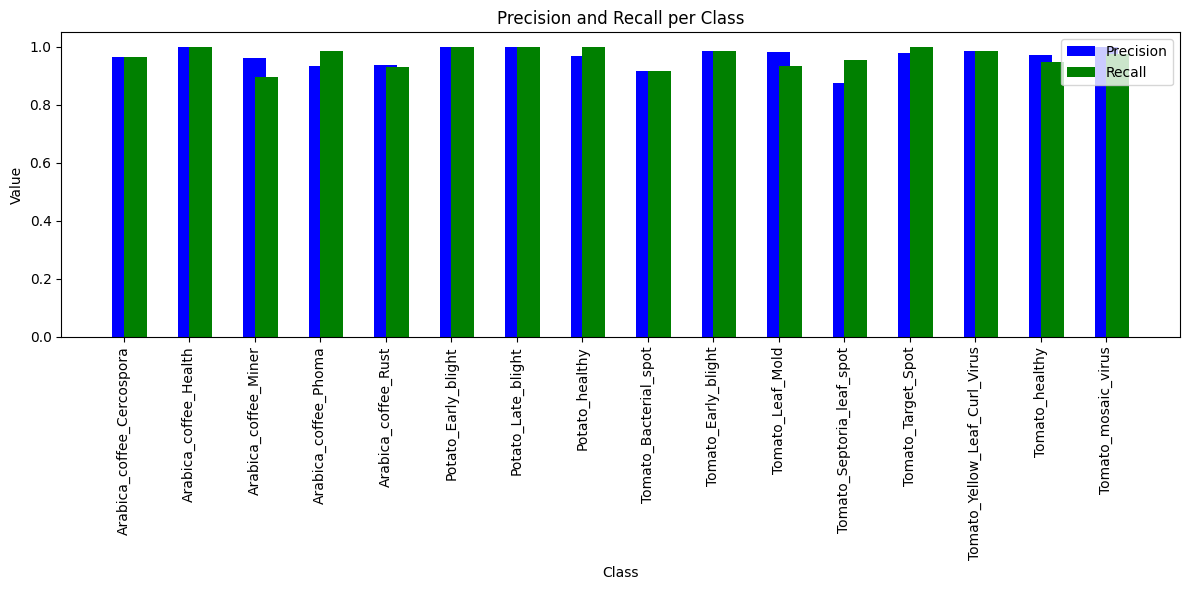

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


                            Class  Precision    Recall
0       Arabica_coffee_Cercospora   0.966667  0.966667
1           Arabica_coffee_Health   1.000000  1.000000
2            Arabica_coffee_Miner   0.962963  0.896552
3            Arabica_coffee_Phoma   0.932432  0.985714
4             Arabica_coffee_Rust   0.936620  0.930070
5             Potato_Early_blight   1.000000  1.000000
6              Potato_Late_blight   1.000000  1.000000
7                  Potato_healthy   0.969697  1.000000
8           Tomato_Bacterial_spot   0.918033  0.918033
9             Tomato_Early_blight   0.984848  0.984848
10               Tomato_Leaf_Mold   0.982143  0.932203
11      Tomato_Septoria_leaf_spot   0.875000  0.954545
12             Tomato_Target_Spot   0.980392  1.000000
13  Tomato_Yellow_Leaf_Curl_Virus   0.985075  0.985075
14                 Tomato_healthy   0.973333  0.948052
15            Tomato_mosaic_virus   1.000000  0.973913


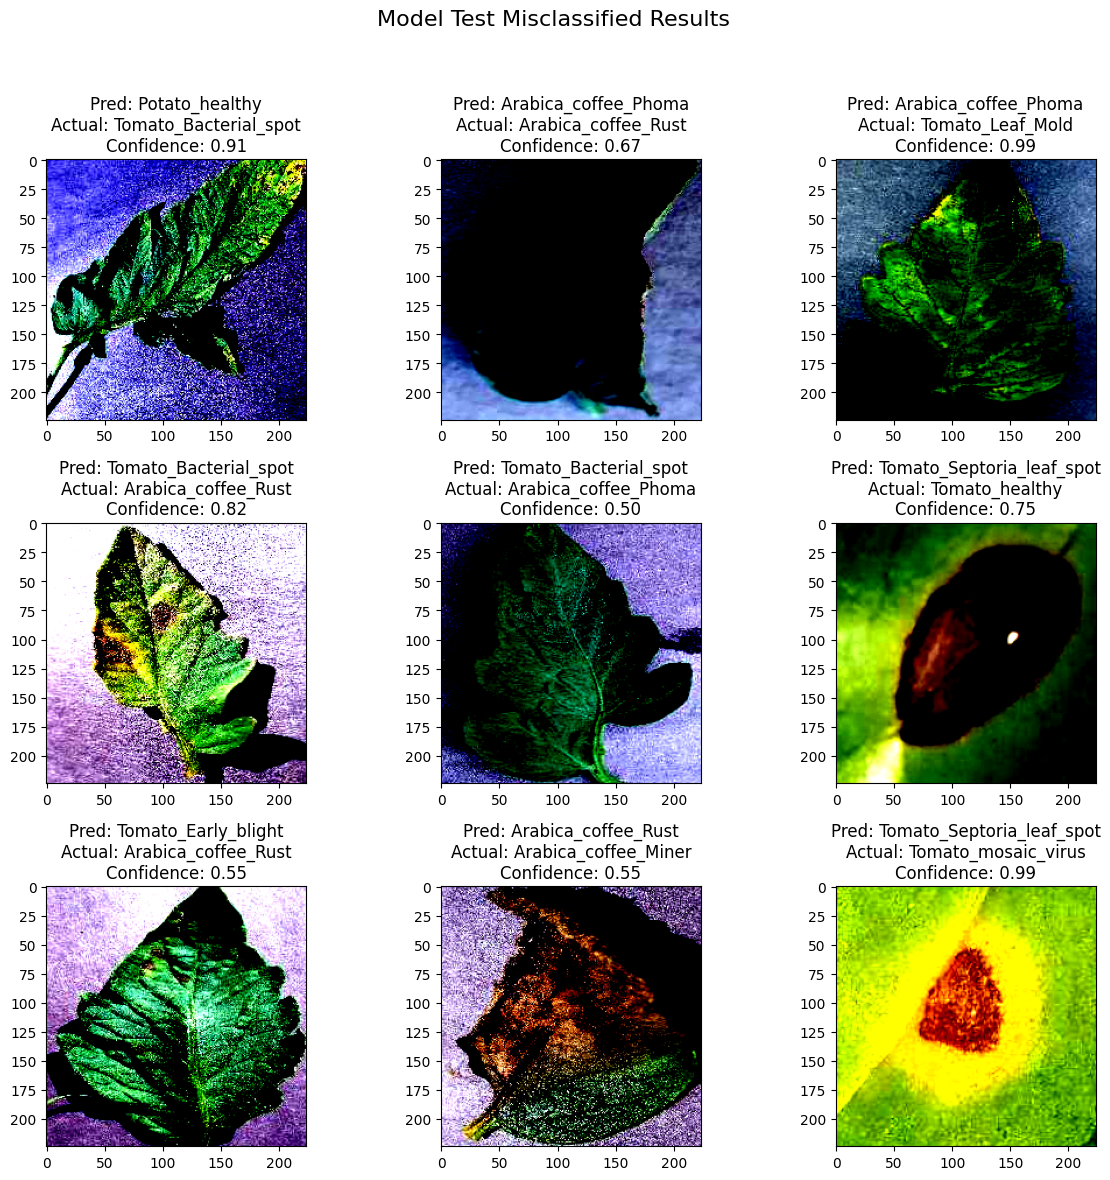

In [15]:
if eveluate:
    classifier.evaluate_model_with_limited_misclassified(model_ft, dataloaders['test'], criterion, device, list(dataset.get_classes_names().values()))

# Predict specific image

In [16]:
image_path = os.path.join(PROJECT_PATH, 'add_classes', 'Sunflower_Gray_mold', 'grayMold(1).jpeg')

In [17]:
classifier.predict_single_image(model_ft, image_path, device, dataset.get_classes_names())

Predicted Label: Tomato_Early_blight, Confidence: 0.994640588760376


('Tomato_Early_blight', 0.994640588760376)

# Continual Learning - Add new classes

466 samples in the new dataset
Adding Sunflower_Downy_mildew to dataset
Adding Sunflower_Gray_mold to dataset
Adding Sunflower_Health_Leaf to dataset
Adding Sunflower_Leaf_scars to dataset
4 new classes added to the dataset
Epoch 0/44
----------


100%|██████████| 82/82 [01:42<00:00,  1.25s/it]


train Loss: 0.0110 Acc: 0.8283


100%|██████████| 18/18 [00:21<00:00,  1.17s/it]


valid Loss: 0.0055 Acc: 0.8893

Epoch 1/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.24s/it]


train Loss: 0.0047 Acc: 0.9109


100%|██████████| 18/18 [00:20<00:00,  1.17s/it]


valid Loss: 0.0057 Acc: 0.9098

Epoch 2/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.24s/it]


train Loss: 0.0045 Acc: 0.9197


100%|██████████| 18/18 [00:21<00:00,  1.19s/it]


valid Loss: 0.0107 Acc: 0.8473

Epoch 3/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.23s/it]


train Loss: 0.0049 Acc: 0.9130


100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


valid Loss: 0.0074 Acc: 0.8839

Epoch 4/44
----------


100%|██████████| 82/82 [01:40<00:00,  1.23s/it]


train Loss: 0.0039 Acc: 0.9340


100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


valid Loss: 0.0076 Acc: 0.8839

Epoch 5/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.23s/it]


train Loss: 0.0045 Acc: 0.9256


100%|██████████| 18/18 [00:21<00:00,  1.18s/it]


valid Loss: 0.0113 Acc: 0.8536

Epoch 6/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.23s/it]


train Loss: 0.0017 Acc: 0.9669


100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


valid Loss: 0.0028 Acc: 0.9509

Epoch 7/44
----------


100%|██████████| 82/82 [01:39<00:00,  1.22s/it]


train Loss: 0.0010 Acc: 0.9776


100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


valid Loss: 0.0030 Acc: 0.9527

Epoch 8/44
----------


100%|██████████| 82/82 [01:40<00:00,  1.23s/it]


train Loss: 0.0014 Acc: 0.9738


100%|██████████| 18/18 [00:21<00:00,  1.17s/it]


valid Loss: 0.0038 Acc: 0.9384

Epoch 9/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.23s/it]


train Loss: 0.0010 Acc: 0.9790


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


valid Loss: 0.0055 Acc: 0.9161

Epoch 10/44
----------


100%|██████████| 82/82 [01:42<00:00,  1.24s/it]


train Loss: 0.0017 Acc: 0.9656


100%|██████████| 18/18 [00:21<00:00,  1.17s/it]


valid Loss: 0.0081 Acc: 0.9018

Epoch 11/44
----------


100%|██████████| 82/82 [01:40<00:00,  1.22s/it]


train Loss: 0.0020 Acc: 0.9644


100%|██████████| 18/18 [00:21<00:00,  1.18s/it]


valid Loss: 0.0048 Acc: 0.9286

Epoch 12/44
----------


100%|██████████| 82/82 [01:40<00:00,  1.23s/it]


train Loss: 0.0019 Acc: 0.9623


100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


valid Loss: 0.0079 Acc: 0.9000

Epoch 13/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.23s/it]


train Loss: 0.0011 Acc: 0.9797


100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


valid Loss: 0.0039 Acc: 0.9312

Epoch 14/44
----------


100%|██████████| 82/82 [01:40<00:00,  1.23s/it]


train Loss: 0.0007 Acc: 0.9876


100%|██████████| 18/18 [00:21<00:00,  1.17s/it]


valid Loss: 0.0032 Acc: 0.9464

Epoch 15/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.24s/it]


train Loss: 0.0008 Acc: 0.9855


100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


valid Loss: 0.0153 Acc: 0.8616

Epoch 16/44
----------


100%|██████████| 82/82 [01:40<00:00,  1.22s/it]


train Loss: 0.0062 Acc: 0.9287


100%|██████████| 18/18 [00:20<00:00,  1.17s/it]


valid Loss: 0.0544 Acc: 0.7080

Epoch 17/44
----------


100%|██████████| 82/82 [01:40<00:00,  1.23s/it]


train Loss: 0.0135 Acc: 0.8566


100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


valid Loss: 0.0327 Acc: 0.7696

Epoch 18/44
----------


100%|██████████| 82/82 [01:40<00:00,  1.23s/it]


train Loss: 0.0053 Acc: 0.9245


100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


valid Loss: 0.0062 Acc: 0.9071

Epoch 19/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.23s/it]


train Loss: 0.0016 Acc: 0.9736


100%|██████████| 18/18 [00:21<00:00,  1.17s/it]


valid Loss: 0.0032 Acc: 0.9518

Epoch 20/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.23s/it]


train Loss: 0.0006 Acc: 0.9899


100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


valid Loss: 0.0032 Acc: 0.9598

Epoch 21/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.24s/it]


train Loss: 0.0003 Acc: 0.9933


100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


valid Loss: 0.0028 Acc: 0.9607

Epoch 22/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.24s/it]


train Loss: 0.0003 Acc: 0.9931


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


valid Loss: 0.0031 Acc: 0.9580

Epoch 23/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.23s/it]


train Loss: 0.0002 Acc: 0.9956


100%|██████████| 18/18 [00:21<00:00,  1.18s/it]


valid Loss: 0.0028 Acc: 0.9598

Epoch 24/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.23s/it]


train Loss: 0.0003 Acc: 0.9941


100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


valid Loss: 0.0038 Acc: 0.9491

Epoch 25/44
----------


100%|██████████| 82/82 [01:39<00:00,  1.22s/it]


train Loss: 0.0002 Acc: 0.9973


100%|██████████| 18/18 [00:20<00:00,  1.17s/it]


valid Loss: 0.0034 Acc: 0.9491

Epoch 26/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.23s/it]


train Loss: 0.0004 Acc: 0.9939


100%|██████████| 18/18 [00:21<00:00,  1.18s/it]


valid Loss: 0.0050 Acc: 0.9357

Epoch 27/44
----------


100%|██████████| 82/82 [01:40<00:00,  1.22s/it]


train Loss: 0.0024 Acc: 0.9675


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


valid Loss: 0.0110 Acc: 0.8884

Epoch 28/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.24s/it]


train Loss: 0.0012 Acc: 0.9792


100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


valid Loss: 0.0039 Acc: 0.9455

Epoch 29/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.24s/it]


train Loss: 0.0010 Acc: 0.9851


100%|██████████| 18/18 [00:21<00:00,  1.17s/it]


valid Loss: 0.0053 Acc: 0.9429

Epoch 30/44
----------


100%|██████████| 82/82 [01:42<00:00,  1.25s/it]


train Loss: 0.0010 Acc: 0.9803


100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


valid Loss: 0.0030 Acc: 0.9455

Epoch 31/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.24s/it]


train Loss: 0.0007 Acc: 0.9870


100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


valid Loss: 0.0058 Acc: 0.9339

Epoch 32/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.24s/it]


train Loss: 0.0004 Acc: 0.9929


100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


valid Loss: 0.0069 Acc: 0.9438

Epoch 33/44
----------


100%|██████████| 82/82 [01:40<00:00,  1.23s/it]


train Loss: 0.0004 Acc: 0.9925


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


valid Loss: 0.0043 Acc: 0.9500

Epoch 34/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.24s/it]


train Loss: 0.0002 Acc: 0.9952


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


valid Loss: 0.0054 Acc: 0.9446

Epoch 35/44
----------


100%|██████████| 82/82 [01:39<00:00,  1.22s/it]


train Loss: 0.0005 Acc: 0.9912


100%|██████████| 18/18 [00:21<00:00,  1.22s/it]


valid Loss: 0.0072 Acc: 0.9232

Epoch 36/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.24s/it]


train Loss: 0.0009 Acc: 0.9855


100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


valid Loss: 0.0076 Acc: 0.9152

Epoch 37/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.24s/it]


train Loss: 0.0004 Acc: 0.9918


100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


valid Loss: 0.0040 Acc: 0.9446

Epoch 38/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.23s/it]


train Loss: 0.0002 Acc: 0.9946


100%|██████████| 18/18 [00:21<00:00,  1.19s/it]


valid Loss: 0.0043 Acc: 0.9554

Epoch 39/44
----------


100%|██████████| 82/82 [01:40<00:00,  1.23s/it]


train Loss: 0.0002 Acc: 0.9962


100%|██████████| 18/18 [00:21<00:00,  1.19s/it]


valid Loss: 0.0040 Acc: 0.9527

Epoch 40/44
----------


100%|██████████| 82/82 [01:40<00:00,  1.22s/it]


train Loss: 0.0003 Acc: 0.9945


100%|██████████| 18/18 [00:20<00:00,  1.13s/it]


valid Loss: 0.0055 Acc: 0.9393

Epoch 41/44
----------


100%|██████████| 82/82 [01:40<00:00,  1.22s/it]


train Loss: 0.0005 Acc: 0.9902


100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


valid Loss: 0.0054 Acc: 0.9393

Epoch 42/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.24s/it]


train Loss: 0.0004 Acc: 0.9929


100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


valid Loss: 0.0033 Acc: 0.9473

Epoch 43/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.24s/it]


train Loss: 0.0001 Acc: 0.9981


100%|██████████| 18/18 [00:21<00:00,  1.18s/it]


valid Loss: 0.0035 Acc: 0.9500

Epoch 44/44
----------


100%|██████████| 82/82 [01:41<00:00,  1.24s/it]


train Loss: 0.0000 Acc: 0.9994


100%|██████████| 18/18 [00:21<00:00,  1.17s/it]


valid Loss: 0.0041 Acc: 0.9438

Training complete in 91m 37s
Best val Acc: 0.960714


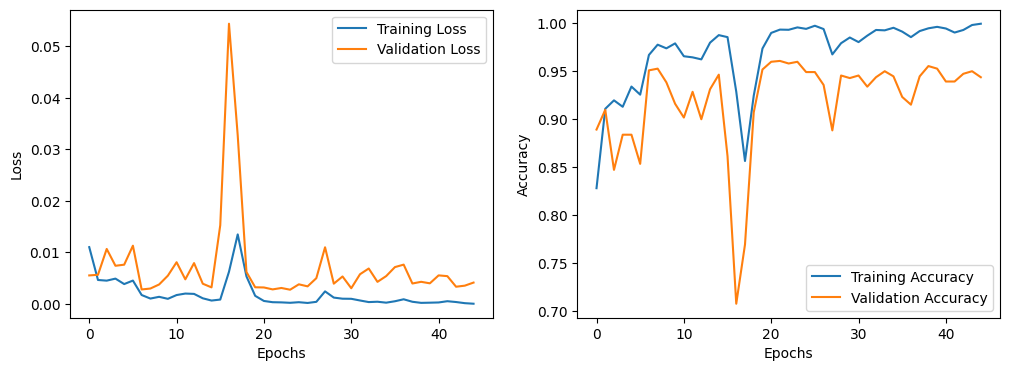

Saving resnet18_training_history.png
saved


In [18]:
if add_classes_dir:
    new__model, new_dls, new_dataset, num_new_classes =classifier.add_new_classes_to_pretrained_model(model_name, dataset, model_ft, add_classes_dir, criterion, transform,
                                                                                                        scheduler=exp_lr_scheduler,
                                                                                                        learning_rate_first_layers=learning_rate_first_layers,
                                                                                                        learning_rate_final_layer=learning_rate_final_layer,
                                                                                                        num_epochs=num_epochs)


Evaluation Progress: 100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


Evaluation Loss: 0.1664
Evaluation Accuracy: 96.08


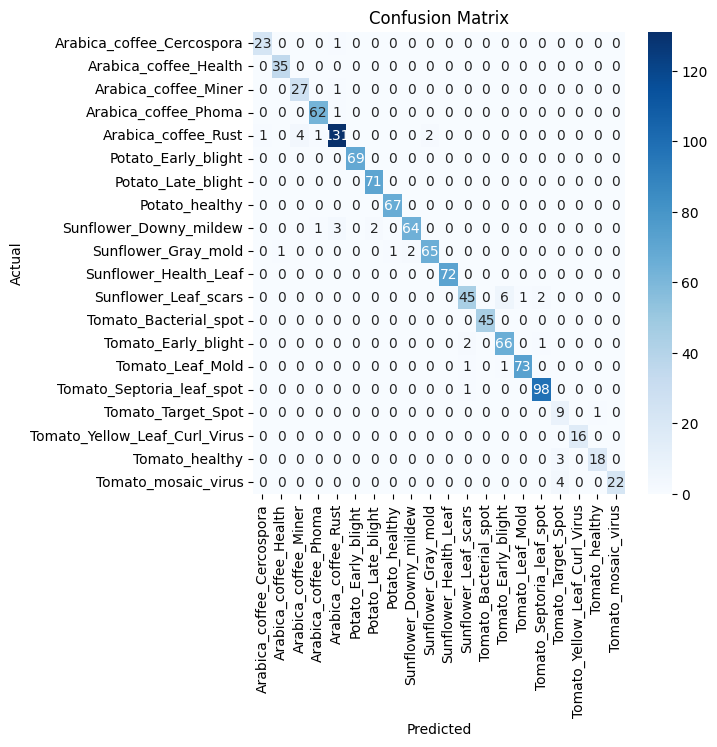

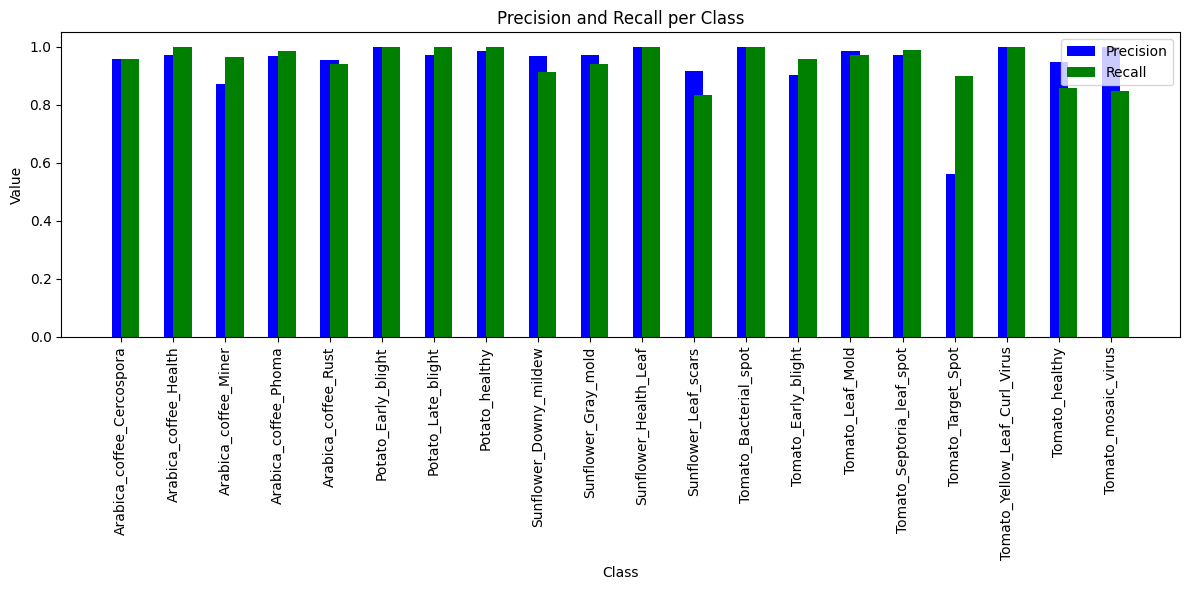

                            Class  Precision    Recall
0       Arabica_coffee_Cercospora   0.958333  0.958333
1           Arabica_coffee_Health   0.972222  1.000000
2            Arabica_coffee_Miner   0.870968  0.964286
3            Arabica_coffee_Phoma   0.968750  0.984127
4             Arabica_coffee_Rust   0.956204  0.942446
5             Potato_Early_blight   1.000000  1.000000
6              Potato_Late_blight   0.972603  1.000000
7                  Potato_healthy   0.985294  1.000000
8          Sunflower_Downy_mildew   0.969697  0.914286
9             Sunflower_Gray_mold   0.970149  0.942029
10          Sunflower_Health_Leaf   1.000000  1.000000
11           Sunflower_Leaf_scars   0.918367  0.833333
12          Tomato_Bacterial_spot   1.000000  1.000000
13            Tomato_Early_blight   0.904110  0.956522
14               Tomato_Leaf_Mold   0.986486  0.973333
15      Tomato_Septoria_leaf_spot   0.970297  0.989899
16             Tomato_Target_Spot   0.562500  0.900000
17  Tomato

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


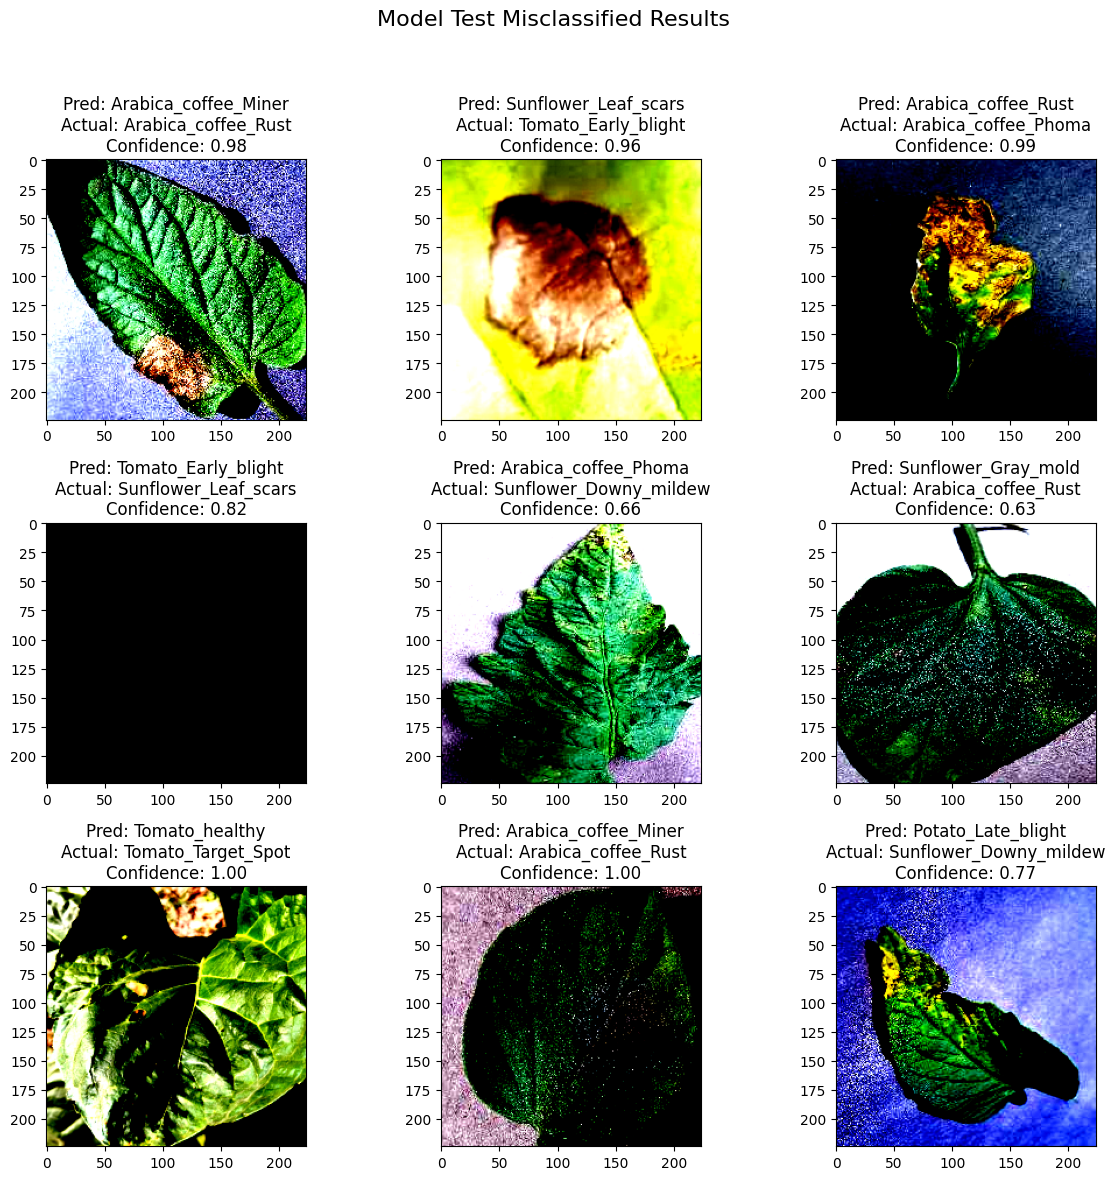

model saved
Predicted Label: Sunflower_Gray_mold, Confidence: 0.9999666213989258


In [19]:
if add_classes_dir:
    if eveluate:
        classifier.evaluate_model_with_limited_misclassified(new__model, new_dls['test'], criterion, device, list(new_dataset.get_classes_names().values()))
    if save_model:
        classifier.save_model(f'{model_name}_new', model_name, new__model.state_dict(), new_dataset.get_classes_names())
    image_path = os.path.join(PROJECT_PATH, 'add_classes', 'Sunflower_Gray_mold', 'grayMold(1).jpeg')
    classifier.predict_single_image(new__model, image_path, device, new_dataset.get_classes_names())

    

## define images

In [85]:
image_path = os.path.join(PROJECT_PATH, 'add_classes', 'Sunflower_Gray_mold', 'grayMold(1).jpeg')
image_url = 'https://www.armuro.com/en/wp-content/uploads/sites/6/2022/02/gray-mold-of-sunflower.jpg'

image_base64 = None

#inside an if statement so I can collapse it in the notebook
if True:
    image_base64 = '/9j/4AAQSkZJRgABAQEASABIAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wgARCAGQAuQDASIAAhEBAxEB/8QAGwAAAwEBAQEBAAAAAAAAAAAABAMFAgEABgf/xAAYAQADAQEAAAAAAAAAAAAAAAABAgADBP/aAAwDAQACEAMQAAABmJxvBeLz6iSQtBhiRumfgjtcvwjM4z2AAK5Q04WTNg1a8N6Iwl+MxRruGdo/eyumnrJS3vQ2ag6DJBZqRbOOloyTwy3njtWWpqzceKdXct8JGu7pIjjohkmSo90vZXXUkiKXpJOwMNqjOLELElsyIXYrQvUmJC6SQQWnZcuClaxJz2fEscggGnHL4CN4gVlb1JgPk2ZzEIjmUX2XYrfsPAD8zxMg4M3RfCmix0aB5T3HkEvNn1DYpgaUlrXtKmG48D54goiWSfOJdiwq4eYD9sd2Hpy6RXwTwZzso2XOUKcqT81uFpJT1tBDu6iY+kgVIhTvowy0iwG6XJQJJAbdsBRTCJBQI7kq8eQ1xqHCrKDZXnjqhUmHIOnjJpIHc+Gor2WBdcyhj0OpPkR5/Ic4QoMpLSpSGFSw+j5nmBA5ceqWEeAIzrkV9VkDR4NRbPs+UfNsXnqjTolNWGRQ4BgStNmJqyLgMXDvBXFd3nN2jJNBZIkvGpPpEvSs0wWkzbYYoa8ADAtoMDNImam86aehO3FGtPqRe4z1lNpTnzN49JBLgMh3TzphTQQmNMWnTiwTyhDM9Fo6izIAetrBPtoONEIaZ7i1FiO0VtfUFCSkj8aA5i+AGgM0bSPpYlTFlckFb7hODUFqNTqoxfup5EHyyEgb4k2DCgtTZWUiNPUncGeG8gB4Vvczmv4Y1184PFGoxVE2pnxpTSWoEbDrQTtiw1dZO1SXW+ctiTDpDOSvIQ7m0RmZ66T4XRJ0r6TLjrObR5a63DDkCvDZLHZAzQzmQPvewDAsx45KWdSyEcDFLMgwGQ/jr40WnDYh2kaMzDbPaWsU6X0lmmoO5BWiuBccI6KfraofXyaTEPzqqMtk6jR7Q7m7WJmGLLx37JCzNUAyRyxKMoLOdi1BQEzWp1Z+87wMoxTXuUIxJcwnIYNKIfxYfhALKVoWiGHMnUMzne+kUXRmS62TDUfRQ6m3eId3ujPDJQHfPJ4Jbk9dXJwlWJ8Gyu+GmslzUqsL2hgyHE44KjN2FFp0+lRZQB8efJ/VzoIwMZPt2dVt+HQ2DTmEAhirAr5ywOSzAcr3JpSB8GLVRPexX1LATcx80D9BMelMFboK2prw1rquqQRtbGZCsLjjnUmMyCQrETaQ5JO1iyFeE8RQDLCmB4RvQkUQCQ2CFErJmnrC6M8UryDH+QDbolG+eC+xkMpMkkicZp3htKRS3os7VrDCX4wcQAtGQytyL4hnMAkFJwXAw0LKaN4Hgg7AKitHCTImvCoqzFrVRjBMUG2DcpjlsmIcndEY4CViHy7hBaObV5uSEFKB4T1ZYLSZR1aETKxVj01tSLuK+I5STpcwSIWoEDoj6jPLVFgEZoQ4LUpag8zEkTzQeqN2AH47xgHqpGHtGyC6hOuFlvBjLOlHKCOkdRg0ECPaz50LKhyYief1tBWdUHL8J5TUTgbTJYOhXzT5CSCgdKr3NeI4SkkHuKWFcTZmaFGp7ITQcxWHZvdIYQuswqQkJFgI8nTltBaUD0ToQtNg/e2BhPM6IZjuG1oWbLUrfLFhaExpSiXYHwFqG8mKBUMQ51hui3Me3A9kweU7gD1CxSZ7WzBjwRF64zH5RtFJ97x07zyYOQbkAls9NX4Ryy3GqLo9WikpizPOwBsx9ED8mMa/E5M5ekht4UIQcV85QWHHIn64txx9IwzFNw+zUb6AlCOWLQyDKJGoGeyVQE7OvGyrfIaxpJpuG5DPQ/KuhZTKl5oIK8PMDFwodpBmeEkB+L+djwLCCmKxTk0aRJardndWeb7H5w49BFG05mAOSwlRATJc+NYBLqSTAXwqsUlpY5xExmtE571yr3x/p4Zw5RHipFNYdrtAhv5rQGmAZmoRqcoz5d4dab32mbVCcaHNBK0IHS06Iyc0UqhonSpA5BoM3TDxS22qSsjB80HZamxmlz/qWUWVRmApPEJqunLqGappvLaup+k7m8xLkc02azMzWDkaphitFek+7T3xY0KkAynQnTAp+tnbKFJx4XsE7lPqAi5o0Wp86QfrDmaYMYIV3TkYorgpwCE0p1JMQSWz3eEfW1MKF+D9JpqGjQ/PjEWeZo8tH2YM550YpZWDJ9EtAOjOxXIZpVNgk5Xz52XSSUNdqJgxJAgdYQqm/KsZP2ys3FmkjEgIgFztg2HwzQWzOIDIEK6rDeJ7BVWWcw8l45GG7zXzwZ8102wRdUFCLojaC6LKmnI5Q2TFaRbeNlqWMJ5poZCNMhlu0+QxPXBsb35LhVSemYU4vZE+zKa9blkiBgQicsBCCOBWA9EMW0IuZ3s9DNSxAneX6zdclUy/rk6mo50tEJR3V1IyYLNQWNpHFzp5fU4nQ029RkcK2gHyzECACO6+cVRlzbKBS89asf8AKPxf6rXzOo/QTRNkxO3G6pnvFg885atxb8FcZzMj9MnfnTXPMqD899T80ycU3RCPaUQwoE9T76qRdx0HPMIyeV8v9v8AMuRfE72ULGWgrHLEK+dg0rNqkIzLR/TVCldU+RpEksmxEsxRcoxdkfQI+dzAsbmXtF8YrksXXV5gR82VHn+dPpXoxzZk8XqchJgQskfPs3azgDWcS6bbLSS/ItSeznlzOz9U9fvBurdkGZx+SmtUjgIMn7AB0hLcLolN0awuhBGvI7OqZDj8+B7zHaR3ALKKVyhRRIFFkEZnpg430MgiaPZxUnFHLLM+niki+n989Wzc0gHSs6JSCIzQjo0C3qwrOVnxDni7KmjJo5hYNCOFICD1oNbXWg4bZqtGeOXENVCYZG1PdKAP33xmbZb7s6H81RHg/EesCsyyohP4heD0d720PcvxuwjfLWQHOcB2BwoPtXrWETTTaqI3gEYcwVlFZrAJ5Uernc8B6WYi4dvn8zRs00Mp1B2bB8sNdYfbXKkR/pvgTXJZFsGQ6qkPKphl6ZpbzzBcuoPATnSgyZP0qYfN6PGKlY5hGboq4jQYf6OGw+b5RyNZ2CUFUsGmulAQeuVuJSXgRfkvpY75DVCLK5xm0soQNvA11ASWKw4Ixjw16J9iq1vj/rvlEdLsbZk9NDhL8R5lvt8Pgvfb3BArmM0Mzy3qBAL87azRyXo0aYWx83QHRvLJLVHkZzChoZ4bK+4I7Ti5zJOeDSW6/wAvRRraklINm8frnr3uOnYlX46YNaWE16Y1fFmO410CAsAzSWZXreQYqvmvt/jfukHQrUzJooz57Bz5gj30tH5Nwf7CJO2DjTx2YbAuChDwChJrAcBrkCczf0ome+FQn52kMCh5hejVJNKczHxvofn1laDM0W9fkWueG+XsQGZJA5rxk4uTB/veNa6GTlnrGEsz3earRvY84fSiU0DmK0CP5GmJdMI86+n7kk8JhcK39CkG3oY+YXNiIIEM1j5l491HpW/mqOLfTuAwcqWZ/WiPm6MYkY0Y/N6lYUs599zui4GLUpgLcl3XjwJgftvk/s0D5psnEzZBUrUcJl0NY7uNrptnvAkeT6oQ9SM+R+ktRzOooo5YTCBzwNleZJghwOhxTl2WtMzjNqPyn2nz1BF8WV+y9xeInT7im0+dooLdOBmdAH9rxjJP0M4GU5OHSknpiGMWkwnCXhgmlxmRtekqIujcuJuOX7yaJQVGpx00o3vILa1HthbYBe6RMjnciaUC3NqXzFzIUA8Eyhyj3IZ1fxmZotXvox53GRPx3hoAhgTvmfRlmo3/AJq/gXR60RaLHsyd1GuA2Xu5I4mnM84RrrNFYsqzMdG6yxScYA/LY+V4MIYxKjnmbQnaBdubdaE9rKPfhXZ6QjBEWdubhZWwLMzaUGSTih6+Zr3k+ZBfaoB8oKHEtzMhRtpabuGj1vY59NH7gPcCBEtKliTRY7iF7z1apnqQbnDoWAtjKGuipgjrUBtLYtJn0XyzMmq823NjKU1yig2Zt0qeDbogi1IGlPvz2WFINmdAgCiATg6ZPC/azPnl5mtNF3pfQ1o5uHQKqrDI3jgOuVjE3jIbCK0QBVk1hfRzTx8X+fUVN1ysoclWfIrz2Xn1Pyn0zUzzFK1IdaQQ2zz2xzzmllilZZ91M8VOK9ojvm+VhWBOOZBQiqpYHKjLcZ2pxCHgKKE5E+VrhOM+w+hdwCsmwjXzUejiXC0ypdHJii0q/npDC+jBqRY6OD9QiIYgwzk+kp07YdKy1H1zCyDy/nepfWqg/QMkXBM3XOpkIonIhgtAyKsNk4v3iuqEw5XsFBPw6S5NA6HxjUK25y7EmvnqzJoiIC4pGmJScAq/hWuYEJduYXRBAvnb4rXgkGjQz1Rcso3zJMjHLD4LQ+A+1OKeb0vNwvY8x6bOfZuzKpTOE2gyrcd7koF5KtH2YgDpGshFyqimtqYuJWNh23vcao8Qzq7nEMmo/mJ3FQbKRGGrXTGYNZQ25yZuwyq2J5BHeNnlSqwNnFhp1OVvlowM9grndK0v5z6P5h8+e34jjVeFYpTbHP00LoTUX82GI705YvS6melZyy8HjD5j68xmRGPdQU2AxY+DUGxmzUCYWprYyiVkNY0LGXWktnsggAWkEiOp3hmKWFCFBve55ghYypCqUts9KVa6KEWt1GDC6VH9ZkHuJ5LDOSPGQLpxPBrii863nidAxUqiIgVFidYbj1ZPXYrGmJYMdClsv1I3XkAk9wVFahtdicPFR9P9nqeUG7XFjUMa0/BWTfLwL3z22LPc2bPN8qn9BJ+l5ug2Id8eoG+jDY+PO50wZT+ZKXRnz9ULRUe+lmHNtD5j7TIAdB9Q/mkkjDlpF1rDFA43AjEjaW62B+OGgI5KnRNT2hoNWEWBQ930ZyBNtzmD83TrERan6Dk1Sy38yzbkU5T6+2ScMwfWu53zz68iUzkagXLikYdi6EYyBVQPi9DTJGEa4PK8YZd/BE6wKSmm3iNIHhMl7YdJFeb6BDuc+6mbUyj9VP1z+mfxxBuHcyb5OBdjbZjt5kqZlbVa6bE5k5SMlhLonWJvGqCHvyDi+GAVrqX0+rinBhJ1eXTYJH4Ap+qbIPyOtBqzz2pHNG4F9dJZofmP0GM6Hrr1YZSWzmipFz2q5npvgU9zR0wAGqQ7TRSGkYp9lKM60pozIGY2X/O+W+nCj6UWhQmzdPi3mgkM9Tm40XEE3UKq9SykJ9LLoJ0b+e0sioopI3JUpRxh1w6jAGhH+uXTfztOKsa53NUnRkp0z+4IlnhqPO4xb5qTRnbKDQm3bMAP6CIJdIFhJ+hcZrVNhEh6fI7zFdBENeQEKTX3B7X0A8YqBacihajorALypNLO3SEnq9AMZ7pPpBFMQsccyK5rYtdOHtC1eDBP8j0A59NWiAubyid6cmSBccLmdQgl3gS6IG9g6a2FogoB2oIf5wXNqelHURPxohjpjCThtrVinhPBEY9DL9WBMWm1Z/zarG51eld9EEVddHaH1yJWaBMFpm4ZrTzWqO9sxb4mPbF3zjfVTaShU6jjOl8frUp3lhhB7U0hJgy6NQ5QPMd7BGmuh0iqHzKItfHtv1QYjF5uJRVGSUrE8wiaOOUJqqNsGKmewSrrInExJQStn34X1EEyH54JOUkl+tjnMDGn6ahLdhgskd4X6KLbg4ngxa9WFPD8x7Uh9q2MO5CEygqSdgvjjyuamd7iCaGQ9ge9oiInCfow0KlS7nT1rC0NIwpobI25QBgPBwhtIU1mtOxjNviDE1N1GbL8AQEWpBDXXnPbaDxohDGVtZPVIpgNCInisC3Sk38VB8LlVF4fV1YW/B+tzDkmfHCn8YzW6QH1XHUogqvOtnMXnmsud56XseS/N5ni/BR8UcBQ5Vic5NHDebI7U6Hz1kgj6bgJ9DNMn5Cb33t3ZhmReaNqLyxtqS9JMxA5wVZaaJ9D8k7dDrTtlW3XCNNx0lnAuQsUp1rJ4WrUmFDESuWW1slMyCpJpLqy3NpZcHRQ/DddnZRFb2mbAj/nGfCuMdfGZcGQ1OxF54ODzeVkVBSyEaWXxIXtuUUprAzBKJ+8/P8A6gAvBDQIU36EEmcwdZu4N5ZzsbWVIPmFzmpIUxY/uQy/e9D/xAArEAACAgICAgIBBAMAAwEAAAABAgADERIhBBMiMRAyFEEjQjMFIEMVJDT/2gAIAQEAAQUCYTYwnjiJxM8OOVbhq8zkSto1O066Gl7asun8IFlc7SavV2XEFwVvIrP2qkrbPBEZgALA66LFGBcxY1JiFoFJK+i3uc/Va8nARvkLAQI0zibSrk3StY45URjCDEGJ8AHdis5gDGCsYxpHcYrbNln4A8ivJ14aKMxpk5UFpZXiL8H6P1mFpV8nlTOBAeTAcTkxoqQrNY3yohEwJ5MQgwmLzDlYpOH+f2qsxLeYuAPOwh7G4usYhGNnXsBqiEdjrizWyvAVfe5kZn4WA7TGSNFKLlmJyy5CjMK4iDAcnNmTAOIgOWjQGft8wzAlK8Ee31px+64hQKrkkoCsLQGK05lnsMExE1e38E/IMuGbixpSY/0rYhG4PrDDDMwDJKxcCFotWY9eJnE+ZXVmeiqyhj8GCMIhhhTMUTbj9viDJOvBHImcStsqBlhQMMqrCeKA2vZR7LK2eizsVEQvvATOw9uqdN2mura6Rvy69SmXIKyH9vifv+KjmOvsVJAXEQYFmSSplZCOoTspbSayWzApJQaoDszjCQOcLXscpWrtmfvmN9VnkGfv/ZQC1uNMRPkxwIph5mIw4R5dxN5nJMVOPgtOc115G2kL7SutCL0CRLozZgf6LTMLRXgBMwYoiYM4BsHKvieYkkzbkzrDKMQreZjA8AlTYgl3WLFRirXx2V2e/a1KrfLb6RDs4M6i4PYVt/iJ7yr8TYSUProGnjzPBgsdIr7QzTMpDVqwJD9dJsKoHDVrwXyw0rRc1xjgjBDDEyIRy/wnwogczk/QzuyHX4CvyDkv9DiA5lgbFTYawqwKZgrhWAwiMplSABSALWG/9a9iXrJXGrBoDyDmOOBCpiVHOdRvCSJW2IHy7fiUgBBxgNKhuqJqlmSUGPobQWgCm3/6LCgnYREXrIjJVQu1lxVBFQZHwyZlFL139rDQrmKNZXbqxxFGVLaQPsxMtAKePxwKLBWmoraZlZyO31xYEpHifWmP2GY7ExbGi4EV4/P0eAxzFgggz9KB5LD/ABluFHIxLDgJkwtiIebbBrWNp4GeMhSbQ5gacmZOUGYfgqdkGR+Be/gtzsIOTAuwdNCWlBBF5WZmdvoHDBi0bgLq0deCJV6n/wAW+D+RUYm4yzcVsEYfzS+tKyVSOisOx/G6nhFyzw8MCHrFW7Xpq/ZyPqiyzFO1x7bNmu41lXFif2PsDWUnUK3Tsp4GD5QPgtfLL8Qksfqqq1jVW6WWhdMuV2VZ5Nh48wLqMwvyHhEDjLW+vzFAUGz2yWiHllixiJXzK/Sq789MwrNJtrF9j+IrXaX+pW0g75hEInyVGIx4SwiZzGEBx9bQ9ciBDDXiK+IOvZalPTzG6+D2OqtQxlicJYOa20nl2ictYOa+Cbixs624pK0tsBLK6rH+GQaqPkg5W0LWjI0elGnZpdm1OU9Z8t2B5bFplPqDPgLUMVqu15BX9Ou5o1Zxia7SwjC0Iq6LNofZaU8fWsUwAtMayg5hGYwxNfaftrqcbA1lRmY5WHiKcw5jAyttTWQK7q2Y4aETOIVLSv1mcykcdsYKjP0SZnhTickEmL9M0WbCYzFtzD9BOepaGRsCWOQ1/YJPXAMf2YIGe6kBVXEqHBBJTHl8NbRUZZf+S/4jUylU9rvimz2FnAO0y03MLfWZxnQTBUuTttNQ03zFbED71C3asW8su4Oa2WrMOBPJERjEqInb7BdxvbMBCieUrMQ171hxMiBSSSBFeF9oV58RiALGYGKvGMRzEGWV2109HtUR2zEGTsoFYBjgSk6y8bzTEXEdAQ6YgHKnhlOVhHDxQceOD4r/ADfOE5irmWbVGvtM0svwrlmIZgiNgluS7GAxBhdiYo5qZVnYBdR1BpT6xm0Di1ivXYxKEQnBU5Qh9pghyBFwZjB2mfbaP+KnjyAVrkzPIbnyfzIfrvmV3bRQYh5BOWO07Fel+uJgu2kyBNeVXENS5sUJAX1rIdtMQNiJzCyKFdrCyGfAlkoDA/yIo/jruGz5hbEVsxWwEOxRebhiOYpy22B+Ub1gfE3zF+bNpn2T4xmYlQ97YpwRfif5FC6u/wAiPCsTJPj1VxzXkoE1m2YTKrOfGFqa4bK3qVbUmCHmHIgh5XcbGK0sOJ5MQnaW2DLejZyq5AInszeILBxDaFnYuFq9YKsHsQpEyFTidqnyrQxdB9A5K/ihOP6WL/GXsWAwtsFqaZUSwZnWOIylpZZ7p+Lsk3bPW7G07Ghr8CXN3KFpjRJmVkqanl5wC+Yoj/CtiMcxhA+IjQ2QDZmOB5TPI0VAgefvjJr4lieuuYtfqaSyCVpiN7A/KcBksMRfRlIm53FP8f6Vt/0p0UWgFbXb9FbkIap+wTIOYyCNZgbcBszbVvJqXMwzGitgW9YXyKyFBsyfJmF11qy/aypimb+zPEOY031t3g5gOs/ZWxAY3xeAbqupXj1RWJMIO7jWdXiNhg6iBd2KrCBOvR73HArLE9tSzuNio51wGaUSw5GmSqaq5jmDk4GMLCAJ8xRGmuZpLHE5M1irNSIjFl5BYlVS1gdNn1xBWCD1xNdZ+pICutk2Ba2hd0DK2eVbjcS5fJVXbMZnxGbMawRrsgqpKllAPtaV0zMmUhiEOkdzN+A8LNtmBywpVliKTMYRMl2U7oJ3bvGP3VZmIpL4i8/XasK1Upu8B4PMOFn5MnA2jmCkqLAROSerd4owBDXKq2D+EIEVFyWgGWTiWtKdiWZjGBhEPztwWmSZgxDCsrxGXkfKgtB07SU6qqlgGVfQs4JJ2XOHawTfMOZs03OS+TuUYXIqB9lY4nBmpE9pn6rPo5wWaWcIW9tgWJUg8HP2j6wIca5PjxAmAaxjSU1ZjY2Tk5zNsH5igZ77s3ZT8xAONjPyi8S3sV0x7G7LogReZmHaeMmCsTBhwIGGyWBpecwnEGWKXPjwMHsYlbiCdofhIG5bk14UbrGYE4GGxGaDmBOGOIH58nCtNjHYJOlYkbsLi3txSWfx5j1AIp9WJ2qUQorw1GOhEX5x7FMxB6bYX0h1nAhabchhFsxHbm04G3J4Oef3P2OYtLtBWUqRffXJ1jgmDrGV0WCN19l8DwdZsnr8mrU7kTsB75TX7zMBAXyATyHQDewKFKKSNCYyssX49oAZdZ4p5WmxiMxmLzY9T2EUaQN/KKVpHb7OWSvIx7E4g+K+S/BLcHaciDJjrwYgmOHHKrM4gOTDVzrguz4T5URWGXI1P5hREHsqhgdo1hmcTz+yuNWYPNZnADwt9GZGvkxD/JWz4jnY/M1M1I+scEc1U2WGqmwp4Mj9KYUYREBi6TPGTMzmf2j/ABrzn3PJIhhhnIKdVtkVRAOU9YF3j00ieETx6m/q2XWN1LUMor1iEZE7FikqF82V1vHltQYlic42mvrWmCVEfhj8VJudAobWWkZr+m+VziL86mPyfJrAdxpCTk7bbeq4E+SixeGbkaCPUdWrMQYljZCecH3gcbQwmOY1hxRcSe0488EEJ+lyZ1+j5EzGWzyrti4+OpHvtaxpW/tWRMT5gMeDmP8AjkbBPYqB9aZgrj16isIbTeAs+DkQFjBiHidnt8/qG19mlfVrNXiwPLytxEaK6q1PY8j3/wAYLkt+a/gWPrXdPLkpq8sQBdypR9pbH+asQkYPzmYzEXnEXL2NWFCWAQnhSdmjnMAlYEyDCMRe32GL+dYbLFgeZOATEIm+ZfXmBWI9FDNVHsSHQzq//ouJL/XzMREyyBfH5zYla4mNn7R9l61ltGgrqs+QPaqxtjDxD+WOVXEaOefpRmKMwVLgsLLeT9Lx9Y1VZslQ7nb2VFLMKdQ0SwpPJtP2yyx8tFE6dRazuN6VdbyQqabbFzG5rC4BBlJbZ3wp5gyISxjRYvMYYmZtAefLAmpPKis7KfUIIEzHrCnMPwvyzejrs9RyLOJldmGEDq0UxAWljhIbOSYxyXx9A6nbY6JjQ7DpvB0HlfU1GuDb6X1D1ssStav5ewksbd2+f3/rVkqRGwRnYcRsTb2gbMB5Vjmy06Dg7AjeL8jVR+Zv7Gk5Yml2NNK1Rjy/E2zNptmZJirPHKe0KVttWxkKpS75sV+MZDI0IaI+kssLlbcRWDQpw/yFleI8PwghwJtHMrcRQJjE25Q4FnMx6huF5jkg8ZBxHHlTx4gSwv8A+vG1dNSyyXgiIxLBWYmHmEZDSp9WRUetagZUMBRAss1QN4brLrxSMnsWU0isO2AeFKxUnxKz74hGIh4wYfxu9XM3eC9ln62yHtWGeR5vZKbCYDiAy67haXdqeoKywAhbMJEYcGEn6X5Hy3rFpN8q6lXk7PXqpIV8chkOUqQYurzZamsMxmDieXALZOcxBGmIK+D86CFclKysBgoayHqeKLTWy3UhVXOmuGGFhHDVkEE5TyZYJvuEC2K0s69axTcY36mCxhahquS0eF8jBYR8NK0lUCgRcYziBp2081hSvrm8P5OmPYYWMTMbQDkzXnOYhhzB/l1yn9eyPUNmH/gRVhi+1dnKdWhWjfxTzRny2fpgZryG5IQitInMPX2lCmup7RSbbjZA41dDmljDb4x5gTY+zeItFpYRkMxDFMVszkz4gsMbkhjinbzMmZ48RQ8esmVBCjjNrV5V622Bgwy6hozeM12WO7+s1d2RXE8G5xwcwqLZ+lpCspyacE5MzKmiyhp6wNXCyiM64sszGrd7k2qet94xmfrEflj6KlgV2Eb81E1wLxtWeJ8/WPoRfj2J6lA/T3dbDUU+OdmsFP7aGfH1gQqsOB9AZHiKSq0rLLFse+xZYcwZitmYwdPIltehCCVsqzzVyy1MO/PzMSs4gGxalmnj0lhnMVmyu8+Yt6hXcaSwopNp2bLnGJWTkz028uF5nvKxrC/DNOYtYIZBlgBEIhpfyfoErqWxUislqr2sFfJYdMAGZijgqHCrCqLMZOuIRrGICLzLjhhYd09qnXjJLHBnYEYYghEI+v2Tr3NKqiJUdIoGcAGz8Qy1WhXZuxWwGWgfEZuSPbUg0plscFa0LcB2BjEH6DYItzK29b878wExswEw/SDgAZU4YWLrZZsWHIWJWqnyLDj6C7JuRP1Q2WzetHCwvtMclTg8SsBhCOJxGbH0No6ZjAiK8HMY3b2dYgYsSHZCL3Wxb1IIzFQiCZ42mIohIyByTvbnEsbdq6pRHyYvIPBuENW0NGIwInyCJ8Gq4XzK6A4nLxbcS/skAMDPJKrA1RNS3YmIcwMYtkN+Bmy0Hrlag2sYKQx1jMGleBK3zOwkSrJZBjw8ePE/fWU9ex0bIsUQ5ig7YydRAymBIUbWqsmYypORfxK3bUZm0S32Q7IauW3wLJ5RjcmZ+v3xiEnLfKom6LVkJWss1liukYs0MAJlNASCfE5J1MXAhP1+K04MufLV1T+tfD54/v8AJcZUfA4JBaPXiajDCvPVT+SywIlPsnwf2zH7Arn6wT9Y5L9x4O5DeGgOZqcHIC1va1tNlSbHwPYFHkbOdoq5I641SshnHoWYGv4do7/SctUni6rpm/4gjRYbCCnBFnjHnYp5nWefZDZLcYqAKgQpNMOjaIdrYdlnkJmy5VhkQDaY1XGAxxMGKMzKha7wysYMvRYrIgxFQk1KwiEzQtF6/HgaeDE8JM8JncbSdZduo1R2XmHgDhsRjhhLBgYIdlBgBBIyoXMZTKrfCabhczPZvtaZ/Jl1Li9D5PFrQteqawzVYKao1tKQWuT1ewvh9+xZ2l8VbHJSpmi9FzF6hUsHhJVVbZbjqVciEkxhgidDrix7+KscquxZcT4meHJ2ChrNd3OZoDPGBH4lrKUoOEBycItT/kxHibDKyjCVNY6VLUGVWgo1gXhhiMwjLwBOMgklUZFszuHKu1Y7Lr/rgQvSWsqleNFiwL9YmJdaiJ2bfLb0S4eusGGgQ1GalGX4YCf1J2gUCLfiwXTTyB6AsNWC1GTX/Co+avlEBmqY7VNTrlYy+pqDTw0CMiS3OwlXVzG/Gn+I9jspcPFq1SZOMAoYK5aAi02bzsJ7k6jaa8fv/r6fGj7NLgfJW2s32bxZjoVnjMpr4OEBtzB8ltY1mwYSq3AQ5LsTDXwCHdeJZmdU6wtw7Nsz4AtyN5yZrx6z5nxNxo7ZiylCZW0LQxFir/x2e0JeTK6EtHVqFLIcFeZiWJHXWNP/ABgZNn4W5q7FfXTU1S1YwhmIlamG6muVdhGVe1Uw7XY3febjDfLPNszxrYq1Cq7mLiZADj2bdymRN8Ru2UFXZa2zsuBX1T7XjhuZwJmdHqpamWl7Oi2NyxlULFQ9/PlnKpoZjE/ZyJ+nyrjE1xPxg2Mb2UJq2fYqCtXaTyefgtgWOSdjnY4VufiHLTGITPM6xWe4X3azr9k4FoDK4aIIv/FmdHGrfNqbZpr4WmBcfTCWr6vPlUEf8O0dz0+enLo5ht5fsARLyFBJCw8nJM1V4wZJY2Ip2HwFO0PtKnZbNobBh7QY+0V+fIutpzOiuT3MadRfbscJYwwDE5nUJQu5BvOTb+Q5icRm9SuxC8ZMYmatjbnx5byaSx9nb1FLZO4hYw8q3rK72ieLeuoCYEenYt4tk66sGUoVbE/KYExy5FQey22Yadaqv9MralW1alshf+HbCX1lha6Sv2Wkcj/iwZU/CRiSbWRVcJp1PXqZzLjLI/MOGlaJ9iCDWWatXepQ18HEX5GJ8N1GrK93GUfWN7gesdsnM6mZ2Q063B7X+LUmCuULvatQpNrF4epbLUiiII+MeOaxLMkuJ5cBW2YcTNZl4Af5CjUou0sGB/UnLD5RNG04e2lDf2mcGDM662uLetZTKyGev+SPQKjcBCMnGSPxbZonErfQ12DH63riDu0Gfqqpb2FaXX7Mdc1LKkx/y3w0B9vi3s5JWrysBx8C5paSY7YmZ11wGi7YwR9Z5zxeF1itx8QfKAEG5qA719iu8IiqPSwRgPrqtgXvk0n2cZSFDhFZHLfwC5aKhY10tSGohl+NCZprMRutqGJDbRTqfZo/rG/IERvgOVnmgatoESGxUn6gIieXst4AsFaqDqY9VYCNmM8f3FSamz1DJmDUz5DAA78/kKgJYf8A5lcrEayyeMa6BmZQAq5lQif8mWfkuJn+S/LP08QRvi6WgMXABnWGUKiY1gK6/MKlfrsfiozP2BwVGYjam5fUOlK+RLCXEeWRfmhMi4YlQ5+UKe6jEXUPfZM+36hal/U7Q3ZOYrYDEtMw2rL/ABmPXA5itCu4sXDJUpVl1+vknZArtrsc9ZPIy+OpdsnEJE7d2TSh1JAmcxOWJDSwQ8zAEIAn7ZxK8b2bOW/1xhp1OrsRUmBQJ44lcUfWZmZhl35rM4tf86HyytHMtEtzroSRWsUKq8TGIZjhWxCfW/la7VQedcqVsfDUnyZjNgcNGTVFlgjStcylMDsHBrMq/C71ZyZzGYmZ4z9Dgo2ZmbD63LRKiW0AU0wJB5IbeVtAhtBgIc6AFa92PVwFr9vLR1aj2lMDvYevTseyVQJXuwXYMZiU+8ZgozmLjP1/TRsaCLcVuHcQxyLGGJUsAnEH1iPYqnfkOYXlvyIf8r6GytvAKeyGJuBFlghIllhz1QqoORaFrbxzZ1A7KwEY2hwZYuHAnW6wvFibVWdV6lZmivyDvH9YBsrr7VcGoevYX3T1FFmZ2jieSJH+cZlqagNErayJRrHIzxMSrAK/Jr2hYxU9WWxRorQKqHhRqDAMxaGA8ljQ3aBU3DridLsJXX4wabMmIq1D2snjhXg3qo2zNJqBNeOBP1VNUFN/YB67JNTFXE6450rysDmeQwXQXCeVcXJ5HfiFysFlhhMXkflfj+a1PVcrPNieeG0mVZZk5VGMZA6+Q1u7SzmVO2GS8xHIs7KY+ulbrb5CA1pwzGYO1YIFuYn4WcENOvnTs/knxWwVu0+VUnIPBiviWttKq+fIEHm2GwJCc6zCz9satha4WRwLQV/tZgKFg9iwFcq7AEsNNkzPJrA2TiIGWsblhWBFWfraKWt7gsZe26Rrnsamu7V6+wA1fYYDqOxr69VcqsVltrzPFhrMVVFm1BMGYmRDY+BcQR2FM3XCkYuU+IgzIVPyr+IP8i+1txweSzjH3V+K/Am/HcT13Ouc1p+anM9UssQNP01ZlVSBtHBYM0Z8TCE1sMP8oZZXxr7V2apa+SHmY5yq/kBwBD+SrAuEECclBBkQvyTiIGMJniveDpNP0ygePrCGhHDKa2R0wXFjNS08RwACpqeJTZmnSo7K8aytY/cQTs9j+HWUVg2U1pa60pXEGtTPCYG4NmILOEtfG7BbrGNYBmsRcgCHP1mFjKriCt4trsXAscKaLWccZPF1XPY7OJnAz90tk74VTmctF6nlpIwc6lTmUxk2AX3bAPqI1rIDaZrvPHiCrM/TEwdVgWqOD14EwGpzGpImhi18FQGxBDXypjPsMmCtjFGDxhlO3iUTWtU/UKo87vDS0ZWgXDI/iX/M1tRipGsIgNmK6K7Zb1mrjM+Up/jGZXW1ksoKTGYgWXNKx41rUvC3oX5BjtiD2sC6jZoSXLpmaAA4x+xVs2oay/1+7MtY6SeSWNlrOB1RlOc/NoyvY7SjLf8ACHDZ9qvySvlPWu7/ACSo6tWII/XDpmoA2rWovURtWmcRnMSxhPNYAnaaHsz9UsBUjMe3EGHh+HBEBi/lZ6jTVRyUwo8uYOYOIZjc5CK+WlSDxnseOfqdja2Z5vVcwWDDzxZg/HXA8+ps/lisawObTdqMk/VVZwUSquqsk/8Aius4RTgxsu1VYrXJzgsy8TEPztFPtsdi5LfvLr8N1uqBFbxra6mY/wDm6fFP9l/zD8+3gr/zWQy1cqI9gWhvZjS4KU8VkAISwUlT39Vs8syDB9GkPChWc4xFjrEsZYlxhsRwigT1zdjBlaCuocsW2n9swQcQZIKw4ELpHYY67DxUU12X9isLe4OK1GP6nH1rMhZssNaM+HqN3sgcqrHdecVpklBWn52bARiRUtZZ+QNGsZKwgxkciY50jjVCuA85yzYAgEsda6+nzctxEa8kv+NwGifihMTi9k1s7oO3/PV+akKn+v8AsL8UQWrporuvyl4V/MGHaZcE5OcQWYNV1bBCFjhbHt66aisxRGAxFxNYCcM3O20z7beStqsQzmAknX1H5IOCwzXdlVG9l1PjavmdbAfsKA1uxKDRbL8Spy/051Xy5K2ZnDTbaOdR17lxWiVu7KtnXoCC61Qdy9ltXhr69hsCjALHdfUfE4nwGtRZd3sDz2mxH2rIySAHb5jOqgluy6VrX9BSWIzb2c+UfA5VFzbf7Wd04sbhgczH30gCU1DPeta33G+7p0eS2/rk9pjiUi3PYrdLF5V28irU1ko6AKWdVVbX+Tr0Cqq207+V9UyxFRDFDsVOa0EL+KXdgsczPGeUsxMxyIDFRSFUudfHPK7Fa+PHXAym1zueaZTcxtPt9McCyvJqPD5WW3MYoyurJEeP+QrstJ6vCNhNlzf2Tidddre0XM6uYzYirsQMQDaWulYu7haVV+VaurWzr1qkmBnAy7Ltd2ufM865V+x6iH4UeiLiVuT2O1d71tmAYHV5PYGj9z/IeZiK3OvOBOgI9njLI/Zg64lTL47yY/jnTtwL9bCzlR+Rp9XD4pKG6WCmudRzYtulcpG5SoCMkAWYWXVys+ZW6TiPU6T4irBiEwrE1wxld3jhu8hQ1w2AEtqp5mxze3kZWrqB7bxb/RWe02MFWpj5eyxmkStmVOqzBaa0HpC0vdsyqvItwG9cIzozXkFbMobFE/VKrN2y069l3YsbpWMV/wBdSi9ilaKqOGZ4pizt2TE1lNRtuvqNVrLxWpKMx8fX/wAvL2phW+Z1D7938e4pNup8cAm82nVt973O4uaA5iujl1yPHW0prRRc7I/lZ4gIgos2S19bgXFVAyriqXWix23Y0C4gmyGzENojXmUo7MBovYuWaloBH9ZyYTxtifJVS08BgpENRyaDv4LFg617jTWYjUPgEpB2KtGbLLeawvY8kd1EHZVU/VAksMfqUguVjdhpUoLMZZWxCVxmAi8tZ3C0V3ZvGXU0nx/6zKdqse3Z7SUJVa18C6qJ+wcvZ2v83V6iOnfC/qP9ZVhL1D1WzqLsH5p0SgV58/8AedU/ydgnPbT+SzAqM6dYfsdmjwW4i8H8oIcmJRgJeJZ6RTtGX20SMvqwYkIJokBVQwVposYASvs6he1N1eGsRKhnK1g3btbSFgyCtYl7RM4aCvaePEVsHOQH1O8Xy7I4aXdw6ivY/sLdYltdiW6B9FaPWUbH1iYnMAzPicMucFApr392bM0rYXIVqTrNYaE8bIygO6kV4V7LlVbDWx6+gvb8VUidlyKl9F7KgWf65s09r27VS+Ors3+Nad7ylS00/wDj8jVMXy1N3nHOOrwe0TO5/kvbJn+vAz2huWGJjit9QLp53yu9hZECpb455VEe7M3bL2HdrGnkM3MGTNDPHiPWTEQrGitiVOWhjPtPwZm3GuDtqLPayYyVOIGBXx8/AzkiWXYntNjEOx158KmahAEDuQsceNNqyq1KIQk0E0EBCxgCMHJikgKxzVXip/R9/Ii2Msrtbe1tW9hBaa5YfaxDKtkcsBG7GWTBZmzO2uR0MrdYg/8AZXXiubm57bB1qbNloZo/XRrP/X1TqgpD89MzsAy/8rGbYzpV6UXH3cbCrmMuWVdoaWh3WbEn986qPaPxNi0YzMBiQ7CbNPJrA5dpXXmFAss2SugZLVK4NGINEj25ghM4xxNsRWyGOIpzMw9bUcQjMrTD/ustfLpaVnlybrNojanOYWhfM3IOwaaTXEETmMuI17KC205jcCg/yWqS++0qI8pc228mZYt2ribhYtQa3ny2MfzFDBbezYKu0gN5qqFCVYvtYBqvyq6JZ52CJXjUnjqD07f+Gz/Ea/Klf+vd4XOdeSAJj+XZFj9isxLy8ZQR4wCcTMRuGzMzEKSmnexq0QMuQzaxfaVqM+MQBi1PWxO+clL3qidhXhIMsHvZrlwAMMYqclVEZsmuxRG9go1hbmns8MqsGU5XQL+7cKTmCvMOVh+qW1fxo62AVWa7x6iIgM2jN7VhK1/UqI+HC4LONSYFgJn9kxr8Tyei7ZtrIlabR1wVJU9UHfw5sHX8iu9iHz+Qp6BhiHx4a+qmpLQ9XXXEedXmnsfgcllp3cdizyq2ynaMlxlgcELmLUsNiJD2GMLEysAhxiCBNgV1aIAYleqqxJsOAREU5qTEoQ2Ra1WX2CqtrWZ8Zia4BAl5Gye8ddW+JsZmYi6ysZDriFTnjCWYjPARnGZc+ijJnwNuW5hlP+QfjbndbMRmzM8sZ8wfOwgcZK1iNSTNDCvAB+goIJxA88sW2JGGzLR18CqlXZlC3XGqVMbra8PSviWW2ZDlyrAa0jwpXaljkcdT/B3SPCArKSEpQ+OdNshsC4u1xsrFcZxNsziArODEEsr+qjw4mOKhtbeAqeTEw7xaCSnXCiw6nqg+JiFHbuaxwPrjL/GmSF0mS7WNoPmCsmaNAhErcxprFVjD6NbaNS2ZRd62sHY+oLmbTIIicMh47LbHkTafMKxeJlSWxKqwwZcTHCe7Gn1fqsk1WHifJgSCuDibYh7jg19uzHkDA1Paa6AlnlAm7WAIfIy+SOQLExZV1gyX4xOuwCdr/CnrO783qBX1QdrOGHZVEdi5iiCvM8ERcTBxuTDFbkjI1MTNbve1kAlKHGVWXdifLUOB1/M19jddbGuqWokMYKC0ZVQfkdeVztaSzJVwsxDxFXM1mk/CFhD43BUAmybLhmzMTGRWuI/yo9xLjlmMUbQKFZszaZiIGJuCSohzrsFW2kde53nYu1FjZdL6/F++vGxgeM2Y7SsbEoBBSupqXVqhPg9a8CdplgtYLq7ynNbbasT79Q83/wCPHvcoHZILtRDLBgmKIAJtgG2I7Q2EgtNC0HBqPGRHGT8StgsPdABuLxjg11PaaeuQoKpPiOu8Zgq/qeeXi0cHrkj2VmleTAWUg5G3K4m2IX5//8QAJBEAAgICAwACAwEBAQAAAAAAAQAREAISICExQQNRMBMiMmH/2gAIAQMBAT8BFA1Fk2DCX1hijRsUP1RzP6RYYSGEV7QNT2/zLrCXHElOJfKAfOILFj1y9s8CzcWLHPEQ5IoBGT6nFmGXKKCQGOArxllJ5k8JniajiAgiXQFIhhCQ4lyNSlFZEJQ61FQ6lipuH4oo5Asp7fOBrRiGU9oSWXaH2ybL7wkUcoYngQxwKKP6AxeGMoxTjW6Syy+vQDLNCi45M0XEWHLgOW1FjjD8UHVFAuftSmgwwxwLiLibhmKOJdCKCWWbA4lHESw+MsuwPCEdcxUMJN7ViE5ORmhcVKEoZDMUOEoollNwjFP6MTU8RhKRDL6nFghnkGGKNAvtxKMC6pxKMaIcRyhjjLsaBQEYgMhyoJyASWa+OASmpTcupRhwhyxDFA1KQivU8g4spPSDWVQPlP1j4YNHgKyrthHDEn55FONAywwgQnxHjHCEhFmhkk1PEJoDlFQhJ7cAS68oR0y7u6c5Z5EMIYYl1YT0gSn6yPEsuzPAcIdUA35WJEJydmWWUmyaFeMoNzCClFDp2dkI6ZfsxBRgx25epsVLJoTR4AGHWoLik8CLAcjQooQlHtynossSkEI7KXH1PqU0BcsBkih2xQLjJYTFGgxUSw60WLKKLiDRN+IyftP4e/lLgn2jQyomKllJZZLs4j8pzPwglAS7TYNCiHUupfh6uYZQh6cntLj65Yx2HYm8bJcRKWQ+1DDqw9oQUIDIcjLjKMfy6BAAdUiEXLkPxwNYIcvGXFzD2H+hQZqECywkyi5QOHSQGSGUIklAv2i+OzNQmoTQQ5pcHISnGKl2Rky+sOVFlixlRLMupNS4oEOI1El/qHEzcuybHZllNm8fHIuePUoMOP2/lzZZodO7u70L7Y4hJ/CWQy4lJOSA49B3xDtPiMT8sByHSUe1kXK8vb2gIy77chtj1Z8YqGGHV0QEsvaJdq6Txh1YJoMpL9WX+UfZOVZ5dw4f9OI7TmPElJ4ii4HVyAPYRASQ7BkOwZQ7PqOme2O2KhGITQFAvVZIlEUAl2gIPbl9n4e3E/6cso6HAUf1FATYShAQe7ngaHKaLFRLrZMJMuPj81KeuEISEsMJqKNSSjJ9YRUWUXLNQCnqz/4glGTKcmWZRWSPUi+uUoCUF2TWNCv/xAAhEQACAwADAQADAQEAAAAAAAABABEQAjESICFBUQMwE//aAAgBAgEBPwEJ8GiEfp5ZQlFBNlCS/lJZ8zZ9gWAlnzCLNH9oiGYZlPDFSyzc0GE+I/zBuWGEjyKLKLMlASXKAxD1+VywxQCQkIDFj0D4Cb0hmpr5UJP4TZ/bmwylBSEWLARR/wARUUfAssJCKIdV1eXOYqEfLhjwLHmDUUbDHooLyxUs2dPaa7VJRquqAww8VDHkiwk/4DXkvV0iomtcP4r8sBCMsMJDmosss3FBN8XPoXFZ+un8eeah/NSWXmoYg+JSZ9mpZ+IuK0WKCPGnATcspsUNMsIHiXsE/wBAgz/gaIJ89oR9YuCi4lKHRRcUQipqXujQTq96Saz8R/hDAvWoZ1pGUUWQyUFiyZRlI8GGQwhip8jRDKQ9C9EZhBTY++i6l+v8jYoiUCw9UYQk0PGT9Twg/UoDxUXKNvKRDLKfqKnxKHVRLmM0QiiXMl6peKEpQZ8afjkJT8eUvaHv40IQEF1qgGEBJgsoPju9pSWXtD3eyDKTDLgwPrr+he5RQ+Oy5oMsS9XhPFynLnL1YNazKMFIIrI8EnRQEc3pLliXo9XqwlP1hAf+aMAJ4cpS5S5DDFli5h7P17DhKKP11lFB3pwPnnZdOAx45CWYqUUUFJYQamhZqKMCgwhF6ZAewf8AokyUcM0EOx9YcJIqLKcoFZSmoYQKj18r6gSwGUMRZSXQBSEfEFGgjEvUoQnMvQsQEolDIrfCCj7WaKAn4lHFSzfyooCiayITCdfpGykkplyCTcBP83HzxnitJc8sO0aZmgyGWakJ+oolmixZqUH90BRPkPKAxWtOaJc8UXTll28IFA0QwxfNdWKhFEsFgliKhHxP16pEXCMosoyL1yji/wCh+uMp+0chx8ZBdZhCdPdO3NcMpPkiWKzCdJ29yWEQ/lLBYjlOv0yXKE8VlzWkcWc/XjwEGiJdCGC9S5Pj4n69WUSUj9PL8YTgPQIwkQ/akBLr6gfKDrhJgIywgVrlhPDnUvKcko/n+3qUYer1eEaCQE5jhn9oufAhllAYeEMIdF5YY+IetQ9HR/FZFSgp5eHbn2TCdyjNEoEvCDUeefGuHCCWPqQkQ9mUVFSkfZQLKLLwgzcpZf6a/CMvaElAl61FRRqXMPVASX8OefB/TMF2f0/yk8ubLL3SiSkOSlHCSxLx6IlM/hGXdSaBoHx//8QANBAAAgEDAgUDAwMEAgMBAQAAAQARIQIxEBJBUWEgInEyA4EwkROhQLFSQsEjcjNi0VDw/9oACAEBAAY/ApHfBaaRz4tos+Ru3THNF9vHm7fktzxfHiyZI4Nnxm0taksXfQNviI6fYk99f4E3Y/qydKfYn+fDPfBaaBnAH+KLLfw1tM6QchjbBTeW0kO47YHNumDpCQZ9WeDR3Afx5I9A9f4cfdr/ABatHFso4hpg6fqZlttwAiGLuKZMJtBl6nTyu+jnTp9oE1eQZtBNv2OQ5v8Axxcf7iyTX+HDP3Jt/i57IaR0Y/y5v6fyEJR6onLF3BpbVlq7iZPANTpt4MnI16sYLl6dnuYnx5PjbtZP4QdZN8+jFoYNbvt0+1X7Ff4Efdw1BRWibtx3dUXSTc3HNzmITbT10N5xwGokUYwBrU0OkEoF35TrujxPBmw1TKemmXdZS8Z6oiQZrLJuBPLTij4/jp1Yz9sH7fgwf4dWn3K6V1FwFWdgn+jbvvlF9mDwCAM8nZrCOTuCNxJBYARbptFu7kmYG1FhwHmi4cdITd8Rbrb/AMM2+3+jOlGQzrNodxD+pbXmA+2HMnSkds/cwn+PXWdr5CEWs8dI7g2xQdGcn1YvaAVbibt10MMsvt3BjafxL43+vR90FkVYLHB3W0LdePRnKbdBVm8/R8ba8+KCIfG429OCJIIZLgU0xJ5uKaFu3Z4JqWmnTSPvjJTf/K26Uau46QWmk6AXYQfjLdMVTJ4oTAatb6f2h2xHJ6tNMs8GQ8DrIoXdz0mEzycTITJqEY3TltrxjKXbdg4KJNNCKPElm/CbRgcAk4GnRgU0I48NMtAT2UcNWBaS1EajigbC+TGlf482l8tJhjtnSrAvMPheZSbr2M2vRuNuHyKDWWjI0J6s8GDD1c/XUz7ebdWtrLuKM0lz6TwbwMTxbTxzpbWrzLuvOeAcBj+ieQTOLtIDE06Pg1qeTn6BjZbceow8B/1EN0X3R6p31JeTTSp+j07dw+jU7ndeXd/+DTSda8U132o/xq2gkXck/wCIfL9nhpGlXLRhHXkjTDTBq2W215vVmWmWTk512zUFP97NzVkZwgPIh8qbWNCQBbLuaZae49Xq7SSyiAas3CGtwHR3Bw1oGLcaf3IPJ23NUCCAjb/An7AQdSRlgu7s9pSCHBYLs3UY2ieZSTd5sXGR+CxbaLaVLN/yT/1f8vrpSXyBT8gI9HNNILijHBowJJa3fTSqS5oNJiatm62nJJ4oj6tEDg0GdNhL1Osnm5rh6f1RB9W7a/8AJdPo7bR4v+2Hm1JH1eJaWi1zRgDQXW1D7QkxAZMx/JhjQssaZ0FGB9SkUoyMo8nNdTUDqxcD6ly4H40mZHJg+SZujlydt3bdtamSzrSmgACflv5ePV5ygf6fXg9dBAE3DSSw+iSILXQwYPZUtNI0zJ7CCUXbnbxYhN1zPdH2IZ7IAcNUgNUHUEDXOkaeISOJfIPu/DIugtXAaaV/Z4hkH66TDB/PaerJLEudMaAcH/STrEoH5SDi2gRrT8tNKmbuTEQGBrDUwHn6tWpejVpqLAEH5LgGBBY5fxK6QO6qO6CxwebgJ04zptfbLIRYcYrw+xS1Ew7rktUDHJwfRw0ySgCGSQybqtDpu2fXmncMPINEc2A3EcBRjmxazgOR9GSI0oGpQOJ0qS+KKeLQQ+RbRaYPN3Em48SUAMnsP35uaaV7Ka9WrEAs7A+0AIwiXJ7cjXeMjLWvdOn/AB2kwjeQEVTF30Yir5AJaaTwSwIrpIYQOTWtHo8ta4LaQjYPq82jWGtGm78MkD0br7SCwdsxPuYdx0O6nR2j6olG4NBpPZVppXU/Yz3Ad/tOnufD5Rbc43fV8/iInjlNmLh3WweLdtx2U02w7/lnbydtkWC3o7v1P2ROW6+iDdS30Rx9EiIjTloRxZc0T+ctMZ0EVSI1liZh222/loxSerAYDnPWum23gxw9XCCQDeOTIOlAGrhAOGbbGfsUa/w409lllp5sgz6Obh9XnpW3X9Sz3j93kHiSnx/d/wDGfy+2Pqi44t8kz2iQYZHxBMTPJ9cvQIu4oN1wE/4otCEmkoF0lGgMU0gMPGo7ounbyDyAwNDXXL76u23PEsDLiTpR9U1t+uk6buTtcu2We2v347B2S7TlIau4VtR0ZaB91fTSfq57KuJ4Ma83DSguFX1Y3DqzB28HDyAa6EkPXTnFQg00l2kijnXi9Wrl8anXLss+pZLhk1uadlNI0jZ9QzuZN/4ZBauGn8CNYH2Z46f8YLuPyizoH3g/Vpu+hcflg2mctBVr9WA009u4P6gBHSe2biAOqIvFxHVj9kcuA0hIHHSvBjKKaQ3DkgTpVy+5zLSHhpl28X1ejs+Ljl5l3XVu5cmaaYq8NK50r+2gmrIm34/3Yu8vV8dw9C5/hQ105O665maNC40ppOmKdW0RcSWtA+Fod4Is6NLR6y0ss+j/AMu7/rhrDJ48WR+XGsdomduAAED47T+saVTuywyy89dxfHDVD0ernozRj7ALaN20DLmdMue3a4ebSGhl23ppLiBpLGk/emKa20fKoYAoGOD4hrrWjFtGLKoEzd/RqS+F9o50d19112u2+CzUehdov3Dle0oeSSK9kFq+4a0q14sxhz9NOSBpA0zpbjLjS4R6PXvgMHLbsDEyWdMNXo4RtBnFU0aPR32+3og+4IMkeqOyfu118Q10ALu4IIwUS0wkvVM0c/u/3O2yx9rwf/mlNZxp0R8f91A0rd/cWLvisPWEn23Dk7bRuLU5ZJEuXMv+3i8GYrz1Hq//ADi4Yf6I3F/erbyh9We/2mHDHEvXW4/pm48EfITUmnR/UB3D/LogyCyMpJklqY9UeM+jyYfC6v8Abry7s/YHdGsklpwf+US8tI0yYcvuP41pTsy+6vo40/o++82otFSKS8UE214JutoXkeMscdM6cEnUdX/1tw1eMacNPQs8Xq//AB5evZRncacJYyyLRHPTyfED1hkks22jpLd+pZ7BU2sfFcf0ziRjprVkOWJZNLXcPk/ZxHprjSGWrRr2Tbax3ULOWWpo0wPs+L5Oe7Gnkxdb6F9k/V6Phd9W667ILTSd2mNKns3fhJGGBhkljDJoGjHMac3yy0oejUH6s1J0wkjb/wBS3QQLiY2ouiAcaVYBa3l8Rfd6Bp8dz7C+0h9xfcCNIhADkNdM/bA0uPXWmsSy+3TkxPf+oSdmLRz6uWolzB5aYo9GmXPYGIOlwzda+vZgPt7cNlk1y3HjLhjTgRoCdDKZ/doxEuBDOXg7qSx+mPw3CeL7keX0bZFRxYRaKmKGWDwcQ1f/AKzcPw+I3JqxcNl39XNGNcuWNT2yTh9yda60wxwY4NWjPZ1ZbJ/yQBpAw8jzYuAhMXz6vLSHH5LLPFowS5o7g+WUuCzHefMT6puDf/bxDzcNEE6VfR5JuI+jENPjDUBwnQxk64YNrUIttw+4O6+/5DPWHE+pfEkNdN3yeI5MRTo7oJduD1a6UOlWe/fcKlpa3fYgFq8x2TpXSNDu5si19tdOrVw8mlXEPBzrLnSndssPqXqX3bbm7y3Hug8nrrXmg8+6SwLaufo+4ejA9ulWlNJYOWtRweOu62Ja64a6z2brhVFsPuT3QGulWjLt7No451l2CZPFir/pwdORebPZQB9n1bbLTItES1o0Oe87TBbjxLNxfGWgqe/6MlJ4Nt3R+I/+vcbriSi4iCWdM4o1l4x2BLt4NWjHHo1tIfeXOle8BoQ1vn7UMsa10nWIo1sEl3ZKKH8pAD/5T9LWbPk/Ihi6mmdKinRxuu/o1upyFA4b9xj5uAJowavTuJfcLW0eN1KuI7jpBQAwWbH4h0adkByDHdtBno/+uk67oondYCfR/t+5tRVj4xLuJen3Bt0ntACBE/J/Rm68/RM3SfV2W+Nn9dKF8jPx8rq/h/4/P4+XEPncbQM0qxxch5ksNRU1hhBuPo1JrwDnSvy2tPkDx/DSYdlGlo+xCfWiW3zgNllI7Msabiy00rpHPWs9kCwENpywO8a0QRlE5L1enfTt6tezykvuvHq5P4fAbeZyU7HbJjiiz4wOpT/V9oTdd8dqCBhHN8mbbrrfqzMtMl5S+jxP/wDZZIH1RyQ3xyeDS60P9yBw9Xx2wiPsXeumHkBxb7uzHdUI5adE9lETp4yZyGvxfVp9g6j7NcNGdK6QeyNauMMUDTDmXkiy3DytaaDkHA6Ua8uCP7cS3CfrzQf3er/c1TbEW4HO5n+jShZ3GOLjd6tLPs3JQg0t+rw1y0atRcfRESB6PuGnJxEIA/L5BKZH4fa7QIJw7bptL5BpVxX7tfsZ1ieyLtMPJoXLlgOyZJzDQMWPkTc+ICb7jLyAYDzT0QM+iT7emU1JZLnomn40qfpLuvt9Og0m0Md5Buq0OudLW2SadG6lfVn9uyj5e4uGCPE4IMQzbefq8D6cGOPIpokCnox+yRofOIRb8vnyu4u6w7hycFn7MM9kDsrpTs9ztmXNXo1ejhlo7pTWg4sWT1uLJaJtI8uabj8vy1wBdAeQ4B8vw8hy05BHx/H+XBaxDxL7YSZFr4jfd+zuucacWbsDg7jA5NLmh7d7WWlzFCgJppdMYYn8pgg+jXX0evPQyH9L5Kxgsfh6OyThoZHRi8xNEcxoQf8AJjgkSmHq+y5x96r4te4TVngzaxdrIdtwhhi7DM17KIlp+Wrl2n3ej7SRyw+NoDNxJZkj+r430HMJBuEer53M/wBWOWu6K8GNxamQ0cw8ZasMsO7kybo9E3mfqzhKOgT6J9EkmevZHYLmNYDbfdaDzkJBEDgGaviQP+z7rPoXL5WsiXOkdh740rpVp2TwaVLijW6Gt7W9m2o08jVjSQ+60erifQvsL5mbuQQaQybg0tN37OwbRccgcNJu9triAOTIqUaUHZVqUbuKHozwcdx5v+0bhuH9GtsWjCB1Z4QnApyb/wCj69kO7iiul1vTLGlNCzf9HppAcnsy5+zTSfsVNWplpa5hncdBOktAywGXyugs2Ya3FnSAGf1Pj9AyQPo4l/SsFeMMcWTgNSgQ4c1ebJy/7Y5I6PWWObAbRbkoBB6S+usl/UIhupCY5JM6QeAYn8BMlp2BgIHDU9lcFkZDVOwZY7MuWuka1HdEs6Vadk6gsaDWLmg0jSJaWtcNOLtGNMu7nQIjPFm7D0Ylk8XLttD1aMe0afhynrpcZw1Ouz4/cXf8lbp03ji/J8vGf2ZIyn1Y6Nh6VomMju6vppfdyDTixtLJeMsxLVFwxdrTTxywe6o7j8hy7rvtUa5SbhL49tNatGeDL7frqBzZZOk9UG78PDThpjXOsc/2fbpMt1/L+rN1Tljrptt9xf0B9XEw9W6tYbfRJAp07i14o5p+P+7QTRkvj8ZvHq0J9MFpczxGmNILRBLNndSWo7Nv2dpYfHDlqzhgDSjjWrAersKbH9L5MHBYvFOBTbbbNpdxyWMu3m7oq3DkaMx5O0MDTrpW6PVj4q9UfIbqhE21QRlE8Whecsm7awKW2tMphA5torKYzqYbBbSascO4yPryQEmUk44IuI8bUwKO1j43yyyD5MHLR3cUm4tGbqp2imkQ+VstbWgairXD4mnZRmWmsDDVgCmm61mIbhpRrp4h3XMBnSWWXczDl23mWjsspzLltq7WNsdXndyc+p1qXb8dOrddebjdKK3Q0t0DcfwkWOUfq+U82AI0+qbz+Hf/AG4TaKkmr7dqQktt3VuGaT3XDi9ExdHQvl7uSLQNscGnF93kxpFvx/lNKs8GQkmjQk3JBTOWTTtm123NDLUds6QKNGrRy+KBYPVHjhBwGhlgCHmeaa0Yy+H1Y0gB8zpjSJ0qmRpNr5W1ZwwxVzCbbLgIE1fP5QS1m4o2WxLVpoT0dm7rrbbbl4kHiy0rzboECdvVPJ4zLaBbFNLxwRxLdJ4O7h2nqkMNWbSN2mGkJgMN5I4Mh23AB/8AJDJrpIc6Vcay1Y757Yl8cMmj53ANMMvlbR8aaUAfOA0KNuWJZlxpOniGWThAAZuijTSQHCZGbYZLzPAPyG8ycjs2ClsflLZ8l3lPBp/a3fMcmlrsOeDWj8rdytqm6/5Nx5I6ltOOqaRJbkDqgu0HN2louEjiGB7DjSXdpAd1xhi676sx4tGugt6y+9qdIDU6w+Q1rpDLQ6R9mXKfj/dm56aVGgq83H2ZlINQwAYRsNUWbs50NpCWAghO18jVoaFDJYHuuw77+GXdIrhut5GX5PWGy3kExluEH1ScklNvOjfb9CWYfj8TTm/XW0irThpdefRpqQ4aUfK5yxupyRdZg6xOHLlzr7mha617M9kfYi1lqx2bjoLnqe6daOE9WmXyNWh0jTMh26Wnq1wxZV3XnyYltKbeYbetWuTgIsGS8/8Ab8NpzDWk1fME3dGu+36u0+2fE6Fk4dwIAw+QGgJ41aPVMtGmeWudANa8Pt+LNzJGvk0w1+zLjSe2us2NWmtDrVoO0SWZaoJwKt3yHJ0Fo5uwGgo9WRoRNbW248G35P8A0ozm45Kaybsv6tw8bPbPEs3FuxATOLDR4ovGnUtxdo2j/aatpuMSahNkVHBroeoalxVivfnUBi3twWLAzewHo8jpVEa1cvTti5kDTroS1DTsD5Bjh20ZuLQMhhp2kc2mkgwWdaZZL05BrZ48KmW22yyg/wAQkQR/2o22ipjgwfwxsoxZ4gMmpKZ/Gg0kUucjZbl2WQOLvmp4pppU6SWmlfsbmvbXDQOUnOnXSQdIafZ6OGZQR3hh8u6rjSYd3D7FGukWv/iogCzxhgUREy3A8cdG235tpvTAjrp7o6u0md9qN1WnF9NLhGQg46Sj4qT/AJQ/JfcY4Uq3WkgDbRF3MMW4fKrT7YCB2wiWWop2Z0zpEa4cdntlw00i+n2cd9NIfLD42yH2snQ9/ijfhkMkwz+p5dGLqdWk+ofK6/b6vRNw4MMCgOS3S4irdXg21oaVwUAATL1eTPQsAM/c3a1GkBkoJLT2NWjhk6ZhzpVme/wLN+fsV+xOskw7bavV2sWyxeNJDBtrpPda0aOKtSgXYZs18m0288N1MF2pL+mLTAPBFCklkO7jB4/wKvj2RcTDDLuOkaSyNaNdK9n/xAAnEAEAAgICAgICAgMBAQAAAAABABEhMUFRYXGBEJGhscHw0eHxIP/aAAgBAQABPyGA6m7+sRY7mef08SDZTXIkXBxanpACV1uX6S48xzV6WpekUoGVWEoEfgwFAn7lsBsAalTUCZJRAczZlNHHBMoswMuUXTEHcGwMyoEpTtwahOoil3FYSlzczVRs49pA2gIXAKI8y0V5lZ0QCVlstkAzCrEQ6m4kQ03AjzxDlgyjuWbDcLLl7mNGkAzSRhG8GCmvpATZgYtdR+piAuWFRQyO0KLlsCycaHRDwwLg8MFe4Kowql5EIeXEH8I8EoMRV2K1BsQREXsRiszAuWDiZjRtNsRxLyB1OMzWZdDhJUyQ6BwxZZOJTTbgiAwWKQvdI5mSs+dga7HCDkL5QwMfMsPcOopzqHgTIReMsH09YjIVUMYwzFxQtBgxgWRLIyHibuXzIHOFmpzf/KyoOadTIfVlz9eTuNpJepZUS0EAswsohoruImJdzM9MkVq4sxQ+gAR80tKI2c37iRVQWLlqOFiWA1MYoqsVYlmZg+iq4l3eYJBELYl2jpbmLmfBxGycNFrmUik5TQA7cxDtC6hOp0Ezk3iUVuyo1MjLyPEwIHhFVU/mJEaczYwAe0VHboTXD4lFzI7O5jVy0zCPpLZqPGGYJ8mJcxP6itsIGh3MKAeQjPtFluCqhT0eoEjVx0vfdjtqYW7+D4iJuRtNStUxAXC3MuzgpFISrQosOiGUvIHF/SA1Mu4MYPKJmWyvX0hiWRUliCsI4LG5JZzqZrUSgmpsxNEcNyj64ZQwklUopZoz5ExEJTmEjpBEWQZaKS0gEiY5PEFJY3NjdPmdsrgwmKwvhCBJTEMi44i4yyKk89BHxYmlQwq8SK0KviGsCUIo1q3d1EJpkctzfuEZ4DLrS5WP6TAvBhJvtpmWlBgS81DWcykjTo1KQomMZs+WyOI547SxmyLXMOV8wuX+KCG3eEf9wfADfH1JqFEdtLx2yjMI1OSXuXEUz6zEa1Eu4gxM3hmC/pZEIEVTg6QwlDBqiWcxWmXDb6QpkaMI8RZlzFwSpTpORLsCZYipmYYsYYh05lYMI6xtwTZHNnhBC5oYH0RNoCaYAFj4mLRlmqoyN1oOECjBuJRsPxMh4j5iQtX5x4tjzcIXLM+THtikSI7GIrxqIL6GYxLs+IAYzcCyGbvqO3UuDtPM+ZxERDnwxQWnYOIGociZMtrYRCnCxAtyyguThCsQxnoGP4lR4LAwRWK8S3lRLbTxb/MvAdtwcFIwIhWiXV+mWokNQ0rEoUYYSElV1Bi+0qK5molzMDCbjMCAsFNxVQWonykWRIlbOQldUlaCsGXiw4hoj4BFbzFX1AoIcUtIpL9SdFcpErzAqUGYIRkkEXUnDWYnPqLw6jaIMFEAwoAmhcEAiNx8HMCz8/ETXrBZGw8DBQkwQmGEdGZTSXTmjeJbemtsbqjExYA4Ik6S2VmAXlDxKjZ2ucF2Xww6YgGBNC1rmVTh3GKx5O4QC7D5HEq7LZYMAxe8lJV75maBfEfK1ZzLqXk+2BVBA934DG6V7Sv+GcROcqD2IiZoYWyypKgICRoImEA+la1U5kDCAl8xcQBmI1lNxuVUlIEibsnAzpTolS2Iqng0sZY5lfEDROSRNPok7waiopqKpbmWjGGChlcTCpQaqIrVSos5qdkJeslH4x282GOWoU8xeWIxlDUvT2EZ9e7Ok3rX9Sye2ZwyhWiFsJnG4LuiCj5C6mLfxqlrd0Kr8IAZLXOGJx8zmIEKtDMztKDiaKvF/czhrAIdW458RBGAbJfiOpbMFiOaSpSyyItVZLsieI7SH9pYtpuqxCbttlErVGhoXrFQhj2CUcKeJth3AWFLOJisE5Xmu4BRVtzuM0iYW2/UTNJIe9wHmq+P7hCs1HNLhmwIFR08RaV9FtRPGKMzoidsxlzbCkMWDqFWonLK4RHxKCuY8xAitfoAhiEcxvFubwQjLMrm5VFeYlickTGazeGKFCXRVkscS9D5+j7YIrQcEA6frlEQCCpj0C+ZqJ+5bb+EOYPSAecruLLU8kXlxljLlXYqXgUcCE8wS08pUJVr4zU0czFbm4ZHH9xUBHUqY6LsiajFesQccGHEzpRp7hcZw9MsFnEMlQObYtpflHyctSYWAS0sK4f8I47pzvl4xKiyL2dipUqW4OO/ulLEpzMYOOI0KrV+5xfgTKodRtWJBTeCHIQO/mYbDt7g1idEzLr4laa58vE13DBXA/M/EUILmWtnEA1NAK+CK+fmbxb0EUhFcHwu40SiyJWFdEDSMTY3XqXNKY+QwMqNbi4vbU1yIKuXCF3141KFR4orM9C3UqhWxAlrtgCLs1RmzNaG4hhlOD5JqdKGxNkzcNwncDncaIY1Db3ruNBS8Sug6HUr3olmQO7VqWfkH6Oe5mY4vUuAg+YD2DPGv3Eu0rjiGKPhcOUDWGIW14ZmDTTqB6VdZlL1ZvMVE8sW4lpI1V2zyNf1/wCyjw9TFb4FH4ggzLOR26JqdXIjOM/1CbMLSuYJuqx3ANXKuZgGadThSji4hjr8U35VL6S8C0kuJzJZ6mKsVxUeAxhrUeDcyii3jOWat7pLBo9m4Cnof2mWq+kafMK4ugqg50GZS1AJYjZa11HVR+0oQV0gHMpB4mWUqD8eatywR5NbitBbCbUiaqWpYzCwy5zDZCtRAv6TAjWUvpOfMcuwKRWENGKhY1cstUeKIuaXYVffEXJqUpCLSQjgiXBT5m4xW0Y+ALSuhUr1+othNYqsLxUzRqIC07JmiM2Uyrq45CoOYBd4YY2Wv1A7HoIg2fc56zMyuv4gFNjjqZmVP6lpfGNSshK/AwqDWMSlePc0SBwlxpOJ0P6i3TzQaVlWlVm52LxTB5Mtmf8AP8IF39qU5a/UohpLu2F+UDWIQgW9Z68SzZOhjvl1/EPCi7xc1sxy3COukspSQqvuAAODbMA4/P8AcA2NKOIgfwzxBXu5gpKw8x2zGtdqWGJFcSlORmOpj0hzDcDKuSrFptA2wcHKVL8qDqVxEZNRb/TUEa06eIeqv0gxCUftfN/StRd0SwPMJYYM1mGthCwkW41XGwqJuDqDHg4hgln0c3bFWV4Imq5YSWvPkRGMIkvdLvlNRhCkWmWWiOoxO5n9moYWVdZNR8RWWSujIxpjl0yg3+Idwbk/4MC7kXIRdoPF/wDKglGPzjnL9zZJREV5qOCSIKws4Jwmy6s2yjm7w1G3fguGfbUOxUAxg1I8Ig4pdZiPmt91MQFcb4j112ZxUqCm6IBqjAHmUDc4YlRHbjEy1Z3lDBYsMeI104ZtOZlFjT+Y7NXeiNgDlpDcNuf0RIy1NK6veJsh0My1pb0qLzWG3+0wqLr0JdCy5mLKawqXVYNBNC2vCKW/eZk9PiWoocJpBYXicwjXnKz/AMh7FNvcCgg8S5TqLoziIDYckvz4JSKjc1GAmlNqaSWG4VTE1EK5IEy4l4G5L+pq5iOubZlFgnpGFDEHMxZYuIEuJESy02xlMebgsSmCJGSuZYuK4DmUSnlmHSiFC6ONxqv7XA74EH/c2xNGzxG7FMpljZpTHoVeRP5IIYFVrzM5Psih33V4nzA416iaxvJkgojvp8PzKWJ16lOQdviMwM3utxjCHEINsWrQEEvwMraccxJXOGZ+/mCKrdjUX3h3Aj48xMdaBcruZNUWsTcV3m4VMsMEHviZqilnE0L+O/EzIbT1C61e8TW+a0cTXl4ni2zMGwXsNwUyaOIIav8AEv4bzTKIzRtjgKWW5e8y1nN7jvpm8Zh8nH/Jriq2kvVuEwYlCuR51Cd7dx+5cwqgudrHEG7OZCupzPhHImFK1X0yQEQWKwTRPqjTZFWG5faLCARlNRaWgkJpb3EMqZFUhzlDQMWPuInxPr04sTHY1KDLgvJiyImULzUOOVNzhhImevTKC1OPhAX9MmDS/JAuwii4Y8ambRgd9Q1v4i1Uo9SmYFGGo+V3oOK8Vt9ywyF5KwRZw/Il1LuWZzCYvg1FxXNZRINlYdmyapLbRdxGG6eoSwHKXZFBqDhNfqUbfmpierl42BzCck2uYXsD4gvBMXLLLXDK2rlO5lVl3KLsvmAJ1hyzHn89QyPvzKTgIO6vnNQPRxLeEPmEKv8ARLsL1TP67KlTHnuI2obqVN0xw0mq4JaW8RS3bTqGDqAmCWiw6iYx13HK5HExiciEMAhtCIFsasNccl3MYSCyCD0JYsHi8yrmAyqk4yXBlhGI3AwXctF8ybspCalcw5Qy0DtipcrRW5i8JmF8reDDNq9ZhLyyNzWpR5i39iXglVD25V9YN7gzhnxG3Cvj6B4lQcJh2+cTg04h/sR11gYl9amaGDh6aw+5Zuyi+CRVaAlXWYgUbNpuNQKV3CGieoC9NVpdRGbwNO4gvvzMpAmAMfpEzTVQG1pfMPly/UoEG+MrDBkqnHI57YEt0WxAg71ygloeSAyMkaaJ2RY5ExXnglpmvxCr+RLgs0XmHcLMPVjUXID1Lg6vxgVMb2mJgZ3LNLY1gxU5frjXLaEt9S+SV4xBbl0pOTE3Mk1EogWXb9qlmQFOIcjGYS8OTuA+MpI0JU1wjsPcIB2reCOg8ARfMOYJRXFkRalPV4iKMiY1Ejp0dR/L0QtXkem4EuVhaXp0wtjbX29ysUKOTiWq0Hj/AJLKU6xGxAut0R2MMuoDEMoj2ZBxMIJyNxAlfi4vYr4pGFsOKIZxseYW1DVIzwDGKJaUNajgBtNHjHHfM14GfctAtOU3rv8ALC0r6qb6ZHUpm6X+ZtZilsHr8In2cepcvJW8Mu6/E0usx+CzdyhWPaLs25zqeRa/iZBi2lQWgW63KAbjzSPATVoBGdDiospjBTJ4n7RnbviIVU3KBgxxJDcbJ+o1VzEmSgxBVQlKrjEtUKyqMUwNDEbqTwqVkoM1MCguI1Lv1Cd/RfmOm8CXpWZmajVuEoQgXFDGXvMbsI2FI27iVsIK3z1M9jl7GPLNul85iV+gb+YUILZbkH8GNP1mWd4aR5MX+ZbLSdk8uuJVgZirhpQ09RvaoGp5mFZT0xDy2d6noQ6rMIUXqADClhwsq0+wCFNNwFFSoMhX4XMs2NEqZ4Vwhlgb4xq4KYUOosrFuYq2i05GMkZ2m9hUSjs+WfwGOZjR8sDzFHhRBRxAu/mMXPZvmLdgu7vmWOCmpl1x+IVkKO4BQo2lkaUOLi0ttbROb5aQwZFhzaHCB+o6jaxvJTEq8dcwqVX5Ygaaq8yWpS9/9m/2VtxvEU7jVFmOsTZK92cShdswg5Sl0Icje2cPEYYpj5yiU3QNxL4TZJzkoljBajG4iaxgYIUZgEGMWY4ZcCDVzM2KtUdo1McGY/MHVxxkQ2Qae4bhupHbz+JYYi6FUVLV/aVvm4bED5YuuCI6mqqrSA7yb/zmUw2CcrripWBd5Ydua8YSo5iV8RD7Oe4b+uX1zsW0ckOBWsDx+ZXFRh8orR3k4cHkxHOJbDuGe1aM3/qaccZjLFHvtnExMMsY/XEpWFXipZ4rsPMdYZVeOZjSrxcW3BBhRd2VABjAStPzCrs0eNSjOPUvhX5hmjEBx7jwEGtP7jRXUCc31+5bQXgiuc5X4igLteupfRccbmDRcpLqEuZODUFZlCPDkWaXMJY/cum98oFD5uz6gm7q4KBUzZgrQjkiMXQiF2OItOsGDxBgRsmmdSstBez6O8ZiRIy82hmELEri0SyNlRS2zcJbzOSQQwpFqpL7MyMv0Tp9pgumZQaD8V+yJYZ6Xk9wbW+RAWiyw18vBMkGAWxfnX5iYDe8p3DPDGuH4xj6bC15lyM/NS8uaMWlXpjQoniJAzlqqarXGoUf7EJa+/4S55MNp1OpYCsA5io5wh7i37Yvgr/hK4NGoGKLe3iOii5X1LS/OPcsHIQHmUbVX4ghG6a/M1hcxVn1NA8QquW/mYX9S3DHqAww7IFi6R3G24WDRvXcez+iYEXcYRC/czdanFkrDg1g/iLfG4IB5hONCtah8FdXLZA+5mq8z2Y9h6KjkrWI21Z5gqMfllhs8k7J6EjLcIR2PuInT3LJWEZdITCTpS0cEbebqC3IapMEYZmkJIss7lZe3HFtzJZVXFPAjZZkJWrAayoangkv2TFTcxgwlMkzMmDzWoAOxZM+GBV4znANpo4ya+IEJl3b9R2o9DmVhRZPB+JenlfDUsD4hh4VeuYE2SiUchLiXh2ojJZMKin0Gk945hBx4YSFoei4gKgrhjlalCh1KbhhbKc3af8AP+xuSeENKOFlH6joCh4TK0LP5jN27YGU0Wp5la3SXkZen/x7jRsz8RlHMUHMcFMIDmL+fiUcvXUyAL6aic6VzMNmOUssWrI/3KbsgFatHMXrp7IemCZNXi8LgcQXmxeMQLw9NwW8CnkgaGjzlGiLqKqsItT3GGs/BUwB8iRthEvNX6RORCpNQayhCyHvAU3CWYKIw3OEG8xNIdWCExrcsESpJiT8pSuY2Qic2pbrIEhUtQ6mBF2kLQ2kOYB+ybBv4CZg9QFEacLnEIV28MTzHxzwm7Ycf9RYMF3wEwnT/NTA6UxuMspr3tMg/DcTVxd9wa7lccYTeCcSpmzuN1GFXTIFYasFEt57uM+aqaoRzmE7VMjtMjlB3icCq5uWQMd14mZsxm4h/MVLikKaiTZz/cTyqusbhnDaXeJvH2dwVZysr/rcpWKSX9yo+pUu/wDJiZmUYibW3TRqUNG1RywCwDslGlVLpQAisv5QvxN/EVnPuN9FlDWTqoIqn8SgcGOMuIBucMMVbHBLnlwbbnTEs0ZiCIQZsYlsvEyzgPE4WGNRcsMUiaREiJu47AQtjCbS0yaJiXQjkhhY45l05myYG4AeeUKOSB3SQyJEGHmO6U5rmUyXE3CbZWCM87NSiBK2uwpdJvB+JhsGYANJcCQL1MPKoiYuu/uWgXYtsfTEBaBbeydpY4jyMsDplVqlRmf2TlJ0uNQsMkrhV08wGtbb4/MM4N86VMdbPEshpRex4ahdyFHfUSWI3viYoAcahUVa9f55ioe8LAuwbYlq8PcbC2nmHwTkzKBdN4qa2R9zDkmoMLomc42Z/iURWtyrXXuGbXcscVz4iDoXEEt2/ER1VGnYw8Sz1GcAwyScM+JXIrmG13Yi4VOXImNXuNyhT6FQqHJ4g63UY5jOllTEYOYlQbm8hzVH4VAYagg41E0moExfqX2mcwzPc4O6Y41pzBamMGEcMYt5klU1A3L41cHCo8xq3QIefL+JbCL8VKOb+ZRVKX5iLLfiEwWiWYFxe1eCJVyy6GEZbqABT8ogFK/bFqvlM/BDcJ45OJVgNaaRXFwN7jNgF8EMVqdxQM8eZnzGqlQ5x6MAiX3d1MvTnMOqeMVwXg1UvXjGpQW7jOjA8towaW/qGFuLbjElYfa/camxNusyyyekDCi2TcsONMTFh49y9SZ1Yw0e4BsoeZQxGZwvBON+7icrs3iUh54JTDR0mcrPcRa5nLXwZ5JTYX+EvwAuu13M3dMxK2UbG6BiPJNzl+Zq2Ky6EKQvZuJiCnKwOGi+UlJEW+DE2I5mGM+Kmh04jvDElSI83O2WfoHbc7H0IL9BKhAQChqcaLWoEpuKMXVW46grRdXKpZ6XLE4BjEy4EWeLYNkfMAUvEccHhMtXTyRcppozuXnp1iYGbhWD8ExGy2U9bhfMQqwHmZkD9IU0MwUzTvG3J6Y3C75eIxXRN5izIG6szMMpzwjB3dQCGT/G5jBEcxq3AcSgaYhTK68S624QtQJzlhAL8xlutERz1TmAjbV8u2fqbipUKqdZwV/nmMyXY0TjIVuzEvQYwf5+paxmKM6phe9yhZzl5f8AY7cvQZcwrqBQXnidpT7i0PDUAvgZeQwbBnrmBg3AEElbDhSUaS+ZkavlpBVBu11H8MtwecbYbAqLqv4jxmtxlw16qdjJ1AEpriqlLA23mJT221zL6h9RSosxZaxRYa5/7hWsW28pvwkDVglBPJLWYWCO0ImRiGrtFtoQIukAksAQiQikwk1Zjphm4lYgEyJxbbwnZUzCe0bRED41FZY4hENwIZ3CxWDC5qldTQd+CKWF/MBp+Esb/UB5/FQrdB5hwu4h2pfUHWlaoa/coENWaYC+l4lp+YTY/mS+qK8eIQtXPlDrCC7gxecQBxbOQL6govN8R4C+Z0LYbkV2wDhj1jPuUuCotj4xSUy2Gmu+4Dt5c5lz0sEzUGDiXpAv3CzBGhDyFzzcauW1V+mY21BvTcK1O2hNOM1OEShmjB8w2BnoHFywbTZ/qeRWC14YEc5vaoW1P8xqzWqq4kzR+IU1uOLmK/IRwNQyt/8AJkHtziLnc+YXVXvEUUMcLcw2hrthqqf1DYUcaxLYt4muooLnEdRoMF9ylDczDL0al6mmVMspRctsgWwIPLUYg66ltRQMQ3niYMW2ysQVWVBEHxLN0dR2qqUw4MyyOVlhJa5hOiMO4yuAjREPtOV/UOYVQAVRVub2gkIjzFjGDqML5QtU1x4gc13le5w23eOICuc3ywkefEAg6mYiuajOtSpegeISaQf5g9PpWDFPmA3JX5RuBF2vMttxLFt11C7EEgAF3/zzBIRsu+JhT2gLaIQNvEGCuA1TvUpa3hhY5bVwUA11CtMBdEOB3Mcxs8QAEjyw0DzAjZLpxMl08MsAKlXz8R1nmbQ1BEwFVcTdF6YNVveovIO9uHKaHlghBjDSUD3t8xq9nUNtbdEU2fAlVo4spdxRrWsH+5oQOKIcgAw1iXDfDGVR4aUhV0lvRCUDE1vMbJBFCv8A41BepHIqBxGlzn6FRRFB2lWHOXIQ+EblpQoQFLkr4hxEpd5lHMfqHHQwUoDbj47lCcBQdTYzQEbWOfmRlly9TfN+IdtINQ2ifKBjVh5jlGXxE0AEE2T0Ew2MU3eUVa4JhZEFfw9wgtNCuuplo6uWRY8cQ1BzG+6/cAal2yVEwpLdEY7SxGNGdEIRqoeThhiL7MvPBmMDB+4nhU6JZNuf5l2+GSZbG+HcrZVaMRB5u9qgUWVmll9FPzDid0E11SA7LfcuXFR0zfJUd5bmjEomlkG/JQKHUSFWCv8AGW4VHzDrbpoi6xrtJcyR5lNmt8sNoBcrX9HJlMF+kITOnDaRhbLwqoZmZx5lRwQVEEcwbyjHaPaWBhUSy4jayQOEvkcEYJ+SXRq/EAWziRJmBIo3Gs/iYg33ANi5fFYj6wuDUbfEpT61XAstHbcbtcB68TJSCLBGL5eZbZfxEXEci9xnovzN5+ky0F4j5HUs2WnlqXl25qPRjt3HMqidxSlcSx4iuK8Q5j1yiy1wrSyuH2q3dFxBYV4PJK7cXksSKDcK1WIlhEGV6hvGYnDEFjyWvzGxXj+UR943nUYuwqBHIt8RlG6DcAMBH5zAIC5SPNNEeF+ZLpS+25fwnlYSbTAb7jxCU4AfMQ5PaIYu62SqofqI2JcyoM5HmZUaS/v+IcJNaVOYx2McQCXL6xRhMkY6iElqJhwbSskblBM951KXCDUvdMzBSqHHn6BoMyiWzMuMoV4qXeCWKwZeo8TdEBQIWcbjoxmFDdt6P9wLppR19AHdpNj/ALK5DPwRgbbrhmYmB6leBBBnwQtHpBRXK4yxJnJ7hRr9RvfrLNFASoYn4S+tk7uEpg6gtNOkpGWQ4h926Aw1cZm1ri3637ip5N1Czo2yillOBLOJffpuAONkrZr5TZtXbxEVnR9QRNp3mI8Ujr60XKELB2svEyLCipXan6mLfmLJWJWMsKeCBCoa4JjM+GLJdsx6mTOuYOCpSEC8sdQE21rxDPCplvkMQR8YfCO4YbM6SJa2ceEvlK6m47aAywSrcVc/R3+mICZkvEm94lYrrGV9RXSpY0NwuCD2ucyGUZfdiEVRUJv690VcOU07ghTOeOOZ303dczOw64opzOTC/UYTBd3dRtCzrgP3CVv8z9zI9cYlLem4OQfpMlqvtmX4La4fHwdHt3LwrGiomLp4jHvOKBEbAaCtT96MwC7+hLixiN8RdTOb6gKLSiqUDAdVMb7VElK8TTKZsvJEgTP6jvRWStxJ1KoJUV7ijcqMr+lkAm6gQLfMaYbuSutu6zDP+5p6g1v8QUyN+4RJF3lKTm3ea8R4uGKuFw5nVqIUNVN5+Z7QzCZoPjLGGyXtqU2jwEkF8RDlmDCqiuGFsIb1ctS4QjYcwaiDqMlBhMlSvLDphzlDc0xU01zHGHH0a5M1sR+7RwXE6ULVi0XArNi1cRYrL1KMumv5su2SuFRDJegURh6t+0Eowh8wkXTXK/pHLtsw/wACV3IFsHxAIW2DNzDLnO+Yqj8Crlge/wAfmYvizfxFsAEeZSyZi2F/3OBisDK+/wBoq1kbhaPMDyPESBUXA+eDWrZxAjlu6lxAGrr6qlypnj6YLRCCg5ld2sJGjqzRFkN3W4ziG5xTULEMGo1im6dQPEKwbjy4/mJh89xYKaxiFUo+9QJovqCCUdVcxwq65JXMZyLJc0jjMuM1SIFrOoXSVBu2ckjHkmBl/wBQ5XfX1MlEA7lnEGZ/ZntWgRd4buL+AZlb3G+xA1Ut3EGjHQmC2XYjMtJsix7CMkdoalh9SrhHsLKJ+ownAOgMLm48Rd7+NoQBGl28sWJtugSiWzptZqa6zAwqfFwbcOag4CaHBFDJitFfe2bJeFKyl3Ebc483uIqC4wy2So2UzrrqN3Y4H/kyhQwHLcBCgdKGV0v/ANlMLkPUxFd/mIrWfccr0hKAVQ57mFETu0yoBwS4v4YlKTQ+z6EpmLihUds6DbmATtZvOsvgf6jwRwt3FPA5WMQ/mVKsTFtSzef9wsqkTA9QExq54Gv5il/j/OJitep3Ma/HG/7ivwQKqa7j+LmAbmtYqwBVDPmB0+IWpfKNKErub4mcFZL03IEOOlmnTEOy5Qqq+Zdy1Cg2xSu/iYKoKvtIwmEP2iDIXuIYwmJrs3BtauYIZ5VKSGZbyVC4Hg/TC5riOWoZm1cidzewpvUBWfROx6EtoUiQuB32wH+bm5Z9E4o3V3LBbiy2B5h20a28PPuAVDKrMf5U6oNjHwiY0Yyj/e5kxHCvR0S7tdrAiRunFjqbJTUP/gSvU+FOWBCuWMZVXqMq2dxbsIO9RjiUEuMEkKcbviLOOnF6lXjv4hB7Y0Wre8RBq1Yauk+ZdMEXLlMyjfiD+R5SESu72/EyWfdf5lZc2DEwXsOs/EO9+0vsauGrnGLnI9cRkf5/ErcoU2kJHV5UFyQfmHTYKcFzFgzTuBNWeSNmIlrRt1FLOfoqYnlDUQIMceJllEL5idS2jeSOFpuSPJZjhgbrlCphUbquILGiLNkqZAbmyL7SEG8SvFZkwmYsytNQ41mG1gXsm0LWHYa3Zn96v+pz+7rUapw3EGIY+ZmzG5/KKZ6bephna4Mug5l0+1LP6lcj4resxZGFRysspRc4vkl1S0sr2HiOR0O0HVUBgvmcgqOlLO5dMYBcQLvNVNfnM7h6uUmYUCKQqISAXBxB6DK3cXsqZtythy05YsZ/ypVrGJWnli0bXcGFemEkuNiYqxGL+ti6V4mG/IZjKH4TDpzIXmKMe9Z1G3r2P4cRZWjSyv53NQB05ojSxQM23H482ZV+H6EpTXUtmk4Kj32LcyX9cfA5jjMtOxj2qFyQG8RZAWTLi6Q3amTcXGCpBbr+pIoxKvaeglt7Qw4m23BeCEvaFQjT4JZ2JtBC+2wxzSFlLQsMqG6tKSrKASYFahVaXyviDYZmXaUFl0h5WAL2BBx/mJa157TBt4gZnSscwXQq5Zb2djN/iXuUDtTKeYAuw6XshYzblUqmeGnr/KmwwMrt/wDZsda/4uBVU6MEMzAju46rI6WAUaPQlCqOEfPwxA0tSjbKdseZZ3IdboMtQ7rLdE2zXkm/eWpgQuzvmKhe74gUcYcbiRqBdN5i4ctlsyp7o5bZ+4vgnNw3NwzZXgjsLkxrcqypJdtReSvcqtN4y7lLHXbFLJ0f+xBSoqsJ5bQ4m6vRnqWkPiSbdfSotmFYJ5D3OA/7Tkl4qonhr83HcJVnxx0XFlUyyiiav6j0J2jyxohIdYUYqOO8zCzsTCFt4ZdUoGYF0Z18XoBI12EEcOWMwcy4E+JXAHcYw+Zy7GPOmrdTBR1F4DNozjyg3+NQ6wvlLV27gGc0jaF6LoRV+kr+JWSx68149R1HNORK8QG4rkO6uLCL2DDQhfDtLiwDTNk1HQPNy8o4wqwDe5bBuB1AAFiIj+SoTfolA12NVcYgO5i6Mw+j2JVxS4hSqDnnBBLlqYo3acRlWrGA081867hO4MExmpeiA9pYvZBz9A8vqNILVmKilGvcEOmdlxexXzDackuBeIwKI4ImOQeYwX6oSdZPDFA49v7mGS9j/UGWlHiZFT5GYEP7lKBjG0taQ82NBWoQkRTOGVHctPquVwU+pZmBZg8QNtFyzggHK5vRICendpwlm4avaXMHyhhOecz5kkQjcXodJVHxKthiZvyRQWDhVKTQPZMR83JUzg8LXXuZA/oP3OOfqNPymEwE5IrBaAg5EefEQXZZgalfSzN/awDF3mWr/DMm/eDc9L+pWcnxzNgvo6i2311EHZL8RRlVViBXVQHA4TC1abO+aKla8TBa5mIXz3B+cEJcUNSzUyF4xov8ZxFg0BXuGgvaEBG0xNIpvsrORdkZVXUWcfV5gdniP8MmGMKypLrC6DdT2YqkuekFDdg0DzBQn5l+6VGMrLNk9T5YpGrlJBb+IXbYGd6/rT6Q+jKXmDREnUkv3Of9FRUAMcxHDqVsHLuH+mZtagZZ0kuKJZMkIje6Josg0ABiyrPuaTmUjkzFmSYRkvcUrbTJKTOql2xS7L7DE09VYjW5h75je5FLWHIv9RIoHu39xd7Lx5lNG5efqFTDksCzhXbzHzZ6qOkt8yveT1K9gbdVLo5y1DD8HiBad6BK/bNk1Dw1iAyr22XcBJzydswfsTcZs1xKeStGwiErPpAv1EsGMRimbquWVPAhzFI0ZxEWzYGhhUwLv3AHzw3HDktcQgxFNQV1HOLiNadyvriEp1eY6aY5tixjmbd7zKPRVFwZy7XNxzPSsITzCGB1XxMtDKVzNzWGCV2gOOPUWQ+h3c5RC40j3IjvEUbFS9EuXRcsZSPRMaBmbQmHzHfmxtWy7iiW3iWomU2jojJCiLMVYdzAVmWOic4QU2cTHQmcCoYTmYbMXMIZmbIatxDVkQzBSmZZeyHSGs7hGs8u5n3qcJFuWlWddv8AUBjm5cs1r4kXtVahFVqlVwM3xEFuEWUn+JdHjljiAYvU7AIKhwdRFGnbEp1H8RpatnH+f5iIgvdfEMBGFH+47sT3eYtnwQrdZi3ncnHiUDL5XqaLDnERQyKZfddGYwwBnuDey3A4Zk0ZvLax4Ezl5uz6r6qDBjVvcFHnCGp2cMyj9nMuwmYe3qPraNY3Km6mpYA0w4dDNcMa42TqysB2QuxGNKnBeJhzPKc5AMMM7pTGaqpWVl8IHHMyV8Y7kv61ujMJetRMMERbqYaCE7cT2QZMBAsDgi+tF6la1EnFsA4Txy1wIdmUMkF2u5nil7jZpwLYhiqfzmRNy51Q2wo4BQTO46/ziLBu6Y9uN4VDHXMOj8bivQealFoepa4hR24mQHNd8wOMbjEmVZzOrXu5lm8cefEMXJdxaUVr99w1zl15hKi3OpuJTGN8J0YMnuWgB2hzNPNTEt085hSGELcSwTRK8xGuVVBkYpDGbi7bHNJ6/wDgMzVAhXh0gFjwzEvN6xAsrniXl2QsixqfiWuDNu8wcOl/4MLInu9zErNV8zgiGujNqVAWyLXVmGDuMkoK6JkziKigl+FiREr4hLKfEPO31GtvUYWPjK/iLglC0lfYEtcs0JXdg6TkOUNcLGBWUNA2nLL4qWwZQI+ZHy75+gSzj3CZQnFQ9GC9JQlC7ZZj6mr+Z4mRxwDZ+hKWePoilNzrQwwyjgQ8Y09xmCoPlEuV8uJzVmEC7OVl2yb7lZp8O5YitsBsuzAbA8ovU6uvxGbUi25UC0ddS/Bd7Dgmb0mGXWn0PBMFQM81DBUsf7gNbNwcbMwGNWziBfhtj6l7cXeBjp+G8ZJsGDqG+2i/MftQjLbWyWgftMpX1kIwUCEOzniLTSKB09Y1jZnyxEqdL7l6suEcywjLc65d8y00dS+rgjBMVBzgIOgaFmDDSMZY0+GbQfEtnoTMpXRN6hP7gj0qekb4pu7YAik0qEeaHvBiu9S2VFWlGy4QomHaxzAYldEERnXFylFBGD0Y5i2zfMo6IuFWXgUvUMpzYRWotyUCWu25fEMt5B2ynKQCvNLGm5Zh1r45Pic5eZimkcb2RB1qinrB+UVMFX/wilW+7j2l7qOWXVuVSVfkDcBnsRIQxkXMw6NSyzRthmJQ0jE6A7nXX1CEUFHRjrB5om3ELgbRllAUDrmErPO0zjmbafEqChVrNERIfUH4auoyLig5iBlJ2aua2NJiDHLMSc3BSrYz4grkPAiOEFTkl6m5aYlQlWhBvDkynSgkaHmNdGuYCN7jN0HOpn3PCE+L4lU69sAo1OrnEQjPiVMO04uZMqYLupezGzRLs1J1LF8zVQismxmWFpDyjVV4mHKcyCxIagMMqDNJTCF2Ldy268o56vKAMicdTJF+IxpHtlFDzKGWHYh7FSksVWE4bcs5fokpOM4mgEU8Yya/EFqQVZe6vB3Bsi4DsQ0kJtj5Yx7WMAzMGLepdVR1MuxT0h98q3+J+V+0fqUaXZJYDpiWNLEQPMTmyEKILXl48fRjbEfxN9Gwibh8zQ+VrqK4BE2NsVMqj+LJeZZfKKqjd5gIutbjNTaYiUji43VJhCjXaljqWQe+SBc4lBLjoxV3BiVQYCARSNjcJ1TZGzgplrmZejGH7pSVmI7GZahGMq9ynBRAUHRBKA/qdUY7NvBAvUIZjOZCzDmAKCXviHYoy8GCcTicSugwM/E5BOrUtqRLUxlsNpfqtde4oSkKrxxcqm4lnAPKVlhxxK8Z5kXpdaqXzKle7gKqk5MIgo7EL9WHYtC7aYQwYiXAluJcBUHUubceIou+4DRhbcxwANBxBba+ohZRHJwYympIzgyMvFi/LMl6HQShf8uFunlhjgeWLVob7S9V3rmfwVSAAQQXUrpk+Ln/ADxG+C1rzFitGEh3QqsZ5gqBkAH4f5hjGb7vqNGtPCyi/mY7NcTHkDTzA+XUyfjlN8KSlvUT2UqZw/H0KCOU5lrkyP8Ar6JyNQb8u6iviaBF0PrMumg15RqqO1QxauW5MQTTLxPY+CbUgNr8xfbLOEUu2V9TkotRmVgDwxnERI4yYfklg8rDoCwB2xlOs+DNajY8QRoMTF5lrZYTPNRmzJ5mGMuoHJvgS5a2VX6JdsF+ZkDfSTvLgClblZ/IimKvEuMtL7ReEybrMcocwV1ytS4juHgnyUT8Vcw4uUYxruBdnmK1lENpdwq1UZiAruvjEu1/a4BDI1Nngz8xiivfEJ36BLDgpDp2CqQkprCLXFAFKKpiW9b6ly4M30S8LknuIOFnaK+Db3GKFB6gJo0vm+JapkRV4hsR3UFSDQ3kn7UeswsvJ0t36l4lodFIFEK6dwKrjswjtEcJG65nEY4seUs2Dh6ZW8zgNQKCAQ+nO9y42lvbCvCy/wBDLkN4ii+ZjoqFxFUWhyMriU4W/MHRFVA1D6ZFUqHMQXisbR0neWWXe/EVbtfcYYpQSFsqvUwHE/SSaVVDAc9Rwdm6ZJVZT8zMzPuYZlLMAVMzldUFothvUUS1zcphOCUzD1kQLbuYrzFUVS53Q7ld75rqWMXE30CB5YZ9sNgqaePcN2sBkwYC2VKI12p4kYpWYVXJf6XRNJSFYxaLIZu+9wAbUeV46gMY9quZO7tDKJlWW6lewXqAVTF0MOHKzHVENLtlqZGpgpAO5nfb6QGHhM5ufuVsPJcSjcfL+Jvl9K9LmLpMkDcqb8RPo0uuIsBECWySWRwdSrxL2dRzKmC6bi5KTUorTiFHKyJcFQ838JY0OYBoMwijd/WVswliYRC2mJUcQj9ab+qwpxNTTEGioTC2iLZVnIyzqxyTNYqJhG7JfpxP8rL+cw4mfGpTuVXqiKrWH7QYBqGSE+o1LjxlY7zsdRoy22o12alFMoCMuYvLKgNqOWJRgreiKZlQTCbbMduawHO4gd5HATbZZdQ124x+V8RZaLaVyy6NLm7hBTlJeOpefljiZYzdPqHcHfMCg1sgSrkGCs8xWf8ADNcDVjxK/BgS2okq0oi3BU1e5iui6DbCd3GkwnzKhvszOauNhENfQShLm4NdoBnTGZ1zDZGNsZaj4LEbTgZmuolpyTGzMqjwTHb6TfkAIR1SupA6bhqyuizBbYPwIySmKCI8BjyjKE8YgdpUqsg4ZZ4KW6qyK2EXysTVMVAvjEmwmkgnMoUJqXgiqu4uTHLGAtmBTAuUMtHU5dMogPxQ0G5i0jTEm1rm49lmFlodDmPaY5mSiu3IzKFTRqf6mPMaLf8AczWq5B066iAZ+Y7hQkFg2csxmHbQ/uJNzDHE3u28aUTJV7wVMzWb5ly45BZXMJ2Gu4yNRWyjzL4b8Kb/APYovIR9PPJEq7DijUIvXuUZI0EywetvE1Gojk/SL2JcJm5eEr6AmvURKx9eSWxmkwFmik6VIwUDEo5Md1QSbZxEQheo5KZEUO5Z2ylWsFvpRi4qeKJiMcrGU/CIWgzGHM3Emb9Eeiych9BdkdsOYitk7gjUdqQtFebzEc4nlYARR9ML5oDXHlEIopybltYljNxcIhHCFSqsQPiVQKvBFkp+j8wEhk35jEzYmUeLeKP5mHpFvt74ioSlb36mWfDHIgbEeyZU3z4zLWyf6/3EWcF1mEgOGgxKMktfqCgdMzObNQWaAGP84hhrTLVlle1FGkErVA7egmSzkEmq0hWrRTjUe6BygYGuZqlpcL1FKS5tlMpSri4JdBmWwCbKSpIy2pBpOZ6WitTQw6ITMGoWyalWpaXouHkZRycUKMyyCbCJcondpQBKYF+glHul62vxG12iLEq4TU36JwxO3EETVESokE7l5eYFTRJWqHcgmstivkxKyPAjJYeJGHIjPwM+chtFjKbOYFIMRbZ4jpczZnBAu3iLr77irAjmtSiYlZ9u+IatBkaRrNf4XOCT0XF28Ybe4qbYua6XiHBzfQUG4XDDOzqAa9iCywy4uULHgwYP5i2aotQ+VgUZmpfaUsa/PLZ77jlP1kzAEVFqbiFqzHAYgZWZn5jiFTMFpKJYlGZUsOXUGK0NzDy6lpShrzPAkqGk0GEcEqbRbAJi73aIYmvoIUqKgFVFSy1D2jjUUMygySpjg4IXLkS5yVDRzKlERKYIZirhMS46BJmkr6tfiWLcaaagXcpcwAov+VE14jP5RkH4RiyV4mMsTqpcwsLnaYshC2CBYi3BjhlCJK8GGV6OIJAIZbwajoT1FoAjhepTh3Ld5Yj0ojd1jDF9y4q6YCU9aJrQi3/wRCesDRjfiLBYS5eBOYBW2FFR2U8JawBK4GPdDNhlIqUsoXBgeIO/0hgidIpc1sQO1qcpmFKGof8ABFjQJfBiW0MEatRShFbc5bMSRpJyRW27lulMCzOjMKxh2TLiPH//2gAMAwEAAgADAAAAEAZQO4EzPThsuqoWIEt9Kpsj079UNzqbCeo8jY1Ax5VAR93fFSc19CClBu50I1KAyGL5hNl4azdHxieyWV/Q9X43U5SABav3HrRMv10j/KYTeMI1XGkwEgAyLDSjiou868PsOT8EQ0pOp84EfOknmYu+keexMWqhtiuzihPtOSu/oMtcnMPXVyh8H76o8cBFoy1POUWgDbloLtJR6Txl8L7cupEkOSU4D19ipwWsb9QcgANNw4ImOCi7SN9YUBX8igFGUt6eaCAu9WDorNBjIOIVE0cDqrjMq1LON1jlYUZosxVTq69RUtz8h54Rp0u9xeI6IX6sH8Au3ahk8ghFGtIjW/sQoDOjPwLeplgBnfIjstctZN91fD3WwtJ3h8yHm2HgCemvdHjgk8L9VOLqyGOx3+Fx7NuxDLHadMtACN95VrfuuAXN15lyf17AAbIYDYAqvkCrg45khUjVnAF95as9APl1Cz4YdCtZnNkrqlLTfpVVY7k7DnMCCmCq5tlcPgyvuzfcBS3yexW4ShpNr0HiUopYi1dJOvy3kwO9WW42EVHLAnMEP8KFfQFiOeBgbgzZN1JNcWIpmazgUPXHUazknhufmM5PJXNMx9LIDshDXPaCbuKKvLkFGe0KRJ/Lt2XsKYaX9BKBQWLH3hfA7Z1Ax3raE8ZPlaiD7NNpyGeSEcUxtmUohsEiTL0ctjnAv/hEJIRckboT50MWCS7s6lFPQtnypOpcxCqFUP8AKAlCT+xktMyIDRqzgXbqw4G51xElmNoXwzfirTRTGD2xDKAbG0loVwJsY4PQCiPNuLQ3sRr9ZMJnPmGxsruUN+b7dDenwtjDpGfx46CI1oq0RIO/rWn94GKbYdg6TPch+kxI/dHp91qz4YkgfCcHjvQ1StPtDIDwuimeW8uEUIr2u6LYuPIZz+T3DEDtZSgAoql7bYB1PYGnqYJmcqBkM/EG3KivcjNRnH8GPTLUlVQUGPC5pOBpU92Z7wkOJIrJmSu/FZF18/Nym5bjum8ysPlGuXF6G5SvY/nc1qaHbjxiVoe88BXeYIIzbEE5CPWQWdp0ZPJmH1KEhuDJW5A4bLfI0W8+nOyt11WQuY+VRtXO0SUKLhT67qO5yYpGrx3Gzs/dXs1iAmhx826pw6/FlDXj/kZkaG5sgqtp9TbzjRZQOYwFb3//xAAeEQEBAQEBAQEBAQEBAAAAAAABABEhMRBBUWFxIP/aAAgBAwEBPxBS38/mM5Zy1Pp20S5pH9X+PjAJR1v4ieGyWTsNg2eGXWORyPdl7Bhs9fjOZbyYj2etos2Dk+2/MgyTbJDHGx+yFuFxYzs5DjLxkt/brBadt+oXgRiDEdltOJdbcjrN2yf1Hk3ccfeX7YPJXYecjV7cfAb29eSj4jESTG5dEO8su/s9vJ1bN2HbUuS7pYvZwRnPyx4j9fBf5J2UWhk2OPZy9S75b8PVo2c5ftsseQ4yPzbh0jwbCwYMgGOQc5ER22/YbpOxMAWXXxj20MsnC3YRy7gbrGECW9g7OukkXOSp/SMeyC8uOT7sJdW5mE2wMBZMb8jjbNw7GL8GHV72MeRkD8+CfWCtyKUbLvwylpct9SsXKFyIXBwkx+IXYMnPyYYWhsnbztu2hGoMk5B36btjOT9C5aZOMXLQ7bkp+3rhJnsOXFp0mOI6jgkE93vwywmTPj25L9Gdzkn5YC48n2/INumzs7kFl0Y/qHb/AB85+QYdv+SPlxH6kchp2P22ThDCuQyLEW/CvllsXUYFpaMVkCeWwvVw5Bs1jqynyehuEUgHl0baPLu2baM8jN+YWv2UvbOwYyQ1ajV2Ly7IcmyfbqP4t/bX8iyy7d23c4e34FkaSiXe2fWMJV29vEtpl122ecIwl3fn+DHSNnexkzx2ZkL+RZ35SkONm+Qrp2GN4Wb28s/8EQlgnHre/HfyRdgHLm3Hb9SYajp823Idk7k6J4tjrrBsR7aeLf7DzIXiZbJkyWG43TkAWfyRsVs7jBt1M78fJbZf6QtsZaewWs/lLnJ345kjahZTi4E9sy9QYc+GvZB8OQGE/JvWzIxssSOk5hy0Ln7A8Lrt/FmEDEHD4z7JefHDJm7tIdhHYeE6p0i8WLZn3mt45ZD+rv8Ab1lkEKePxt2IZeWuwle3S8kZnfkHxLNRo1n4m/GF7j34ttCIMgbxnfLv7a7dWy/3APmkGXPLkA+wEfqI/Vk7IwTWMXlt/wBlElMyeoPiGS9ioI0WiYSZ9Oy2hujvwBZZPJcWI+XYjf2e+QttN2e/fJ2xtPLfzKkq8ujLOWIbfmRqxdM/iAsEnlvex/b24Oz1y0O/Rx2Ew9tEu3nz6y64yHli7Q9g3sE4uhPCLLgns/F3+ygpLY3bF9tndT+m4M+kt9v52b7Gnl6XSzLMv2tH4vniHIyyez9y8sPGXQgPSycmey9Lh58DDtx5bMk6M6u/Gxtotfb+VqHnbFh3fIyfDSBmzIvUSlyH+3E4F02oHfni6Lwu4TsJ+y/Hr2H8RMmD6sx8B3sInPgey52VWwZdgSP2x8jPkl3YTB7AGT9DcOyDsoZZZlpGssglZaQtyHw+RpZkLkDMkHG/xZjbosuGeuzGXknL1ftpl+Vq7EHCwgVZf9WlsFt8sEM7Bslbd2QMbdhD8X6RX4qF0sEFgz5i/aefP29TI2XJzhj/ACcdIV0lZPRZ/LTKTuy3qMQwdjN5cgNp83LiZOLRyETt0ZCcuBZt58zU/wCXUJHRyOcZYaQxxi/q9/FjK6IduPbBkz7aJjGLZbEPcbkYMbuZYHkLwI32yMPyPIRYTpKXYBt4ymE/hihx8sex2WcSfCTLDzsX+CXkt7NvL38z5BmTYij2DyM3Zn8Ti5MibWyrdbGSYwAXq3GwZ0hWHGRvbDni5bBv8yjMe3TLGXyOXEh2BW2pLbgcizJYBEewnjaP04UgdkVjp2U2hyP1PHnwNnJqxSxy0sLeS321PvLF5A/L/GzIUkW1H9R5PJT8v7Z2zXtfyTL8tn4SHDaNiOLTtrDHsobPktj+Mf5N38kJdL+CP4T/ACn+V25KwSq7H0z+cah/Fj8FIAaXdv1ZMPYT26v+XFh5Zek+4Wzdt1Bc03kXVkGxvpAhrbyQzZ6XjPtjB3kh+2EjDl+TuXZu2vsMeQl6wGKfvxw1tpvbSNR0yDsf7D+fGnlusN7ZJHXwadjHSE2PYjvWUGBg9TC4g7HI25LWWQ2LeI3S8Q2F+Qsy7jQ7Dexx2UWHMvFqWfD9fMhkvg9iYkyKAFq2l5hCT9g7tgaSn2z48hhfsMup+3wP7CGUty9J9yGf5tmONwuJLbzLAfPFl//EAB4RAQEBAQEBAQEBAQEAAAAAAAEAESExEEFRYXEg/9oACAECAQE/ENfO7eSbDt3bTl41+QMOL/X0S/j4BZey2XwGaM55esXkO38RaLf5hYMj37m2EkEJero7Dlp8QTfgLZkpere7LIBqSvoHGyWzyOtbzyVGzexxOwvfZBbsP4W/kII6xPPm9u7BOS/kuEy25P8AbV178IeWMkluT/tuMtJg3rfuTyCbIHbhK59kRbojRhnXyC8sffgLLcz7ZyEGSbJhBa5a8hLmTe/geZBjBtZecstlu+zP+WMyxdQAh5y8fkNck5Ln5ETYxCXMv0h+/H4VnWRhk2bOWZDP+SLefNxtL8f1HPZH5GMZs5dEhZestFkbPJYPZtonLg2x4t2sZJsqewXDGiTOQExdnNmdqe27ZG+XJ2Ble/ByDDt+yHl4k5ZpHL8j2KTB2PhvexzP9WZC7YPZHFvOWExIE7Nf2vZD2/C4sPxisL4zJsg7Ztl5dM3hcPjuzws5YkPb8pTI8mIQ/bxyW+XYK7aDhY6t28lHFhD8v6/Dqx7LSD4PPmP21atydX4xy5ZDFkILs8iBsym2bZsQnY4fC4yIncgPUGPw38tyHGN4RrsiaupYWGMmXUvQi3PiD28ULPPbsNsfByySXRb/AG22NMacgeEZ7K5BG4Z1sclYObftDWfIc+HvLLeMZkv5OZrf4WGR+z7yyLOXHsh7EOWC9Y5LtvwiLIzliGEbZblkc9k+rElh+SjsH9syGUoJM24ctJ368QO4fDonRjRkGEgNYDA9jGOmkN+JIwi9sD28bLbjDsP08sN/lIE+/B+CU6x/tyxJeyzyT9jUiQ4dg4isiMyDXvxUH4KTP28XWRLJfw+YBNjek7X+b1MOX9WjLn/iGH728lz2ZUnnvxzz5k2LEJq5OoYAXKHl71tLd9nGRizuV6gjy0OwR34yQTsY/Y/G4L1TqMSmNnrk9YR83Ph7Hk+SOGPgTqSvYZNhwkiMIkHLdaSvs1LC7tvy9bsB9jEe7BSdEHZOz+kBvexJvw6QhkTbsmbas5KzuwPnz8tyAQPUR58iGsJOwPgIdvVtMW8jTslNyHTPhkfDwkWJXv4CPxIQ/k45Jt/W4+AZL3eSYy6sJbbvLy5C4duJst3kck2xYLL7YnPYZ0gnbUjxnrsNuWJrYZ1nrHkeQ2IxF69sZNRg2xD/ADaj2PRHkd+Y4bB0nydY5Z8LLVpJjHkdb8pa5cZwT5cbE6QQE4zB/Y07PvZORbO0JijjMYttWcnljPnUGThVtWm2ubcTst4gOM+5J/Jdp5MjLt0Xqyp1HOzr2If7DhdHZrIxs+X/AC8di22Ajes8jfbluHI23LDL/E8ggrslOPIryPaG9h/YC6ERwlqElnYFxsvGCF6jPIofSLuzRyb+zpjD214n/bIs7JG1+dGwsujl/aRWcWJctH2Uwj5KCDeN0gCzgVg6ZznA/LWO3cSBILLF/GG8YNieH01nwgmE5f1ZRh7Yry4O2E9fPGQ8l6lnsbuwSts+A5AxibKE/b3yw5NkXS13tqXcvy3CDfbjyxnXsHbI9wlpvzLn0GlyT7AC78uqdNLgQFxYLzy1PuW8hYDmX+29Wy/2GG24wZaGx4LfVuxxKNWE/wBXgkyD9hMnrAIyfZAZaIM5E4frwTLsxYWGTulgWrLVxtnsJAn8LXrJyNUQH5hYnIJvFv8AbOQxGMB0IXhL/WIJNh7LMFdQ5kU5s0csEiL2GusNd+e58XpdtO50YQ47enbX8uDsA2jJz8QjGXZ/Ld+IMoIfi/6lEfSaZrpCuME8lWXtg6T9Q+IJ8EldmrYjGdgYY7N8WSSPYxyz+hwFsngZDqc58yXIAj4IepPGf5L1NvIMgg58vTsLdliQHJUmbHck6mYOWEP4vGSTUNLG7PmRklMkRQbGzsotLqbg2anId2D9uwybF5CNtNz1nCIl7jePhuli1LbCXvIXiPYf7HwTtoxnUFh6LO7Z/IB5e27UOzj20jlKX5rITkXJ43txPdm5f9uF6+PUgxd1sDCa1RjyTuM4OR/GxYBBbI17IXrbl2Il2GAZ2N3k7LTE+qXNmfYkcZX8u/sDNZPsHyCGlo7cuSPtsWW6tbPqAHJf5IwT5K7AtYvkfewDkL+RTr1+Gnt17a2/P//EACYQAQACAgICAgIDAQEBAAAAAAERACExQVFhcYGRobHB0fDh8RD/2gAIAQEAAT8QjhJQrk8hSmJimEQZ1Q1D6mvSPc2JM890zpdtxVhzBUwNBnIgl0olHHMealICuuonTFqL+rF5u47K5iKhggbEa8ZYobUMiaeaRRfRqSIUCgs1gc2kBQmwjk91gRDGEoBxLEL4KzUL1VkyEoVCDHEUxTMaqOXCojYpwDCaokgtFiVgxM1BA3ZEAw4s6DE12U1kQeqrAFPFMgGq6Z81JTRYRS3CGLpnBYgvNkhZ8WWSimCA2a/LHnPIdHlswBOgGi4754pGwR00oLHuhiphRlOJpIsosYHE1BK8WBkVhTB4sjgKkyYClM56rwBId1HaQood19eSuDH3c4GKGJXNEkmbDJj4oMqYBphUjOG4o5ixmRzTLGeaygQUtwNWIs9FhrMPJcTo8XOGZ4oSYK+Yo91S1Xicxu7t+KhCE14pf3oIkEUnEY82cMxWsh82HH3YZNGG00U+WwGVzSwIG6cD8zdi3ghsfNllrME+eqKl4L29tOUwkBmsoXd2UcYJZZxSikYBy1REZIuavoIck91rr0wMj4paIe7ByvCerH/EAfxVMKcUo0unFOUuSN/6pcSR1SChCAmLDQx4sKZ3U26sKgy09iuVR82QJPisAl4uJIfNR6pDDqry7omW6cqTHipNKkYnPu7RnqwM4OqYU3Os4Mx5HwVJAkFIfXRVpEVkImapFYoiCmaQGUF5qjczIoIKFAq8+6UCHFCgBTmlYfdISBhpOJDNBumqOXxUOzmyQbqznVMMNCEbgp1RBnNJJrLuLnf5oBWFhKTXwDeMVBxZrxSY6rBvQsoF7ClEWGmJGe65S6qI7K2CAhKtkk8WIzDuw0gcK3HMgroqPVOQg4KASgxVEYyYaEMuaLfdkZk80xHE4pQvFeEUaiuprdTSrBhiX81aVoyuKyIBTF/NGjdJq4rwYHbS5IUg90oNCJWvdxUeRTFaSphcKMBvkKklYrIvCYT80yhHUs2GTQRwKxEGfzePdUQZZsCK5rKKHVYGCB1RR8iwoGbZnurwwNBVpWJs2FSmlUB1nJ+6M2k7qUIZpsFVwU8uwzNVZbbreXMXaXNiDxtLisaM8P7+K4ZWN4Owa+bJCiF8eDio5V/8BFXVSQqN0abAyFChd8UkGq1lKxE2KVmcuChChihwxNwGFkv4UyuubCpCnAXDFSE5dXcVijwOKwCa01zMZ7sshzRwmPH/AMzF4IrxrbNOMzHNTJB1Ts0IrwTOOKxkaSeLO6QhGKJRFrqDi4oJlqMEF1oLmLBu5KRjJc8SYbskRPBSmNlWhrqaceakXVcF43QDN4rJoYGlDEuVTWam2BaMHmo0O+QD4oZcIimvNjq5CwbnekDVaaMA6qFwwg5bKkxdD3XScUHGavmnkMr5a0nciWYqTOPDOabkBGc+/FJIyytCpTNcKpXfx/5UqEtU7S56oKESAMStJoFGWJlUZAv7I0CwU4YK+CIC6eIpCrD5/j7KL3VohLgHmsZhZfCQiHnSXktJykvrVWY8yyD1JS8nPFlfwULQ3A6eaZne5vC8qAu2Zh0He5bH2k7F9ojnVkUnIZ540sLC0QUJcoHPqolce6tgE92AKjGa12TXmNNVixA3NSgamZlpJ57K5kaKGftxcwUDvQ95xZyN1hHPBQTEc2Vcv3ZiiTVKgVgzDSNWfdJzI4ryWXxV/wAEUwJlSkJEXuM0qRxukIBZ9IeaxHvikgknqjJyp4fChLAlWiZ5Kko7sUxpSCMWRk1VfAqi4UcskzdMTFZIHPFmohcU5BXKIpwMmyg8MZYpiiS10Sy4irQ0OhJzXZGMUyNClKmDEkpPwVS4JEwnguKrJd2ZRki/yu6Cdh8psM3IBl9qckGWhQUROWlpxOjqhGcywHdRBHNVF2vLxNk+1xmoRIqnrDepRY27uNJcijAMAGFUw8JeDnG8NaNOIF8c0Ediz6pkAfRPg+KRNk3uYn4pbsI2jynFlC42aB0e8UVFzAmY5/NEg4dCTiwzZjLr5KfxDgjz3ZE9AWT8M/FRgHfHywAV6YO36VmHDnP8WEjmJFUmVWvgKH8jKW4JVrBII3DZk6pCJls0OqkhcXVFh+1nA+6XIEcNlME0yd7oF9FRBpRNTcAaZ1T4rnjE4oHbqhAILKxxxWARmYau5AXVQkHU2fDmyjXu4SM1QgA8VhhHdTK4a5kTyU8k55oJUfDSnEDRvMio2ZfFCmM2RINFjVr3cgUzNgWKFyOSgifgvgKsIikbZSZTShMAZohT3RxhRxNQGQi5lqgAoW5qoY5oDkvGb20uilQZOyxBYoCWHTe2lRZteMUx7zz3YteKH8IseyxZn1RhzPEfNDcIYcLWSODVdiWwsifNFLzArwq0kjJkKlPyup9vVFxdEtnHGB7Xv4bJy5uo4wN/fVWLYCEz6oHBlHlfPOIuWUMKceLO8ki4jsfmk4QGE7xQCJQsXQarUu8wek4owspJxshx3c+ZYOOsvJTysnBP/lGJCzIb9+apkTGXEnVnCEQOvNQNSc7pDBkBzYcj7oXDZ0CUcRmdanOtVqxkN4uV4/NEjUkXAncxWYZhhYF5Yz8WLLhwzmwbGJkf7o1ETpTdKRE8Uei3FJz1UicxYIeq+VxFPGd1OqWQPEsUDKxQCEcWM6UlkJzZ1k+K8Cj1cYI2SyYJ4WuRFwDcMS1jgx3SA5lUhHFVGx5sYGWsjIri3XmlkboGTSqUGsPBdp1xYEV8l3DdaeUpYg8V0mmKQabJM27JH3sQuqer/qvMVkl/itoEwcUlckKyKSWDqkDJnirIQ4WcFmaOBLWQwPFmD2oQEOlkaXKJM2Oh0135pM8V1wcXdkEGyoJMUuqPNEGEhjUCDuCjyslmq4QujxQz1QJH1mlIqAQ1wdNDYFjN1OmEtQDDGaHloBEOyMcc71VFuEMbYsBJAADD/sUiekRBh78i4hoMcxj+2xpokg/KCy5KG5IbKKocfGLNAakNq+tlHPTC3fNISCAmAfrcVwEOJI4RmoVmCox5jTv+qIgIhWRwk8TiuVyge9TeY4AnJMSWOZgYEJetUkZnIJfUmaNGMBgP2+aCQ+2drRacRXCeuu6b1WyV9pMbgqDSYHD0q3CEw4ikMaiWk2QAmef+WIJhbOfCUaTCiYAd08ni5HhUQ8tVAIs1ACaBTDirw4s8ps+BjopkrsJlZWZe7PKxFQlhO6ixyDilTm2p4uMc2dLD7qXKXuvkPpdO9KCGAmrxa4BZGquhnxRyEhpOPNnyOeaxoBXwk1lLSP6KqTritFMWUW4vQM1oaLz3cM3FYcEyYoolHkxRyggRazw9iLuOOFRjlOGgmASC90AKjKRP7ubCY4aPZq9RIYuAoRyWRRCmHFYvDx/CroWA1+93IskABD9UaUUmJWFUpogIlgRn6q4ORgS8KZ/VbHpAeemqlIBk1/2wJGHuZ58WdcAMy8GqOzyZCIefNmEEgABPSyTEtewFynB9edUw/caV8pPLUwlUhRyZ0uN0KAgSOg1PdgtQDrwfuleNhEdv3UKbCXljxRlQxSCMziElYdyboUJZQ6fe+LG5FpYWHymtURmi1Dp5hBmi05zQGZCN53ZoYDFGQ6Zwx4pMQ7PKB8/6KvfJyiLp7clbEpSjLO54MVNNYQJzFMWIwJJeEfc2FDkAT9tlzMiL0WHFMkD0I4k33cOjiQIn+6JVUTlf0FBnbFDHyaAEGYiwUCBAKgzPEsa1zWMSaw/45o5V8nFny3rb6s8Q3CuPivo580DwGlhM4hscqOJP1ZIEQl0g/inrjOh96qfyQ1PujkP2vxTWCXirgRPLTCcDBM06twBLFY2YZisYYxDUZEUM4p1NPBFNiUt6viqFKLq2KsxvnNYYeqgQfVIxK2NYxzNGCZitaMNMLElcxZEDNig+KtMpAlqHUH3YCfKyCefNHlDw06pdDO62wvADdnyBuZQjMV9irlXdODwGcdUCCRNU0DjSuU4Wla5rmEtgmv0gwxswyx3+VOMK5cs2V5kzLz3FiY0JoZSiUYfioUYwpRR3ug0FCrE94qa9MR3cEjUBk/3zcoDIZITU4h0iA8CZn1QSYRsx/WZ/8qzlRzLvzH3capKg5+eeqqKuFY2deOamTgABcePirMckgMU+gRbcTjGcTx+a5jQbeAyPzugQIiKmuB9rMhKyQwp69zxUgSYuWGEY8zSdJjNAzYk6fcmqAnBHaOQTeUGfGqsGahY5Yl63unGUROKz45nxNJLivNHjKaoTzGwgz14nNKTyBaL5qEa4pvLTEGZ8rxV4pEDHOnzXwrAcCbavCGxYmWak4LAWieAowvAAz72c2TBs4aO0SZoMIFICGcrxQIPLiSE8sZ6q5SCNByaTB90QpRgJ7B4+aglegdphP5qvWOGT05zZkoUZwvgms9IrBYZYmN1oaJ4Th+KedKCV6rTKcDb7pxTPFGRhYldv+aOBMUkrSbgytPBSl959/wCmuHM6LqmMnZM7uYNZ0aAKnubHVDFRzq6aUVxzQoM13wr7GKmVZrLEYilMMNeCcV45EUJZxOLAQKRw1s4zyNBU8arEzjx/8EOhieO6+BmaFVmdFhRc914krKJpx5sVcCBzczQM2aCCKOQ+mgSTKIs/3dyA+KArfVRrmgEUd2Jm4oB5BEftoGzsiPtzT3jAvoUP5kAT8pqKVZNMkTM8uYPdSjpIETxr80OTah79j13SAXOFIp4mrESGP8cWACZ8pfzRKKUZRh9uK3M+JtRMJOtZs2SWVjTHBG7kFRlyCKi0nl24J6x+ahKYVDw5n7oAgOGLrz5s/HODRPqgCndHMfSLMYhebT7AKwSBnOzvxqsLEpS4duI9Xa6ZrBPEEdRnl4oZSJDk9n20RAsEmcD0vU81hEVEzHnOJxcYyCa4j3xXIGR12SHDjdbuIIxvQRv/ALQbDu4x4TxcCFQSSsMcP/K4VDUXADkjnDXAGVlSRqDRXg1EGfD4qkyMgzPmO5sEYEMC34hGO4pLCApECMZWPlmwAFRM+HIfOKbn5srE5Zx9VKSIBpS1VV/5XIjPCkcjPqKY4WXsrGMMCm4TAZD6LMV4CvqqyYEg36KRBsADlfA7qkjLUZrAU9oy+hrUwwkzLy1csEbWD7qmJ5A8PbQpgghgU0jOkd0QgRjE0HCSnuqiJwFNaEpFSKmauTiyb9q6z/8AMgGeLABPi6Yzdi64erwtAATZJoaBDm7oRiwYZnE0iDmOLLU2M0UPBmO66l23EcBumAbpWoYaCOoQGYy1R51mbtqmCnBQthYZ8K2cxHVHAs3Di8ipMhxSoNmFFwEaDmqGFE5vKyMfBGLIq5kYnqjSpGQQcS/DiiCDGY3gXPRxQDIn8XBIZVkLzfpZk8m/pYhyoovwkxsuUImZwzPU2UiOpyD8tgrBAor88u7N10SRyYjGMbsGTKSzL+vmwZsKAxMc4qK0NHY6mawly5AR8jcPM4Xj6udQcz5jVgDqUBX/AJX8jTOSDtZ92LBuBp81Xkgqfkk/0Weq8B0EuE1l1rd1GqFkneTOjmpmcmTUJmfxqirECbRnz1YN0HHEbJChBRksxB+gk+6iME2DjoM/ukSABhr30OCl1qOFL+MxZJUkSMYGMa46rBECldC988VGW0Yz8R8fFAUukGvl8VwpMhY2c/igZqQQcOCoyeyEgLvh3zWmIOEEMsxG/mqIULAIZamgRNCTIQ3jkzFY5T7vx6rZEBFh8ufNJ6IuEed/ugREDwepKKgcuWTEb+xoxMhBL+g5bEXuWYHmB/dYxZGUjLjD/mrx05BF8uKRySxul0de6WDcf5mtER2K5M3ah9fJLWoUYxTqgMuKEA4RWDcEQTFhAKiLAlYZoaBH4sYEQVCo6axikuFdTzQ3DZPpQnEzxYbLkwUgmRdg/ViGT4sKAi7xUYIOA5sWXc5qK9BihoPlr5Hq5JGCpIyRqi404PNVOS6Spwz2UfsHdW/3XDkUxvohBxZ1aBZqsIAAJqVgmaAWAjAzWyM2Wb7M1LX54a9lykke+fJXIkyXImZHujSNzB+EebKyOUTGWnGtLPdWXi1gjGeuIrSjhohH1ulYoIAwl05jMtYsqmQzP1ETmuOSzgmJJKQdtFwMhgzPRh2dd3OoQwO3WfuinFE4NOX5qLC2aYp0LqhBLVElr2yvxW112DHo7s6HDQhC9xYkk+jP+iytzJ0/tjWd11qOIZdb4+bJlkswd/BqkG7ywJ+WnnBAHAw2ATl8VRFWg8sT5D6mo6CEwgLo92D63ONMQjBBL3TRCkMQ0BOIiJ4mqd5nGIwxCDbhw0hosUmPLPuK02qQWaAaijJ5OKzAVLgZH4s+DtMg8QPdWsyhlLo6A3qqbyBMg+9Stm4SWCOHknNZIRCdgyGd+M1ZANJkwf3WTwmgJxQjAkqEb88peQIyiHx79tEfYMl7n7pWUnBU5PTmuHkGhPWDebAIBQTMcOed5qvScAJh645oQ5CfZqEDFnRMHNgDNZdWXecoUzTGwQAoJSVwo8zmDsywFwdWRy1WkRxRLqn0uaAJSkIeN2QEO6DMTWkEUrCWroCx7oiKxSJLc8M3BljoRutSJEd0SUxyuQMkEUG+bsOTDM908zHVJcVcI0MkEytIkMbmzljB+6nDMEkUUHJ4aEHYcVX/ACatVg83BEL5paMiCqHdlGV81uOkSF+BsDBRHB8s3Km0k/wxQmWRtV9lnNMkpQ3VbIlqxYj3aXK4Gcf8VodJgrT58TlsE2o5AGd77PxXGJAIuRge9TPmOGmYlMwjhvH/ANFDFoGVgc4zj64piMpRJk26yzJVjcOHhKsJZIwtZyjdLMK156gUnDw3KrHBz81MInAJx/FZkQmTH+1ZX0RgdzOfv8eGikiQII8x9WRFQmG/RZeSJTuOcRmpIcCAzGjjHmkqAgzGBP5qcQwQkYCLjxwMDhld66oisRCBAPH3FQBBZMie+90/ZuB7TrmsQCzrxcR+xkD4uMmVxIyncVszTuGudeVaRAU4Q4g/j/NUyE1Aph9xSJwGGP8AVxjztn2TBYfhy5VYt0vLGf4rZ8eTM/HFnnOTMn1U9giDhM494rqRYAkI8H90eJkGWwPHFYCjgFOt8zVRx54etSE8FiprdbKLuKqZxsrc2oa7NBlYOwQsnlF8wx7pBspTXbQhVZ0mqI9ndCyERYKOTYJB5xVMxZrGI3QkN1JnmyCTVDDcUaBiarg4qLGc3aqDCoZIrOQXmwcCOajn1F0c9rCsZsaGQ3Z1op5skS3BFmarMw3PSnimOB4rqVFE4aO64hKZAsAIL3xUGJWWJPE3GZmSGDyYKAk4Jsr6mr2xMIYY7sCw5Oslep4INUPYARjvNz0IgmMTiQXPf1RyctyhMZE/VecnBBh9PE43GLpw0ycfjZP7pM82JiUZGAjMJwTnmgFQMI2OER5w1AzJGCRWgEl9k8/U2Qi1cPLUVykNV0Az1FZU426KlFKSRjuNfNE0MZQaY0TVniSTMx/LQlRjcBCxl99HVeKGRMwzhLhySz8WGLMHAZ+ZPVA0CnLtz9z4ss/gAxmfEUW0ZXRBgfbBZDY2yCD82DtF4M4xJxxUWKoEJPAaslkMpcDvvGrmKX4ghN1jMQzIZrgRhiT+fqsgMoC2v8F2PHASj3gndX5MhPGfrNImkAdx16nNfRBpmVe6mnGhWXkcaq9CMKKfJPG6EhEk31xn5rfv9T7rS0GCHKfFMQEeV/qm1gyQEWcvsFIYSSYdsx/VKpXuVlokgGj3WyMJODXmv8NALAe4obBtox9tOFUSJ/LdlSmuX/g8UiUumT5rzaZ3TjnW7PWosFghDdSpOd0XJvxXlXVATNGRtQORzXhC2RnEd1lM0gAwxppOS4GFDA5pBw5oBE13TQaOaMHVlREI3c4NvLUxw5qEG8ZqdyIobDJyUwJzJZsCcUKhHdCJE0RT8lGWjyT+7Bn2JGfcT/7WJmYDMfLl+7tQmhHmIObhyYgYfqM3l8okER2+vmwNsijPufPzZRiTtIfNB5cPPftxZkoApk2+KCMgwSvOtfNE54Rr/wBpl2Mjmbi2cBlBsEQoeKAJqSCGMDG84ZmYoSIcEDMTAMHimpFaH/M1gDKqQPkoEF6EsUSDyndFsnPVcsYdYqFThOA+TgsvSYya5/uzc8MgQrGz4KM/hmgv2wWYsvCTwr3YtEIshOMiB5I+bNCCUTJ5OaMziRgSHRjFWFjKV3G56wxFQBlB7oBHTliaGyNLuceCB+aQgiZIk8iR+rBAJwiWYMoPGKaToyDEmcPvNWvQsG9axrqyFjlLlXhqiBYQbIOKSFBBwfhYkwo0/hQgEByI8LZ0uGQ8qZ7hWHQkclFljJDR3NWwzDuGYxwaoig7kJR5fosQBZMDEPaMfusxykmXzksiNrNB6D+oqbOAfC2znOfFUHkKnL4r9h3kOh1jVWSJMvxFy+LLsPCI59UaWRGWqaTMssr4loEcKxMs81sRCRZOg/n4raJDrbX4MA0U4cBY16WBHFmgS5pMJlKRNLQzFTul+EFVGFqSuJZKQAGrNyjmx4E+LBCM0094oalHFijK70kg74qmCxXb4SapAhNIlDGmqpOeblm2UyM3M0jc3JYU5WlIu9XQegRp1QkJHcWbMuYG2smCEqpj85oQzA6HXxcVkNGFZwwxJgbjCSlGWJ/JNbJzCML54NcVe7GBj08lyFHhAMmMwOY3VEVTCDUR1Btiwc7PJj/lcFOdg9WK9wCCHjDSBoSBDfR8vimsDwn981SXiKEWaQgiFMP93ZmAYAR17uqAq54gTwx2/utfCLgeVMH5sZdzTx5hJnGapBxAENEPcPtbD+VyaPdQxBIESXndXYk44MZiE/E1AGg8BEcpy/qlTJndxMdxOW4RgQDkOXrqoaABwaeyc2AgMREcCb/L3xSlkkDLDz+PKUILhSRk5zcxDMj0bMrrdlBQCPAGcvGD7rPPiTZE6CtEjLmEB6hinkgYBBLj/tcQQAsyjXkaIShtDii84j/O6kRLf5TRpALEF6q3knjHqwpLIE60Ef3QggbEMCuVe8OHDY89gKRL7Y/N4kRKCJksGPAksDHrKm6UaVDKtJIz4GwGTkwkeH+a2AJQy/hrywYEy+03JIBpL4XjHdHmr3M/PFmQlY0L/NnoUo4npCe92VkJytSso7uabSGi7BkDF7WdFigMqUBPc4p1qA19nFczhTEqZzNRQ61RkCOq4iZ90lJMVVJ81UFmrASYuXDmbKCTGas0iiScP4pgIKAFm/FK5kpSW0VpDOMYoiRzquxBIrqOcarplpVR1uwyA9lmpLDt3ZCDMMQ8c/iq5xICRB096uFZI/DBg9XMrDAu3qrhBdpJs1nuTOieZLLBKGgTquhmEhCYq0zIPwO4swR0yx9G6ILEkpBP43qzUincfkJcc1GANQfuCjQSZF0HUP8AdOcKJhQzB5WKDUywNZLhbhkzQnSTGqKgMEcc1XBlZxqmp2JxvJVTRAMo0RKasjdUYP5FiXSiYmGxCEzfDe+aAXFEZQ4/00NbuY4ZaWKJIylDmJzclUQEEPXHD/sqvkKTDqDHyvy0OgmQSXzPExWhJMhZz1ikKhIgN4a7/wDaZJ772wLxwVmYAArodmvdRGuTBl/2vzRYMyHnJ8MJmt60gBFrHLXihPtMw+lyBmxkd0QsnLwKJBIamKpEEGRuo2EED87VHAKkNHnl92BTyaDugAEAO3n4jNTIyCiBwzn3q8tYlQnQeI8Xm+A0xoicVnH2Lie3OvxRvOOaYIZneDQUXJMHiwwDkXPjqiRBWIZYfxcjPECmFD2gEiDHc7qLkJgIg4hn4sTQcIw/1ZNwdA1TDD000PI80MYKd1+ARt5pR2ZQ/uunlWqjR5WS1kmLm3hc1TZWvzm6OVHxdtJU4ctnU1HE1uYXVDmlKAc+azM4pBqhEQjSADqGl2QM34TxQxKjpg7aB3wVJUigMtbC2+6UTJiEczWWUMyEzFyZ+UpGQO5N0GZHQU/ANWLCQF+E/mmEypOTrPxcuTKjvX5pS4spg7agQmFVQvj91gK5gSC8gkn/AJQmLkGWie8n55o43gjNxjM/goCjwsSh+CubOZTGmnnwOlItNTLTuTnmuNyyO39Yo0EOJipks7RiK4iWdJ/mmmBAY0HH/bPFgp+kRiwvEMMTya3WaTPhD9vdGYgnkr8HxUpAlcCIyQctBPgDX5o7AlBMuUxQCUonUpBGDWj5uhkII7B376noqAMDRPlHRFy9BKZ+GMUYykyyiBM0gBBhiCGfBNlNFlGUx8UPiFELGGedZoa4RMRBBv8A2aqEFQxKddRNQKIMkMS/Xioko9y0eWgLimeB9WEIMiDT87oITApuhBNE4QnWrCKYCM/Q19USYESY/aeaneDhmY3D9tBgZmNSdeHWWwUwEllDkBeudUim6Vf6eyoGnEs86uNeSLg/NfLsTDwKJAC3D+am4qQFmIwYZwzVk6NEunz1SyDP/oamKQAjKtVASe+tfijkThl/QRWEWJZEnaJ/NUvOCsfTSAbAUx9UhDOFZuhZ+1XTDMK7+KkmfAWcUPTWWcpoRMcFUDI7o0w9Vtp8VOfSyWoBax5gm6BqMzZqBSO4WxZ2YOKoYzGBKOt501PzO6qTvEtUqSJ1Vo+Sz66sgemoDlZkzpVSsM0MU2FVaGiBziDTzOI92QZ4N7BMR4zFZRMBCRkmZg10YppXqKX5WfgNFCTnIPupUhgs8oIOd0syzAYBmVwxvRj1VMCQ4MAuECJ3jihYQHU/3GSmQXAJlLUY/FOCP467panKYT0lHms4IjgmCaXJrP8AimYARlaOy5MZrVEESf40xktiBOZ511VBAmuhx5pWQymNHxn5q4Z6Cy8R/uKcoZaJYsS0/kWLMysYJ2MCQ5k+1ayCGVIT0Zy89UICU8RjlR6sMXwS8qw8xWRkTswxP+eKUZkBY4ZY7ubeuhEmSYkrI5Nhbk7384mhywS3kjNSUQYhjl044pjBcJigk0ezL80oIEEa9UYBASXOPXFmfgYN+IqlZk8D6xcYiWX/AJcUpSCA28aicVJVYlwAc8+6S0hJcxHGY7goJPgypN4qeJQTDL8062QKHkvLSTokCExvHWrlSJLCT+aZhMZ5zHbVdFMQln+bOIoMkyM/+VQCKXMz04s2mdOg8xWtsWrAieHPmkCSISTPjOtll8QxDxzl+rCSOMUeYx81TojJ/wAJWy0jAwfcv5pgZwgTH1Y/S3OaQZzFdpLXRwMYsUCVpJYusJpoZFafJXSczZAv5qlNmsH4ooZHTTpUeKkkyUg1AyrgvCU4oAXcBcb5EzW4JYDiycBnKwZIzl3Y0DOyzqInnqyQsuyzBlPikHXVIwYLCw0zKPhZelTUoyzGWzCtkFPgy/Vh1AMz/VcmmTlPxDi4JRBVh8An7uEQQNKfKKMRSSf+DilAOksqeyeIxuz6FCLGyEQnAAmKAvYhFSxn1iDPi4gRFRDCNyer0OSRl25pMGHcUufQAnNGxCMq0QsgmEcf9piQMPr4sIlTFZEwULbg7xctcjDloCiGlALCx7rMkMEaMSUyvd8vv6ru5cOA9OqyApOo/wB/FByRK6D7+GyuoRBMPkTrLZQcQkOevX9VKwkQZG4l3uNd1WKwBcxt95j1VIYExGAPCtAnkCQHmvfVZgSzizJk31cxhMA0RMxEZ5ocd0s4dEoNKFAljj80mcqdTyV7bDD/ALdYsQDrqwMu+CzIOoSgkCNTGCyhoYl008nPysx+oqObq84uD/SdUz2ISNRcowpz7uETeCJ80YqwRL9Fnwy68/BVTAhoyaqQsOJzJ9YoRz3uWeyKIIZyFD5yeIjNaMbiMPiZ1zquqIYHzJr0wGDXqD+6VmUiCA/NhVs0N4SkeKOk7W2tDgxc4V4ivVNXZmagJPGazBYHEVwl7wWAz+rPlfVKI4s3iqi3FDFMGkdU7RLMx1WjQ0SW50QwzdCBhmo4yEYpTmhmkX7gaKnlRITmx/AynmnABCOq3REOinKpOYpdImK9bggM/M0xzEcns1664ZMB5eLPlKTIhPnbVPTZVz8pqsFdGxfdFRTlAdyDBQbyIjioTXkkcfVOlMg6dpRIYoV9+q70RsTPQyV+KCgnh67pEUBU+R9TFZEUmOYpoQzGJoEATxzR37RevNBSMOmIG8kVeG7kgo8nL1NzCyylsfHVljwx4fE3mg4kg4iDHViFw0Fn6OI8/FfsKiJIPg37/FQgUHB2/io8Ek6WDvH68WHLHyO3c60VmhpD203EfFLBngH2ax5bi04EcjoqL0NGRzGfn8LguDYRPsrUsoNhBvMwHGbFWCyBt67uAcd4ZPXtrXYoSmHmcYx4zUmYObk+JqkpHYmrNUJk6iyWU8VDJyms1GVH27fDSgyju4iFcprpmhmPZm5qOyO7IeWrgKjnmlXGRIrAAkSxRIKQkSn78lXjdyL/ADQEKSAjj/tUyNkIA6jXutZNMzypwGN2QIg3mcQ5dcY/FAQwGE7+pyY3F3gBRAnwbmzd5Kkn/JqzejsCXqMUAmssp8wpYuCyOVjF9BTBHBc580wQeaSC5jdOM3a1GXunQiCyMqZCl4qyDE4a5lsGQoRJk8UpelgvkspGe6czHO70iK7MpwuLBEAScZqjHzBrMQBJsEPIl4o5whAoxwHBFwmj5Ls7PdRZVcAStfGRpRDUPcED84vPzGUJPg1Bg1DGSy0AuyBQSAcLD6Aq+MsO4+XmthsWuC4MjynFQy5OCaCPKE0IxFADOet2LcRcgr+7LoeM5BU2kYGAvr7rLghyg86A2wK6KgQEwo4Bn4M0aSwkI7yY+63cJJAH7qSZGJZVjjcWKeJIzdRkmgwxCTZ2Y+qNQchOnOZ/imliUX+BZjsiX8QWFLKSw23lczfC8BueiuPLAIQT/NA6AUIdvv4sqaQzjJnXzWDyzCpoPLnVhMChLwnRO4ea4QuJoTxFbWOYiyMcp7+n4ZELK+AxKc4snOYBoO2xSEcrHiMa77rFkCQWPElZxCGWJZUEFxIc/O7NimWTWPJQ5TTDJ6rNA+3i4AfFSJrIxUpDwUdPE3AZSJaR5ot5BB4qHmZMR+ueKYzNe1iowkauUpoYAuVzx0UdMmZluhZntHG7OJAAQNkNnf3cEOJPI6zmOOCttbByB4jeiuavB8qYcScZpI2jN0awefHun4W1Ah0xpoR1RgGXETjm4IBvgeE9/NIS5WxFxHDnZS0UDSJH81KKUwD+leAI2VKQSyKWRpAWWqxeLllGy4uUdNSQuPFKwce7qKbJ2YqJilFZ92dMGbKzHNBSExWimXFScHLzeTfV34CYqUsJippI7VoNM0mY4yRQ1HeawV4hJMLh+ZxzFZLIy1HBuoVUE7RP8XXkaib7IzZSOoCT0lOQs4b5jZOTm8n01UVA2rBHqkClLvD81cFHME0GSboD/VkVhL1lPVXCjUH9DRJMyQQX4ryZED/tfDgHhH9NECqmoMK7QyPqosCQZNMSBDxNBGPBCDh7M7shlZSjqH+mqOwzSkfHVDw1k/6+q0cPLk0UBSI5ztidbKQeXwwmNxjhuIARDJz21SJ4YNXP/CsHCBoicfujLxyCly7krtZeEH1ioGCneL4mN1AUk2+k51P3XDOCGJcmMuKHN4FDMRvHJV5SsBMk+O6rhPliRud7pEU0gvxOfZqgCfwyIczG6g5yCCFB6PlYwCBCdbKcIsnMxgMHqPqhOODkbes9K0MDSF7LshnKOSsLjMJ/dB1Nrt6qEGXK8lDGSOMBt7HvdJIPk2jjPVmJAYRY7kNc/JcpAzWfvyVUXiZmI6SkSJOYnw7ryPiyXDs/5Tlmwl8eo8PkDrNwZNvPOe190SEypDeR/p5oNhANDDWKTzEB4jmPPzW4xUqUifiaRhxqsGdtFBugNlG8+KmMMERJcxkfVnTctwc5deLJGIaMeyoOdoM9v/KSTQT5paYOqZVnZL7lsEvPmnSVcedMU1iqP9RAhsiWSkuWJsoK6OzLW8O8CsyamxPOaBK9WGU1ShFJNFhmuEEarpA7xzdIp2q4EA33SAcYTFUgsgRJmgSmaiJnBmhXKxNkeMWONsAl+eqVAKHDmDsMnP1ZMq6co+KpIl2l/dJImBOG/mKAyx29lKdlwVT7rcDXYXCmnmx+rsAItB5lQRQiST2+K+CWhkpvTFmuCcQPhuaLqujxmuRD8bVPs5Gv+M1aZQbRzFBmIeTj3dYwiWCPLWRMFQQBnf8AtxTgEMI6f/LBzkOVR+WwsCm3QHDYTzisR/mvSSdznPcULSYRI/E2Egx1jnloTvvIlcBv5srA+c4TyfOaR2UQjL2oCgmJmzl8c4qDDFGZXU544aZZBhnEhwzgOcdUSZEiA0++KxdRNzPD8ZoQLJYg2dWIsI0nBj1mKkcEOAPx+qFdYmPW4/mjwM5JT+tUxN8mCLGZVKGSj5KJk14Mn4KrBJguX9irycQIOyrg680eYRqi4LZVpTIrvEzVGNgCRnlkstAOAhh1g+s2IM0U5OMY19Vz9iwCGdspnqrmxgpDzGHH1VxFmC6qVaCGYF+T3qrX6L9qXUGCZeCc2I8og/waJsU4GVXA2R+7mb0iKPKb4rE6YhsqXRUDiX80PADQaixpIbHNbYjxQztnN7uKjIzGLEBCctRM5Xc3BaApMGrId3YBYl2c1KgttbrFqspFBwvijPA1mXBZzDlmusTs7sRcQNIB5dTYgQDJ5q41B1XjnJmiD41ZgDFkZI73FQlmJs6yQSueK2k1LHUOhx2y2aHTMDj/AGWoMDlF38ZPxYVMPEZHxqlHiQcn/T1XVC5OD8lRo9GrCDNp1LmyXIYJL7c1JiKqngdTzXSUmqEpuMXCEQyPD3YkjsAWWYCJYfNBUC3/AGLNZDAEs+ayGMXEwxuqGWQcmrCBZeZrQMOP6fNGh3ExFhI+U8fmwKEo4d1QCEwYjEf8KRJM5QWNNDIuG4qASFKivLEMmDHzS6XipknvqM2HZAyo3XGDSBBWcMjRzMDz5KJGI8IyXfuGwFeBCcjZwAjlw61VQA6EAcbpEpBhsMo/BFLiLilO+PMar+AgwSPiNb7r4czJEMZwysYsEgIcXHKWUJEQP1Z7Eixt/wCUH9vBIPLjqbMUJ0Y4a0UyWgJ4hiMTHmqBKYwTgIx1WupITUxx+6/kSPGdFdUIAP23KkXIB7AzSh3kXTyYaghA8IM2NQTiT6xxVlh9s/uuPRa5QzCyR+akDVBgPMhPqocxywAb/izeyDgdkafFWIAsO69BIcVm81sxDy0izOrNIS5MhuLKZ4WbhiNNiLlq2MlFZkHmyqMnmyDBQKzyD3YNpCBupnzZV3XXMk8WAMPu4GjtRNird836fFY4Q8w5pFDUBcj54ryllmsNck0jD8qGFxVZm3NzkkJmr+GHnqqGkyPYdwfr5pOQYBgGoospPNxsR4Xrtp+ZYy3z3j3BkDsjJu75g1T8/wDL6KI4Puq7xKvL1QLZoXAPtijcxYIPbSuP1o/muZfqB8UEAtgO6ZaZdE+6ZqgxJzdvRhWhyJzdhMHCWnqwLJohMeI5ruXBlT64y2BubSZPumAEdVhTOqQILiAFyEKYiIplP0EQ7xTkhgbKDz53SCySd8D8/dVll5PwWBwQlg/00hAEkZ2xXNGwTx5WSak/cSIernvKFVxwRG7AFhplhD2fdJ88xbLgj5qsmDQF3HjNXolAhrwnc4ruJMS5zCjRhHKYGOP7oKSOiIilR7ynPqMVwU8Jmfqo1fGD5+6oJflROz4ikMgYY180nAehcQKlY/kszqJL/KsUFZgfpx+7kDKBAPRXWbJQyfpr2CmM2U1haGvXM23z5rTkcAcvixkF2n2dH5qRjDEOihIGHMPVacxCN+SpHy5Rr0arU6iiDVOWXkopIvlrTIhqoyAhiI4vUrQYJbiQwtDa+6uAnOMUoT0hKdfGSGKRjLnhUiQ0EWk0eoWYHHqppF6jcLxUqHOagsPkLDLiDKVpMRw2SiXVCZdqMLxqj7mqPlmCjxK+l2HxHgdPBNkxcSVCGYnNN3imhHHxTOPDCAX7SafKBkLLh6pxJEmRK/H+xVRQjaTudYTIf6rRDM6oD9aiwHLBAPzNMBMAwYPC97oSzHBscoFg0iGeHy0lKQTDz4szGQ4aZl5sGg/f+qJgl4azEPxVFDMuHNSSqPNDOCJ6oAwWcmKsUOdZwj4H93CRhS/JrNgObg/oJz6xVthKIga3to9FPPNAIEUXKPqhjNDhOKUSJrJjOPzZO7AP2Ot1oQCMOgdfiumBKbge+6u6hGY6sIUxo7eT3hrjhBRkEmjHCZFJhpsvys9JUShjVnchNAGVPWPNgzeU0D7w10DGXCPjmxSD9EQ0AQxAMetZdQjB/wArEMeVEWNyBMmcPfNmFNF7PM88WClTryoQ7J0fD3SGjFMeOdNk2PBLZ2MjhyLjJBnez5qLMHPL82MtLAIiztHyV0liJHzYhAXArEMxYwNtGYas2uihRfVzeatQiZUYIWIG/diwEQgasrGWZWoIHD1XQ9seabcuKMw+6QSBFCSoxvVTmZcs3Ol42VWCfdzNJxTY3KLCiT55sSc2JjOGq2mAzFMcAFdc4PbRep5ip0BZ9WJOpkqjtAACnBtXOVXCS9RP8V0BmUkHoK4DBKK+2Nd5rMYGTifkq0yFVbJa5CQHp+6oXQJLwwbjRWQzJNIANzvnj3QIqNjKgdZjVky4zPB8WOXoUyPxiuJjRsslYHIZjPVHnxsn7uSznKPdIBzYDkieqIJJaYq91YytQYy5ejxdvySa9cvebKrGEJMDqauKiWWAPMeq0YIWqv5rhFfA45sAYz5qA2KSpVAgxEVheaMb7x/dBIVDQTHXPHxTg2AkA/RrxmxJ+WGhoxTPYnHinITEnk92LgNMjnXBWQzFI0gzP/tytjwjXu6f1KzDSR7ZH9VZzIwFAsiMiTUmYTLkMwdFQsACbnic+80yOFMMLyCxXgZGGWH+rmokUna4hykS5gV16s5DJFEh7a1ac559fFMHD2JD3iyK/gJQinhsfgu1xwYfkoNMPa9lMQ1xM05jx2Vpj0aZASMUzCDizvQqcjB1RkpLJkFhPJzNF9qFaEcOzVbBI5QXl1ATzTROKCokznuiaC91weTlbBJk1FJLHqqk7JpopqamjlrHFLNloXQ1XgcFBScG/VKCSSCia7rwWcd2FNKSB1VOBioVl1jDUGekJwD4e63kQOHtJh/dlh40x0vIRQvPf5wYTzxWCJUSN8hUORxm4Prse7MTjAlxPR+tFaSkOYzjuePqucAWHFPcQFZCwDJ4fLBx90Mbgwfhv1LksUACnkGPmzFl6sFlIpwAGxN8uY4rLywlk8I9c1UByhcsP9asGPkFUQBiNzUVGbgkM0vxJg92eiJFo9rIcqaJPjFg5AkGH/tPXoowCasCXTG4rQjRU0rTuiRUwznFcZJJZzMnPzYoxkDuDzTaHJnPY1B3TR4gg8714psZZTEL790lQHc0Zck3Kg+bLnCZpnhfKI8/zQIRLkifE+qvC9TsGOcY+/iyywpBAgPiMUPODIJr7yDjCbl2A3p8/mjXXUhzl1M1MiagZPMznEUXnriXmraUJzqoNacoN1mTYG3nxZHGIIKelIJhhCYsHackf1ZCZudVO02SwzUKOCwmnacTxTRNHFMTh3Uc4OLngx5s5dUP5mWwQC2mr5TQVw3cyz+6+ibHuwk7Hq4UPmqQCkuWXUUFG1V1w91aQyQ2UI8K6BvmmI1OqhmpTmoxDsFSBSpUKU6XJjkhoYFoC5Y7sWEh5LAjVgBlqZKqRIfZjVjFmTAn0b+fxUzgyhB0xqzdXYE97rBg+bLiQP3V41MIuCOkMvOWYdjdOHMJ9fL6TiuTKtIATB2YjgrLMiEFl0wY758UpyrLzxOEjdbJgThSGWXefHGooxEyMEANwp/OYuI1CTyIlMKi8kzgKwVNck+nx6Z6sN8nYEQuJ23QYkgXBrxvzQLhjJlGfxUaICVXAeWpgNsfp3Zc6kw39UAtoO3o5sIaMIymxUFgBBg9e+yz0IgIrRkg64oAtpRGvmuRICcyWY3NGN8WUAyc2ZASnGd4nqlL8gmWfXzRWXAC45r8+yF8Z7zFF8KcgDLHFaCkQF0ER+q04QaIqMIk6qUCze1mEwZZ/dVWUEiCpCAwAuDuJogCiZcvLHX8WZ5EMZZdpYi4UAf7oCIwPjPiKlxZoGTc7Mcv3SXnkERHjv7siMXJJJHUzZEx7/3VAQms7xW7HB6LgpRskqucGo29fzWwSzCO/PJRwtuBCuka0eUwogEiSaBGxMrcwAU0yiw5M0WmSqsYKSycUnJRazfHIdVFgHCFGXHcGaoINoNlmkycWTISmrHqScFWLZjdZRY7qpXMYKoUcVgsdNLJ5hoDMHigHWTitMKTmoBprnOzLSAuSjliOLFiRyUBQU8BB9Uk+ME+Rz9VoUz0MfNM7GXSaxj/ALTibaZO2efdfwkkn6Rtsa5k3sp4+KSmUDZV3zrq48IQyf4WFn6gytbGlYCDUE/73RCCBE7fxQYofA+f4puMEEcfUlEzyYeYJzsyveu6eTnkk/ihcQMuRhlk1g69UwQ2CuU39MzqJzQslAYikz5jW6CFsxecKKb24ecVKxGAMOJQ2WYJ5380bckyzLeY+Ggh8IWCG80cs+36ooSEIcnmIq4ya4ZkE4jwvzUYzIoDrGua9FcUcr5mz7UiXKB1nmtK/VwKuq+X4qNHVxLio4jDYCxFpxU2QwvJ3GLkxoEjZHBL7oPwCwWd6cz5iCvEMkgyCu02JycxczmjEmDVUXiif4pow/hZIEsdNbDiRLz1OKeAgIQkIjJ/im2VP4AfqvgSNoRD09RZTIAy8KdnWzXdk7LmBkjw+lQTEA3SHDWt/wBVh1CQcMOyfhW+F3IVy1Rl74w2fJLiC4/5cGJxiZT7oANA8I/qpcF2yziPFdVuhQfpMVwQrMox9FWGjurNOZsMleQUJo0zguIDBzQheq5wp4pP8tWcAOBpCZDVC+y7oUOHAVQxDSQpHdzxqpkJuamAdUYiGgRKQhpoUSae7oMeSnJ8jVJjg2AhJkQxTCM+11YcUaREOPNQQ5bF3JPdyK58NyoE0RJMUYLE8wJy/KbKw4AGRt65qgstqYP+1MkQa2UdrIhmXt/qmWRSiXoDmyAozLke1T8smYN2ahMoRC+XXmuqMwEPKGE4xQMoubkwZw3wxjOaq4wWIamDkTw8bzXKxumzgcRVQjbLsODSXM6G4KgzMuqdkuJZKNohKIBcZ64sI4GBMtS8n7s5rHOj/wDdsbgRLE/dGEcig02S4A5OfIs+8pmzjyZpQZ9p9N1bPAWMWHuoAbrAhpg5D3REhpJRiH5aCIRGHDNiVyfB2DH4vKJYTIJP6vGZoBG0GfmJ80PCZhgJjw6pIJjWaWJZRQvCVEpHXSwUPlFGOSKfRFiuREuf0myQ4AMMecR5mZoYSCDCLvZN+ayMgIWU5QfndDQ5AOQnjELk5sNC2wMRgQZZ8VggGCZgeiHHnj8UpqcqofMgsfHVf55wE+bugMjt7i58jBItE8Tq8raYoeEw0GWJgIa8ZSSLk8UGVLVqqDLmFUuXOaudKMwtVVG6pBQY7uh8K0vCw1ivGvFJOTd3MEgY6qhDAU1fgNSE0KJRXAZajNilg26rRnUXjmspYnbdwHhd0GRG8RUEToyVipwwdWbAY3GSzSvi7pPFZAPbRjIOaisw87qV4RorCZMNl2OISnwzBc05iBi+yniRIk6vda9QmD6pQJFw7/pTcEEnCPUaCrkNlVv/AHWa6H8aP2OqCLGAzxXkG9RIZrYmmQkPgWZ1PirighITpxBwQ2icVBFgiYZrXVEa0oKDdK8uSwh6gUWRLDLrE0JCJQRlHGVPPEtYt+Hj5NThoMDEGE6M2Ooyr8jU7lzQMwIBGVp7OiorTDBwowdqAMEWdmjAoBMlRC7NlaqsKaAADx4vAAfMTYAw7TcekBkf1Rh3yLjWIPc0hIRGWXYdZokGkAx+Rc4isWrgDXJBOnn4r3TggxcXfuygD6sNcB5oUPCQojDmNo9RNRqRGQwJ/PqguXSQ4Rw1QIGdldjj93k0MqyupY+DWAQ5MT3HI4rFURIMjzOHPHj5KW54iQ8Tkcc0gABkVhnsRzXfsOwRPZ9WBzmjbUITx3uhCLjYkbU2+furOcg4/OmpGmNhh9WdwG5sZXwWXJpa0oyl9navRzFFjcVGamfihxYQcNhMugNc7GDVaEt2PSq5pBZVJOaYUPMoBLNNBWHBdF05v/gVBQdppozHmgE7KbACDE0iBJOauVoZiwoGYmaNDLBXuwklWF6oSQ5CoRHu52BmCi4P/ZuXxfAMMXgGj3d1jNdKe5DR5v3YDhTtzLsCJbGBAIPMPVm/ZNmT5jmvCPuH3gshHAkgcvl7upBKIlxxP8oUsAiGq7pyd8wVG3mwTaYmJmxQwAwnIc6YfMLV0QJBnVozPOqiSwgECOMqJ0KpjGIpypMudHIcMUgDE0IXZlhMx1GpqJKEBw9fzWkkGFLHFIjDlAx8VWnIB8H81QhxII+IKu6dl2FANaMBnHzWwHaO6Y+adF0wn00g4Gg4Sg0FWmk8QRp1YQJBVJOD/asEllgRrQDvKMeoCzDJjO746qRKBkkvHP8AXFlsSEkYA4n5igkqFEO4CclB0JtCBlx+qJFhxgMbeIrOEnk5XNPRLTgYHRi4DOQf6sSYAQMl91cG4DwWdgwM/wCjmkCqncfk0cjkkwDyd0PBK2szFN7CSMqdi+viwwgkyj074stUkkweo7xRyMeQgnKB6Zc9xREyp1WGQhNRJ3NmAG2hH41XTe4rAPLa7oPMPLRRnWZf5JrEhmxH6VpRxFThzZ0Ak1ZPjdhYZ7qMviwMwLiK03F3UFkaJAIWJvMdVHEDZ0ZogendEHRtaqQC4jqmZZ7aLI265qlE0UU/GalRqJGg5RJzVQTqGs+PhcOgMM7uekKChnhUyD3f4sdKMQ4bnME4FdjTMJZl4sF+mcWK6RpoiiPFjNC2DB5JAd1CFUx2TWq4UPN9UZMuSTMerAFgyTAfxYOEJkldOemN8TX6VZQi9u1lj0RJLHvuufCSMS+GP3U3cRm8Spj1RkZAYz9JPFb8w0QXQRqvBBAkkBro9UF/ZErx/wCUmZiOAoyIloopOcobrfmkn7efgmwv3BdZ5zXtUQgS+j/tRmwwTQ4iN8FHTM0iRP8AfxYq6SEjrHzSgGV5NVQkA1ZvZnHFIGE1cqjda0QIl9ERtvJFA7cHzSUIhwf4oRyInU8funxlICccTxTUg4zEMNIWNcxc8IBkjAoP6rmUFAg+nNlwns1UZLnzRHnPI1YYSMHJnxuxAI8FIE5JjFQmEb5f7VValwIHxdyxInNjQ4IY7pOoBGenu80SFDdI1sMGfCB6/ivOswJhMn0VMFJsGJ+rqOMbPXCzoEJwr9UcYWXWHwjTIJXiMVwkdjFMbGNTD9VIme6DgBzBv3UMig4bUAYxi6Uc7poFoSvwoGM41ZSIiixYNWAJg1QiGzdCKzVhdKpFZctzDBxHNgJqgQEx4s1cGZqgV7ljeG5DVgsk0ouamdhUbhc5rnml4aWl4FdYLXmsWNmFZwEzktAPKo0dmUMKPGAZZezxTOa/5AZpeDUhwO5cUQP2Ix5Io4EeNL7grQyQwDOPgLPHDiXo8txSMSSEYnRGTa51ZUuV4aYd6M6/Jir+7ihfFzgpiRE7zqlNMpBLjMORFMAYVnSfndiRwMxlYGgNcFjAo9jE+JBzQgJzllfzUozJnce/7piBJ8vFLRBg6RiYJi5jCJRlYpleZ8d+Nx+eaoQhJn1t/JREkKx9UyQkjgAxj/d1QgAhKJufHGJsHOBROiP+0gCOxW8cWUyR1fsrKahpmlprD96rgCx8Hg0k92G+ScxB6mR1SEJORH5z/V2eCjs9/ZVBkd9wR0fNhG4WhEOsSZ5sZIgGW7J+2kHu4Sp5g7p4D3dYQYUb9funigwDHkqw8sIKpr6oMMZhxEyD31FmuJSYoVHHJNACZRkuFJDBLk/NmFBnBc1WxAAuMb/ilGKRYGf80wp0aKmobITivUWy4HxWFUfLVgmF81gDPc9V9l4o93ssJyEzc0kPdKhZjVTgJ92DVnw2cMhnVTI8WURINBFYd0ALKCv9W1J3caLjoPGrYBThTRwHVQJENVHgXhhU7nOXVYLFciveXoLhfuZgbDZ13RK4y4siMrMPFiAQOmlcieSrAIjnFgcmiFvGRMhzTZKdTE37qpNMOw7WLmGjhHNVMSMmXP3RHkXgPdbGNhOfrUDG5eT5RfqLFlaSY+lMMRoYfB482Rk8h3/5qyu9JDieCh3hgIF6ssM5QgedV1E2JIxZRgy0Hp5+rn2DBE5udEb4+k0gQBQBqeuKiJM1vAxtpgAWp2ucnzQKAAWT7fprJATEYNfmD7sMZWIk4OcfVROEqcweHiWaIQ4qD/Bo45DSz98c/fqiBiAC+M8/Nec5BDP6p13AMKeBqQFctxxM1HBECeHdM4sICMxCRHeKhpxNDwnEs+6qF01tGDzzXIFKGQvy8TUqSxxkxiWGtcWLGEeFy76r1GeG1FMurkcfq7LOs5uUFglyebITeGZPiif8iI8U4xRk1ChCwjxz3VBpFgM54hSgH8xYTPC4rA67fxTZDtoaj9AJhDqq8C4zur1AiiSLJSE4HQ90GOPJRBRcVjeDiGikQOs2J/mLkCjeKyOZ4otXCYsyt8lx0Gjgh5iqCSzfUXOwT3XYRhUyMNE0RuoRorUSHwLhH5uA8OK0gQ7KnBqgFJmyNi5EFTA2EUicVsUZdFjkQmyiidJDUzjxUyAIyVZosLp7sbFhNZ7sGNvAUrGORunE9UKsPBY2wMpNwsOdJRxYXqhg70ZwWIpwOJ93doliurIp5HAMp4fOQfNFJnK/BNRNB8nrNhQcoOJQ+a/iVBBlr1chPg9WeiCQHc/xWbw5nTt/qwnniP5qiviDOzyRS1EZgA8C0jGNyMtOwCv0P1U5gkCNy2/FFhsIHBEfjHwow7i6WTPx91M2NDGI7J3nNSDy4c3azUnMGIFUl/AfFSgCBnNCZ4MJnwPNkmpHVxEd+akbkIQ3nn9UUAURMHOPOvmvO1VPOm9czQyOoSSkobYZooHDF0fixSgshvG9YoWFSUyGeGMeYul58iF2R+b4TNkkR92OYx1egYTVi2RFH2EBOk20yrnAxGJsUoE1BxXa78nmP+2RKDBpl9YqbhDr7sIW4xz849U0nJElDrcjYzWIww+Y4obIODER+yk1OpGBeuJn8VSNl0zNB5CUgj6XHx0RLHBZiQNTZcnqocjLxdIS1EYrAW+bPIHZVxEppLn8XrVgkHqgrBB3ZUNsRRZkFKU5ETOaGSY0UB2WgeSltDFQk31cgM+qvks+uVIIcxnioiGHFCjIkaQtkoTNNevDVMrDHzWoHQmqEYVTgK+bxxG2K0HyRWSB92QWWgGqYN6KFhKw9RUAn0s+BWEmR1PB+7woDUWRyMTlCg7O9x/5u4+JEASefdFRqnYyn8KyoNRAFLyzioNL90YAFDy8FLELZKX3mnxdC4H91iYu+n9vloODgyrx8bqmiWxB3/VEk5h+y6ZQsHVwErE5hOG6p4WzPX3WIamI0ZG3TtpB1CAkgES7xgDjdMw7aUR6gO/eazkxeZA9NRpipdHGJnG5+KzF2+SmjjxNgsyQTfZfmqjBArzjbSScCBcTqyjgjJFLRBl4+Y4oD8EzJ4JN61WHCiB29eP4ocGGg9rEfzPxZUwkF1KZjz/VCmMAHWs75o+wSbNrBHJSElT82dDMVkwa7sLDYIpM6rJJQxjMvRc1QcA0PMVYOqUSnunmEAMMGWe+K7EiGR3xVFZUuR80rpLKfyK8BjpiPeGn0zAsB+qZAzRQE4FPw1K+aQOx77mqqB8XWfcqthzo/wC2KnzaTjvFwEp0uigGyP8A4OJJKHmyoTNFIkvgpJhPVZGeKb+X8qVjZSJnDQ1ARmHVhIgGcUBiUbKcRIFVgXmbPfE0yuFUR5pFt81tKsoKMC9V1hsnipl4p4qOghxzZpZJFMv5znLVDoa4UAFwlBQwWTiolTsrNRE4hqMR6mrliOpqMDUlrrsgoyTCBWrzVl4qEOgD6Pixv+gerzjV7VqCCf0P5piBYBHC9Zpkpgd3zRHZSS/NAO5RprHrdlRwKvNT+EqXv0WfQyU/3691KB9Dh6rAJRIHHopQPsYHR4olmCogfR+KoUQQWjOj4/NhIjHXaAcV0x3WhzHjE/NY+yAMzyj1H1XJ8rhHzuXVEXHSLDHqcELmk5GszsMmTwR7qCVEuTQEZXOsVOyGRx28s6sD13HNCcynvU4o+YDs51HMd3CUZI6YY5wOMVSPAqMCnn80YbI6MjGvzuaAFkVk+OzTWmZDhtOYPTFRdJMgYDiJ5oRQQ7iFAYfiy0exOS4hYrBjdmKLjkiwbTnmuTvZouZ6rhgzZa5J8UaRJIned1KsVCdSrgVyJjgP5rT8gPTOqaIDEMcUcc7YxRLuhWioMjo6Wxf7xs8f7quo+Sbh6jI2K0Paa5ZGCt2HhNCCnBJUTMOAuYZGAVg0dHBUIueEsdnmkuh6uFHRp7GqDLoIN1fKe2xkZfFAmaoFsG6yZQ7KmYg6rOMSjBQ7EhtxWJYtndx3ruwsdFoSSnNkSTJh2XTMEBUiEQv+F7NSGwongHBQQgBvK87B3FZSc2xivOAyjFZyo1JUTOtQmY93j/3UbkHVYCjl5rDIeEKhpA5OaLravMQ6mkTEkTu6zntnrp1NGJZKVWVoyiVIhcJUWbiKZ4z/AJrBloS/J/PbxR59yPiXF9pAZp8Bg8fNxy+Q/wBm5DAsgyDGF7p8gc4Irh85+avtPRDj1TS0bNPt6roEUC8+fNGkmSRk+T5PqmhcaHayduM8VQFZEzYY6zZJVb0166stImknCxNAsMMDz8VQkgneloGgOQnqmzN/IE4xqD5pUCAC4k/jHzQjCDCcmw74ruNCECJ5Zax5k6RmJPnmzOMitZlxFzR2iRPMTQKKrNYwocOvFMHP6rMTEclXU8TfPJsLGR4oXX4odEUJV4UQ4HrrdwscDHzuO4Q/uc04OAYQsb82Tsk9UY/j80squSascq+b80ukVCMr6uhjjustFiANnH81O6jJf4pjQTRtT8r7s/BZQS4ea8rBAcVK11Sp5dLh0oBC7SiNsdXJZ+7liSqedqAmjILfR0GliInZQoFRGb5oiFDxXt+BLDM5c1CRz02bRluGx/INtlpPC5gTXmAWD8CXRQEcAg002AIQ5mKUFzb8qI/cbWWqdzFipYsmAq0gcOKQO2rRTJaGB/izoOdmKYszZx17CjE8AsEEeVqOJDU2EkDgFi1DxYfKq02JGEN01vlgJ1Z2x4XVgI5whX8blCGCMOIJMeJ8VSFTMSS+6DEEycvlstgH2jpshGkGUYxBnZcZYsSctQqgis1DPKSz8tnpFh5gT+PzYMnOXnf7sc4ImM8+ahYezv8A3/KjKU8w5bnt5hJmcgPNZgJLMTRk5xwU63kH5fhopDdzDECPzYSRQwHX93IEDUxCejP1V5yazAJXXMfEzxRAQlOUYJ28UZQnCIJT+K/sCpMtmMwe4zWmPEBuJ21hEjhnmLAcFGtPnOaCueEQJ0Y7sLODLoePm53lvNZCWj6+GvNCLYJIFNRP5otUoDwYoztDBRbsPIRnFAiCBZY9VK4DNB2UUZ8jYOJjM91IWrHRcM+slkChCY5XuwS1MxUV9IUd08+hLHdBxY4wfDYoZylogzGAwXNoQ3TgSdFRZg7KwXhxWr193O4rxQktO2hQcE2VmSYCxZyGE5sCfYbjM1ADAdthkCHFHAbDRNJoCdlKynxZOFijnxso01oJMiMUyj8m7FRmAczdMJQDmxtA0pGXc0QCHthVmiFYufZcrmyD7VTxbpOacdPLR457TVCKQlh3SMSh2lfEeKXirqomM5DqjKgmMM+XmzSntNOuEbmzpmIpyieHB44sdKXQODH1Vbl56Voju7rxRmS5ITx3Il2WQzHHB+6fQDBtd+CvJADMBiAnFPKR07+XFl2JSA4zS5kOeCxLQuWDbGfOM0b8gDlxPL5qEs0LwE4e6bCMmAcxHxFA5JA9Nz2wVIyHhjqf181hrJMn/YqUAngy0Yfn4orkwkLEu/l8FlwEAOiMpVrXiJ8mf5rg6XAyH2O7KUpIBD3d+rH5XhkgR4Kg6GJjk53OPdCe2hiJ2cP3NgYQpwaHyjmgBjqhSZ1oDTZTuSGcdvJquaa5KbSjow08ASQtJ5pYH42SInoqiJyRBPniomuA3Ty8VJyhOYO/I90O6XJfzergRPc1CKIuNaDzKn1YYmPA3COdtCSP3XvtW/BwmpJGlpCRZZlNRXiZJ2WaELw1yQTwlyQfNxYFeBJImzyyGHu5AIiCg2CGVsfMKg5lRiJzY8Hk1IlHN06U4xSTqeK0028t7T6pdzkFuzxO6cjS9hIoRDRnLm54rDSmacKerOVAaAE4AwFXAWCvFeBDxkLkRSbsxIjjdHyaBP7oGBfdGkT5oAURzZU4dk02IZpLniHM1UomgWGRNxDi5kyYlS4EMa54zRGtjhwLiENuylW6NBKEF8XOXoLrZn91PPfY1Egce92MjTly/wArIhOJlp1/NCwbRONr+rGGPEnGrGAAIwhiSKFDHrQn/Ln0Iq+gsZN0TrGZ+aKJIQDHl/FlRgfx1nvqhTJ+EIxgnzWKgR54duNbn/ypMkUIY97ho4gxBTge5wGDKBnMdUaZOAINGaqTgkdeipOJw0nP4zXCLIh9cUo/sqfGXQhwojZuKYoOKnDAA85f1ShzHdXnGxPNMBMpm5k0cD/FOc1xFRvmEmmU83C4sYBec1IojGQOcdbuyLKeByWQIejZw5btoZwHvF8gO7ITIrhvssSO7c1wHLzNcJcuwdVKFbNQwc3Z2sRSHVjIGzbwl2W5xRE7jxSbGt2IHlpeqI3VQ4KUcBzZuGKxMXeUsQEdmwHLLxXxOI1dMJDdOGjIuCeCkYZMzTEktqzlc7oYBNQ1NEn7XGgBqsM8OBXEivUUjHCXNc8Sgapx5QuIiPSzIIDY5NAzCXVT4atRE7OqSIjPivlHZfegbshWjTS4YbFBJqmXpx+ObKqoDCnleayqzwKfg7NGEewKvNZgy6J+cVc19q5zlj5qPFtP0fiaW2HNlP7RWY0Bl0dHVx85owT1VcQZOEOPH80K2ZI8p/m7koy1gT+KGwZgPWXxn8VwxRykhyvqy9L2bDExxmpNm95SLJtJiv8AjU9iSzxxxUyaRlerGdR6pGGcMGDvR9TRgcsnAUxjE9Lp12GBZQiyHcvquLY9glTFciZoJIE+N1Oetw3eSINc58V8vCUBAPVQYmOYvMiwmh1PxD80EPB1QSCZyIc02SFmHivHnEfpTgYLGwqKAD3FnSRHNGa3ha6G5bLIKl55eKQWpxFmiWZLfT91jP3VN0HJQIoaZPJdaPK1xM+Lry6FZYNMllDlU6vpUCZa6VwWBQH1ZIeFbEuKuD6hdxRSEpTjEXBwU2VeXto4zd/WikSSrTWMVbCjEQV67ktdiH1UEZU0lOE0RzVgXU4sZXqvNQOCv4lyP8WPoeCkCAwcU0RN0H+qTQeTxQgtUVB8QUh2jzWQqggQC6KcQw77oFOb5KRSBwlEXsOZ5uSXRUER7qSgsVF5SjMZO3usaWwVyYTnFz2ONkcgTywVkGICA8HRZgSHNwhKAczXnjSTGif1RUS5TiskSuqJdKAebABrDiYzH5qBhYb1HMUUQKE7gz53RugEaeCXR48WSjGSYhgDozZsgdvL9yGPNh0CRScOOqzxCAjZNMY44rFq5ooefNj0pWRH6H/CtSMlJYHjXwXZENpw4WPrHu5PFWmTqn+UkcBDM0yMSgynsFcIc+loJcQRAfRssQRhAe+O4abo0BKBgwV/8V39U9ASpOUAkakr6S92JJ/xEBdehgjZ91CydqzTW4EviskWUnJQoZaUTQ8NTSi7l3UYXNBztcWDzU8ENnNmAURmM0aVL5sXMjoKKUjylIaEmKBXHo6qdsoVyIT7GbHCcxcARe6WYq6oCKHdhqlwcVCWT3XArzzqvDMeaKDCb7oQueqZYq2DJZWNVBOgRLXsJGI5uDieFH4IM9lYhCapmWNU1EiiVbDutKgVZojsshiN1QBZSPFMvMbCofTlcUfho6q5Nn3QwEDIbpYPLzQjqNNbIvmsQh3BTsbzZxSVTCYrDIpRyC9KiDEWU7iRK8hmPuqKt8K5GyM1lYuQNNSqZLyoX5dxjg5obPkDZ/pq6ZcuaIWgIcXgrk9KNg2AGPSqLcyCptgmHlOWyYgDPCXTIUunUzs10PmvhcEy+8T+a2piBzxG59/uxkiJPc4wNyhK809pCwj6RY+QiRBJMyu8azVleq3kPwYbjIC5eRPf3ZaCAySoPeDNZtiWVJZk5lxOs92NqAiKcM68zizbDJBIOBeSC0LOQ8ApJAfBYVayGpxh0VSCDnD/ALZkXcNH68tdhYs4RFYUx5Vc+hRzieqKmA1kRqTI/uyh8WKjqiAo0ZiJjNYoy22YzGMBXSZc5oKElAw56oQwPjdiJjwV/gEPddkNj1Zx89GJA6JchH5XPmTqnJCfNYjEXmkOyixMuiidLURkPFIYiZ4oARmOaQo56qG0o5WFInuwPFIH2BLBe5Kp1JCJQxS9qkAM5oNaJwNNcDkmwUMRw2Uk0oiStAkcNFGqw9LmXyKOBFnZcnF02Ti4M5M0pGXmhDI8lIgcadUoFN2Fx82RTuQ+KlAlyFCO6rmmN2Y/kUyTRcmKxkzWx+RKwRhcFd16AJX1VvDIFl3y3912EmmTLDubkKCIQue/qlZjDWDmgcdmv4LikjMJKR+KC2WWaiJV5M/xYqTikqc/FZLphMT/ABYm3YTXBDl4rm+QHMTz7Zo/ilGrx91WR3CSZzrNZlBSA2h1n5oKGVIDiahmcoq/Ec1DZwh4Yg4DvFfxHYJyIfxXIBScNUJiMTYjrgVzYMHLmtjkZjMZmTnJiK+ZLmx+8hNWpipgr0VDI+6HCn1RhsjBFZS5DmnkuF5vYzY4M2fsUn1SjgD7VmQjiu8DooqlsQigNoBFM2yMXUWGir1N2p0oFk4FckvRqX6Sic5OpupxOWnXNHEUqkjbumQjLutcI5q0KFOnupE/ZS5ec2TmLJMOlRlScjhFCrENclOSlpq0tzyVAkiYLD1BxRIXwsSuSgRIvNfBNXb+YFdE015qcHO7rNVJOq4ww1qcn3mm2VHzQin7FYkY5mtFm6JULydNbJpxXJPDia4x7DFaIb4GNUv4MNUwwOi1ARLiqZ7s4wuXqrLSyz67sOOwzpuH2ELl/vnunjMwIsv2ePqzUpx7Y/5FjmE+HUCaEVoCP3P+mhDLLAkvjDriwgBvQ8sk1tAjD/8Aw9XLWWIOqFSMCIYICz0JDBR84JOI8DxUNyTCYZQsvOXFnICYZLLZcEgTdjr+qJ0JWDgQkDXNYfYAYq7iGWkE4KtDyGrIE6H0Pm4H4QcIP+5ulBin5oumriDdkwfi4XdyYzV4KjWHajw5Khg+64B5o5EvFVRClP8AIcNh+8fNjk1KiON0SqlVi5NTIcGwDAWZpPlu1Q5QcC7y1KLHZK2H0sAYB3W8SGpvBDQCTKh0QhQSPgpGiFUTAjRF/XVIKFIbDMXe4meaFIFsqx8oFfCyOJ1FWMR4qSghzFzJjVgCmLFB3WwPl4oADPivGHCYqyjFEzM/NCWH5LIkoNrcyEdPFjkPIG4jB82EMfVHQnlarHo1CmHMd1lwvB8U7YmZKBHObUwYLaVQJEuQbqWYwsPcVigy9Lg+ChgurCRvxSCRmi4ZTZYbFCYp9iyi5oLszUgYEQtSkMOEuKHU6K2dWDdOpnlWdRdDTpV3NJWKkOFcTikSbIlMGYiZ+fMURYTLhXvwUBBLoLhaMmcdt50G8S7uTqJgItjyfNUuhToLKfIxh/O6PJZcDD4DY4804BlzNTUcurBlhpLSRZ+pKZDzRhp2JBeKwtianMKrApxzc6RmmFT4KogU+qCKA5SuJnWLJgHiq0SWqHB71V8+L9UUw4xYtOjRQDjRJWwGPquTEMWZjz5oRU1VRcHFWsRs02XfM1Ym8TTQ0dxRIGsVihGdtULwbKpJSPd6DV//2Q=='


# Check Predict With File_path, URL and Base64

## Define images

In [87]:
image_path = os.path.join(PROJECT_PATH, 'add_classes', 'Sunflower_Gray_mold', 'grayMold(1).jpeg')
image_url = 'https://www.armuro.com/en/wp-content/uploads/sites/6/2022/02/gray-mold-of-sunflower.jpg'

image_base64 = None

#inside an if statement so I can collapse it in the notebook
if True:
    image_base64 = '/9j/4AAQSkZJRgABAQEASABIAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wgARCAGQAuQDASIAAhEBAxEB/8QAGwAAAwEBAQEBAAAAAAAAAAAABAMFAgEABgf/xAAYAQADAQEAAAAAAAAAAAAAAAABAgADBP/aAAwDAQACEAMQAAABmJxvBeLz6iSQtBhiRumfgjtcvwjM4z2AAK5Q04WTNg1a8N6Iwl+MxRruGdo/eyumnrJS3vQ2ag6DJBZqRbOOloyTwy3njtWWpqzceKdXct8JGu7pIjjohkmSo90vZXXUkiKXpJOwMNqjOLELElsyIXYrQvUmJC6SQQWnZcuClaxJz2fEscggGnHL4CN4gVlb1JgPk2ZzEIjmUX2XYrfsPAD8zxMg4M3RfCmix0aB5T3HkEvNn1DYpgaUlrXtKmG48D54goiWSfOJdiwq4eYD9sd2Hpy6RXwTwZzso2XOUKcqT81uFpJT1tBDu6iY+kgVIhTvowy0iwG6XJQJJAbdsBRTCJBQI7kq8eQ1xqHCrKDZXnjqhUmHIOnjJpIHc+Gor2WBdcyhj0OpPkR5/Ic4QoMpLSpSGFSw+j5nmBA5ceqWEeAIzrkV9VkDR4NRbPs+UfNsXnqjTolNWGRQ4BgStNmJqyLgMXDvBXFd3nN2jJNBZIkvGpPpEvSs0wWkzbYYoa8ADAtoMDNImam86aehO3FGtPqRe4z1lNpTnzN49JBLgMh3TzphTQQmNMWnTiwTyhDM9Fo6izIAetrBPtoONEIaZ7i1FiO0VtfUFCSkj8aA5i+AGgM0bSPpYlTFlckFb7hODUFqNTqoxfup5EHyyEgb4k2DCgtTZWUiNPUncGeG8gB4Vvczmv4Y1184PFGoxVE2pnxpTSWoEbDrQTtiw1dZO1SXW+ctiTDpDOSvIQ7m0RmZ66T4XRJ0r6TLjrObR5a63DDkCvDZLHZAzQzmQPvewDAsx45KWdSyEcDFLMgwGQ/jr40WnDYh2kaMzDbPaWsU6X0lmmoO5BWiuBccI6KfraofXyaTEPzqqMtk6jR7Q7m7WJmGLLx37JCzNUAyRyxKMoLOdi1BQEzWp1Z+87wMoxTXuUIxJcwnIYNKIfxYfhALKVoWiGHMnUMzne+kUXRmS62TDUfRQ6m3eId3ujPDJQHfPJ4Jbk9dXJwlWJ8Gyu+GmslzUqsL2hgyHE44KjN2FFp0+lRZQB8efJ/VzoIwMZPt2dVt+HQ2DTmEAhirAr5ywOSzAcr3JpSB8GLVRPexX1LATcx80D9BMelMFboK2prw1rquqQRtbGZCsLjjnUmMyCQrETaQ5JO1iyFeE8RQDLCmB4RvQkUQCQ2CFErJmnrC6M8UryDH+QDbolG+eC+xkMpMkkicZp3htKRS3os7VrDCX4wcQAtGQytyL4hnMAkFJwXAw0LKaN4Hgg7AKitHCTImvCoqzFrVRjBMUG2DcpjlsmIcndEY4CViHy7hBaObV5uSEFKB4T1ZYLSZR1aETKxVj01tSLuK+I5STpcwSIWoEDoj6jPLVFgEZoQ4LUpag8zEkTzQeqN2AH47xgHqpGHtGyC6hOuFlvBjLOlHKCOkdRg0ECPaz50LKhyYief1tBWdUHL8J5TUTgbTJYOhXzT5CSCgdKr3NeI4SkkHuKWFcTZmaFGp7ITQcxWHZvdIYQuswqQkJFgI8nTltBaUD0ToQtNg/e2BhPM6IZjuG1oWbLUrfLFhaExpSiXYHwFqG8mKBUMQ51hui3Me3A9kweU7gD1CxSZ7WzBjwRF64zH5RtFJ97x07zyYOQbkAls9NX4Ryy3GqLo9WikpizPOwBsx9ED8mMa/E5M5ekht4UIQcV85QWHHIn64txx9IwzFNw+zUb6AlCOWLQyDKJGoGeyVQE7OvGyrfIaxpJpuG5DPQ/KuhZTKl5oIK8PMDFwodpBmeEkB+L+djwLCCmKxTk0aRJardndWeb7H5w49BFG05mAOSwlRATJc+NYBLqSTAXwqsUlpY5xExmtE571yr3x/p4Zw5RHipFNYdrtAhv5rQGmAZmoRqcoz5d4dab32mbVCcaHNBK0IHS06Iyc0UqhonSpA5BoM3TDxS22qSsjB80HZamxmlz/qWUWVRmApPEJqunLqGappvLaup+k7m8xLkc02azMzWDkaphitFek+7T3xY0KkAynQnTAp+tnbKFJx4XsE7lPqAi5o0Wp86QfrDmaYMYIV3TkYorgpwCE0p1JMQSWz3eEfW1MKF+D9JpqGjQ/PjEWeZo8tH2YM550YpZWDJ9EtAOjOxXIZpVNgk5Xz52XSSUNdqJgxJAgdYQqm/KsZP2ys3FmkjEgIgFztg2HwzQWzOIDIEK6rDeJ7BVWWcw8l45GG7zXzwZ8102wRdUFCLojaC6LKmnI5Q2TFaRbeNlqWMJ5poZCNMhlu0+QxPXBsb35LhVSemYU4vZE+zKa9blkiBgQicsBCCOBWA9EMW0IuZ3s9DNSxAneX6zdclUy/rk6mo50tEJR3V1IyYLNQWNpHFzp5fU4nQ029RkcK2gHyzECACO6+cVRlzbKBS89asf8AKPxf6rXzOo/QTRNkxO3G6pnvFg885atxb8FcZzMj9MnfnTXPMqD899T80ycU3RCPaUQwoE9T76qRdx0HPMIyeV8v9v8AMuRfE72ULGWgrHLEK+dg0rNqkIzLR/TVCldU+RpEksmxEsxRcoxdkfQI+dzAsbmXtF8YrksXXV5gR82VHn+dPpXoxzZk8XqchJgQskfPs3azgDWcS6bbLSS/ItSeznlzOz9U9fvBurdkGZx+SmtUjgIMn7AB0hLcLolN0awuhBGvI7OqZDj8+B7zHaR3ALKKVyhRRIFFkEZnpg430MgiaPZxUnFHLLM+niki+n989Wzc0gHSs6JSCIzQjo0C3qwrOVnxDni7KmjJo5hYNCOFICD1oNbXWg4bZqtGeOXENVCYZG1PdKAP33xmbZb7s6H81RHg/EesCsyyohP4heD0d720PcvxuwjfLWQHOcB2BwoPtXrWETTTaqI3gEYcwVlFZrAJ5Uernc8B6WYi4dvn8zRs00Mp1B2bB8sNdYfbXKkR/pvgTXJZFsGQ6qkPKphl6ZpbzzBcuoPATnSgyZP0qYfN6PGKlY5hGboq4jQYf6OGw+b5RyNZ2CUFUsGmulAQeuVuJSXgRfkvpY75DVCLK5xm0soQNvA11ASWKw4Ixjw16J9iq1vj/rvlEdLsbZk9NDhL8R5lvt8Pgvfb3BArmM0Mzy3qBAL87azRyXo0aYWx83QHRvLJLVHkZzChoZ4bK+4I7Ti5zJOeDSW6/wAvRRraklINm8frnr3uOnYlX46YNaWE16Y1fFmO410CAsAzSWZXreQYqvmvt/jfukHQrUzJooz57Bz5gj30tH5Nwf7CJO2DjTx2YbAuChDwChJrAcBrkCczf0ome+FQn52kMCh5hejVJNKczHxvofn1laDM0W9fkWueG+XsQGZJA5rxk4uTB/veNa6GTlnrGEsz3earRvY84fSiU0DmK0CP5GmJdMI86+n7kk8JhcK39CkG3oY+YXNiIIEM1j5l491HpW/mqOLfTuAwcqWZ/WiPm6MYkY0Y/N6lYUs599zui4GLUpgLcl3XjwJgftvk/s0D5psnEzZBUrUcJl0NY7uNrptnvAkeT6oQ9SM+R+ktRzOooo5YTCBzwNleZJghwOhxTl2WtMzjNqPyn2nz1BF8WV+y9xeInT7im0+dooLdOBmdAH9rxjJP0M4GU5OHSknpiGMWkwnCXhgmlxmRtekqIujcuJuOX7yaJQVGpx00o3vILa1HthbYBe6RMjnciaUC3NqXzFzIUA8Eyhyj3IZ1fxmZotXvox53GRPx3hoAhgTvmfRlmo3/AJq/gXR60RaLHsyd1GuA2Xu5I4mnM84RrrNFYsqzMdG6yxScYA/LY+V4MIYxKjnmbQnaBdubdaE9rKPfhXZ6QjBEWdubhZWwLMzaUGSTih6+Zr3k+ZBfaoB8oKHEtzMhRtpabuGj1vY59NH7gPcCBEtKliTRY7iF7z1apnqQbnDoWAtjKGuipgjrUBtLYtJn0XyzMmq823NjKU1yig2Zt0qeDbogi1IGlPvz2WFINmdAgCiATg6ZPC/azPnl5mtNF3pfQ1o5uHQKqrDI3jgOuVjE3jIbCK0QBVk1hfRzTx8X+fUVN1ysoclWfIrz2Xn1Pyn0zUzzFK1IdaQQ2zz2xzzmllilZZ91M8VOK9ojvm+VhWBOOZBQiqpYHKjLcZ2pxCHgKKE5E+VrhOM+w+hdwCsmwjXzUejiXC0ypdHJii0q/npDC+jBqRY6OD9QiIYgwzk+kp07YdKy1H1zCyDy/nepfWqg/QMkXBM3XOpkIonIhgtAyKsNk4v3iuqEw5XsFBPw6S5NA6HxjUK25y7EmvnqzJoiIC4pGmJScAq/hWuYEJduYXRBAvnb4rXgkGjQz1Rcso3zJMjHLD4LQ+A+1OKeb0vNwvY8x6bOfZuzKpTOE2gyrcd7koF5KtH2YgDpGshFyqimtqYuJWNh23vcao8Qzq7nEMmo/mJ3FQbKRGGrXTGYNZQ25yZuwyq2J5BHeNnlSqwNnFhp1OVvlowM9grndK0v5z6P5h8+e34jjVeFYpTbHP00LoTUX82GI705YvS6melZyy8HjD5j68xmRGPdQU2AxY+DUGxmzUCYWprYyiVkNY0LGXWktnsggAWkEiOp3hmKWFCFBve55ghYypCqUts9KVa6KEWt1GDC6VH9ZkHuJ5LDOSPGQLpxPBrii863nidAxUqiIgVFidYbj1ZPXYrGmJYMdClsv1I3XkAk9wVFahtdicPFR9P9nqeUG7XFjUMa0/BWTfLwL3z22LPc2bPN8qn9BJ+l5ug2Id8eoG+jDY+PO50wZT+ZKXRnz9ULRUe+lmHNtD5j7TIAdB9Q/mkkjDlpF1rDFA43AjEjaW62B+OGgI5KnRNT2hoNWEWBQ930ZyBNtzmD83TrERan6Dk1Sy38yzbkU5T6+2ScMwfWu53zz68iUzkagXLikYdi6EYyBVQPi9DTJGEa4PK8YZd/BE6wKSmm3iNIHhMl7YdJFeb6BDuc+6mbUyj9VP1z+mfxxBuHcyb5OBdjbZjt5kqZlbVa6bE5k5SMlhLonWJvGqCHvyDi+GAVrqX0+rinBhJ1eXTYJH4Ap+qbIPyOtBqzz2pHNG4F9dJZofmP0GM6Hrr1YZSWzmipFz2q5npvgU9zR0wAGqQ7TRSGkYp9lKM60pozIGY2X/O+W+nCj6UWhQmzdPi3mgkM9Tm40XEE3UKq9SykJ9LLoJ0b+e0sioopI3JUpRxh1w6jAGhH+uXTfztOKsa53NUnRkp0z+4IlnhqPO4xb5qTRnbKDQm3bMAP6CIJdIFhJ+hcZrVNhEh6fI7zFdBENeQEKTX3B7X0A8YqBacihajorALypNLO3SEnq9AMZ7pPpBFMQsccyK5rYtdOHtC1eDBP8j0A59NWiAubyid6cmSBccLmdQgl3gS6IG9g6a2FogoB2oIf5wXNqelHURPxohjpjCThtrVinhPBEY9DL9WBMWm1Z/zarG51eld9EEVddHaH1yJWaBMFpm4ZrTzWqO9sxb4mPbF3zjfVTaShU6jjOl8frUp3lhhB7U0hJgy6NQ5QPMd7BGmuh0iqHzKItfHtv1QYjF5uJRVGSUrE8wiaOOUJqqNsGKmewSrrInExJQStn34X1EEyH54JOUkl+tjnMDGn6ahLdhgskd4X6KLbg4ngxa9WFPD8x7Uh9q2MO5CEygqSdgvjjyuamd7iCaGQ9ge9oiInCfow0KlS7nT1rC0NIwpobI25QBgPBwhtIU1mtOxjNviDE1N1GbL8AQEWpBDXXnPbaDxohDGVtZPVIpgNCInisC3Sk38VB8LlVF4fV1YW/B+tzDkmfHCn8YzW6QH1XHUogqvOtnMXnmsud56XseS/N5ni/BR8UcBQ5Vic5NHDebI7U6Hz1kgj6bgJ9DNMn5Cb33t3ZhmReaNqLyxtqS9JMxA5wVZaaJ9D8k7dDrTtlW3XCNNx0lnAuQsUp1rJ4WrUmFDESuWW1slMyCpJpLqy3NpZcHRQ/DddnZRFb2mbAj/nGfCuMdfGZcGQ1OxF54ODzeVkVBSyEaWXxIXtuUUprAzBKJ+8/P8A6gAvBDQIU36EEmcwdZu4N5ZzsbWVIPmFzmpIUxY/uQy/e9D/xAArEAACAgICAgIBBAMAAwEAAAABAgADERIhBBMiMRAyFEEjQjMFIEMVJDT/2gAIAQEAAQUCYTYwnjiJxM8OOVbhq8zkSto1O066Gl7asun8IFlc7SavV2XEFwVvIrP2qkrbPBEZgALA66LFGBcxY1JiFoFJK+i3uc/Va8nARvkLAQI0zibSrk3StY45URjCDEGJ8AHdis5gDGCsYxpHcYrbNln4A8ivJ14aKMxpk5UFpZXiL8H6P1mFpV8nlTOBAeTAcTkxoqQrNY3yohEwJ5MQgwmLzDlYpOH+f2qsxLeYuAPOwh7G4usYhGNnXsBqiEdjrizWyvAVfe5kZn4WA7TGSNFKLlmJyy5CjMK4iDAcnNmTAOIgOWjQGft8wzAlK8Ee31px+64hQKrkkoCsLQGK05lnsMExE1e38E/IMuGbixpSY/0rYhG4PrDDDMwDJKxcCFotWY9eJnE+ZXVmeiqyhj8GCMIhhhTMUTbj9viDJOvBHImcStsqBlhQMMqrCeKA2vZR7LK2eizsVEQvvATOw9uqdN2mura6Rvy69SmXIKyH9vifv+KjmOvsVJAXEQYFmSSplZCOoTspbSayWzApJQaoDszjCQOcLXscpWrtmfvmN9VnkGfv/ZQC1uNMRPkxwIph5mIw4R5dxN5nJMVOPgtOc115G2kL7SutCL0CRLozZgf6LTMLRXgBMwYoiYM4BsHKvieYkkzbkzrDKMQreZjA8AlTYgl3WLFRirXx2V2e/a1KrfLb6RDs4M6i4PYVt/iJ7yr8TYSUProGnjzPBgsdIr7QzTMpDVqwJD9dJsKoHDVrwXyw0rRc1xjgjBDDEyIRy/wnwogczk/QzuyHX4CvyDkv9DiA5lgbFTYawqwKZgrhWAwiMplSABSALWG/9a9iXrJXGrBoDyDmOOBCpiVHOdRvCSJW2IHy7fiUgBBxgNKhuqJqlmSUGPobQWgCm3/6LCgnYREXrIjJVQu1lxVBFQZHwyZlFL139rDQrmKNZXbqxxFGVLaQPsxMtAKePxwKLBWmoraZlZyO31xYEpHifWmP2GY7ExbGi4EV4/P0eAxzFgggz9KB5LD/ABluFHIxLDgJkwtiIebbBrWNp4GeMhSbQ5gacmZOUGYfgqdkGR+Be/gtzsIOTAuwdNCWlBBF5WZmdvoHDBi0bgLq0deCJV6n/wAW+D+RUYm4yzcVsEYfzS+tKyVSOisOx/G6nhFyzw8MCHrFW7Xpq/ZyPqiyzFO1x7bNmu41lXFif2PsDWUnUK3Tsp4GD5QPgtfLL8Qksfqqq1jVW6WWhdMuV2VZ5Nh48wLqMwvyHhEDjLW+vzFAUGz2yWiHllixiJXzK/Sq789MwrNJtrF9j+IrXaX+pW0g75hEInyVGIx4SwiZzGEBx9bQ9ciBDDXiK+IOvZalPTzG6+D2OqtQxlicJYOa20nl2ictYOa+Cbixs624pK0tsBLK6rH+GQaqPkg5W0LWjI0elGnZpdm1OU9Z8t2B5bFplPqDPgLUMVqu15BX9Ou5o1Zxia7SwjC0Iq6LNofZaU8fWsUwAtMayg5hGYwxNfaftrqcbA1lRmY5WHiKcw5jAyttTWQK7q2Y4aETOIVLSv1mcykcdsYKjP0SZnhTickEmL9M0WbCYzFtzD9BOepaGRsCWOQ1/YJPXAMf2YIGe6kBVXEqHBBJTHl8NbRUZZf+S/4jUylU9rvimz2FnAO0y03MLfWZxnQTBUuTttNQ03zFbED71C3asW8su4Oa2WrMOBPJERjEqInb7BdxvbMBCieUrMQ171hxMiBSSSBFeF9oV58RiALGYGKvGMRzEGWV2109HtUR2zEGTsoFYBjgSk6y8bzTEXEdAQ6YgHKnhlOVhHDxQceOD4r/ADfOE5irmWbVGvtM0svwrlmIZgiNgluS7GAxBhdiYo5qZVnYBdR1BpT6xm0Di1ivXYxKEQnBU5Qh9pghyBFwZjB2mfbaP+KnjyAVrkzPIbnyfzIfrvmV3bRQYh5BOWO07Fel+uJgu2kyBNeVXENS5sUJAX1rIdtMQNiJzCyKFdrCyGfAlkoDA/yIo/jruGz5hbEVsxWwEOxRebhiOYpy22B+Ub1gfE3zF+bNpn2T4xmYlQ97YpwRfif5FC6u/wAiPCsTJPj1VxzXkoE1m2YTKrOfGFqa4bK3qVbUmCHmHIgh5XcbGK0sOJ5MQnaW2DLejZyq5AInszeILBxDaFnYuFq9YKsHsQpEyFTidqnyrQxdB9A5K/ihOP6WL/GXsWAwtsFqaZUSwZnWOIylpZZ7p+Lsk3bPW7G07Ghr8CXN3KFpjRJmVkqanl5wC+Yoj/CtiMcxhA+IjQ2QDZmOB5TPI0VAgefvjJr4lieuuYtfqaSyCVpiN7A/KcBksMRfRlIm53FP8f6Vt/0p0UWgFbXb9FbkIap+wTIOYyCNZgbcBszbVvJqXMwzGitgW9YXyKyFBsyfJmF11qy/aypimb+zPEOY031t3g5gOs/ZWxAY3xeAbqupXj1RWJMIO7jWdXiNhg6iBd2KrCBOvR73HArLE9tSzuNio51wGaUSw5GmSqaq5jmDk4GMLCAJ8xRGmuZpLHE5M1irNSIjFl5BYlVS1gdNn1xBWCD1xNdZ+pICutk2Ba2hd0DK2eVbjcS5fJVXbMZnxGbMawRrsgqpKllAPtaV0zMmUhiEOkdzN+A8LNtmBywpVliKTMYRMl2U7oJ3bvGP3VZmIpL4i8/XasK1Upu8B4PMOFn5MnA2jmCkqLAROSerd4owBDXKq2D+EIEVFyWgGWTiWtKdiWZjGBhEPztwWmSZgxDCsrxGXkfKgtB07SU6qqlgGVfQs4JJ2XOHawTfMOZs03OS+TuUYXIqB9lY4nBmpE9pn6rPo5wWaWcIW9tgWJUg8HP2j6wIca5PjxAmAaxjSU1ZjY2Tk5zNsH5igZ77s3ZT8xAONjPyi8S3sV0x7G7LogReZmHaeMmCsTBhwIGGyWBpecwnEGWKXPjwMHsYlbiCdofhIG5bk14UbrGYE4GGxGaDmBOGOIH58nCtNjHYJOlYkbsLi3txSWfx5j1AIp9WJ2qUQorw1GOhEX5x7FMxB6bYX0h1nAhabchhFsxHbm04G3J4Oef3P2OYtLtBWUqRffXJ1jgmDrGV0WCN19l8DwdZsnr8mrU7kTsB75TX7zMBAXyATyHQDewKFKKSNCYyssX49oAZdZ4p5WmxiMxmLzY9T2EUaQN/KKVpHb7OWSvIx7E4g+K+S/BLcHaciDJjrwYgmOHHKrM4gOTDVzrguz4T5URWGXI1P5hREHsqhgdo1hmcTz+yuNWYPNZnADwt9GZGvkxD/JWz4jnY/M1M1I+scEc1U2WGqmwp4Mj9KYUYREBi6TPGTMzmf2j/ABrzn3PJIhhhnIKdVtkVRAOU9YF3j00ieETx6m/q2XWN1LUMor1iEZE7FikqF82V1vHltQYlic42mvrWmCVEfhj8VJudAobWWkZr+m+VziL86mPyfJrAdxpCTk7bbeq4E+SixeGbkaCPUdWrMQYljZCecH3gcbQwmOY1hxRcSe0488EEJ+lyZ1+j5EzGWzyrti4+OpHvtaxpW/tWRMT5gMeDmP8AjkbBPYqB9aZgrj16isIbTeAs+DkQFjBiHidnt8/qG19mlfVrNXiwPLytxEaK6q1PY8j3/wAYLkt+a/gWPrXdPLkpq8sQBdypR9pbH+asQkYPzmYzEXnEXL2NWFCWAQnhSdmjnMAlYEyDCMRe32GL+dYbLFgeZOATEIm+ZfXmBWI9FDNVHsSHQzq//ouJL/XzMREyyBfH5zYla4mNn7R9l61ltGgrqs+QPaqxtjDxD+WOVXEaOefpRmKMwVLgsLLeT9Lx9Y1VZslQ7nb2VFLMKdQ0SwpPJtP2yyx8tFE6dRazuN6VdbyQqabbFzG5rC4BBlJbZ3wp5gyISxjRYvMYYmZtAefLAmpPKis7KfUIIEzHrCnMPwvyzejrs9RyLOJldmGEDq0UxAWljhIbOSYxyXx9A6nbY6JjQ7DpvB0HlfU1GuDb6X1D1ssStav5ewksbd2+f3/rVkqRGwRnYcRsTb2gbMB5Vjmy06Dg7AjeL8jVR+Zv7Gk5Yml2NNK1Rjy/E2zNptmZJirPHKe0KVttWxkKpS75sV+MZDI0IaI+kssLlbcRWDQpw/yFleI8PwghwJtHMrcRQJjE25Q4FnMx6huF5jkg8ZBxHHlTx4gSwv8A+vG1dNSyyXgiIxLBWYmHmEZDSp9WRUetagZUMBRAss1QN4brLrxSMnsWU0isO2AeFKxUnxKz74hGIh4wYfxu9XM3eC9ln62yHtWGeR5vZKbCYDiAy67haXdqeoKywAhbMJEYcGEn6X5Hy3rFpN8q6lXk7PXqpIV8chkOUqQYurzZamsMxmDieXALZOcxBGmIK+D86CFclKysBgoayHqeKLTWy3UhVXOmuGGFhHDVkEE5TyZYJvuEC2K0s69axTcY36mCxhahquS0eF8jBYR8NK0lUCgRcYziBp2081hSvrm8P5OmPYYWMTMbQDkzXnOYhhzB/l1yn9eyPUNmH/gRVhi+1dnKdWhWjfxTzRny2fpgZryG5IQitInMPX2lCmup7RSbbjZA41dDmljDb4x5gTY+zeItFpYRkMxDFMVszkz4gsMbkhjinbzMmZ48RQ8esmVBCjjNrV5V622Bgwy6hozeM12WO7+s1d2RXE8G5xwcwqLZ+lpCspyacE5MzKmiyhp6wNXCyiM64sszGrd7k2qet94xmfrEflj6KlgV2Eb81E1wLxtWeJ8/WPoRfj2J6lA/T3dbDUU+OdmsFP7aGfH1gQqsOB9AZHiKSq0rLLFse+xZYcwZitmYwdPIltehCCVsqzzVyy1MO/PzMSs4gGxalmnj0lhnMVmyu8+Yt6hXcaSwopNp2bLnGJWTkz028uF5nvKxrC/DNOYtYIZBlgBEIhpfyfoErqWxUislqr2sFfJYdMAGZijgqHCrCqLMZOuIRrGICLzLjhhYd09qnXjJLHBnYEYYghEI+v2Tr3NKqiJUdIoGcAGz8Qy1WhXZuxWwGWgfEZuSPbUg0plscFa0LcB2BjEH6DYItzK29b878wExswEw/SDgAZU4YWLrZZsWHIWJWqnyLDj6C7JuRP1Q2WzetHCwvtMclTg8SsBhCOJxGbH0No6ZjAiK8HMY3b2dYgYsSHZCL3Wxb1IIzFQiCZ42mIohIyByTvbnEsbdq6pRHyYvIPBuENW0NGIwInyCJ8Gq4XzK6A4nLxbcS/skAMDPJKrA1RNS3YmIcwMYtkN+Bmy0Hrlag2sYKQx1jMGleBK3zOwkSrJZBjw8ePE/fWU9ex0bIsUQ5ig7YydRAymBIUbWqsmYypORfxK3bUZm0S32Q7IauW3wLJ5RjcmZ+v3xiEnLfKom6LVkJWss1liukYs0MAJlNASCfE5J1MXAhP1+K04MufLV1T+tfD54/v8AJcZUfA4JBaPXiajDCvPVT+SywIlPsnwf2zH7Arn6wT9Y5L9x4O5DeGgOZqcHIC1va1tNlSbHwPYFHkbOdoq5I641SshnHoWYGv4do7/SctUni6rpm/4gjRYbCCnBFnjHnYp5nWefZDZLcYqAKgQpNMOjaIdrYdlnkJmy5VhkQDaY1XGAxxMGKMzKha7wysYMvRYrIgxFQk1KwiEzQtF6/HgaeDE8JM8JncbSdZduo1R2XmHgDhsRjhhLBgYIdlBgBBIyoXMZTKrfCabhczPZvtaZ/Jl1Li9D5PFrQteqawzVYKao1tKQWuT1ewvh9+xZ2l8VbHJSpmi9FzF6hUsHhJVVbZbjqVciEkxhgidDrix7+KscquxZcT4meHJ2ChrNd3OZoDPGBH4lrKUoOEBycItT/kxHibDKyjCVNY6VLUGVWgo1gXhhiMwjLwBOMgklUZFszuHKu1Y7Lr/rgQvSWsqleNFiwL9YmJdaiJ2bfLb0S4eusGGgQ1GalGX4YCf1J2gUCLfiwXTTyB6AsNWC1GTX/Co+avlEBmqY7VNTrlYy+pqDTw0CMiS3OwlXVzG/Gn+I9jspcPFq1SZOMAoYK5aAi02bzsJ7k6jaa8fv/r6fGj7NLgfJW2s32bxZjoVnjMpr4OEBtzB8ltY1mwYSq3AQ5LsTDXwCHdeJZmdU6wtw7Nsz4AtyN5yZrx6z5nxNxo7ZiylCZW0LQxFir/x2e0JeTK6EtHVqFLIcFeZiWJHXWNP/ABgZNn4W5q7FfXTU1S1YwhmIlamG6muVdhGVe1Uw7XY3febjDfLPNszxrYq1Cq7mLiZADj2bdymRN8Ru2UFXZa2zsuBX1T7XjhuZwJmdHqpamWl7Oi2NyxlULFQ9/PlnKpoZjE/ZyJ+nyrjE1xPxg2Mb2UJq2fYqCtXaTyefgtgWOSdjnY4VufiHLTGITPM6xWe4X3azr9k4FoDK4aIIv/FmdHGrfNqbZpr4WmBcfTCWr6vPlUEf8O0dz0+enLo5ht5fsARLyFBJCw8nJM1V4wZJY2Ip2HwFO0PtKnZbNobBh7QY+0V+fIutpzOiuT3MadRfbscJYwwDE5nUJQu5BvOTb+Q5icRm9SuxC8ZMYmatjbnx5byaSx9nb1FLZO4hYw8q3rK72ieLeuoCYEenYt4tk66sGUoVbE/KYExy5FQey22Yadaqv9MralW1alshf+HbCX1lha6Sv2Wkcj/iwZU/CRiSbWRVcJp1PXqZzLjLI/MOGlaJ9iCDWWatXepQ18HEX5GJ8N1GrK93GUfWN7gesdsnM6mZ2Q063B7X+LUmCuULvatQpNrF4epbLUiiII+MeOaxLMkuJ5cBW2YcTNZl4Af5CjUou0sGB/UnLD5RNG04e2lDf2mcGDM662uLetZTKyGev+SPQKjcBCMnGSPxbZonErfQ12DH63riDu0Gfqqpb2FaXX7Mdc1LKkx/y3w0B9vi3s5JWrysBx8C5paSY7YmZ11wGi7YwR9Z5zxeF1itx8QfKAEG5qA719iu8IiqPSwRgPrqtgXvk0n2cZSFDhFZHLfwC5aKhY10tSGohl+NCZprMRutqGJDbRTqfZo/rG/IERvgOVnmgatoESGxUn6gIieXst4AsFaqDqY9VYCNmM8f3FSamz1DJmDUz5DAA78/kKgJYf8A5lcrEayyeMa6BmZQAq5lQif8mWfkuJn+S/LP08QRvi6WgMXABnWGUKiY1gK6/MKlfrsfiozP2BwVGYjam5fUOlK+RLCXEeWRfmhMi4YlQ5+UKe6jEXUPfZM+36hal/U7Q3ZOYrYDEtMw2rL/ABmPXA5itCu4sXDJUpVl1+vknZArtrsc9ZPIy+OpdsnEJE7d2TSh1JAmcxOWJDSwQ8zAEIAn7ZxK8b2bOW/1xhp1OrsRUmBQJ44lcUfWZmZhl35rM4tf86HyytHMtEtzroSRWsUKq8TGIZjhWxCfW/la7VQedcqVsfDUnyZjNgcNGTVFlgjStcylMDsHBrMq/C71ZyZzGYmZ4z9Dgo2ZmbD63LRKiW0AU0wJB5IbeVtAhtBgIc6AFa92PVwFr9vLR1aj2lMDvYevTseyVQJXuwXYMZiU+8ZgozmLjP1/TRsaCLcVuHcQxyLGGJUsAnEH1iPYqnfkOYXlvyIf8r6GytvAKeyGJuBFlghIllhz1QqoORaFrbxzZ1A7KwEY2hwZYuHAnW6wvFibVWdV6lZmivyDvH9YBsrr7VcGoevYX3T1FFmZ2jieSJH+cZlqagNErayJRrHIzxMSrAK/Jr2hYxU9WWxRorQKqHhRqDAMxaGA8ljQ3aBU3DridLsJXX4wabMmIq1D2snjhXg3qo2zNJqBNeOBP1VNUFN/YB67JNTFXE6450rysDmeQwXQXCeVcXJ5HfiFysFlhhMXkflfj+a1PVcrPNieeG0mVZZk5VGMZA6+Q1u7SzmVO2GS8xHIs7KY+ulbrb5CA1pwzGYO1YIFuYn4WcENOvnTs/knxWwVu0+VUnIPBiviWttKq+fIEHm2GwJCc6zCz9satha4WRwLQV/tZgKFg9iwFcq7AEsNNkzPJrA2TiIGWsblhWBFWfraKWt7gsZe26Rrnsamu7V6+wA1fYYDqOxr69VcqsVltrzPFhrMVVFm1BMGYmRDY+BcQR2FM3XCkYuU+IgzIVPyr+IP8i+1txweSzjH3V+K/Am/HcT13Ouc1p+anM9UssQNP01ZlVSBtHBYM0Z8TCE1sMP8oZZXxr7V2apa+SHmY5yq/kBwBD+SrAuEECclBBkQvyTiIGMJniveDpNP0ygePrCGhHDKa2R0wXFjNS08RwACpqeJTZmnSo7K8aytY/cQTs9j+HWUVg2U1pa60pXEGtTPCYG4NmILOEtfG7BbrGNYBmsRcgCHP1mFjKriCt4trsXAscKaLWccZPF1XPY7OJnAz90tk74VTmctF6nlpIwc6lTmUxk2AX3bAPqI1rIDaZrvPHiCrM/TEwdVgWqOD14EwGpzGpImhi18FQGxBDXypjPsMmCtjFGDxhlO3iUTWtU/UKo87vDS0ZWgXDI/iX/M1tRipGsIgNmK6K7Zb1mrjM+Up/jGZXW1ksoKTGYgWXNKx41rUvC3oX5BjtiD2sC6jZoSXLpmaAA4x+xVs2oay/1+7MtY6SeSWNlrOB1RlOc/NoyvY7SjLf8ACHDZ9qvySvlPWu7/ACSo6tWII/XDpmoA2rWovURtWmcRnMSxhPNYAnaaHsz9UsBUjMe3EGHh+HBEBi/lZ6jTVRyUwo8uYOYOIZjc5CK+WlSDxnseOfqdja2Z5vVcwWDDzxZg/HXA8+ps/lisawObTdqMk/VVZwUSquqsk/8Aius4RTgxsu1VYrXJzgsy8TEPztFPtsdi5LfvLr8N1uqBFbxra6mY/wDm6fFP9l/zD8+3gr/zWQy1cqI9gWhvZjS4KU8VkAISwUlT39Vs8syDB9GkPChWc4xFjrEsZYlxhsRwigT1zdjBlaCuocsW2n9swQcQZIKw4ELpHYY67DxUU12X9isLe4OK1GP6nH1rMhZssNaM+HqN3sgcqrHdecVpklBWn52bARiRUtZZ+QNGsZKwgxkciY50jjVCuA85yzYAgEsda6+nzctxEa8kv+NwGifihMTi9k1s7oO3/PV+akKn+v8AsL8UQWrporuvyl4V/MGHaZcE5OcQWYNV1bBCFjhbHt66aisxRGAxFxNYCcM3O20z7beStqsQzmAknX1H5IOCwzXdlVG9l1PjavmdbAfsKA1uxKDRbL8Spy/051Xy5K2ZnDTbaOdR17lxWiVu7KtnXoCC61Qdy9ltXhr69hsCjALHdfUfE4nwGtRZd3sDz2mxH2rIySAHb5jOqgluy6VrX9BSWIzb2c+UfA5VFzbf7Wd04sbhgczH30gCU1DPeta33G+7p0eS2/rk9pjiUi3PYrdLF5V28irU1ko6AKWdVVbX+Tr0Cqq207+V9UyxFRDFDsVOa0EL+KXdgsczPGeUsxMxyIDFRSFUudfHPK7Fa+PHXAym1zueaZTcxtPt9McCyvJqPD5WW3MYoyurJEeP+QrstJ6vCNhNlzf2Tidddre0XM6uYzYirsQMQDaWulYu7haVV+VaurWzr1qkmBnAy7Ltd2ufM865V+x6iH4UeiLiVuT2O1d71tmAYHV5PYGj9z/IeZiK3OvOBOgI9njLI/Zg64lTL47yY/jnTtwL9bCzlR+Rp9XD4pKG6WCmudRzYtulcpG5SoCMkAWYWXVys+ZW6TiPU6T4irBiEwrE1wxld3jhu8hQ1w2AEtqp5mxze3kZWrqB7bxb/RWe02MFWpj5eyxmkStmVOqzBaa0HpC0vdsyqvItwG9cIzozXkFbMobFE/VKrN2y069l3YsbpWMV/wBdSi9ilaKqOGZ4pizt2TE1lNRtuvqNVrLxWpKMx8fX/wAvL2phW+Z1D7938e4pNup8cAm82nVt973O4uaA5iujl1yPHW0prRRc7I/lZ4gIgos2S19bgXFVAyriqXWix23Y0C4gmyGzENojXmUo7MBovYuWaloBH9ZyYTxtifJVS08BgpENRyaDv4LFg617jTWYjUPgEpB2KtGbLLeawvY8kd1EHZVU/VAksMfqUguVjdhpUoLMZZWxCVxmAi8tZ3C0V3ZvGXU0nx/6zKdqse3Z7SUJVa18C6qJ+wcvZ2v83V6iOnfC/qP9ZVhL1D1WzqLsH5p0SgV58/8AedU/ydgnPbT+SzAqM6dYfsdmjwW4i8H8oIcmJRgJeJZ6RTtGX20SMvqwYkIJokBVQwVposYASvs6he1N1eGsRKhnK1g3btbSFgyCtYl7RM4aCvaePEVsHOQH1O8Xy7I4aXdw6ivY/sLdYltdiW6B9FaPWUbH1iYnMAzPicMucFApr392bM0rYXIVqTrNYaE8bIygO6kV4V7LlVbDWx6+gvb8VUidlyKl9F7KgWf65s09r27VS+Ors3+Nad7ylS00/wDj8jVMXy1N3nHOOrwe0TO5/kvbJn+vAz2huWGJjit9QLp53yu9hZECpb455VEe7M3bL2HdrGnkM3MGTNDPHiPWTEQrGitiVOWhjPtPwZm3GuDtqLPayYyVOIGBXx8/AzkiWXYntNjEOx158KmahAEDuQsceNNqyq1KIQk0E0EBCxgCMHJikgKxzVXip/R9/Ii2Msrtbe1tW9hBaa5YfaxDKtkcsBG7GWTBZmzO2uR0MrdYg/8AZXXiubm57bB1qbNloZo/XRrP/X1TqgpD89MzsAy/8rGbYzpV6UXH3cbCrmMuWVdoaWh3WbEn986qPaPxNi0YzMBiQ7CbNPJrA5dpXXmFAss2SugZLVK4NGINEj25ghM4xxNsRWyGOIpzMw9bUcQjMrTD/ustfLpaVnlybrNojanOYWhfM3IOwaaTXEETmMuI17KC205jcCg/yWqS++0qI8pc228mZYt2ribhYtQa3ny2MfzFDBbezYKu0gN5qqFCVYvtYBqvyq6JZ52CJXjUnjqD07f+Gz/Ea/Klf+vd4XOdeSAJj+XZFj9isxLy8ZQR4wCcTMRuGzMzEKSmnexq0QMuQzaxfaVqM+MQBi1PWxO+clL3qidhXhIMsHvZrlwAMMYqclVEZsmuxRG9go1hbmns8MqsGU5XQL+7cKTmCvMOVh+qW1fxo62AVWa7x6iIgM2jN7VhK1/UqI+HC4LONSYFgJn9kxr8Tyei7ZtrIlabR1wVJU9UHfw5sHX8iu9iHz+Qp6BhiHx4a+qmpLQ9XXXEedXmnsfgcllp3cdizyq2ynaMlxlgcELmLUsNiJD2GMLEysAhxiCBNgV1aIAYleqqxJsOAREU5qTEoQ2Ra1WX2CqtrWZ8Zia4BAl5Gye8ddW+JsZmYi6ysZDriFTnjCWYjPARnGZc+ijJnwNuW5hlP+QfjbndbMRmzM8sZ8wfOwgcZK1iNSTNDCvAB+goIJxA88sW2JGGzLR18CqlXZlC3XGqVMbra8PSviWW2ZDlyrAa0jwpXaljkcdT/B3SPCArKSEpQ+OdNshsC4u1xsrFcZxNsziArODEEsr+qjw4mOKhtbeAqeTEw7xaCSnXCiw6nqg+JiFHbuaxwPrjL/GmSF0mS7WNoPmCsmaNAhErcxprFVjD6NbaNS2ZRd62sHY+oLmbTIIicMh47LbHkTafMKxeJlSWxKqwwZcTHCe7Gn1fqsk1WHifJgSCuDibYh7jg19uzHkDA1Paa6AlnlAm7WAIfIy+SOQLExZV1gyX4xOuwCdr/CnrO783qBX1QdrOGHZVEdi5iiCvM8ERcTBxuTDFbkjI1MTNbve1kAlKHGVWXdifLUOB1/M19jddbGuqWokMYKC0ZVQfkdeVztaSzJVwsxDxFXM1mk/CFhD43BUAmybLhmzMTGRWuI/yo9xLjlmMUbQKFZszaZiIGJuCSohzrsFW2kde53nYu1FjZdL6/F++vGxgeM2Y7SsbEoBBSupqXVqhPg9a8CdplgtYLq7ynNbbasT79Q83/wCPHvcoHZILtRDLBgmKIAJtgG2I7Q2EgtNC0HBqPGRHGT8StgsPdABuLxjg11PaaeuQoKpPiOu8Zgq/qeeXi0cHrkj2VmleTAWUg5G3K4m2IX5//8QAJBEAAgICAwACAwEBAQAAAAAAAQAREAISICExQQNRMBMiMmH/2gAIAQMBAT8BFA1Fk2DCX1hijRsUP1RzP6RYYSGEV7QNT2/zLrCXHElOJfKAfOILFj1y9s8CzcWLHPEQ5IoBGT6nFmGXKKCQGOArxllJ5k8JniajiAgiXQFIhhCQ4lyNSlFZEJQ61FQ6lipuH4oo5Asp7fOBrRiGU9oSWXaH2ybL7wkUcoYngQxwKKP6AxeGMoxTjW6Syy+vQDLNCi45M0XEWHLgOW1FjjD8UHVFAuftSmgwwxwLiLibhmKOJdCKCWWbA4lHESw+MsuwPCEdcxUMJN7ViE5ORmhcVKEoZDMUOEoollNwjFP6MTU8RhKRDL6nFghnkGGKNAvtxKMC6pxKMaIcRyhjjLsaBQEYgMhyoJyASWa+OASmpTcupRhwhyxDFA1KQivU8g4spPSDWVQPlP1j4YNHgKyrthHDEn55FONAywwgQnxHjHCEhFmhkk1PEJoDlFQhJ7cAS68oR0y7u6c5Z5EMIYYl1YT0gSn6yPEsuzPAcIdUA35WJEJydmWWUmyaFeMoNzCClFDp2dkI6ZfsxBRgx25epsVLJoTR4AGHWoLik8CLAcjQooQlHtynossSkEI7KXH1PqU0BcsBkih2xQLjJYTFGgxUSw60WLKKLiDRN+IyftP4e/lLgn2jQyomKllJZZLs4j8pzPwglAS7TYNCiHUupfh6uYZQh6cntLj65Yx2HYm8bJcRKWQ+1DDqw9oQUIDIcjLjKMfy6BAAdUiEXLkPxwNYIcvGXFzD2H+hQZqECywkyi5QOHSQGSGUIklAv2i+OzNQmoTQQ5pcHISnGKl2Rky+sOVFlixlRLMupNS4oEOI1El/qHEzcuybHZllNm8fHIuePUoMOP2/lzZZodO7u70L7Y4hJ/CWQy4lJOSA49B3xDtPiMT8sByHSUe1kXK8vb2gIy77chtj1Z8YqGGHV0QEsvaJdq6Txh1YJoMpL9WX+UfZOVZ5dw4f9OI7TmPElJ4ii4HVyAPYRASQ7BkOwZQ7PqOme2O2KhGITQFAvVZIlEUAl2gIPbl9n4e3E/6cso6HAUf1FATYShAQe7ngaHKaLFRLrZMJMuPj81KeuEISEsMJqKNSSjJ9YRUWUXLNQCnqz/4glGTKcmWZRWSPUi+uUoCUF2TWNCv/xAAhEQACAwADAQADAQEAAAAAAAABABEQAjESICFBUQMwE//aAAgBAgEBPwEJ8GiEfp5ZQlFBNlCS/lJZ8zZ9gWAlnzCLNH9oiGYZlPDFSyzc0GE+I/zBuWGEjyKLKLMlASXKAxD1+VywxQCQkIDFj0D4Cb0hmpr5UJP4TZ/bmwylBSEWLARR/wARUUfAssJCKIdV1eXOYqEfLhjwLHmDUUbDHooLyxUs2dPaa7VJRquqAww8VDHkiwk/4DXkvV0iomtcP4r8sBCMsMJDmosss3FBN8XPoXFZ+un8eeah/NSWXmoYg+JSZ9mpZ+IuK0WKCPGnATcspsUNMsIHiXsE/wBAgz/gaIJ89oR9YuCi4lKHRRcUQipqXujQTq96Saz8R/hDAvWoZ1pGUUWQyUFiyZRlI8GGQwhip8jRDKQ9C9EZhBTY++i6l+v8jYoiUCw9UYQk0PGT9Twg/UoDxUXKNvKRDLKfqKnxKHVRLmM0QiiXMl6peKEpQZ8afjkJT8eUvaHv40IQEF1qgGEBJgsoPju9pSWXtD3eyDKTDLgwPrr+he5RQ+Oy5oMsS9XhPFynLnL1YNazKMFIIrI8EnRQEc3pLliXo9XqwlP1hAf+aMAJ4cpS5S5DDFli5h7P17DhKKP11lFB3pwPnnZdOAx45CWYqUUUFJYQamhZqKMCgwhF6ZAewf8AokyUcM0EOx9YcJIqLKcoFZSmoYQKj18r6gSwGUMRZSXQBSEfEFGgjEvUoQnMvQsQEolDIrfCCj7WaKAn4lHFSzfyooCiayITCdfpGykkplyCTcBP83HzxnitJc8sO0aZmgyGWakJ+oolmixZqUH90BRPkPKAxWtOaJc8UXTll28IFA0QwxfNdWKhFEsFgliKhHxP16pEXCMosoyL1yji/wCh+uMp+0chx8ZBdZhCdPdO3NcMpPkiWKzCdJ29yWEQ/lLBYjlOv0yXKE8VlzWkcWc/XjwEGiJdCGC9S5Pj4n69WUSUj9PL8YTgPQIwkQ/akBLr6gfKDrhJgIywgVrlhPDnUvKcko/n+3qUYer1eEaCQE5jhn9oufAhllAYeEMIdF5YY+IetQ9HR/FZFSgp5eHbn2TCdyjNEoEvCDUeefGuHCCWPqQkQ9mUVFSkfZQLKLLwgzcpZf6a/CMvaElAl61FRRqXMPVASX8OefB/TMF2f0/yk8ubLL3SiSkOSlHCSxLx6IlM/hGXdSaBoHx//8QANBAAAgEDAgUDAwMEAgMBAQAAAQARIQIxEBJBUWEgInEyA4EwkROhQLFSQsEjcjNi0VDw/9oACAEBAAY/ApHfBaaRz4tos+Ru3THNF9vHm7fktzxfHiyZI4Nnxm0taksXfQNviI6fYk99f4E3Y/qydKfYn+fDPfBaaBnAH+KLLfw1tM6QchjbBTeW0kO47YHNumDpCQZ9WeDR3Afx5I9A9f4cfdr/ABatHFso4hpg6fqZlttwAiGLuKZMJtBl6nTyu+jnTp9oE1eQZtBNv2OQ5v8Axxcf7iyTX+HDP3Jt/i57IaR0Y/y5v6fyEJR6onLF3BpbVlq7iZPANTpt4MnI16sYLl6dnuYnx5PjbtZP4QdZN8+jFoYNbvt0+1X7Ff4Efdw1BRWibtx3dUXSTc3HNzmITbT10N5xwGokUYwBrU0OkEoF35TrujxPBmw1TKemmXdZS8Z6oiQZrLJuBPLTij4/jp1Yz9sH7fgwf4dWn3K6V1FwFWdgn+jbvvlF9mDwCAM8nZrCOTuCNxJBYARbptFu7kmYG1FhwHmi4cdITd8Rbrb/AMM2+3+jOlGQzrNodxD+pbXmA+2HMnSkds/cwn+PXWdr5CEWs8dI7g2xQdGcn1YvaAVbibt10MMsvt3BjafxL43+vR90FkVYLHB3W0LdePRnKbdBVm8/R8ba8+KCIfG429OCJIIZLgU0xJ5uKaFu3Z4JqWmnTSPvjJTf/K26Uau46QWmk6AXYQfjLdMVTJ4oTAatb6f2h2xHJ6tNMs8GQ8DrIoXdz0mEzycTITJqEY3TltrxjKXbdg4KJNNCKPElm/CbRgcAk4GnRgU0I48NMtAT2UcNWBaS1EajigbC+TGlf482l8tJhjtnSrAvMPheZSbr2M2vRuNuHyKDWWjI0J6s8GDD1c/XUz7ebdWtrLuKM0lz6TwbwMTxbTxzpbWrzLuvOeAcBj+ieQTOLtIDE06Pg1qeTn6BjZbceow8B/1EN0X3R6p31JeTTSp+j07dw+jU7ndeXd/+DTSda8U132o/xq2gkXck/wCIfL9nhpGlXLRhHXkjTDTBq2W215vVmWmWTk512zUFP97NzVkZwgPIh8qbWNCQBbLuaZae49Xq7SSyiAas3CGtwHR3Bw1oGLcaf3IPJ23NUCCAjb/An7AQdSRlgu7s9pSCHBYLs3UY2ieZSTd5sXGR+CxbaLaVLN/yT/1f8vrpSXyBT8gI9HNNILijHBowJJa3fTSqS5oNJiatm62nJJ4oj6tEDg0GdNhL1Osnm5rh6f1RB9W7a/8AJdPo7bR4v+2Hm1JH1eJaWi1zRgDQXW1D7QkxAZMx/JhjQssaZ0FGB9SkUoyMo8nNdTUDqxcD6ly4H40mZHJg+SZujlydt3bdtamSzrSmgACflv5ePV5ygf6fXg9dBAE3DSSw+iSILXQwYPZUtNI0zJ7CCUXbnbxYhN1zPdH2IZ7IAcNUgNUHUEDXOkaeISOJfIPu/DIugtXAaaV/Z4hkH66TDB/PaerJLEudMaAcH/STrEoH5SDi2gRrT8tNKmbuTEQGBrDUwHn6tWpejVpqLAEH5LgGBBY5fxK6QO6qO6CxwebgJ04zptfbLIRYcYrw+xS1Ew7rktUDHJwfRw0ySgCGSQybqtDpu2fXmncMPINEc2A3EcBRjmxazgOR9GSI0oGpQOJ0qS+KKeLQQ+RbRaYPN3Em48SUAMnsP35uaaV7Ka9WrEAs7A+0AIwiXJ7cjXeMjLWvdOn/AB2kwjeQEVTF30Yir5AJaaTwSwIrpIYQOTWtHo8ta4LaQjYPq82jWGtGm78MkD0br7SCwdsxPuYdx0O6nR2j6olG4NBpPZVppXU/Yz3Ad/tOnufD5Rbc43fV8/iInjlNmLh3WweLdtx2U02w7/lnbydtkWC3o7v1P2ROW6+iDdS30Rx9EiIjTloRxZc0T+ctMZ0EVSI1liZh222/loxSerAYDnPWum23gxw9XCCQDeOTIOlAGrhAOGbbGfsUa/w409lllp5sgz6Obh9XnpW3X9Sz3j93kHiSnx/d/wDGfy+2Pqi44t8kz2iQYZHxBMTPJ9cvQIu4oN1wE/4otCEmkoF0lGgMU0gMPGo7ounbyDyAwNDXXL76u23PEsDLiTpR9U1t+uk6buTtcu2We2v347B2S7TlIau4VtR0ZaB91fTSfq57KuJ4Ma83DSguFX1Y3DqzB28HDyAa6EkPXTnFQg00l2kijnXi9Wrl8anXLss+pZLhk1uadlNI0jZ9QzuZN/4ZBauGn8CNYH2Z46f8YLuPyizoH3g/Vpu+hcflg2mctBVr9WA009u4P6gBHSe2biAOqIvFxHVj9kcuA0hIHHSvBjKKaQ3DkgTpVy+5zLSHhpl28X1ejs+Ljl5l3XVu5cmaaYq8NK50r+2gmrIm34/3Yu8vV8dw9C5/hQ105O665maNC40ppOmKdW0RcSWtA+Fod4Is6NLR6y0ss+j/AMu7/rhrDJ48WR+XGsdomduAAED47T+saVTuywyy89dxfHDVD0ernozRj7ALaN20DLmdMue3a4ebSGhl23ppLiBpLGk/emKa20fKoYAoGOD4hrrWjFtGLKoEzd/RqS+F9o50d19112u2+CzUehdov3Dle0oeSSK9kFq+4a0q14sxhz9NOSBpA0zpbjLjS4R6PXvgMHLbsDEyWdMNXo4RtBnFU0aPR32+3og+4IMkeqOyfu118Q10ALu4IIwUS0wkvVM0c/u/3O2yx9rwf/mlNZxp0R8f91A0rd/cWLvisPWEn23Dk7bRuLU5ZJEuXMv+3i8GYrz1Hq//ADi4Yf6I3F/erbyh9We/2mHDHEvXW4/pm48EfITUmnR/UB3D/LogyCyMpJklqY9UeM+jyYfC6v8Abry7s/YHdGsklpwf+US8tI0yYcvuP41pTsy+6vo40/o++82otFSKS8UE214JutoXkeMscdM6cEnUdX/1tw1eMacNPQs8Xq//AB5evZRncacJYyyLRHPTyfED1hkks22jpLd+pZ7BU2sfFcf0ziRjprVkOWJZNLXcPk/ZxHprjSGWrRr2Tbax3ULOWWpo0wPs+L5Oe7Gnkxdb6F9k/V6Phd9W667ILTSd2mNKns3fhJGGBhkljDJoGjHMac3yy0oejUH6s1J0wkjb/wBS3QQLiY2ouiAcaVYBa3l8Rfd6Bp8dz7C+0h9xfcCNIhADkNdM/bA0uPXWmsSy+3TkxPf+oSdmLRz6uWolzB5aYo9GmXPYGIOlwzda+vZgPt7cNlk1y3HjLhjTgRoCdDKZ/doxEuBDOXg7qSx+mPw3CeL7keX0bZFRxYRaKmKGWDwcQ1f/AKzcPw+I3JqxcNl39XNGNcuWNT2yTh9yda60wxwY4NWjPZ1ZbJ/yQBpAw8jzYuAhMXz6vLSHH5LLPFowS5o7g+WUuCzHefMT6puDf/bxDzcNEE6VfR5JuI+jENPjDUBwnQxk64YNrUIttw+4O6+/5DPWHE+pfEkNdN3yeI5MRTo7oJduD1a6UOlWe/fcKlpa3fYgFq8x2TpXSNDu5si19tdOrVw8mlXEPBzrLnSndssPqXqX3bbm7y3Hug8nrrXmg8+6SwLaufo+4ejA9ulWlNJYOWtRweOu62Ja64a6z2brhVFsPuT3QGulWjLt7No451l2CZPFir/pwdORebPZQB9n1bbLTItES1o0Oe87TBbjxLNxfGWgqe/6MlJ4Nt3R+I/+vcbriSi4iCWdM4o1l4x2BLt4NWjHHo1tIfeXOle8BoQ1vn7UMsa10nWIo1sEl3ZKKH8pAD/5T9LWbPk/Ihi6mmdKinRxuu/o1upyFA4b9xj5uAJowavTuJfcLW0eN1KuI7jpBQAwWbH4h0adkByDHdtBno/+uk67oondYCfR/t+5tRVj4xLuJen3Bt0ntACBE/J/Rm68/RM3SfV2W+Nn9dKF8jPx8rq/h/4/P4+XEPncbQM0qxxch5ksNRU1hhBuPo1JrwDnSvy2tPkDx/DSYdlGlo+xCfWiW3zgNllI7Msabiy00rpHPWs9kCwENpywO8a0QRlE5L1enfTt6tezykvuvHq5P4fAbeZyU7HbJjiiz4wOpT/V9oTdd8dqCBhHN8mbbrrfqzMtMl5S+jxP/wDZZIH1RyQ3xyeDS60P9yBw9Xx2wiPsXeumHkBxb7uzHdUI5adE9lETp4yZyGvxfVp9g6j7NcNGdK6QeyNauMMUDTDmXkiy3DytaaDkHA6Ua8uCP7cS3CfrzQf3er/c1TbEW4HO5n+jShZ3GOLjd6tLPs3JQg0t+rw1y0atRcfRESB6PuGnJxEIA/L5BKZH4fa7QIJw7bptL5BpVxX7tfsZ1ieyLtMPJoXLlgOyZJzDQMWPkTc+ICb7jLyAYDzT0QM+iT7emU1JZLnomn40qfpLuvt9Og0m0Md5Buq0OudLW2SadG6lfVn9uyj5e4uGCPE4IMQzbefq8D6cGOPIpokCnox+yRofOIRb8vnyu4u6w7hycFn7MM9kDsrpTs9ztmXNXo1ejhlo7pTWg4sWT1uLJaJtI8uabj8vy1wBdAeQ4B8vw8hy05BHx/H+XBaxDxL7YSZFr4jfd+zuucacWbsDg7jA5NLmh7d7WWlzFCgJppdMYYn8pgg+jXX0evPQyH9L5Kxgsfh6OyThoZHRi8xNEcxoQf8AJjgkSmHq+y5x96r4te4TVngzaxdrIdtwhhi7DM17KIlp+Wrl2n3ej7SRyw+NoDNxJZkj+r430HMJBuEer53M/wBWOWu6K8GNxamQ0cw8ZasMsO7kybo9E3mfqzhKOgT6J9EkmevZHYLmNYDbfdaDzkJBEDgGaviQP+z7rPoXL5WsiXOkdh740rpVp2TwaVLijW6Gt7W9m2o08jVjSQ+60erifQvsL5mbuQQaQybg0tN37OwbRccgcNJu9triAOTIqUaUHZVqUbuKHozwcdx5v+0bhuH9GtsWjCB1Z4QnApyb/wCj69kO7iiul1vTLGlNCzf9HppAcnsy5+zTSfsVNWplpa5hncdBOktAywGXyugs2Ya3FnSAGf1Pj9AyQPo4l/SsFeMMcWTgNSgQ4c1ebJy/7Y5I6PWWObAbRbkoBB6S+usl/UIhupCY5JM6QeAYn8BMlp2BgIHDU9lcFkZDVOwZY7MuWuka1HdEs6Vadk6gsaDWLmg0jSJaWtcNOLtGNMu7nQIjPFm7D0Ylk8XLttD1aMe0afhynrpcZw1Ouz4/cXf8lbp03ji/J8vGf2ZIyn1Y6Nh6VomMju6vppfdyDTixtLJeMsxLVFwxdrTTxywe6o7j8hy7rvtUa5SbhL49tNatGeDL7frqBzZZOk9UG78PDThpjXOsc/2fbpMt1/L+rN1Tljrptt9xf0B9XEw9W6tYbfRJAp07i14o5p+P+7QTRkvj8ZvHq0J9MFpczxGmNILRBLNndSWo7Nv2dpYfHDlqzhgDSjjWrAersKbH9L5MHBYvFOBTbbbNpdxyWMu3m7oq3DkaMx5O0MDTrpW6PVj4q9UfIbqhE21QRlE8Whecsm7awKW2tMphA5torKYzqYbBbSascO4yPryQEmUk44IuI8bUwKO1j43yyyD5MHLR3cUm4tGbqp2imkQ+VstbWgairXD4mnZRmWmsDDVgCmm61mIbhpRrp4h3XMBnSWWXczDl23mWjsspzLltq7WNsdXndyc+p1qXb8dOrddebjdKK3Q0t0DcfwkWOUfq+U82AI0+qbz+Hf/AG4TaKkmr7dqQktt3VuGaT3XDi9ExdHQvl7uSLQNscGnF93kxpFvx/lNKs8GQkmjQk3JBTOWTTtm123NDLUds6QKNGrRy+KBYPVHjhBwGhlgCHmeaa0Yy+H1Y0gB8zpjSJ0qmRpNr5W1ZwwxVzCbbLgIE1fP5QS1m4o2WxLVpoT0dm7rrbbbl4kHiy0rzboECdvVPJ4zLaBbFNLxwRxLdJ4O7h2nqkMNWbSN2mGkJgMN5I4Mh23AB/8AJDJrpIc6Vcay1Y757Yl8cMmj53ANMMvlbR8aaUAfOA0KNuWJZlxpOniGWThAAZuijTSQHCZGbYZLzPAPyG8ycjs2ClsflLZ8l3lPBp/a3fMcmlrsOeDWj8rdytqm6/5Nx5I6ltOOqaRJbkDqgu0HN2louEjiGB7DjSXdpAd1xhi676sx4tGugt6y+9qdIDU6w+Q1rpDLQ6R9mXKfj/dm56aVGgq83H2ZlINQwAYRsNUWbs50NpCWAghO18jVoaFDJYHuuw77+GXdIrhut5GX5PWGy3kExluEH1ScklNvOjfb9CWYfj8TTm/XW0irThpdefRpqQ4aUfK5yxupyRdZg6xOHLlzr7mha617M9kfYi1lqx2bjoLnqe6daOE9WmXyNWh0jTMh26Wnq1wxZV3XnyYltKbeYbetWuTgIsGS8/8Ab8NpzDWk1fME3dGu+36u0+2fE6Fk4dwIAw+QGgJ41aPVMtGmeWudANa8Pt+LNzJGvk0w1+zLjSe2us2NWmtDrVoO0SWZaoJwKt3yHJ0Fo5uwGgo9WRoRNbW248G35P8A0ozm45Kaybsv6tw8bPbPEs3FuxATOLDR4ovGnUtxdo2j/aatpuMSahNkVHBroeoalxVivfnUBi3twWLAzewHo8jpVEa1cvTti5kDTroS1DTsD5Bjh20ZuLQMhhp2kc2mkgwWdaZZL05BrZ48KmW22yyg/wAQkQR/2o22ipjgwfwxsoxZ4gMmpKZ/Gg0kUucjZbl2WQOLvmp4pppU6SWmlfsbmvbXDQOUnOnXSQdIafZ6OGZQR3hh8u6rjSYd3D7FGukWv/iogCzxhgUREy3A8cdG235tpvTAjrp7o6u0md9qN1WnF9NLhGQg46Sj4qT/AJQ/JfcY4Uq3WkgDbRF3MMW4fKrT7YCB2wiWWop2Z0zpEa4cdntlw00i+n2cd9NIfLD42yH2snQ9/ijfhkMkwz+p5dGLqdWk+ofK6/b6vRNw4MMCgOS3S4irdXg21oaVwUAATL1eTPQsAM/c3a1GkBkoJLT2NWjhk6ZhzpVme/wLN+fsV+xOskw7bavV2sWyxeNJDBtrpPda0aOKtSgXYZs18m0288N1MF2pL+mLTAPBFCklkO7jB4/wKvj2RcTDDLuOkaSyNaNdK9n/xAAnEAEAAgICAgICAgMBAQAAAAABABEhMUFRYXGBEJGhscHw0eHxIP/aAAgBAQABPyGA6m7+sRY7mef08SDZTXIkXBxanpACV1uX6S48xzV6WpekUoGVWEoEfgwFAn7lsBsAalTUCZJRAczZlNHHBMoswMuUXTEHcGwMyoEpTtwahOoil3FYSlzczVRs49pA2gIXAKI8y0V5lZ0QCVlstkAzCrEQ6m4kQ03AjzxDlgyjuWbDcLLl7mNGkAzSRhG8GCmvpATZgYtdR+piAuWFRQyO0KLlsCycaHRDwwLg8MFe4Kowql5EIeXEH8I8EoMRV2K1BsQREXsRiszAuWDiZjRtNsRxLyB1OMzWZdDhJUyQ6BwxZZOJTTbgiAwWKQvdI5mSs+dga7HCDkL5QwMfMsPcOopzqHgTIReMsH09YjIVUMYwzFxQtBgxgWRLIyHibuXzIHOFmpzf/KyoOadTIfVlz9eTuNpJepZUS0EAswsohoruImJdzM9MkVq4sxQ+gAR80tKI2c37iRVQWLlqOFiWA1MYoqsVYlmZg+iq4l3eYJBELYl2jpbmLmfBxGycNFrmUik5TQA7cxDtC6hOp0Ezk3iUVuyo1MjLyPEwIHhFVU/mJEaczYwAe0VHboTXD4lFzI7O5jVy0zCPpLZqPGGYJ8mJcxP6itsIGh3MKAeQjPtFluCqhT0eoEjVx0vfdjtqYW7+D4iJuRtNStUxAXC3MuzgpFISrQosOiGUvIHF/SA1Mu4MYPKJmWyvX0hiWRUliCsI4LG5JZzqZrUSgmpsxNEcNyj64ZQwklUopZoz5ExEJTmEjpBEWQZaKS0gEiY5PEFJY3NjdPmdsrgwmKwvhCBJTEMi44i4yyKk89BHxYmlQwq8SK0KviGsCUIo1q3d1EJpkctzfuEZ4DLrS5WP6TAvBhJvtpmWlBgS81DWcykjTo1KQomMZs+WyOI547SxmyLXMOV8wuX+KCG3eEf9wfADfH1JqFEdtLx2yjMI1OSXuXEUz6zEa1Eu4gxM3hmC/pZEIEVTg6QwlDBqiWcxWmXDb6QpkaMI8RZlzFwSpTpORLsCZYipmYYsYYh05lYMI6xtwTZHNnhBC5oYH0RNoCaYAFj4mLRlmqoyN1oOECjBuJRsPxMh4j5iQtX5x4tjzcIXLM+THtikSI7GIrxqIL6GYxLs+IAYzcCyGbvqO3UuDtPM+ZxERDnwxQWnYOIGociZMtrYRCnCxAtyyguThCsQxnoGP4lR4LAwRWK8S3lRLbTxb/MvAdtwcFIwIhWiXV+mWokNQ0rEoUYYSElV1Bi+0qK5molzMDCbjMCAsFNxVQWonykWRIlbOQldUlaCsGXiw4hoj4BFbzFX1AoIcUtIpL9SdFcpErzAqUGYIRkkEXUnDWYnPqLw6jaIMFEAwoAmhcEAiNx8HMCz8/ETXrBZGw8DBQkwQmGEdGZTSXTmjeJbemtsbqjExYA4Ik6S2VmAXlDxKjZ2ucF2Xww6YgGBNC1rmVTh3GKx5O4QC7D5HEq7LZYMAxe8lJV75maBfEfK1ZzLqXk+2BVBA934DG6V7Sv+GcROcqD2IiZoYWyypKgICRoImEA+la1U5kDCAl8xcQBmI1lNxuVUlIEibsnAzpTolS2Iqng0sZY5lfEDROSRNPok7waiopqKpbmWjGGChlcTCpQaqIrVSos5qdkJeslH4x282GOWoU8xeWIxlDUvT2EZ9e7Ok3rX9Sye2ZwyhWiFsJnG4LuiCj5C6mLfxqlrd0Kr8IAZLXOGJx8zmIEKtDMztKDiaKvF/czhrAIdW458RBGAbJfiOpbMFiOaSpSyyItVZLsieI7SH9pYtpuqxCbttlErVGhoXrFQhj2CUcKeJth3AWFLOJisE5Xmu4BRVtzuM0iYW2/UTNJIe9wHmq+P7hCs1HNLhmwIFR08RaV9FtRPGKMzoidsxlzbCkMWDqFWonLK4RHxKCuY8xAitfoAhiEcxvFubwQjLMrm5VFeYlickTGazeGKFCXRVkscS9D5+j7YIrQcEA6frlEQCCpj0C+ZqJ+5bb+EOYPSAecruLLU8kXlxljLlXYqXgUcCE8wS08pUJVr4zU0czFbm4ZHH9xUBHUqY6LsiajFesQccGHEzpRp7hcZw9MsFnEMlQObYtpflHyctSYWAS0sK4f8I47pzvl4xKiyL2dipUqW4OO/ulLEpzMYOOI0KrV+5xfgTKodRtWJBTeCHIQO/mYbDt7g1idEzLr4laa58vE13DBXA/M/EUILmWtnEA1NAK+CK+fmbxb0EUhFcHwu40SiyJWFdEDSMTY3XqXNKY+QwMqNbi4vbU1yIKuXCF3141KFR4orM9C3UqhWxAlrtgCLs1RmzNaG4hhlOD5JqdKGxNkzcNwncDncaIY1Db3ruNBS8Sug6HUr3olmQO7VqWfkH6Oe5mY4vUuAg+YD2DPGv3Eu0rjiGKPhcOUDWGIW14ZmDTTqB6VdZlL1ZvMVE8sW4lpI1V2zyNf1/wCyjw9TFb4FH4ggzLOR26JqdXIjOM/1CbMLSuYJuqx3ANXKuZgGadThSji4hjr8U35VL6S8C0kuJzJZ6mKsVxUeAxhrUeDcyii3jOWat7pLBo9m4Cnof2mWq+kafMK4ugqg50GZS1AJYjZa11HVR+0oQV0gHMpB4mWUqD8eatywR5NbitBbCbUiaqWpYzCwy5zDZCtRAv6TAjWUvpOfMcuwKRWENGKhY1cstUeKIuaXYVffEXJqUpCLSQjgiXBT5m4xW0Y+ALSuhUr1+othNYqsLxUzRqIC07JmiM2Uyrq45CoOYBd4YY2Wv1A7HoIg2fc56zMyuv4gFNjjqZmVP6lpfGNSshK/AwqDWMSlePc0SBwlxpOJ0P6i3TzQaVlWlVm52LxTB5Mtmf8AP8IF39qU5a/UohpLu2F+UDWIQgW9Z68SzZOhjvl1/EPCi7xc1sxy3COukspSQqvuAAODbMA4/P8AcA2NKOIgfwzxBXu5gpKw8x2zGtdqWGJFcSlORmOpj0hzDcDKuSrFptA2wcHKVL8qDqVxEZNRb/TUEa06eIeqv0gxCUftfN/StRd0SwPMJYYM1mGthCwkW41XGwqJuDqDHg4hgln0c3bFWV4Imq5YSWvPkRGMIkvdLvlNRhCkWmWWiOoxO5n9moYWVdZNR8RWWSujIxpjl0yg3+Idwbk/4MC7kXIRdoPF/wDKglGPzjnL9zZJREV5qOCSIKws4Jwmy6s2yjm7w1G3fguGfbUOxUAxg1I8Ig4pdZiPmt91MQFcb4j112ZxUqCm6IBqjAHmUDc4YlRHbjEy1Z3lDBYsMeI104ZtOZlFjT+Y7NXeiNgDlpDcNuf0RIy1NK6veJsh0My1pb0qLzWG3+0wqLr0JdCy5mLKawqXVYNBNC2vCKW/eZk9PiWoocJpBYXicwjXnKz/AMh7FNvcCgg8S5TqLoziIDYckvz4JSKjc1GAmlNqaSWG4VTE1EK5IEy4l4G5L+pq5iOubZlFgnpGFDEHMxZYuIEuJESy02xlMebgsSmCJGSuZYuK4DmUSnlmHSiFC6ONxqv7XA74EH/c2xNGzxG7FMpljZpTHoVeRP5IIYFVrzM5Psih33V4nzA416iaxvJkgojvp8PzKWJ16lOQdviMwM3utxjCHEINsWrQEEvwMraccxJXOGZ+/mCKrdjUX3h3Aj48xMdaBcruZNUWsTcV3m4VMsMEHviZqilnE0L+O/EzIbT1C61e8TW+a0cTXl4ni2zMGwXsNwUyaOIIav8AEv4bzTKIzRtjgKWW5e8y1nN7jvpm8Zh8nH/Jriq2kvVuEwYlCuR51Cd7dx+5cwqgudrHEG7OZCupzPhHImFK1X0yQEQWKwTRPqjTZFWG5faLCARlNRaWgkJpb3EMqZFUhzlDQMWPuInxPr04sTHY1KDLgvJiyImULzUOOVNzhhImevTKC1OPhAX9MmDS/JAuwii4Y8ambRgd9Q1v4i1Uo9SmYFGGo+V3oOK8Vt9ywyF5KwRZw/Il1LuWZzCYvg1FxXNZRINlYdmyapLbRdxGG6eoSwHKXZFBqDhNfqUbfmpierl42BzCck2uYXsD4gvBMXLLLXDK2rlO5lVl3KLsvmAJ1hyzHn89QyPvzKTgIO6vnNQPRxLeEPmEKv8ARLsL1TP67KlTHnuI2obqVN0xw0mq4JaW8RS3bTqGDqAmCWiw6iYx13HK5HExiciEMAhtCIFsasNccl3MYSCyCD0JYsHi8yrmAyqk4yXBlhGI3AwXctF8ybspCalcw5Qy0DtipcrRW5i8JmF8reDDNq9ZhLyyNzWpR5i39iXglVD25V9YN7gzhnxG3Cvj6B4lQcJh2+cTg04h/sR11gYl9amaGDh6aw+5Zuyi+CRVaAlXWYgUbNpuNQKV3CGieoC9NVpdRGbwNO4gvvzMpAmAMfpEzTVQG1pfMPly/UoEG+MrDBkqnHI57YEt0WxAg71ygloeSAyMkaaJ2RY5ExXnglpmvxCr+RLgs0XmHcLMPVjUXID1Lg6vxgVMb2mJgZ3LNLY1gxU5frjXLaEt9S+SV4xBbl0pOTE3Mk1EogWXb9qlmQFOIcjGYS8OTuA+MpI0JU1wjsPcIB2reCOg8ARfMOYJRXFkRalPV4iKMiY1Ejp0dR/L0QtXkem4EuVhaXp0wtjbX29ysUKOTiWq0Hj/AJLKU6xGxAut0R2MMuoDEMoj2ZBxMIJyNxAlfi4vYr4pGFsOKIZxseYW1DVIzwDGKJaUNajgBtNHjHHfM14GfctAtOU3rv8ALC0r6qb6ZHUpm6X+ZtZilsHr8In2cepcvJW8Mu6/E0usx+CzdyhWPaLs25zqeRa/iZBi2lQWgW63KAbjzSPATVoBGdDiospjBTJ4n7RnbviIVU3KBgxxJDcbJ+o1VzEmSgxBVQlKrjEtUKyqMUwNDEbqTwqVkoM1MCguI1Lv1Cd/RfmOm8CXpWZmajVuEoQgXFDGXvMbsI2FI27iVsIK3z1M9jl7GPLNul85iV+gb+YUILZbkH8GNP1mWd4aR5MX+ZbLSdk8uuJVgZirhpQ09RvaoGp5mFZT0xDy2d6noQ6rMIUXqADClhwsq0+wCFNNwFFSoMhX4XMs2NEqZ4Vwhlgb4xq4KYUOosrFuYq2i05GMkZ2m9hUSjs+WfwGOZjR8sDzFHhRBRxAu/mMXPZvmLdgu7vmWOCmpl1x+IVkKO4BQo2lkaUOLi0ttbROb5aQwZFhzaHCB+o6jaxvJTEq8dcwqVX5Ygaaq8yWpS9/9m/2VtxvEU7jVFmOsTZK92cShdswg5Sl0Icje2cPEYYpj5yiU3QNxL4TZJzkoljBajG4iaxgYIUZgEGMWY4ZcCDVzM2KtUdo1McGY/MHVxxkQ2Qae4bhupHbz+JYYi6FUVLV/aVvm4bED5YuuCI6mqqrSA7yb/zmUw2CcrripWBd5Ydua8YSo5iV8RD7Oe4b+uX1zsW0ckOBWsDx+ZXFRh8orR3k4cHkxHOJbDuGe1aM3/qaccZjLFHvtnExMMsY/XEpWFXipZ4rsPMdYZVeOZjSrxcW3BBhRd2VABjAStPzCrs0eNSjOPUvhX5hmjEBx7jwEGtP7jRXUCc31+5bQXgiuc5X4igLteupfRccbmDRcpLqEuZODUFZlCPDkWaXMJY/cum98oFD5uz6gm7q4KBUzZgrQjkiMXQiF2OItOsGDxBgRsmmdSstBez6O8ZiRIy82hmELEri0SyNlRS2zcJbzOSQQwpFqpL7MyMv0Tp9pgumZQaD8V+yJYZ6Xk9wbW+RAWiyw18vBMkGAWxfnX5iYDe8p3DPDGuH4xj6bC15lyM/NS8uaMWlXpjQoniJAzlqqarXGoUf7EJa+/4S55MNp1OpYCsA5io5wh7i37Yvgr/hK4NGoGKLe3iOii5X1LS/OPcsHIQHmUbVX4ghG6a/M1hcxVn1NA8QquW/mYX9S3DHqAww7IFi6R3G24WDRvXcez+iYEXcYRC/czdanFkrDg1g/iLfG4IB5hONCtah8FdXLZA+5mq8z2Y9h6KjkrWI21Z5gqMfllhs8k7J6EjLcIR2PuInT3LJWEZdITCTpS0cEbebqC3IapMEYZmkJIss7lZe3HFtzJZVXFPAjZZkJWrAayoangkv2TFTcxgwlMkzMmDzWoAOxZM+GBV4znANpo4ya+IEJl3b9R2o9DmVhRZPB+JenlfDUsD4hh4VeuYE2SiUchLiXh2ojJZMKin0Gk945hBx4YSFoei4gKgrhjlalCh1KbhhbKc3af8AP+xuSeENKOFlH6joCh4TK0LP5jN27YGU0Wp5la3SXkZen/x7jRsz8RlHMUHMcFMIDmL+fiUcvXUyAL6aic6VzMNmOUssWrI/3KbsgFatHMXrp7IemCZNXi8LgcQXmxeMQLw9NwW8CnkgaGjzlGiLqKqsItT3GGs/BUwB8iRthEvNX6RORCpNQayhCyHvAU3CWYKIw3OEG8xNIdWCExrcsESpJiT8pSuY2Qic2pbrIEhUtQ6mBF2kLQ2kOYB+ybBv4CZg9QFEacLnEIV28MTzHxzwm7Ycf9RYMF3wEwnT/NTA6UxuMspr3tMg/DcTVxd9wa7lccYTeCcSpmzuN1GFXTIFYasFEt57uM+aqaoRzmE7VMjtMjlB3icCq5uWQMd14mZsxm4h/MVLikKaiTZz/cTyqusbhnDaXeJvH2dwVZysr/rcpWKSX9yo+pUu/wDJiZmUYibW3TRqUNG1RywCwDslGlVLpQAisv5QvxN/EVnPuN9FlDWTqoIqn8SgcGOMuIBucMMVbHBLnlwbbnTEs0ZiCIQZsYlsvEyzgPE4WGNRcsMUiaREiJu47AQtjCbS0yaJiXQjkhhY45l05myYG4AeeUKOSB3SQyJEGHmO6U5rmUyXE3CbZWCM87NSiBK2uwpdJvB+JhsGYANJcCQL1MPKoiYuu/uWgXYtsfTEBaBbeydpY4jyMsDplVqlRmf2TlJ0uNQsMkrhV08wGtbb4/MM4N86VMdbPEshpRex4ahdyFHfUSWI3viYoAcahUVa9f55ioe8LAuwbYlq8PcbC2nmHwTkzKBdN4qa2R9zDkmoMLomc42Z/iURWtyrXXuGbXcscVz4iDoXEEt2/ER1VGnYw8Sz1GcAwyScM+JXIrmG13Yi4VOXImNXuNyhT6FQqHJ4g63UY5jOllTEYOYlQbm8hzVH4VAYagg41E0moExfqX2mcwzPc4O6Y41pzBamMGEcMYt5klU1A3L41cHCo8xq3QIefL+JbCL8VKOb+ZRVKX5iLLfiEwWiWYFxe1eCJVyy6GEZbqABT8ogFK/bFqvlM/BDcJ45OJVgNaaRXFwN7jNgF8EMVqdxQM8eZnzGqlQ5x6MAiX3d1MvTnMOqeMVwXg1UvXjGpQW7jOjA8towaW/qGFuLbjElYfa/camxNusyyyekDCi2TcsONMTFh49y9SZ1Yw0e4BsoeZQxGZwvBON+7icrs3iUh54JTDR0mcrPcRa5nLXwZ5JTYX+EvwAuu13M3dMxK2UbG6BiPJNzl+Zq2Ky6EKQvZuJiCnKwOGi+UlJEW+DE2I5mGM+Kmh04jvDElSI83O2WfoHbc7H0IL9BKhAQChqcaLWoEpuKMXVW46grRdXKpZ6XLE4BjEy4EWeLYNkfMAUvEccHhMtXTyRcppozuXnp1iYGbhWD8ExGy2U9bhfMQqwHmZkD9IU0MwUzTvG3J6Y3C75eIxXRN5izIG6szMMpzwjB3dQCGT/G5jBEcxq3AcSgaYhTK68S624QtQJzlhAL8xlutERz1TmAjbV8u2fqbipUKqdZwV/nmMyXY0TjIVuzEvQYwf5+paxmKM6phe9yhZzl5f8AY7cvQZcwrqBQXnidpT7i0PDUAvgZeQwbBnrmBg3AEElbDhSUaS+ZkavlpBVBu11H8MtwecbYbAqLqv4jxmtxlw16qdjJ1AEpriqlLA23mJT221zL6h9RSosxZaxRYa5/7hWsW28pvwkDVglBPJLWYWCO0ImRiGrtFtoQIukAksAQiQikwk1Zjphm4lYgEyJxbbwnZUzCe0bRED41FZY4hENwIZ3CxWDC5qldTQd+CKWF/MBp+Esb/UB5/FQrdB5hwu4h2pfUHWlaoa/coENWaYC+l4lp+YTY/mS+qK8eIQtXPlDrCC7gxecQBxbOQL6govN8R4C+Z0LYbkV2wDhj1jPuUuCotj4xSUy2Gmu+4Dt5c5lz0sEzUGDiXpAv3CzBGhDyFzzcauW1V+mY21BvTcK1O2hNOM1OEShmjB8w2BnoHFywbTZ/qeRWC14YEc5vaoW1P8xqzWqq4kzR+IU1uOLmK/IRwNQyt/8AJkHtziLnc+YXVXvEUUMcLcw2hrthqqf1DYUcaxLYt4muooLnEdRoMF9ylDczDL0al6mmVMspRctsgWwIPLUYg66ltRQMQ3niYMW2ysQVWVBEHxLN0dR2qqUw4MyyOVlhJa5hOiMO4yuAjREPtOV/UOYVQAVRVub2gkIjzFjGDqML5QtU1x4gc13le5w23eOICuc3ywkefEAg6mYiuajOtSpegeISaQf5g9PpWDFPmA3JX5RuBF2vMttxLFt11C7EEgAF3/zzBIRsu+JhT2gLaIQNvEGCuA1TvUpa3hhY5bVwUA11CtMBdEOB3Mcxs8QAEjyw0DzAjZLpxMl08MsAKlXz8R1nmbQ1BEwFVcTdF6YNVveovIO9uHKaHlghBjDSUD3t8xq9nUNtbdEU2fAlVo4spdxRrWsH+5oQOKIcgAw1iXDfDGVR4aUhV0lvRCUDE1vMbJBFCv8A41BepHIqBxGlzn6FRRFB2lWHOXIQ+EblpQoQFLkr4hxEpd5lHMfqHHQwUoDbj47lCcBQdTYzQEbWOfmRlly9TfN+IdtINQ2ifKBjVh5jlGXxE0AEE2T0Ew2MU3eUVa4JhZEFfw9wgtNCuuplo6uWRY8cQ1BzG+6/cAal2yVEwpLdEY7SxGNGdEIRqoeThhiL7MvPBmMDB+4nhU6JZNuf5l2+GSZbG+HcrZVaMRB5u9qgUWVmll9FPzDid0E11SA7LfcuXFR0zfJUd5bmjEomlkG/JQKHUSFWCv8AGW4VHzDrbpoi6xrtJcyR5lNmt8sNoBcrX9HJlMF+kITOnDaRhbLwqoZmZx5lRwQVEEcwbyjHaPaWBhUSy4jayQOEvkcEYJ+SXRq/EAWziRJmBIo3Gs/iYg33ANi5fFYj6wuDUbfEpT61XAstHbcbtcB68TJSCLBGL5eZbZfxEXEci9xnovzN5+ky0F4j5HUs2WnlqXl25qPRjt3HMqidxSlcSx4iuK8Q5j1yiy1wrSyuH2q3dFxBYV4PJK7cXksSKDcK1WIlhEGV6hvGYnDEFjyWvzGxXj+UR943nUYuwqBHIt8RlG6DcAMBH5zAIC5SPNNEeF+ZLpS+25fwnlYSbTAb7jxCU4AfMQ5PaIYu62SqofqI2JcyoM5HmZUaS/v+IcJNaVOYx2McQCXL6xRhMkY6iElqJhwbSskblBM951KXCDUvdMzBSqHHn6BoMyiWzMuMoV4qXeCWKwZeo8TdEBQIWcbjoxmFDdt6P9wLppR19AHdpNj/ALK5DPwRgbbrhmYmB6leBBBnwQtHpBRXK4yxJnJ7hRr9RvfrLNFASoYn4S+tk7uEpg6gtNOkpGWQ4h926Aw1cZm1ri3637ip5N1Czo2yillOBLOJffpuAONkrZr5TZtXbxEVnR9QRNp3mI8Ujr60XKELB2svEyLCipXan6mLfmLJWJWMsKeCBCoa4JjM+GLJdsx6mTOuYOCpSEC8sdQE21rxDPCplvkMQR8YfCO4YbM6SJa2ceEvlK6m47aAywSrcVc/R3+mICZkvEm94lYrrGV9RXSpY0NwuCD2ucyGUZfdiEVRUJv690VcOU07ghTOeOOZ303dczOw64opzOTC/UYTBd3dRtCzrgP3CVv8z9zI9cYlLem4OQfpMlqvtmX4La4fHwdHt3LwrGiomLp4jHvOKBEbAaCtT96MwC7+hLixiN8RdTOb6gKLSiqUDAdVMb7VElK8TTKZsvJEgTP6jvRWStxJ1KoJUV7ijcqMr+lkAm6gQLfMaYbuSutu6zDP+5p6g1v8QUyN+4RJF3lKTm3ea8R4uGKuFw5nVqIUNVN5+Z7QzCZoPjLGGyXtqU2jwEkF8RDlmDCqiuGFsIb1ctS4QjYcwaiDqMlBhMlSvLDphzlDc0xU01zHGHH0a5M1sR+7RwXE6ULVi0XArNi1cRYrL1KMumv5su2SuFRDJegURh6t+0Eowh8wkXTXK/pHLtsw/wACV3IFsHxAIW2DNzDLnO+Yqj8Crlge/wAfmYvizfxFsAEeZSyZi2F/3OBisDK+/wBoq1kbhaPMDyPESBUXA+eDWrZxAjlu6lxAGrr6qlypnj6YLRCCg5ld2sJGjqzRFkN3W4ziG5xTULEMGo1im6dQPEKwbjy4/mJh89xYKaxiFUo+9QJovqCCUdVcxwq65JXMZyLJc0jjMuM1SIFrOoXSVBu2ckjHkmBl/wBQ5XfX1MlEA7lnEGZ/ZntWgRd4buL+AZlb3G+xA1Ut3EGjHQmC2XYjMtJsix7CMkdoalh9SrhHsLKJ+ownAOgMLm48Rd7+NoQBGl28sWJtugSiWzptZqa6zAwqfFwbcOag4CaHBFDJitFfe2bJeFKyl3Ebc483uIqC4wy2So2UzrrqN3Y4H/kyhQwHLcBCgdKGV0v/ANlMLkPUxFd/mIrWfccr0hKAVQ57mFETu0yoBwS4v4YlKTQ+z6EpmLihUds6DbmATtZvOsvgf6jwRwt3FPA5WMQ/mVKsTFtSzef9wsqkTA9QExq54Gv5il/j/OJitep3Ma/HG/7ivwQKqa7j+LmAbmtYqwBVDPmB0+IWpfKNKErub4mcFZL03IEOOlmnTEOy5Qqq+Zdy1Cg2xSu/iYKoKvtIwmEP2iDIXuIYwmJrs3BtauYIZ5VKSGZbyVC4Hg/TC5riOWoZm1cidzewpvUBWfROx6EtoUiQuB32wH+bm5Z9E4o3V3LBbiy2B5h20a28PPuAVDKrMf5U6oNjHwiY0Yyj/e5kxHCvR0S7tdrAiRunFjqbJTUP/gSvU+FOWBCuWMZVXqMq2dxbsIO9RjiUEuMEkKcbviLOOnF6lXjv4hB7Y0Wre8RBq1Yauk+ZdMEXLlMyjfiD+R5SESu72/EyWfdf5lZc2DEwXsOs/EO9+0vsauGrnGLnI9cRkf5/ErcoU2kJHV5UFyQfmHTYKcFzFgzTuBNWeSNmIlrRt1FLOfoqYnlDUQIMceJllEL5idS2jeSOFpuSPJZjhgbrlCphUbquILGiLNkqZAbmyL7SEG8SvFZkwmYsytNQ41mG1gXsm0LWHYa3Zn96v+pz+7rUapw3EGIY+ZmzG5/KKZ6bephna4Mug5l0+1LP6lcj4resxZGFRysspRc4vkl1S0sr2HiOR0O0HVUBgvmcgqOlLO5dMYBcQLvNVNfnM7h6uUmYUCKQqISAXBxB6DK3cXsqZtythy05YsZ/ypVrGJWnli0bXcGFemEkuNiYqxGL+ti6V4mG/IZjKH4TDpzIXmKMe9Z1G3r2P4cRZWjSyv53NQB05ojSxQM23H482ZV+H6EpTXUtmk4Kj32LcyX9cfA5jjMtOxj2qFyQG8RZAWTLi6Q3amTcXGCpBbr+pIoxKvaeglt7Qw4m23BeCEvaFQjT4JZ2JtBC+2wxzSFlLQsMqG6tKSrKASYFahVaXyviDYZmXaUFl0h5WAL2BBx/mJa157TBt4gZnSscwXQq5Zb2djN/iXuUDtTKeYAuw6XshYzblUqmeGnr/KmwwMrt/wDZsda/4uBVU6MEMzAju46rI6WAUaPQlCqOEfPwxA0tSjbKdseZZ3IdboMtQ7rLdE2zXkm/eWpgQuzvmKhe74gUcYcbiRqBdN5i4ctlsyp7o5bZ+4vgnNw3NwzZXgjsLkxrcqypJdtReSvcqtN4y7lLHXbFLJ0f+xBSoqsJ5bQ4m6vRnqWkPiSbdfSotmFYJ5D3OA/7Tkl4qonhr83HcJVnxx0XFlUyyiiav6j0J2jyxohIdYUYqOO8zCzsTCFt4ZdUoGYF0Z18XoBI12EEcOWMwcy4E+JXAHcYw+Zy7GPOmrdTBR1F4DNozjyg3+NQ6wvlLV27gGc0jaF6LoRV+kr+JWSx68149R1HNORK8QG4rkO6uLCL2DDQhfDtLiwDTNk1HQPNy8o4wqwDe5bBuB1AAFiIj+SoTfolA12NVcYgO5i6Mw+j2JVxS4hSqDnnBBLlqYo3acRlWrGA081867hO4MExmpeiA9pYvZBz9A8vqNILVmKilGvcEOmdlxexXzDackuBeIwKI4ImOQeYwX6oSdZPDFA49v7mGS9j/UGWlHiZFT5GYEP7lKBjG0taQ82NBWoQkRTOGVHctPquVwU+pZmBZg8QNtFyzggHK5vRICendpwlm4avaXMHyhhOecz5kkQjcXodJVHxKthiZvyRQWDhVKTQPZMR83JUzg8LXXuZA/oP3OOfqNPymEwE5IrBaAg5EefEQXZZgalfSzN/awDF3mWr/DMm/eDc9L+pWcnxzNgvo6i2311EHZL8RRlVViBXVQHA4TC1abO+aKla8TBa5mIXz3B+cEJcUNSzUyF4xov8ZxFg0BXuGgvaEBG0xNIpvsrORdkZVXUWcfV5gdniP8MmGMKypLrC6DdT2YqkuekFDdg0DzBQn5l+6VGMrLNk9T5YpGrlJBb+IXbYGd6/rT6Q+jKXmDREnUkv3Of9FRUAMcxHDqVsHLuH+mZtagZZ0kuKJZMkIje6Josg0ABiyrPuaTmUjkzFmSYRkvcUrbTJKTOql2xS7L7DE09VYjW5h75je5FLWHIv9RIoHu39xd7Lx5lNG5efqFTDksCzhXbzHzZ6qOkt8yveT1K9gbdVLo5y1DD8HiBad6BK/bNk1Dw1iAyr22XcBJzydswfsTcZs1xKeStGwiErPpAv1EsGMRimbquWVPAhzFI0ZxEWzYGhhUwLv3AHzw3HDktcQgxFNQV1HOLiNadyvriEp1eY6aY5tixjmbd7zKPRVFwZy7XNxzPSsITzCGB1XxMtDKVzNzWGCV2gOOPUWQ+h3c5RC40j3IjvEUbFS9EuXRcsZSPRMaBmbQmHzHfmxtWy7iiW3iWomU2jojJCiLMVYdzAVmWOic4QU2cTHQmcCoYTmYbMXMIZmbIatxDVkQzBSmZZeyHSGs7hGs8u5n3qcJFuWlWddv8AUBjm5cs1r4kXtVahFVqlVwM3xEFuEWUn+JdHjljiAYvU7AIKhwdRFGnbEp1H8RpatnH+f5iIgvdfEMBGFH+47sT3eYtnwQrdZi3ncnHiUDL5XqaLDnERQyKZfddGYwwBnuDey3A4Zk0ZvLax4Ezl5uz6r6qDBjVvcFHnCGp2cMyj9nMuwmYe3qPraNY3Km6mpYA0w4dDNcMa42TqysB2QuxGNKnBeJhzPKc5AMMM7pTGaqpWVl8IHHMyV8Y7kv61ujMJetRMMERbqYaCE7cT2QZMBAsDgi+tF6la1EnFsA4Txy1wIdmUMkF2u5nil7jZpwLYhiqfzmRNy51Q2wo4BQTO46/ziLBu6Y9uN4VDHXMOj8bivQealFoepa4hR24mQHNd8wOMbjEmVZzOrXu5lm8cefEMXJdxaUVr99w1zl15hKi3OpuJTGN8J0YMnuWgB2hzNPNTEt085hSGELcSwTRK8xGuVVBkYpDGbi7bHNJ6/wDgMzVAhXh0gFjwzEvN6xAsrniXl2QsixqfiWuDNu8wcOl/4MLInu9zErNV8zgiGujNqVAWyLXVmGDuMkoK6JkziKigl+FiREr4hLKfEPO31GtvUYWPjK/iLglC0lfYEtcs0JXdg6TkOUNcLGBWUNA2nLL4qWwZQI+ZHy75+gSzj3CZQnFQ9GC9JQlC7ZZj6mr+Z4mRxwDZ+hKWePoilNzrQwwyjgQ8Y09xmCoPlEuV8uJzVmEC7OVl2yb7lZp8O5YitsBsuzAbA8ovU6uvxGbUi25UC0ddS/Bd7Dgmb0mGXWn0PBMFQM81DBUsf7gNbNwcbMwGNWziBfhtj6l7cXeBjp+G8ZJsGDqG+2i/MftQjLbWyWgftMpX1kIwUCEOzniLTSKB09Y1jZnyxEqdL7l6suEcywjLc65d8y00dS+rgjBMVBzgIOgaFmDDSMZY0+GbQfEtnoTMpXRN6hP7gj0qekb4pu7YAik0qEeaHvBiu9S2VFWlGy4QomHaxzAYldEERnXFylFBGD0Y5i2zfMo6IuFWXgUvUMpzYRWotyUCWu25fEMt5B2ynKQCvNLGm5Zh1r45Pic5eZimkcb2RB1qinrB+UVMFX/wilW+7j2l7qOWXVuVSVfkDcBnsRIQxkXMw6NSyzRthmJQ0jE6A7nXX1CEUFHRjrB5om3ELgbRllAUDrmErPO0zjmbafEqChVrNERIfUH4auoyLig5iBlJ2aua2NJiDHLMSc3BSrYz4grkPAiOEFTkl6m5aYlQlWhBvDkynSgkaHmNdGuYCN7jN0HOpn3PCE+L4lU69sAo1OrnEQjPiVMO04uZMqYLupezGzRLs1J1LF8zVQismxmWFpDyjVV4mHKcyCxIagMMqDNJTCF2Ldy268o56vKAMicdTJF+IxpHtlFDzKGWHYh7FSksVWE4bcs5fokpOM4mgEU8Yya/EFqQVZe6vB3Bsi4DsQ0kJtj5Yx7WMAzMGLepdVR1MuxT0h98q3+J+V+0fqUaXZJYDpiWNLEQPMTmyEKILXl48fRjbEfxN9Gwibh8zQ+VrqK4BE2NsVMqj+LJeZZfKKqjd5gIutbjNTaYiUji43VJhCjXaljqWQe+SBc4lBLjoxV3BiVQYCARSNjcJ1TZGzgplrmZejGH7pSVmI7GZahGMq9ynBRAUHRBKA/qdUY7NvBAvUIZjOZCzDmAKCXviHYoy8GCcTicSugwM/E5BOrUtqRLUxlsNpfqtde4oSkKrxxcqm4lnAPKVlhxxK8Z5kXpdaqXzKle7gKqk5MIgo7EL9WHYtC7aYQwYiXAluJcBUHUubceIou+4DRhbcxwANBxBba+ohZRHJwYympIzgyMvFi/LMl6HQShf8uFunlhjgeWLVob7S9V3rmfwVSAAQQXUrpk+Ln/ADxG+C1rzFitGEh3QqsZ5gqBkAH4f5hjGb7vqNGtPCyi/mY7NcTHkDTzA+XUyfjlN8KSlvUT2UqZw/H0KCOU5lrkyP8Ar6JyNQb8u6iviaBF0PrMumg15RqqO1QxauW5MQTTLxPY+CbUgNr8xfbLOEUu2V9TkotRmVgDwxnERI4yYfklg8rDoCwB2xlOs+DNajY8QRoMTF5lrZYTPNRmzJ5mGMuoHJvgS5a2VX6JdsF+ZkDfSTvLgClblZ/IimKvEuMtL7ReEybrMcocwV1ytS4juHgnyUT8Vcw4uUYxruBdnmK1lENpdwq1UZiAruvjEu1/a4BDI1Nngz8xiivfEJ36BLDgpDp2CqQkprCLXFAFKKpiW9b6ly4M30S8LknuIOFnaK+Db3GKFB6gJo0vm+JapkRV4hsR3UFSDQ3kn7UeswsvJ0t36l4lodFIFEK6dwKrjswjtEcJG65nEY4seUs2Dh6ZW8zgNQKCAQ+nO9y42lvbCvCy/wBDLkN4ii+ZjoqFxFUWhyMriU4W/MHRFVA1D6ZFUqHMQXisbR0neWWXe/EVbtfcYYpQSFsqvUwHE/SSaVVDAc9Rwdm6ZJVZT8zMzPuYZlLMAVMzldUFothvUUS1zcphOCUzD1kQLbuYrzFUVS53Q7ld75rqWMXE30CB5YZ9sNgqaePcN2sBkwYC2VKI12p4kYpWYVXJf6XRNJSFYxaLIZu+9wAbUeV46gMY9quZO7tDKJlWW6lewXqAVTF0MOHKzHVENLtlqZGpgpAO5nfb6QGHhM5ufuVsPJcSjcfL+Jvl9K9LmLpMkDcqb8RPo0uuIsBECWySWRwdSrxL2dRzKmC6bi5KTUorTiFHKyJcFQ838JY0OYBoMwijd/WVswliYRC2mJUcQj9ab+qwpxNTTEGioTC2iLZVnIyzqxyTNYqJhG7JfpxP8rL+cw4mfGpTuVXqiKrWH7QYBqGSE+o1LjxlY7zsdRoy22o12alFMoCMuYvLKgNqOWJRgreiKZlQTCbbMduawHO4gd5HATbZZdQ124x+V8RZaLaVyy6NLm7hBTlJeOpefljiZYzdPqHcHfMCg1sgSrkGCs8xWf8ADNcDVjxK/BgS2okq0oi3BU1e5iui6DbCd3GkwnzKhvszOauNhENfQShLm4NdoBnTGZ1zDZGNsZaj4LEbTgZmuolpyTGzMqjwTHb6TfkAIR1SupA6bhqyuizBbYPwIySmKCI8BjyjKE8YgdpUqsg4ZZ4KW6qyK2EXysTVMVAvjEmwmkgnMoUJqXgiqu4uTHLGAtmBTAuUMtHU5dMogPxQ0G5i0jTEm1rm49lmFlodDmPaY5mSiu3IzKFTRqf6mPMaLf8AczWq5B066iAZ+Y7hQkFg2csxmHbQ/uJNzDHE3u28aUTJV7wVMzWb5ly45BZXMJ2Gu4yNRWyjzL4b8Kb/APYovIR9PPJEq7DijUIvXuUZI0EywetvE1Gojk/SL2JcJm5eEr6AmvURKx9eSWxmkwFmik6VIwUDEo5Md1QSbZxEQheo5KZEUO5Z2ylWsFvpRi4qeKJiMcrGU/CIWgzGHM3Emb9Eeiych9BdkdsOYitk7gjUdqQtFebzEc4nlYARR9ML5oDXHlEIopybltYljNxcIhHCFSqsQPiVQKvBFkp+j8wEhk35jEzYmUeLeKP5mHpFvt74ioSlb36mWfDHIgbEeyZU3z4zLWyf6/3EWcF1mEgOGgxKMktfqCgdMzObNQWaAGP84hhrTLVlle1FGkErVA7egmSzkEmq0hWrRTjUe6BygYGuZqlpcL1FKS5tlMpSri4JdBmWwCbKSpIy2pBpOZ6WitTQw6ITMGoWyalWpaXouHkZRycUKMyyCbCJcondpQBKYF+glHul62vxG12iLEq4TU36JwxO3EETVESokE7l5eYFTRJWqHcgmstivkxKyPAjJYeJGHIjPwM+chtFjKbOYFIMRbZ4jpczZnBAu3iLr77irAjmtSiYlZ9u+IatBkaRrNf4XOCT0XF28Ybe4qbYua6XiHBzfQUG4XDDOzqAa9iCywy4uULHgwYP5i2aotQ+VgUZmpfaUsa/PLZ77jlP1kzAEVFqbiFqzHAYgZWZn5jiFTMFpKJYlGZUsOXUGK0NzDy6lpShrzPAkqGk0GEcEqbRbAJi73aIYmvoIUqKgFVFSy1D2jjUUMygySpjg4IXLkS5yVDRzKlERKYIZirhMS46BJmkr6tfiWLcaaagXcpcwAov+VE14jP5RkH4RiyV4mMsTqpcwsLnaYshC2CBYi3BjhlCJK8GGV6OIJAIZbwajoT1FoAjhepTh3Ld5Yj0ojd1jDF9y4q6YCU9aJrQi3/wRCesDRjfiLBYS5eBOYBW2FFR2U8JawBK4GPdDNhlIqUsoXBgeIO/0hgidIpc1sQO1qcpmFKGof8ABFjQJfBiW0MEatRShFbc5bMSRpJyRW27lulMCzOjMKxh2TLiPH//2gAMAwEAAgADAAAAEAZQO4EzPThsuqoWIEt9Kpsj079UNzqbCeo8jY1Ax5VAR93fFSc19CClBu50I1KAyGL5hNl4azdHxieyWV/Q9X43U5SABav3HrRMv10j/KYTeMI1XGkwEgAyLDSjiou868PsOT8EQ0pOp84EfOknmYu+keexMWqhtiuzihPtOSu/oMtcnMPXVyh8H76o8cBFoy1POUWgDbloLtJR6Txl8L7cupEkOSU4D19ipwWsb9QcgANNw4ImOCi7SN9YUBX8igFGUt6eaCAu9WDorNBjIOIVE0cDqrjMq1LON1jlYUZosxVTq69RUtz8h54Rp0u9xeI6IX6sH8Au3ahk8ghFGtIjW/sQoDOjPwLeplgBnfIjstctZN91fD3WwtJ3h8yHm2HgCemvdHjgk8L9VOLqyGOx3+Fx7NuxDLHadMtACN95VrfuuAXN15lyf17AAbIYDYAqvkCrg45khUjVnAF95as9APl1Cz4YdCtZnNkrqlLTfpVVY7k7DnMCCmCq5tlcPgyvuzfcBS3yexW4ShpNr0HiUopYi1dJOvy3kwO9WW42EVHLAnMEP8KFfQFiOeBgbgzZN1JNcWIpmazgUPXHUazknhufmM5PJXNMx9LIDshDXPaCbuKKvLkFGe0KRJ/Lt2XsKYaX9BKBQWLH3hfA7Z1Ax3raE8ZPlaiD7NNpyGeSEcUxtmUohsEiTL0ctjnAv/hEJIRckboT50MWCS7s6lFPQtnypOpcxCqFUP8AKAlCT+xktMyIDRqzgXbqw4G51xElmNoXwzfirTRTGD2xDKAbG0loVwJsY4PQCiPNuLQ3sRr9ZMJnPmGxsruUN+b7dDenwtjDpGfx46CI1oq0RIO/rWn94GKbYdg6TPch+kxI/dHp91qz4YkgfCcHjvQ1StPtDIDwuimeW8uEUIr2u6LYuPIZz+T3DEDtZSgAoql7bYB1PYGnqYJmcqBkM/EG3KivcjNRnH8GPTLUlVQUGPC5pOBpU92Z7wkOJIrJmSu/FZF18/Nym5bjum8ysPlGuXF6G5SvY/nc1qaHbjxiVoe88BXeYIIzbEE5CPWQWdp0ZPJmH1KEhuDJW5A4bLfI0W8+nOyt11WQuY+VRtXO0SUKLhT67qO5yYpGrx3Gzs/dXs1iAmhx826pw6/FlDXj/kZkaG5sgqtp9TbzjRZQOYwFb3//xAAeEQEBAQEBAQEBAQEBAAAAAAABABEhMRBBUWFxIP/aAAgBAwEBPxBS38/mM5Zy1Pp20S5pH9X+PjAJR1v4ieGyWTsNg2eGXWORyPdl7Bhs9fjOZbyYj2etos2Dk+2/MgyTbJDHGx+yFuFxYzs5DjLxkt/brBadt+oXgRiDEdltOJdbcjrN2yf1Hk3ccfeX7YPJXYecjV7cfAb29eSj4jESTG5dEO8su/s9vJ1bN2HbUuS7pYvZwRnPyx4j9fBf5J2UWhk2OPZy9S75b8PVo2c5ftsseQ4yPzbh0jwbCwYMgGOQc5ER22/YbpOxMAWXXxj20MsnC3YRy7gbrGECW9g7OukkXOSp/SMeyC8uOT7sJdW5mE2wMBZMb8jjbNw7GL8GHV72MeRkD8+CfWCtyKUbLvwylpct9SsXKFyIXBwkx+IXYMnPyYYWhsnbztu2hGoMk5B36btjOT9C5aZOMXLQ7bkp+3rhJnsOXFp0mOI6jgkE93vwywmTPj25L9Gdzkn5YC48n2/INumzs7kFl0Y/qHb/AB85+QYdv+SPlxH6kchp2P22ThDCuQyLEW/CvllsXUYFpaMVkCeWwvVw5Bs1jqynyehuEUgHl0baPLu2baM8jN+YWv2UvbOwYyQ1ajV2Ly7IcmyfbqP4t/bX8iyy7d23c4e34FkaSiXe2fWMJV29vEtpl122ecIwl3fn+DHSNnexkzx2ZkL+RZ35SkONm+Qrp2GN4Wb28s/8EQlgnHre/HfyRdgHLm3Hb9SYajp823Idk7k6J4tjrrBsR7aeLf7DzIXiZbJkyWG43TkAWfyRsVs7jBt1M78fJbZf6QtsZaewWs/lLnJ345kjahZTi4E9sy9QYc+GvZB8OQGE/JvWzIxssSOk5hy0Ln7A8Lrt/FmEDEHD4z7JefHDJm7tIdhHYeE6p0i8WLZn3mt45ZD+rv8Ab1lkEKePxt2IZeWuwle3S8kZnfkHxLNRo1n4m/GF7j34ttCIMgbxnfLv7a7dWy/3APmkGXPLkA+wEfqI/Vk7IwTWMXlt/wBlElMyeoPiGS9ioI0WiYSZ9Oy2hujvwBZZPJcWI+XYjf2e+QttN2e/fJ2xtPLfzKkq8ujLOWIbfmRqxdM/iAsEnlvex/b24Oz1y0O/Rx2Ew9tEu3nz6y64yHli7Q9g3sE4uhPCLLgns/F3+ygpLY3bF9tndT+m4M+kt9v52b7Gnl6XSzLMv2tH4vniHIyyez9y8sPGXQgPSycmey9Lh58DDtx5bMk6M6u/Gxtotfb+VqHnbFh3fIyfDSBmzIvUSlyH+3E4F02oHfni6Lwu4TsJ+y/Hr2H8RMmD6sx8B3sInPgey52VWwZdgSP2x8jPkl3YTB7AGT9DcOyDsoZZZlpGssglZaQtyHw+RpZkLkDMkHG/xZjbosuGeuzGXknL1ftpl+Vq7EHCwgVZf9WlsFt8sEM7Bslbd2QMbdhD8X6RX4qF0sEFgz5i/aefP29TI2XJzhj/ACcdIV0lZPRZ/LTKTuy3qMQwdjN5cgNp83LiZOLRyETt0ZCcuBZt58zU/wCXUJHRyOcZYaQxxi/q9/FjK6IduPbBkz7aJjGLZbEPcbkYMbuZYHkLwI32yMPyPIRYTpKXYBt4ymE/hihx8sex2WcSfCTLDzsX+CXkt7NvL38z5BmTYij2DyM3Zn8Ti5MibWyrdbGSYwAXq3GwZ0hWHGRvbDni5bBv8yjMe3TLGXyOXEh2BW2pLbgcizJYBEewnjaP04UgdkVjp2U2hyP1PHnwNnJqxSxy0sLeS321PvLF5A/L/GzIUkW1H9R5PJT8v7Z2zXtfyTL8tn4SHDaNiOLTtrDHsobPktj+Mf5N38kJdL+CP4T/ACn+V25KwSq7H0z+cah/Fj8FIAaXdv1ZMPYT26v+XFh5Zek+4Wzdt1Bc03kXVkGxvpAhrbyQzZ6XjPtjB3kh+2EjDl+TuXZu2vsMeQl6wGKfvxw1tpvbSNR0yDsf7D+fGnlusN7ZJHXwadjHSE2PYjvWUGBg9TC4g7HI25LWWQ2LeI3S8Q2F+Qsy7jQ7Dexx2UWHMvFqWfD9fMhkvg9iYkyKAFq2l5hCT9g7tgaSn2z48hhfsMup+3wP7CGUty9J9yGf5tmONwuJLbzLAfPFl//EAB4RAQEBAQEBAQEBAQEAAAAAAAEAESExEEFRYXEg/9oACAECAQE/ENfO7eSbDt3bTl41+QMOL/X0S/j4BZey2XwGaM55esXkO38RaLf5hYMj37m2EkEJero7Dlp8QTfgLZkpere7LIBqSvoHGyWzyOtbzyVGzexxOwvfZBbsP4W/kII6xPPm9u7BOS/kuEy25P8AbV178IeWMkluT/tuMtJg3rfuTyCbIHbhK59kRbojRhnXyC8sffgLLcz7ZyEGSbJhBa5a8hLmTe/geZBjBtZecstlu+zP+WMyxdQAh5y8fkNck5Ln5ETYxCXMv0h+/H4VnWRhk2bOWZDP+SLefNxtL8f1HPZH5GMZs5dEhZestFkbPJYPZtonLg2x4t2sZJsqewXDGiTOQExdnNmdqe27ZG+XJ2Ble/ByDDt+yHl4k5ZpHL8j2KTB2PhvexzP9WZC7YPZHFvOWExIE7Nf2vZD2/C4sPxisL4zJsg7Ztl5dM3hcPjuzws5YkPb8pTI8mIQ/bxyW+XYK7aDhY6t28lHFhD8v6/Dqx7LSD4PPmP21atydX4xy5ZDFkILs8iBsym2bZsQnY4fC4yIncgPUGPw38tyHGN4RrsiaupYWGMmXUvQi3PiD28ULPPbsNsfByySXRb/AG22NMacgeEZ7K5BG4Z1sclYObftDWfIc+HvLLeMZkv5OZrf4WGR+z7yyLOXHsh7EOWC9Y5LtvwiLIzliGEbZblkc9k+rElh+SjsH9syGUoJM24ctJ368QO4fDonRjRkGEgNYDA9jGOmkN+JIwi9sD28bLbjDsP08sN/lIE+/B+CU6x/tyxJeyzyT9jUiQ4dg4isiMyDXvxUH4KTP28XWRLJfw+YBNjek7X+b1MOX9WjLn/iGH728lz2ZUnnvxzz5k2LEJq5OoYAXKHl71tLd9nGRizuV6gjy0OwR34yQTsY/Y/G4L1TqMSmNnrk9YR83Ph7Hk+SOGPgTqSvYZNhwkiMIkHLdaSvs1LC7tvy9bsB9jEe7BSdEHZOz+kBvexJvw6QhkTbsmbas5KzuwPnz8tyAQPUR58iGsJOwPgIdvVtMW8jTslNyHTPhkfDwkWJXv4CPxIQ/k45Jt/W4+AZL3eSYy6sJbbvLy5C4duJst3kck2xYLL7YnPYZ0gnbUjxnrsNuWJrYZ1nrHkeQ2IxF69sZNRg2xD/ADaj2PRHkd+Y4bB0nydY5Z8LLVpJjHkdb8pa5cZwT5cbE6QQE4zB/Y07PvZORbO0JijjMYttWcnljPnUGThVtWm2ubcTst4gOM+5J/Jdp5MjLt0Xqyp1HOzr2If7DhdHZrIxs+X/AC8di22Ajes8jfbluHI23LDL/E8ggrslOPIryPaG9h/YC6ERwlqElnYFxsvGCF6jPIofSLuzRyb+zpjD214n/bIs7JG1+dGwsujl/aRWcWJctH2Uwj5KCDeN0gCzgVg6ZznA/LWO3cSBILLF/GG8YNieH01nwgmE5f1ZRh7Yry4O2E9fPGQ8l6lnsbuwSts+A5AxibKE/b3yw5NkXS13tqXcvy3CDfbjyxnXsHbI9wlpvzLn0GlyT7AC78uqdNLgQFxYLzy1PuW8hYDmX+29Wy/2GG24wZaGx4LfVuxxKNWE/wBXgkyD9hMnrAIyfZAZaIM5E4frwTLsxYWGTulgWrLVxtnsJAn8LXrJyNUQH5hYnIJvFv8AbOQxGMB0IXhL/WIJNh7LMFdQ5kU5s0csEiL2GusNd+e58XpdtO50YQ47enbX8uDsA2jJz8QjGXZ/Ld+IMoIfi/6lEfSaZrpCuME8lWXtg6T9Q+IJ8EldmrYjGdgYY7N8WSSPYxyz+hwFsngZDqc58yXIAj4IepPGf5L1NvIMgg58vTsLdliQHJUmbHck6mYOWEP4vGSTUNLG7PmRklMkRQbGzsotLqbg2anId2D9uwybF5CNtNz1nCIl7jePhuli1LbCXvIXiPYf7HwTtoxnUFh6LO7Z/IB5e27UOzj20jlKX5rITkXJ43txPdm5f9uF6+PUgxd1sDCa1RjyTuM4OR/GxYBBbI17IXrbl2Il2GAZ2N3k7LTE+qXNmfYkcZX8u/sDNZPsHyCGlo7cuSPtsWW6tbPqAHJf5IwT5K7AtYvkfewDkL+RTr1+Gnt17a2/P//EACYQAQACAgICAgIDAQEBAAAAAAERACExQVFhcYGRobHB0fDh8RD/2gAIAQEAAT8QjhJQrk8hSmJimEQZ1Q1D6mvSPc2JM890zpdtxVhzBUwNBnIgl0olHHMealICuuonTFqL+rF5u47K5iKhggbEa8ZYobUMiaeaRRfRqSIUCgs1gc2kBQmwjk91gRDGEoBxLEL4KzUL1VkyEoVCDHEUxTMaqOXCojYpwDCaokgtFiVgxM1BA3ZEAw4s6DE12U1kQeqrAFPFMgGq6Z81JTRYRS3CGLpnBYgvNkhZ8WWSimCA2a/LHnPIdHlswBOgGi4754pGwR00oLHuhiphRlOJpIsosYHE1BK8WBkVhTB4sjgKkyYClM56rwBId1HaQood19eSuDH3c4GKGJXNEkmbDJj4oMqYBphUjOG4o5ixmRzTLGeaygQUtwNWIs9FhrMPJcTo8XOGZ4oSYK+Yo91S1Xicxu7t+KhCE14pf3oIkEUnEY82cMxWsh82HH3YZNGG00U+WwGVzSwIG6cD8zdi3ghsfNllrME+eqKl4L29tOUwkBmsoXd2UcYJZZxSikYBy1REZIuavoIck91rr0wMj4paIe7ByvCerH/EAfxVMKcUo0unFOUuSN/6pcSR1SChCAmLDQx4sKZ3U26sKgy09iuVR82QJPisAl4uJIfNR6pDDqry7omW6cqTHipNKkYnPu7RnqwM4OqYU3Os4Mx5HwVJAkFIfXRVpEVkImapFYoiCmaQGUF5qjczIoIKFAq8+6UCHFCgBTmlYfdISBhpOJDNBumqOXxUOzmyQbqznVMMNCEbgp1RBnNJJrLuLnf5oBWFhKTXwDeMVBxZrxSY6rBvQsoF7ClEWGmJGe65S6qI7K2CAhKtkk8WIzDuw0gcK3HMgroqPVOQg4KASgxVEYyYaEMuaLfdkZk80xHE4pQvFeEUaiuprdTSrBhiX81aVoyuKyIBTF/NGjdJq4rwYHbS5IUg90oNCJWvdxUeRTFaSphcKMBvkKklYrIvCYT80yhHUs2GTQRwKxEGfzePdUQZZsCK5rKKHVYGCB1RR8iwoGbZnurwwNBVpWJs2FSmlUB1nJ+6M2k7qUIZpsFVwU8uwzNVZbbreXMXaXNiDxtLisaM8P7+K4ZWN4Owa+bJCiF8eDio5V/8BFXVSQqN0abAyFChd8UkGq1lKxE2KVmcuChChihwxNwGFkv4UyuubCpCnAXDFSE5dXcVijwOKwCa01zMZ7sshzRwmPH/AMzF4IrxrbNOMzHNTJB1Ts0IrwTOOKxkaSeLO6QhGKJRFrqDi4oJlqMEF1oLmLBu5KRjJc8SYbskRPBSmNlWhrqaceakXVcF43QDN4rJoYGlDEuVTWam2BaMHmo0O+QD4oZcIimvNjq5CwbnekDVaaMA6qFwwg5bKkxdD3XScUHGavmnkMr5a0nciWYqTOPDOabkBGc+/FJIyytCpTNcKpXfx/5UqEtU7S56oKESAMStJoFGWJlUZAv7I0CwU4YK+CIC6eIpCrD5/j7KL3VohLgHmsZhZfCQiHnSXktJykvrVWY8yyD1JS8nPFlfwULQ3A6eaZne5vC8qAu2Zh0He5bH2k7F9ojnVkUnIZ540sLC0QUJcoHPqolce6tgE92AKjGa12TXmNNVixA3NSgamZlpJ57K5kaKGftxcwUDvQ95xZyN1hHPBQTEc2Vcv3ZiiTVKgVgzDSNWfdJzI4ryWXxV/wAEUwJlSkJEXuM0qRxukIBZ9IeaxHvikgknqjJyp4fChLAlWiZ5Kko7sUxpSCMWRk1VfAqi4UcskzdMTFZIHPFmohcU5BXKIpwMmyg8MZYpiiS10Sy4irQ0OhJzXZGMUyNClKmDEkpPwVS4JEwnguKrJd2ZRki/yu6Cdh8psM3IBl9qckGWhQUROWlpxOjqhGcywHdRBHNVF2vLxNk+1xmoRIqnrDepRY27uNJcijAMAGFUw8JeDnG8NaNOIF8c0Ediz6pkAfRPg+KRNk3uYn4pbsI2jynFlC42aB0e8UVFzAmY5/NEg4dCTiwzZjLr5KfxDgjz3ZE9AWT8M/FRgHfHywAV6YO36VmHDnP8WEjmJFUmVWvgKH8jKW4JVrBII3DZk6pCJls0OqkhcXVFh+1nA+6XIEcNlME0yd7oF9FRBpRNTcAaZ1T4rnjE4oHbqhAILKxxxWARmYau5AXVQkHU2fDmyjXu4SM1QgA8VhhHdTK4a5kTyU8k55oJUfDSnEDRvMio2ZfFCmM2RINFjVr3cgUzNgWKFyOSgifgvgKsIikbZSZTShMAZohT3RxhRxNQGQi5lqgAoW5qoY5oDkvGb20uilQZOyxBYoCWHTe2lRZteMUx7zz3YteKH8IseyxZn1RhzPEfNDcIYcLWSODVdiWwsifNFLzArwq0kjJkKlPyup9vVFxdEtnHGB7Xv4bJy5uo4wN/fVWLYCEz6oHBlHlfPOIuWUMKceLO8ki4jsfmk4QGE7xQCJQsXQarUu8wek4owspJxshx3c+ZYOOsvJTysnBP/lGJCzIb9+apkTGXEnVnCEQOvNQNSc7pDBkBzYcj7oXDZ0CUcRmdanOtVqxkN4uV4/NEjUkXAncxWYZhhYF5Yz8WLLhwzmwbGJkf7o1ETpTdKRE8Uei3FJz1UicxYIeq+VxFPGd1OqWQPEsUDKxQCEcWM6UlkJzZ1k+K8Cj1cYI2SyYJ4WuRFwDcMS1jgx3SA5lUhHFVGx5sYGWsjIri3XmlkboGTSqUGsPBdp1xYEV8l3DdaeUpYg8V0mmKQabJM27JH3sQuqer/qvMVkl/itoEwcUlckKyKSWDqkDJnirIQ4WcFmaOBLWQwPFmD2oQEOlkaXKJM2Oh0135pM8V1wcXdkEGyoJMUuqPNEGEhjUCDuCjyslmq4QujxQz1QJH1mlIqAQ1wdNDYFjN1OmEtQDDGaHloBEOyMcc71VFuEMbYsBJAADD/sUiekRBh78i4hoMcxj+2xpokg/KCy5KG5IbKKocfGLNAakNq+tlHPTC3fNISCAmAfrcVwEOJI4RmoVmCox5jTv+qIgIhWRwk8TiuVyge9TeY4AnJMSWOZgYEJetUkZnIJfUmaNGMBgP2+aCQ+2drRacRXCeuu6b1WyV9pMbgqDSYHD0q3CEw4ikMaiWk2QAmef+WIJhbOfCUaTCiYAd08ni5HhUQ8tVAIs1ACaBTDirw4s8ps+BjopkrsJlZWZe7PKxFQlhO6ixyDilTm2p4uMc2dLD7qXKXuvkPpdO9KCGAmrxa4BZGquhnxRyEhpOPNnyOeaxoBXwk1lLSP6KqTritFMWUW4vQM1oaLz3cM3FYcEyYoolHkxRyggRazw9iLuOOFRjlOGgmASC90AKjKRP7ubCY4aPZq9RIYuAoRyWRRCmHFYvDx/CroWA1+93IskABD9UaUUmJWFUpogIlgRn6q4ORgS8KZ/VbHpAeemqlIBk1/2wJGHuZ58WdcAMy8GqOzyZCIefNmEEgABPSyTEtewFynB9edUw/caV8pPLUwlUhRyZ0uN0KAgSOg1PdgtQDrwfuleNhEdv3UKbCXljxRlQxSCMziElYdyboUJZQ6fe+LG5FpYWHymtURmi1Dp5hBmi05zQGZCN53ZoYDFGQ6Zwx4pMQ7PKB8/6KvfJyiLp7clbEpSjLO54MVNNYQJzFMWIwJJeEfc2FDkAT9tlzMiL0WHFMkD0I4k33cOjiQIn+6JVUTlf0FBnbFDHyaAEGYiwUCBAKgzPEsa1zWMSaw/45o5V8nFny3rb6s8Q3CuPivo580DwGlhM4hscqOJP1ZIEQl0g/inrjOh96qfyQ1PujkP2vxTWCXirgRPLTCcDBM06twBLFY2YZisYYxDUZEUM4p1NPBFNiUt6viqFKLq2KsxvnNYYeqgQfVIxK2NYxzNGCZitaMNMLElcxZEDNig+KtMpAlqHUH3YCfKyCefNHlDw06pdDO62wvADdnyBuZQjMV9irlXdODwGcdUCCRNU0DjSuU4Wla5rmEtgmv0gwxswyx3+VOMK5cs2V5kzLz3FiY0JoZSiUYfioUYwpRR3ug0FCrE94qa9MR3cEjUBk/3zcoDIZITU4h0iA8CZn1QSYRsx/WZ/8qzlRzLvzH3capKg5+eeqqKuFY2deOamTgABcePirMckgMU+gRbcTjGcTx+a5jQbeAyPzugQIiKmuB9rMhKyQwp69zxUgSYuWGEY8zSdJjNAzYk6fcmqAnBHaOQTeUGfGqsGahY5Yl63unGUROKz45nxNJLivNHjKaoTzGwgz14nNKTyBaL5qEa4pvLTEGZ8rxV4pEDHOnzXwrAcCbavCGxYmWak4LAWieAowvAAz72c2TBs4aO0SZoMIFICGcrxQIPLiSE8sZ6q5SCNByaTB90QpRgJ7B4+aglegdphP5qvWOGT05zZkoUZwvgms9IrBYZYmN1oaJ4Th+KedKCV6rTKcDb7pxTPFGRhYldv+aOBMUkrSbgytPBSl959/wCmuHM6LqmMnZM7uYNZ0aAKnubHVDFRzq6aUVxzQoM13wr7GKmVZrLEYilMMNeCcV45EUJZxOLAQKRw1s4zyNBU8arEzjx/8EOhieO6+BmaFVmdFhRc914krKJpx5sVcCBzczQM2aCCKOQ+mgSTKIs/3dyA+KArfVRrmgEUd2Jm4oB5BEftoGzsiPtzT3jAvoUP5kAT8pqKVZNMkTM8uYPdSjpIETxr80OTah79j13SAXOFIp4mrESGP8cWACZ8pfzRKKUZRh9uK3M+JtRMJOtZs2SWVjTHBG7kFRlyCKi0nl24J6x+ahKYVDw5n7oAgOGLrz5s/HODRPqgCndHMfSLMYhebT7AKwSBnOzvxqsLEpS4duI9Xa6ZrBPEEdRnl4oZSJDk9n20RAsEmcD0vU81hEVEzHnOJxcYyCa4j3xXIGR12SHDjdbuIIxvQRv/ALQbDu4x4TxcCFQSSsMcP/K4VDUXADkjnDXAGVlSRqDRXg1EGfD4qkyMgzPmO5sEYEMC34hGO4pLCApECMZWPlmwAFRM+HIfOKbn5srE5Zx9VKSIBpS1VV/5XIjPCkcjPqKY4WXsrGMMCm4TAZD6LMV4CvqqyYEg36KRBsADlfA7qkjLUZrAU9oy+hrUwwkzLy1csEbWD7qmJ5A8PbQpgghgU0jOkd0QgRjE0HCSnuqiJwFNaEpFSKmauTiyb9q6z/8AMgGeLABPi6Yzdi64erwtAATZJoaBDm7oRiwYZnE0iDmOLLU2M0UPBmO66l23EcBumAbpWoYaCOoQGYy1R51mbtqmCnBQthYZ8K2cxHVHAs3Di8ipMhxSoNmFFwEaDmqGFE5vKyMfBGLIq5kYnqjSpGQQcS/DiiCDGY3gXPRxQDIn8XBIZVkLzfpZk8m/pYhyoovwkxsuUImZwzPU2UiOpyD8tgrBAor88u7N10SRyYjGMbsGTKSzL+vmwZsKAxMc4qK0NHY6mawly5AR8jcPM4Xj6udQcz5jVgDqUBX/AJX8jTOSDtZ92LBuBp81Xkgqfkk/0Weq8B0EuE1l1rd1GqFkneTOjmpmcmTUJmfxqirECbRnz1YN0HHEbJChBRksxB+gk+6iME2DjoM/ukSABhr30OCl1qOFL+MxZJUkSMYGMa46rBECldC988VGW0Yz8R8fFAUukGvl8VwpMhY2c/igZqQQcOCoyeyEgLvh3zWmIOEEMsxG/mqIULAIZamgRNCTIQ3jkzFY5T7vx6rZEBFh8ufNJ6IuEed/ugREDwepKKgcuWTEb+xoxMhBL+g5bEXuWYHmB/dYxZGUjLjD/mrx05BF8uKRySxul0de6WDcf5mtER2K5M3ah9fJLWoUYxTqgMuKEA4RWDcEQTFhAKiLAlYZoaBH4sYEQVCo6axikuFdTzQ3DZPpQnEzxYbLkwUgmRdg/ViGT4sKAi7xUYIOA5sWXc5qK9BihoPlr5Hq5JGCpIyRqi404PNVOS6Spwz2UfsHdW/3XDkUxvohBxZ1aBZqsIAAJqVgmaAWAjAzWyM2Wb7M1LX54a9lykke+fJXIkyXImZHujSNzB+EebKyOUTGWnGtLPdWXi1gjGeuIrSjhohH1ulYoIAwl05jMtYsqmQzP1ETmuOSzgmJJKQdtFwMhgzPRh2dd3OoQwO3WfuinFE4NOX5qLC2aYp0LqhBLVElr2yvxW112DHo7s6HDQhC9xYkk+jP+iytzJ0/tjWd11qOIZdb4+bJlkswd/BqkG7ywJ+WnnBAHAw2ATl8VRFWg8sT5D6mo6CEwgLo92D63ONMQjBBL3TRCkMQ0BOIiJ4mqd5nGIwxCDbhw0hosUmPLPuK02qQWaAaijJ5OKzAVLgZH4s+DtMg8QPdWsyhlLo6A3qqbyBMg+9Stm4SWCOHknNZIRCdgyGd+M1ZANJkwf3WTwmgJxQjAkqEb88peQIyiHx79tEfYMl7n7pWUnBU5PTmuHkGhPWDebAIBQTMcOed5qvScAJh645oQ5CfZqEDFnRMHNgDNZdWXecoUzTGwQAoJSVwo8zmDsywFwdWRy1WkRxRLqn0uaAJSkIeN2QEO6DMTWkEUrCWroCx7oiKxSJLc8M3BljoRutSJEd0SUxyuQMkEUG+bsOTDM908zHVJcVcI0MkEytIkMbmzljB+6nDMEkUUHJ4aEHYcVX/ACatVg83BEL5paMiCqHdlGV81uOkSF+BsDBRHB8s3Km0k/wxQmWRtV9lnNMkpQ3VbIlqxYj3aXK4Gcf8VodJgrT58TlsE2o5AGd77PxXGJAIuRge9TPmOGmYlMwjhvH/ANFDFoGVgc4zj64piMpRJk26yzJVjcOHhKsJZIwtZyjdLMK156gUnDw3KrHBz81MInAJx/FZkQmTH+1ZX0RgdzOfv8eGikiQII8x9WRFQmG/RZeSJTuOcRmpIcCAzGjjHmkqAgzGBP5qcQwQkYCLjxwMDhld66oisRCBAPH3FQBBZMie+90/ZuB7TrmsQCzrxcR+xkD4uMmVxIyncVszTuGudeVaRAU4Q4g/j/NUyE1Aph9xSJwGGP8AVxjztn2TBYfhy5VYt0vLGf4rZ8eTM/HFnnOTMn1U9giDhM494rqRYAkI8H90eJkGWwPHFYCjgFOt8zVRx54etSE8FiprdbKLuKqZxsrc2oa7NBlYOwQsnlF8wx7pBspTXbQhVZ0mqI9ndCyERYKOTYJB5xVMxZrGI3QkN1JnmyCTVDDcUaBiarg4qLGc3aqDCoZIrOQXmwcCOajn1F0c9rCsZsaGQ3Z1op5skS3BFmarMw3PSnimOB4rqVFE4aO64hKZAsAIL3xUGJWWJPE3GZmSGDyYKAk4Jsr6mr2xMIYY7sCw5Oslep4INUPYARjvNz0IgmMTiQXPf1RyctyhMZE/VecnBBh9PE43GLpw0ycfjZP7pM82JiUZGAjMJwTnmgFQMI2OER5w1AzJGCRWgEl9k8/U2Qi1cPLUVykNV0Az1FZU426KlFKSRjuNfNE0MZQaY0TVniSTMx/LQlRjcBCxl99HVeKGRMwzhLhySz8WGLMHAZ+ZPVA0CnLtz9z4ss/gAxmfEUW0ZXRBgfbBZDY2yCD82DtF4M4xJxxUWKoEJPAaslkMpcDvvGrmKX4ghN1jMQzIZrgRhiT+fqsgMoC2v8F2PHASj3gndX5MhPGfrNImkAdx16nNfRBpmVe6mnGhWXkcaq9CMKKfJPG6EhEk31xn5rfv9T7rS0GCHKfFMQEeV/qm1gyQEWcvsFIYSSYdsx/VKpXuVlokgGj3WyMJODXmv8NALAe4obBtox9tOFUSJ/LdlSmuX/g8UiUumT5rzaZ3TjnW7PWosFghDdSpOd0XJvxXlXVATNGRtQORzXhC2RnEd1lM0gAwxppOS4GFDA5pBw5oBE13TQaOaMHVlREI3c4NvLUxw5qEG8ZqdyIobDJyUwJzJZsCcUKhHdCJE0RT8lGWjyT+7Bn2JGfcT/7WJmYDMfLl+7tQmhHmIObhyYgYfqM3l8okER2+vmwNsijPufPzZRiTtIfNB5cPPftxZkoApk2+KCMgwSvOtfNE54Rr/wBpl2Mjmbi2cBlBsEQoeKAJqSCGMDG84ZmYoSIcEDMTAMHimpFaH/M1gDKqQPkoEF6EsUSDyndFsnPVcsYdYqFThOA+TgsvSYya5/uzc8MgQrGz4KM/hmgv2wWYsvCTwr3YtEIshOMiB5I+bNCCUTJ5OaMziRgSHRjFWFjKV3G56wxFQBlB7oBHTliaGyNLuceCB+aQgiZIk8iR+rBAJwiWYMoPGKaToyDEmcPvNWvQsG9axrqyFjlLlXhqiBYQbIOKSFBBwfhYkwo0/hQgEByI8LZ0uGQ8qZ7hWHQkclFljJDR3NWwzDuGYxwaoig7kJR5fosQBZMDEPaMfusxykmXzksiNrNB6D+oqbOAfC2znOfFUHkKnL4r9h3kOh1jVWSJMvxFy+LLsPCI59UaWRGWqaTMssr4loEcKxMs81sRCRZOg/n4raJDrbX4MA0U4cBY16WBHFmgS5pMJlKRNLQzFTul+EFVGFqSuJZKQAGrNyjmx4E+LBCM0094oalHFijK70kg74qmCxXb4SapAhNIlDGmqpOeblm2UyM3M0jc3JYU5WlIu9XQegRp1QkJHcWbMuYG2smCEqpj85oQzA6HXxcVkNGFZwwxJgbjCSlGWJ/JNbJzCML54NcVe7GBj08lyFHhAMmMwOY3VEVTCDUR1Btiwc7PJj/lcFOdg9WK9wCCHjDSBoSBDfR8vimsDwn981SXiKEWaQgiFMP93ZmAYAR17uqAq54gTwx2/utfCLgeVMH5sZdzTx5hJnGapBxAENEPcPtbD+VyaPdQxBIESXndXYk44MZiE/E1AGg8BEcpy/qlTJndxMdxOW4RgQDkOXrqoaABwaeyc2AgMREcCb/L3xSlkkDLDz+PKUILhSRk5zcxDMj0bMrrdlBQCPAGcvGD7rPPiTZE6CtEjLmEB6hinkgYBBLj/tcQQAsyjXkaIShtDii84j/O6kRLf5TRpALEF6q3knjHqwpLIE60Ef3QggbEMCuVe8OHDY89gKRL7Y/N4kRKCJksGPAksDHrKm6UaVDKtJIz4GwGTkwkeH+a2AJQy/hrywYEy+03JIBpL4XjHdHmr3M/PFmQlY0L/NnoUo4npCe92VkJytSso7uabSGi7BkDF7WdFigMqUBPc4p1qA19nFczhTEqZzNRQ61RkCOq4iZ90lJMVVJ81UFmrASYuXDmbKCTGas0iiScP4pgIKAFm/FK5kpSW0VpDOMYoiRzquxBIrqOcarplpVR1uwyA9lmpLDt3ZCDMMQ8c/iq5xICRB096uFZI/DBg9XMrDAu3qrhBdpJs1nuTOieZLLBKGgTquhmEhCYq0zIPwO4swR0yx9G6ILEkpBP43qzUincfkJcc1GANQfuCjQSZF0HUP8AdOcKJhQzB5WKDUywNZLhbhkzQnSTGqKgMEcc1XBlZxqmp2JxvJVTRAMo0RKasjdUYP5FiXSiYmGxCEzfDe+aAXFEZQ4/00NbuY4ZaWKJIylDmJzclUQEEPXHD/sqvkKTDqDHyvy0OgmQSXzPExWhJMhZz1ikKhIgN4a7/wDaZJ772wLxwVmYAArodmvdRGuTBl/2vzRYMyHnJ8MJmt60gBFrHLXihPtMw+lyBmxkd0QsnLwKJBIamKpEEGRuo2EED87VHAKkNHnl92BTyaDugAEAO3n4jNTIyCiBwzn3q8tYlQnQeI8Xm+A0xoicVnH2Lie3OvxRvOOaYIZneDQUXJMHiwwDkXPjqiRBWIZYfxcjPECmFD2gEiDHc7qLkJgIg4hn4sTQcIw/1ZNwdA1TDD000PI80MYKd1+ARt5pR2ZQ/uunlWqjR5WS1kmLm3hc1TZWvzm6OVHxdtJU4ctnU1HE1uYXVDmlKAc+azM4pBqhEQjSADqGl2QM34TxQxKjpg7aB3wVJUigMtbC2+6UTJiEczWWUMyEzFyZ+UpGQO5N0GZHQU/ANWLCQF+E/mmEypOTrPxcuTKjvX5pS4spg7agQmFVQvj91gK5gSC8gkn/AJQmLkGWie8n55o43gjNxjM/goCjwsSh+CubOZTGmnnwOlItNTLTuTnmuNyyO39Yo0EOJipks7RiK4iWdJ/mmmBAY0HH/bPFgp+kRiwvEMMTya3WaTPhD9vdGYgnkr8HxUpAlcCIyQctBPgDX5o7AlBMuUxQCUonUpBGDWj5uhkII7B376noqAMDRPlHRFy9BKZ+GMUYykyyiBM0gBBhiCGfBNlNFlGUx8UPiFELGGedZoa4RMRBBv8A2aqEFQxKddRNQKIMkMS/Xioko9y0eWgLimeB9WEIMiDT87oITApuhBNE4QnWrCKYCM/Q19USYESY/aeaneDhmY3D9tBgZmNSdeHWWwUwEllDkBeudUim6Vf6eyoGnEs86uNeSLg/NfLsTDwKJAC3D+am4qQFmIwYZwzVk6NEunz1SyDP/oamKQAjKtVASe+tfijkThl/QRWEWJZEnaJ/NUvOCsfTSAbAUx9UhDOFZuhZ+1XTDMK7+KkmfAWcUPTWWcpoRMcFUDI7o0w9Vtp8VOfSyWoBax5gm6BqMzZqBSO4WxZ2YOKoYzGBKOt501PzO6qTvEtUqSJ1Vo+Sz66sgemoDlZkzpVSsM0MU2FVaGiBziDTzOI92QZ4N7BMR4zFZRMBCRkmZg10YppXqKX5WfgNFCTnIPupUhgs8oIOd0syzAYBmVwxvRj1VMCQ4MAuECJ3jihYQHU/3GSmQXAJlLUY/FOCP467panKYT0lHms4IjgmCaXJrP8AimYARlaOy5MZrVEESf40xktiBOZ511VBAmuhx5pWQymNHxn5q4Z6Cy8R/uKcoZaJYsS0/kWLMysYJ2MCQ5k+1ayCGVIT0Zy89UICU8RjlR6sMXwS8qw8xWRkTswxP+eKUZkBY4ZY7ubeuhEmSYkrI5Nhbk7384mhywS3kjNSUQYhjl044pjBcJigk0ezL80oIEEa9UYBASXOPXFmfgYN+IqlZk8D6xcYiWX/AJcUpSCA28aicVJVYlwAc8+6S0hJcxHGY7goJPgypN4qeJQTDL8062QKHkvLSTokCExvHWrlSJLCT+aZhMZ5zHbVdFMQln+bOIoMkyM/+VQCKXMz04s2mdOg8xWtsWrAieHPmkCSISTPjOtll8QxDxzl+rCSOMUeYx81TojJ/wAJWy0jAwfcv5pgZwgTH1Y/S3OaQZzFdpLXRwMYsUCVpJYusJpoZFafJXSczZAv5qlNmsH4ooZHTTpUeKkkyUg1AyrgvCU4oAXcBcb5EzW4JYDiycBnKwZIzl3Y0DOyzqInnqyQsuyzBlPikHXVIwYLCw0zKPhZelTUoyzGWzCtkFPgy/Vh1AMz/VcmmTlPxDi4JRBVh8An7uEQQNKfKKMRSSf+DilAOksqeyeIxuz6FCLGyEQnAAmKAvYhFSxn1iDPi4gRFRDCNyer0OSRl25pMGHcUufQAnNGxCMq0QsgmEcf9piQMPr4sIlTFZEwULbg7xctcjDloCiGlALCx7rMkMEaMSUyvd8vv6ru5cOA9OqyApOo/wB/FByRK6D7+GyuoRBMPkTrLZQcQkOevX9VKwkQZG4l3uNd1WKwBcxt95j1VIYExGAPCtAnkCQHmvfVZgSzizJk31cxhMA0RMxEZ5ocd0s4dEoNKFAljj80mcqdTyV7bDD/ALdYsQDrqwMu+CzIOoSgkCNTGCyhoYl008nPysx+oqObq84uD/SdUz2ISNRcowpz7uETeCJ80YqwRL9Fnwy68/BVTAhoyaqQsOJzJ9YoRz3uWeyKIIZyFD5yeIjNaMbiMPiZ1zquqIYHzJr0wGDXqD+6VmUiCA/NhVs0N4SkeKOk7W2tDgxc4V4ivVNXZmagJPGazBYHEVwl7wWAz+rPlfVKI4s3iqi3FDFMGkdU7RLMx1WjQ0SW50QwzdCBhmo4yEYpTmhmkX7gaKnlRITmx/AynmnABCOq3REOinKpOYpdImK9bggM/M0xzEcns1664ZMB5eLPlKTIhPnbVPTZVz8pqsFdGxfdFRTlAdyDBQbyIjioTXkkcfVOlMg6dpRIYoV9+q70RsTPQyV+KCgnh67pEUBU+R9TFZEUmOYpoQzGJoEATxzR37RevNBSMOmIG8kVeG7kgo8nL1NzCyylsfHVljwx4fE3mg4kg4iDHViFw0Fn6OI8/FfsKiJIPg37/FQgUHB2/io8Ek6WDvH68WHLHyO3c60VmhpD203EfFLBngH2ax5bi04EcjoqL0NGRzGfn8LguDYRPsrUsoNhBvMwHGbFWCyBt67uAcd4ZPXtrXYoSmHmcYx4zUmYObk+JqkpHYmrNUJk6iyWU8VDJyms1GVH27fDSgyju4iFcprpmhmPZm5qOyO7IeWrgKjnmlXGRIrAAkSxRIKQkSn78lXjdyL/ADQEKSAjj/tUyNkIA6jXutZNMzypwGN2QIg3mcQ5dcY/FAQwGE7+pyY3F3gBRAnwbmzd5Kkn/JqzejsCXqMUAmssp8wpYuCyOVjF9BTBHBc580wQeaSC5jdOM3a1GXunQiCyMqZCl4qyDE4a5lsGQoRJk8UpelgvkspGe6czHO70iK7MpwuLBEAScZqjHzBrMQBJsEPIl4o5whAoxwHBFwmj5Ls7PdRZVcAStfGRpRDUPcED84vPzGUJPg1Bg1DGSy0AuyBQSAcLD6Aq+MsO4+XmthsWuC4MjynFQy5OCaCPKE0IxFADOet2LcRcgr+7LoeM5BU2kYGAvr7rLghyg86A2wK6KgQEwo4Bn4M0aSwkI7yY+63cJJAH7qSZGJZVjjcWKeJIzdRkmgwxCTZ2Y+qNQchOnOZ/imliUX+BZjsiX8QWFLKSw23lczfC8BueiuPLAIQT/NA6AUIdvv4sqaQzjJnXzWDyzCpoPLnVhMChLwnRO4ea4QuJoTxFbWOYiyMcp7+n4ZELK+AxKc4snOYBoO2xSEcrHiMa77rFkCQWPElZxCGWJZUEFxIc/O7NimWTWPJQ5TTDJ6rNA+3i4AfFSJrIxUpDwUdPE3AZSJaR5ot5BB4qHmZMR+ueKYzNe1iowkauUpoYAuVzx0UdMmZluhZntHG7OJAAQNkNnf3cEOJPI6zmOOCttbByB4jeiuavB8qYcScZpI2jN0awefHun4W1Ah0xpoR1RgGXETjm4IBvgeE9/NIS5WxFxHDnZS0UDSJH81KKUwD+leAI2VKQSyKWRpAWWqxeLllGy4uUdNSQuPFKwce7qKbJ2YqJilFZ92dMGbKzHNBSExWimXFScHLzeTfV34CYqUsJippI7VoNM0mY4yRQ1HeawV4hJMLh+ZxzFZLIy1HBuoVUE7RP8XXkaib7IzZSOoCT0lOQs4b5jZOTm8n01UVA2rBHqkClLvD81cFHME0GSboD/VkVhL1lPVXCjUH9DRJMyQQX4ryZED/tfDgHhH9NECqmoMK7QyPqosCQZNMSBDxNBGPBCDh7M7shlZSjqH+mqOwzSkfHVDw1k/6+q0cPLk0UBSI5ztidbKQeXwwmNxjhuIARDJz21SJ4YNXP/CsHCBoicfujLxyCly7krtZeEH1ioGCneL4mN1AUk2+k51P3XDOCGJcmMuKHN4FDMRvHJV5SsBMk+O6rhPliRud7pEU0gvxOfZqgCfwyIczG6g5yCCFB6PlYwCBCdbKcIsnMxgMHqPqhOODkbes9K0MDSF7LshnKOSsLjMJ/dB1Nrt6qEGXK8lDGSOMBt7HvdJIPk2jjPVmJAYRY7kNc/JcpAzWfvyVUXiZmI6SkSJOYnw7ryPiyXDs/5Tlmwl8eo8PkDrNwZNvPOe190SEypDeR/p5oNhANDDWKTzEB4jmPPzW4xUqUifiaRhxqsGdtFBugNlG8+KmMMERJcxkfVnTctwc5deLJGIaMeyoOdoM9v/KSTQT5paYOqZVnZL7lsEvPmnSVcedMU1iqP9RAhsiWSkuWJsoK6OzLW8O8CsyamxPOaBK9WGU1ShFJNFhmuEEarpA7xzdIp2q4EA33SAcYTFUgsgRJmgSmaiJnBmhXKxNkeMWONsAl+eqVAKHDmDsMnP1ZMq6co+KpIl2l/dJImBOG/mKAyx29lKdlwVT7rcDXYXCmnmx+rsAItB5lQRQiST2+K+CWhkpvTFmuCcQPhuaLqujxmuRD8bVPs5Gv+M1aZQbRzFBmIeTj3dYwiWCPLWRMFQQBnf8AtxTgEMI6f/LBzkOVR+WwsCm3QHDYTzisR/mvSSdznPcULSYRI/E2Egx1jnloTvvIlcBv5srA+c4TyfOaR2UQjL2oCgmJmzl8c4qDDFGZXU544aZZBhnEhwzgOcdUSZEiA0++KxdRNzPD8ZoQLJYg2dWIsI0nBj1mKkcEOAPx+qFdYmPW4/mjwM5JT+tUxN8mCLGZVKGSj5KJk14Mn4KrBJguX9irycQIOyrg680eYRqi4LZVpTIrvEzVGNgCRnlkstAOAhh1g+s2IM0U5OMY19Vz9iwCGdspnqrmxgpDzGHH1VxFmC6qVaCGYF+T3qrX6L9qXUGCZeCc2I8og/waJsU4GVXA2R+7mb0iKPKb4rE6YhsqXRUDiX80PADQaixpIbHNbYjxQztnN7uKjIzGLEBCctRM5Xc3BaApMGrId3YBYl2c1KgttbrFqspFBwvijPA1mXBZzDlmusTs7sRcQNIB5dTYgQDJ5q41B1XjnJmiD41ZgDFkZI73FQlmJs6yQSueK2k1LHUOhx2y2aHTMDj/AGWoMDlF38ZPxYVMPEZHxqlHiQcn/T1XVC5OD8lRo9GrCDNp1LmyXIYJL7c1JiKqngdTzXSUmqEpuMXCEQyPD3YkjsAWWYCJYfNBUC3/AGLNZDAEs+ayGMXEwxuqGWQcmrCBZeZrQMOP6fNGh3ExFhI+U8fmwKEo4d1QCEwYjEf8KRJM5QWNNDIuG4qASFKivLEMmDHzS6XipknvqM2HZAyo3XGDSBBWcMjRzMDz5KJGI8IyXfuGwFeBCcjZwAjlw61VQA6EAcbpEpBhsMo/BFLiLilO+PMar+AgwSPiNb7r4czJEMZwysYsEgIcXHKWUJEQP1Z7Eixt/wCUH9vBIPLjqbMUJ0Y4a0UyWgJ4hiMTHmqBKYwTgIx1WupITUxx+6/kSPGdFdUIAP23KkXIB7AzSh3kXTyYaghA8IM2NQTiT6xxVlh9s/uuPRa5QzCyR+akDVBgPMhPqocxywAb/izeyDgdkafFWIAsO69BIcVm81sxDy0izOrNIS5MhuLKZ4WbhiNNiLlq2MlFZkHmyqMnmyDBQKzyD3YNpCBupnzZV3XXMk8WAMPu4GjtRNird836fFY4Q8w5pFDUBcj54ryllmsNck0jD8qGFxVZm3NzkkJmr+GHnqqGkyPYdwfr5pOQYBgGoospPNxsR4Xrtp+ZYy3z3j3BkDsjJu75g1T8/wDL6KI4Puq7xKvL1QLZoXAPtijcxYIPbSuP1o/muZfqB8UEAtgO6ZaZdE+6ZqgxJzdvRhWhyJzdhMHCWnqwLJohMeI5ruXBlT64y2BubSZPumAEdVhTOqQILiAFyEKYiIplP0EQ7xTkhgbKDz53SCySd8D8/dVll5PwWBwQlg/00hAEkZ2xXNGwTx5WSak/cSIernvKFVxwRG7AFhplhD2fdJ88xbLgj5qsmDQF3HjNXolAhrwnc4ruJMS5zCjRhHKYGOP7oKSOiIilR7ynPqMVwU8Jmfqo1fGD5+6oJflROz4ikMgYY180nAehcQKlY/kszqJL/KsUFZgfpx+7kDKBAPRXWbJQyfpr2CmM2U1haGvXM23z5rTkcAcvixkF2n2dH5qRjDEOihIGHMPVacxCN+SpHy5Rr0arU6iiDVOWXkopIvlrTIhqoyAhiI4vUrQYJbiQwtDa+6uAnOMUoT0hKdfGSGKRjLnhUiQ0EWk0eoWYHHqppF6jcLxUqHOagsPkLDLiDKVpMRw2SiXVCZdqMLxqj7mqPlmCjxK+l2HxHgdPBNkxcSVCGYnNN3imhHHxTOPDCAX7SafKBkLLh6pxJEmRK/H+xVRQjaTudYTIf6rRDM6oD9aiwHLBAPzNMBMAwYPC97oSzHBscoFg0iGeHy0lKQTDz4szGQ4aZl5sGg/f+qJgl4azEPxVFDMuHNSSqPNDOCJ6oAwWcmKsUOdZwj4H93CRhS/JrNgObg/oJz6xVthKIga3to9FPPNAIEUXKPqhjNDhOKUSJrJjOPzZO7AP2Ot1oQCMOgdfiumBKbge+6u6hGY6sIUxo7eT3hrjhBRkEmjHCZFJhpsvys9JUShjVnchNAGVPWPNgzeU0D7w10DGXCPjmxSD9EQ0AQxAMetZdQjB/wArEMeVEWNyBMmcPfNmFNF7PM88WClTryoQ7J0fD3SGjFMeOdNk2PBLZ2MjhyLjJBnez5qLMHPL82MtLAIiztHyV0liJHzYhAXArEMxYwNtGYas2uihRfVzeatQiZUYIWIG/diwEQgasrGWZWoIHD1XQ9seabcuKMw+6QSBFCSoxvVTmZcs3Ol42VWCfdzNJxTY3KLCiT55sSc2JjOGq2mAzFMcAFdc4PbRep5ip0BZ9WJOpkqjtAACnBtXOVXCS9RP8V0BmUkHoK4DBKK+2Nd5rMYGTifkq0yFVbJa5CQHp+6oXQJLwwbjRWQzJNIANzvnj3QIqNjKgdZjVky4zPB8WOXoUyPxiuJjRsslYHIZjPVHnxsn7uSznKPdIBzYDkieqIJJaYq91YytQYy5ejxdvySa9cvebKrGEJMDqauKiWWAPMeq0YIWqv5rhFfA45sAYz5qA2KSpVAgxEVheaMb7x/dBIVDQTHXPHxTg2AkA/RrxmxJ+WGhoxTPYnHinITEnk92LgNMjnXBWQzFI0gzP/tytjwjXu6f1KzDSR7ZH9VZzIwFAsiMiTUmYTLkMwdFQsACbnic+80yOFMMLyCxXgZGGWH+rmokUna4hykS5gV16s5DJFEh7a1ac559fFMHD2JD3iyK/gJQinhsfgu1xwYfkoNMPa9lMQ1xM05jx2Vpj0aZASMUzCDizvQqcjB1RkpLJkFhPJzNF9qFaEcOzVbBI5QXl1ATzTROKCokznuiaC91weTlbBJk1FJLHqqk7JpopqamjlrHFLNloXQ1XgcFBScG/VKCSSCia7rwWcd2FNKSB1VOBioVl1jDUGekJwD4e63kQOHtJh/dlh40x0vIRQvPf5wYTzxWCJUSN8hUORxm4Prse7MTjAlxPR+tFaSkOYzjuePqucAWHFPcQFZCwDJ4fLBx90Mbgwfhv1LksUACnkGPmzFl6sFlIpwAGxN8uY4rLywlk8I9c1UByhcsP9asGPkFUQBiNzUVGbgkM0vxJg92eiJFo9rIcqaJPjFg5AkGH/tPXoowCasCXTG4rQjRU0rTuiRUwznFcZJJZzMnPzYoxkDuDzTaHJnPY1B3TR4gg8714psZZTEL790lQHc0Zck3Kg+bLnCZpnhfKI8/zQIRLkifE+qvC9TsGOcY+/iyywpBAgPiMUPODIJr7yDjCbl2A3p8/mjXXUhzl1M1MiagZPMznEUXnriXmraUJzqoNacoN1mTYG3nxZHGIIKelIJhhCYsHackf1ZCZudVO02SwzUKOCwmnacTxTRNHFMTh3Uc4OLngx5s5dUP5mWwQC2mr5TQVw3cyz+6+ibHuwk7Hq4UPmqQCkuWXUUFG1V1w91aQyQ2UI8K6BvmmI1OqhmpTmoxDsFSBSpUKU6XJjkhoYFoC5Y7sWEh5LAjVgBlqZKqRIfZjVjFmTAn0b+fxUzgyhB0xqzdXYE97rBg+bLiQP3V41MIuCOkMvOWYdjdOHMJ9fL6TiuTKtIATB2YjgrLMiEFl0wY758UpyrLzxOEjdbJgThSGWXefHGooxEyMEANwp/OYuI1CTyIlMKi8kzgKwVNck+nx6Z6sN8nYEQuJ23QYkgXBrxvzQLhjJlGfxUaICVXAeWpgNsfp3Zc6kw39UAtoO3o5sIaMIymxUFgBBg9e+yz0IgIrRkg64oAtpRGvmuRICcyWY3NGN8WUAyc2ZASnGd4nqlL8gmWfXzRWXAC45r8+yF8Z7zFF8KcgDLHFaCkQF0ER+q04QaIqMIk6qUCze1mEwZZ/dVWUEiCpCAwAuDuJogCiZcvLHX8WZ5EMZZdpYi4UAf7oCIwPjPiKlxZoGTc7Mcv3SXnkERHjv7siMXJJJHUzZEx7/3VAQms7xW7HB6LgpRskqucGo29fzWwSzCO/PJRwtuBCuka0eUwogEiSaBGxMrcwAU0yiw5M0WmSqsYKSycUnJRazfHIdVFgHCFGXHcGaoINoNlmkycWTISmrHqScFWLZjdZRY7qpXMYKoUcVgsdNLJ5hoDMHigHWTitMKTmoBprnOzLSAuSjliOLFiRyUBQU8BB9Uk+ME+Rz9VoUz0MfNM7GXSaxj/ALTibaZO2efdfwkkn6Rtsa5k3sp4+KSmUDZV3zrq48IQyf4WFn6gytbGlYCDUE/73RCCBE7fxQYofA+f4puMEEcfUlEzyYeYJzsyveu6eTnkk/ihcQMuRhlk1g69UwQ2CuU39MzqJzQslAYikz5jW6CFsxecKKb24ecVKxGAMOJQ2WYJ5380bckyzLeY+Ggh8IWCG80cs+36ooSEIcnmIq4ya4ZkE4jwvzUYzIoDrGua9FcUcr5mz7UiXKB1nmtK/VwKuq+X4qNHVxLio4jDYCxFpxU2QwvJ3GLkxoEjZHBL7oPwCwWd6cz5iCvEMkgyCu02JycxczmjEmDVUXiif4pow/hZIEsdNbDiRLz1OKeAgIQkIjJ/im2VP4AfqvgSNoRD09RZTIAy8KdnWzXdk7LmBkjw+lQTEA3SHDWt/wBVh1CQcMOyfhW+F3IVy1Rl74w2fJLiC4/5cGJxiZT7oANA8I/qpcF2yziPFdVuhQfpMVwQrMox9FWGjurNOZsMleQUJo0zguIDBzQheq5wp4pP8tWcAOBpCZDVC+y7oUOHAVQxDSQpHdzxqpkJuamAdUYiGgRKQhpoUSae7oMeSnJ8jVJjg2AhJkQxTCM+11YcUaREOPNQQ5bF3JPdyK58NyoE0RJMUYLE8wJy/KbKw4AGRt65qgstqYP+1MkQa2UdrIhmXt/qmWRSiXoDmyAozLke1T8smYN2ahMoRC+XXmuqMwEPKGE4xQMoubkwZw3wxjOaq4wWIamDkTw8bzXKxumzgcRVQjbLsODSXM6G4KgzMuqdkuJZKNohKIBcZ64sI4GBMtS8n7s5rHOj/wDdsbgRLE/dGEcig02S4A5OfIs+8pmzjyZpQZ9p9N1bPAWMWHuoAbrAhpg5D3REhpJRiH5aCIRGHDNiVyfB2DH4vKJYTIJP6vGZoBG0GfmJ80PCZhgJjw6pIJjWaWJZRQvCVEpHXSwUPlFGOSKfRFiuREuf0myQ4AMMecR5mZoYSCDCLvZN+ayMgIWU5QfndDQ5AOQnjELk5sNC2wMRgQZZ8VggGCZgeiHHnj8UpqcqofMgsfHVf55wE+bugMjt7i58jBItE8Tq8raYoeEw0GWJgIa8ZSSLk8UGVLVqqDLmFUuXOaudKMwtVVG6pBQY7uh8K0vCw1ivGvFJOTd3MEgY6qhDAU1fgNSE0KJRXAZajNilg26rRnUXjmspYnbdwHhd0GRG8RUEToyVipwwdWbAY3GSzSvi7pPFZAPbRjIOaisw87qV4RorCZMNl2OISnwzBc05iBi+yniRIk6vda9QmD6pQJFw7/pTcEEnCPUaCrkNlVv/AHWa6H8aP2OqCLGAzxXkG9RIZrYmmQkPgWZ1PirighITpxBwQ2icVBFgiYZrXVEa0oKDdK8uSwh6gUWRLDLrE0JCJQRlHGVPPEtYt+Hj5NThoMDEGE6M2Ooyr8jU7lzQMwIBGVp7OiorTDBwowdqAMEWdmjAoBMlRC7NlaqsKaAADx4vAAfMTYAw7TcekBkf1Rh3yLjWIPc0hIRGWXYdZokGkAx+Rc4isWrgDXJBOnn4r3TggxcXfuygD6sNcB5oUPCQojDmNo9RNRqRGQwJ/PqguXSQ4Rw1QIGdldjj93k0MqyupY+DWAQ5MT3HI4rFURIMjzOHPHj5KW54iQ8Tkcc0gABkVhnsRzXfsOwRPZ9WBzmjbUITx3uhCLjYkbU2+furOcg4/OmpGmNhh9WdwG5sZXwWXJpa0oyl9navRzFFjcVGamfihxYQcNhMugNc7GDVaEt2PSq5pBZVJOaYUPMoBLNNBWHBdF05v/gVBQdppozHmgE7KbACDE0iBJOauVoZiwoGYmaNDLBXuwklWF6oSQ5CoRHu52BmCi4P/ZuXxfAMMXgGj3d1jNdKe5DR5v3YDhTtzLsCJbGBAIPMPVm/ZNmT5jmvCPuH3gshHAkgcvl7upBKIlxxP8oUsAiGq7pyd8wVG3mwTaYmJmxQwAwnIc6YfMLV0QJBnVozPOqiSwgECOMqJ0KpjGIpypMudHIcMUgDE0IXZlhMx1GpqJKEBw9fzWkkGFLHFIjDlAx8VWnIB8H81QhxII+IKu6dl2FANaMBnHzWwHaO6Y+adF0wn00g4Gg4Sg0FWmk8QRp1YQJBVJOD/asEllgRrQDvKMeoCzDJjO746qRKBkkvHP8AXFlsSEkYA4n5igkqFEO4CclB0JtCBlx+qJFhxgMbeIrOEnk5XNPRLTgYHRi4DOQf6sSYAQMl91cG4DwWdgwM/wCjmkCqncfk0cjkkwDyd0PBK2szFN7CSMqdi+viwwgkyj074stUkkweo7xRyMeQgnKB6Zc9xREyp1WGQhNRJ3NmAG2hH41XTe4rAPLa7oPMPLRRnWZf5JrEhmxH6VpRxFThzZ0Ak1ZPjdhYZ7qMviwMwLiK03F3UFkaJAIWJvMdVHEDZ0ZogendEHRtaqQC4jqmZZ7aLI265qlE0UU/GalRqJGg5RJzVQTqGs+PhcOgMM7uekKChnhUyD3f4sdKMQ4bnME4FdjTMJZl4sF+mcWK6RpoiiPFjNC2DB5JAd1CFUx2TWq4UPN9UZMuSTMerAFgyTAfxYOEJkldOemN8TX6VZQi9u1lj0RJLHvuufCSMS+GP3U3cRm8Spj1RkZAYz9JPFb8w0QXQRqvBBAkkBro9UF/ZErx/wCUmZiOAoyIloopOcobrfmkn7efgmwv3BdZ5zXtUQgS+j/tRmwwTQ4iN8FHTM0iRP8AfxYq6SEjrHzSgGV5NVQkA1ZvZnHFIGE1cqjda0QIl9ERtvJFA7cHzSUIhwf4oRyInU8funxlICccTxTUg4zEMNIWNcxc8IBkjAoP6rmUFAg+nNlwns1UZLnzRHnPI1YYSMHJnxuxAI8FIE5JjFQmEb5f7VValwIHxdyxInNjQ4IY7pOoBGenu80SFDdI1sMGfCB6/ivOswJhMn0VMFJsGJ+rqOMbPXCzoEJwr9UcYWXWHwjTIJXiMVwkdjFMbGNTD9VIme6DgBzBv3UMig4bUAYxi6Uc7poFoSvwoGM41ZSIiixYNWAJg1QiGzdCKzVhdKpFZctzDBxHNgJqgQEx4s1cGZqgV7ljeG5DVgsk0ouamdhUbhc5rnml4aWl4FdYLXmsWNmFZwEzktAPKo0dmUMKPGAZZezxTOa/5AZpeDUhwO5cUQP2Ix5Io4EeNL7grQyQwDOPgLPHDiXo8txSMSSEYnRGTa51ZUuV4aYd6M6/Jir+7ihfFzgpiRE7zqlNMpBLjMORFMAYVnSfndiRwMxlYGgNcFjAo9jE+JBzQgJzllfzUozJnce/7piBJ8vFLRBg6RiYJi5jCJRlYpleZ8d+Nx+eaoQhJn1t/JREkKx9UyQkjgAxj/d1QgAhKJufHGJsHOBROiP+0gCOxW8cWUyR1fsrKahpmlprD96rgCx8Hg0k92G+ScxB6mR1SEJORH5z/V2eCjs9/ZVBkd9wR0fNhG4WhEOsSZ5sZIgGW7J+2kHu4Sp5g7p4D3dYQYUb9funigwDHkqw8sIKpr6oMMZhxEyD31FmuJSYoVHHJNACZRkuFJDBLk/NmFBnBc1WxAAuMb/ilGKRYGf80wp0aKmobITivUWy4HxWFUfLVgmF81gDPc9V9l4o93ssJyEzc0kPdKhZjVTgJ92DVnw2cMhnVTI8WURINBFYd0ALKCv9W1J3caLjoPGrYBThTRwHVQJENVHgXhhU7nOXVYLFciveXoLhfuZgbDZ13RK4y4siMrMPFiAQOmlcieSrAIjnFgcmiFvGRMhzTZKdTE37qpNMOw7WLmGjhHNVMSMmXP3RHkXgPdbGNhOfrUDG5eT5RfqLFlaSY+lMMRoYfB482Rk8h3/5qyu9JDieCh3hgIF6ssM5QgedV1E2JIxZRgy0Hp5+rn2DBE5udEb4+k0gQBQBqeuKiJM1vAxtpgAWp2ucnzQKAAWT7fprJATEYNfmD7sMZWIk4OcfVROEqcweHiWaIQ4qD/Bo45DSz98c/fqiBiAC+M8/Nec5BDP6p13AMKeBqQFctxxM1HBECeHdM4sICMxCRHeKhpxNDwnEs+6qF01tGDzzXIFKGQvy8TUqSxxkxiWGtcWLGEeFy76r1GeG1FMurkcfq7LOs5uUFglyebITeGZPiif8iI8U4xRk1ChCwjxz3VBpFgM54hSgH8xYTPC4rA67fxTZDtoaj9AJhDqq8C4zur1AiiSLJSE4HQ90GOPJRBRcVjeDiGikQOs2J/mLkCjeKyOZ4otXCYsyt8lx0Gjgh5iqCSzfUXOwT3XYRhUyMNE0RuoRorUSHwLhH5uA8OK0gQ7KnBqgFJmyNi5EFTA2EUicVsUZdFjkQmyiidJDUzjxUyAIyVZosLp7sbFhNZ7sGNvAUrGORunE9UKsPBY2wMpNwsOdJRxYXqhg70ZwWIpwOJ93doliurIp5HAMp4fOQfNFJnK/BNRNB8nrNhQcoOJQ+a/iVBBlr1chPg9WeiCQHc/xWbw5nTt/qwnniP5qiviDOzyRS1EZgA8C0jGNyMtOwCv0P1U5gkCNy2/FFhsIHBEfjHwow7i6WTPx91M2NDGI7J3nNSDy4c3azUnMGIFUl/AfFSgCBnNCZ4MJnwPNkmpHVxEd+akbkIQ3nn9UUAURMHOPOvmvO1VPOm9czQyOoSSkobYZooHDF0fixSgshvG9YoWFSUyGeGMeYul58iF2R+b4TNkkR92OYx1egYTVi2RFH2EBOk20yrnAxGJsUoE1BxXa78nmP+2RKDBpl9YqbhDr7sIW4xz849U0nJElDrcjYzWIww+Y4obIODER+yk1OpGBeuJn8VSNl0zNB5CUgj6XHx0RLHBZiQNTZcnqocjLxdIS1EYrAW+bPIHZVxEppLn8XrVgkHqgrBB3ZUNsRRZkFKU5ETOaGSY0UB2WgeSltDFQk31cgM+qvks+uVIIcxnioiGHFCjIkaQtkoTNNevDVMrDHzWoHQmqEYVTgK+bxxG2K0HyRWSB92QWWgGqYN6KFhKw9RUAn0s+BWEmR1PB+7woDUWRyMTlCg7O9x/5u4+JEASefdFRqnYyn8KyoNRAFLyzioNL90YAFDy8FLELZKX3mnxdC4H91iYu+n9vloODgyrx8bqmiWxB3/VEk5h+y6ZQsHVwErE5hOG6p4WzPX3WIamI0ZG3TtpB1CAkgES7xgDjdMw7aUR6gO/eazkxeZA9NRpipdHGJnG5+KzF2+SmjjxNgsyQTfZfmqjBArzjbSScCBcTqyjgjJFLRBl4+Y4oD8EzJ4JN61WHCiB29eP4ocGGg9rEfzPxZUwkF1KZjz/VCmMAHWs75o+wSbNrBHJSElT82dDMVkwa7sLDYIpM6rJJQxjMvRc1QcA0PMVYOqUSnunmEAMMGWe+K7EiGR3xVFZUuR80rpLKfyK8BjpiPeGn0zAsB+qZAzRQE4FPw1K+aQOx77mqqB8XWfcqthzo/wC2KnzaTjvFwEp0uigGyP8A4OJJKHmyoTNFIkvgpJhPVZGeKb+X8qVjZSJnDQ1ARmHVhIgGcUBiUbKcRIFVgXmbPfE0yuFUR5pFt81tKsoKMC9V1hsnipl4p4qOghxzZpZJFMv5znLVDoa4UAFwlBQwWTiolTsrNRE4hqMR6mrliOpqMDUlrrsgoyTCBWrzVl4qEOgD6Pixv+gerzjV7VqCCf0P5piBYBHC9Zpkpgd3zRHZSS/NAO5RprHrdlRwKvNT+EqXv0WfQyU/3691KB9Dh6rAJRIHHopQPsYHR4olmCogfR+KoUQQWjOj4/NhIjHXaAcV0x3WhzHjE/NY+yAMzyj1H1XJ8rhHzuXVEXHSLDHqcELmk5GszsMmTwR7qCVEuTQEZXOsVOyGRx28s6sD13HNCcynvU4o+YDs51HMd3CUZI6YY5wOMVSPAqMCnn80YbI6MjGvzuaAFkVk+OzTWmZDhtOYPTFRdJMgYDiJ5oRQQ7iFAYfiy0exOS4hYrBjdmKLjkiwbTnmuTvZouZ6rhgzZa5J8UaRJIned1KsVCdSrgVyJjgP5rT8gPTOqaIDEMcUcc7YxRLuhWioMjo6Wxf7xs8f7quo+Sbh6jI2K0Paa5ZGCt2HhNCCnBJUTMOAuYZGAVg0dHBUIueEsdnmkuh6uFHRp7GqDLoIN1fKe2xkZfFAmaoFsG6yZQ7KmYg6rOMSjBQ7EhtxWJYtndx3ruwsdFoSSnNkSTJh2XTMEBUiEQv+F7NSGwongHBQQgBvK87B3FZSc2xivOAyjFZyo1JUTOtQmY93j/3UbkHVYCjl5rDIeEKhpA5OaLravMQ6mkTEkTu6zntnrp1NGJZKVWVoyiVIhcJUWbiKZ4z/AJrBloS/J/PbxR59yPiXF9pAZp8Bg8fNxy+Q/wBm5DAsgyDGF7p8gc4Irh85+avtPRDj1TS0bNPt6roEUC8+fNGkmSRk+T5PqmhcaHayduM8VQFZEzYY6zZJVb0166stImknCxNAsMMDz8VQkgneloGgOQnqmzN/IE4xqD5pUCAC4k/jHzQjCDCcmw74ruNCECJ5Zax5k6RmJPnmzOMitZlxFzR2iRPMTQKKrNYwocOvFMHP6rMTEclXU8TfPJsLGR4oXX4odEUJV4UQ4HrrdwscDHzuO4Q/uc04OAYQsb82Tsk9UY/j80squSascq+b80ukVCMr6uhjjustFiANnH81O6jJf4pjQTRtT8r7s/BZQS4ea8rBAcVK11Sp5dLh0oBC7SiNsdXJZ+7liSqedqAmjILfR0GliInZQoFRGb5oiFDxXt+BLDM5c1CRz02bRluGx/INtlpPC5gTXmAWD8CXRQEcAg002AIQ5mKUFzb8qI/cbWWqdzFipYsmAq0gcOKQO2rRTJaGB/izoOdmKYszZx17CjE8AsEEeVqOJDU2EkDgFi1DxYfKq02JGEN01vlgJ1Z2x4XVgI5whX8blCGCMOIJMeJ8VSFTMSS+6DEEycvlstgH2jpshGkGUYxBnZcZYsSctQqgis1DPKSz8tnpFh5gT+PzYMnOXnf7sc4ImM8+ahYezv8A3/KjKU8w5bnt5hJmcgPNZgJLMTRk5xwU63kH5fhopDdzDECPzYSRQwHX93IEDUxCejP1V5yazAJXXMfEzxRAQlOUYJ28UZQnCIJT+K/sCpMtmMwe4zWmPEBuJ21hEjhnmLAcFGtPnOaCueEQJ0Y7sLODLoePm53lvNZCWj6+GvNCLYJIFNRP5otUoDwYoztDBRbsPIRnFAiCBZY9VK4DNB2UUZ8jYOJjM91IWrHRcM+slkChCY5XuwS1MxUV9IUd08+hLHdBxY4wfDYoZylogzGAwXNoQ3TgSdFRZg7KwXhxWr193O4rxQktO2hQcE2VmSYCxZyGE5sCfYbjM1ADAdthkCHFHAbDRNJoCdlKynxZOFijnxso01oJMiMUyj8m7FRmAczdMJQDmxtA0pGXc0QCHthVmiFYufZcrmyD7VTxbpOacdPLR457TVCKQlh3SMSh2lfEeKXirqomM5DqjKgmMM+XmzSntNOuEbmzpmIpyieHB44sdKXQODH1Vbl56Voju7rxRmS5ITx3Il2WQzHHB+6fQDBtd+CvJADMBiAnFPKR07+XFl2JSA4zS5kOeCxLQuWDbGfOM0b8gDlxPL5qEs0LwE4e6bCMmAcxHxFA5JA9Nz2wVIyHhjqf181hrJMn/YqUAngy0Yfn4orkwkLEu/l8FlwEAOiMpVrXiJ8mf5rg6XAyH2O7KUpIBD3d+rH5XhkgR4Kg6GJjk53OPdCe2hiJ2cP3NgYQpwaHyjmgBjqhSZ1oDTZTuSGcdvJquaa5KbSjow08ASQtJ5pYH42SInoqiJyRBPniomuA3Ty8VJyhOYO/I90O6XJfzergRPc1CKIuNaDzKn1YYmPA3COdtCSP3XvtW/BwmpJGlpCRZZlNRXiZJ2WaELw1yQTwlyQfNxYFeBJImzyyGHu5AIiCg2CGVsfMKg5lRiJzY8Hk1IlHN06U4xSTqeK0028t7T6pdzkFuzxO6cjS9hIoRDRnLm54rDSmacKerOVAaAE4AwFXAWCvFeBDxkLkRSbsxIjjdHyaBP7oGBfdGkT5oAURzZU4dk02IZpLniHM1UomgWGRNxDi5kyYlS4EMa54zRGtjhwLiENuylW6NBKEF8XOXoLrZn91PPfY1Egce92MjTly/wArIhOJlp1/NCwbRONr+rGGPEnGrGAAIwhiSKFDHrQn/Ln0Iq+gsZN0TrGZ+aKJIQDHl/FlRgfx1nvqhTJ+EIxgnzWKgR54duNbn/ypMkUIY97ho4gxBTge5wGDKBnMdUaZOAINGaqTgkdeipOJw0nP4zXCLIh9cUo/sqfGXQhwojZuKYoOKnDAA85f1ShzHdXnGxPNMBMpm5k0cD/FOc1xFRvmEmmU83C4sYBec1IojGQOcdbuyLKeByWQIejZw5btoZwHvF8gO7ITIrhvssSO7c1wHLzNcJcuwdVKFbNQwc3Z2sRSHVjIGzbwl2W5xRE7jxSbGt2IHlpeqI3VQ4KUcBzZuGKxMXeUsQEdmwHLLxXxOI1dMJDdOGjIuCeCkYZMzTEktqzlc7oYBNQ1NEn7XGgBqsM8OBXEivUUjHCXNc8Sgapx5QuIiPSzIIDY5NAzCXVT4atRE7OqSIjPivlHZfegbshWjTS4YbFBJqmXpx+ObKqoDCnleayqzwKfg7NGEewKvNZgy6J+cVc19q5zlj5qPFtP0fiaW2HNlP7RWY0Bl0dHVx85owT1VcQZOEOPH80K2ZI8p/m7koy1gT+KGwZgPWXxn8VwxRykhyvqy9L2bDExxmpNm95SLJtJiv8AjU9iSzxxxUyaRlerGdR6pGGcMGDvR9TRgcsnAUxjE9Lp12GBZQiyHcvquLY9glTFciZoJIE+N1Oetw3eSINc58V8vCUBAPVQYmOYvMiwmh1PxD80EPB1QSCZyIc02SFmHivHnEfpTgYLGwqKAD3FnSRHNGa3ha6G5bLIKl55eKQWpxFmiWZLfT91jP3VN0HJQIoaZPJdaPK1xM+Lry6FZYNMllDlU6vpUCZa6VwWBQH1ZIeFbEuKuD6hdxRSEpTjEXBwU2VeXto4zd/WikSSrTWMVbCjEQV67ktdiH1UEZU0lOE0RzVgXU4sZXqvNQOCv4lyP8WPoeCkCAwcU0RN0H+qTQeTxQgtUVB8QUh2jzWQqggQC6KcQw77oFOb5KRSBwlEXsOZ5uSXRUER7qSgsVF5SjMZO3usaWwVyYTnFz2ONkcgTywVkGICA8HRZgSHNwhKAczXnjSTGif1RUS5TiskSuqJdKAebABrDiYzH5qBhYb1HMUUQKE7gz53RugEaeCXR48WSjGSYhgDozZsgdvL9yGPNh0CRScOOqzxCAjZNMY44rFq5ooefNj0pWRH6H/CtSMlJYHjXwXZENpw4WPrHu5PFWmTqn+UkcBDM0yMSgynsFcIc+loJcQRAfRssQRhAe+O4abo0BKBgwV/8V39U9ASpOUAkakr6S92JJ/xEBdehgjZ91CydqzTW4EviskWUnJQoZaUTQ8NTSi7l3UYXNBztcWDzU8ENnNmAURmM0aVL5sXMjoKKUjylIaEmKBXHo6qdsoVyIT7GbHCcxcARe6WYq6oCKHdhqlwcVCWT3XArzzqvDMeaKDCb7oQueqZYq2DJZWNVBOgRLXsJGI5uDieFH4IM9lYhCapmWNU1EiiVbDutKgVZojsshiN1QBZSPFMvMbCofTlcUfho6q5Nn3QwEDIbpYPLzQjqNNbIvmsQh3BTsbzZxSVTCYrDIpRyC9KiDEWU7iRK8hmPuqKt8K5GyM1lYuQNNSqZLyoX5dxjg5obPkDZ/pq6ZcuaIWgIcXgrk9KNg2AGPSqLcyCptgmHlOWyYgDPCXTIUunUzs10PmvhcEy+8T+a2piBzxG59/uxkiJPc4wNyhK809pCwj6RY+QiRBJMyu8azVleq3kPwYbjIC5eRPf3ZaCAySoPeDNZtiWVJZk5lxOs92NqAiKcM68zizbDJBIOBeSC0LOQ8ApJAfBYVayGpxh0VSCDnD/ALZkXcNH68tdhYs4RFYUx5Vc+hRzieqKmA1kRqTI/uyh8WKjqiAo0ZiJjNYoy22YzGMBXSZc5oKElAw56oQwPjdiJjwV/gEPddkNj1Zx89GJA6JchH5XPmTqnJCfNYjEXmkOyixMuiidLURkPFIYiZ4oARmOaQo56qG0o5WFInuwPFIH2BLBe5Kp1JCJQxS9qkAM5oNaJwNNcDkmwUMRw2Uk0oiStAkcNFGqw9LmXyKOBFnZcnF02Ti4M5M0pGXmhDI8lIgcadUoFN2Fx82RTuQ+KlAlyFCO6rmmN2Y/kUyTRcmKxkzWx+RKwRhcFd16AJX1VvDIFl3y3912EmmTLDubkKCIQue/qlZjDWDmgcdmv4LikjMJKR+KC2WWaiJV5M/xYqTikqc/FZLphMT/ABYm3YTXBDl4rm+QHMTz7Zo/ilGrx91WR3CSZzrNZlBSA2h1n5oKGVIDiahmcoq/Ec1DZwh4Yg4DvFfxHYJyIfxXIBScNUJiMTYjrgVzYMHLmtjkZjMZmTnJiK+ZLmx+8hNWpipgr0VDI+6HCn1RhsjBFZS5DmnkuF5vYzY4M2fsUn1SjgD7VmQjiu8DooqlsQigNoBFM2yMXUWGir1N2p0oFk4FckvRqX6Sic5OpupxOWnXNHEUqkjbumQjLutcI5q0KFOnupE/ZS5ec2TmLJMOlRlScjhFCrENclOSlpq0tzyVAkiYLD1BxRIXwsSuSgRIvNfBNXb+YFdE015qcHO7rNVJOq4ww1qcn3mm2VHzQin7FYkY5mtFm6JULydNbJpxXJPDia4x7DFaIb4GNUv4MNUwwOi1ARLiqZ7s4wuXqrLSyz67sOOwzpuH2ELl/vnunjMwIsv2ePqzUpx7Y/5FjmE+HUCaEVoCP3P+mhDLLAkvjDriwgBvQ8sk1tAjD/8Aw9XLWWIOqFSMCIYICz0JDBR84JOI8DxUNyTCYZQsvOXFnICYZLLZcEgTdjr+qJ0JWDgQkDXNYfYAYq7iGWkE4KtDyGrIE6H0Pm4H4QcIP+5ulBin5oumriDdkwfi4XdyYzV4KjWHajw5Khg+64B5o5EvFVRClP8AIcNh+8fNjk1KiON0SqlVi5NTIcGwDAWZpPlu1Q5QcC7y1KLHZK2H0sAYB3W8SGpvBDQCTKh0QhQSPgpGiFUTAjRF/XVIKFIbDMXe4meaFIFsqx8oFfCyOJ1FWMR4qSghzFzJjVgCmLFB3WwPl4oADPivGHCYqyjFEzM/NCWH5LIkoNrcyEdPFjkPIG4jB82EMfVHQnlarHo1CmHMd1lwvB8U7YmZKBHObUwYLaVQJEuQbqWYwsPcVigy9Lg+ChgurCRvxSCRmi4ZTZYbFCYp9iyi5oLszUgYEQtSkMOEuKHU6K2dWDdOpnlWdRdDTpV3NJWKkOFcTikSbIlMGYiZ+fMURYTLhXvwUBBLoLhaMmcdt50G8S7uTqJgItjyfNUuhToLKfIxh/O6PJZcDD4DY4804BlzNTUcurBlhpLSRZ+pKZDzRhp2JBeKwtianMKrApxzc6RmmFT4KogU+qCKA5SuJnWLJgHiq0SWqHB71V8+L9UUw4xYtOjRQDjRJWwGPquTEMWZjz5oRU1VRcHFWsRs02XfM1Ym8TTQ0dxRIGsVihGdtULwbKpJSPd6DV//2Q=='


## Check predict

In [ ]:
images = [image_path, image_url, image_base64]
if not new__model:
    new__model =  model_ft
    new_dataset = dataset

for img in images:
    classifier.predict_single_image(new__model, img, device, list(new_dataset.get_classes_names().values()))

Predicted Label: Sunflower_Gray_mold, Confidence: 0.9999666213989258


Predicted Label: Sunflower_Gray_mold, Confidence: 0.99534010887146
Predicted Label: Sunflower_Gray_mold, Confidence: 0.99534010887146
